In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import time
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from collections import Counter
from scipy import interpolate

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
y_test = y_test - 769
y_train_valid = y_train_valid - 769
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
#目前这个最好
#只有FC有dropout
# [conv-relu]*2 -> 2*2 max-pooling -> [conv-relu]*3 -> 2*2 max_pooling -> (affine-relu)*2 -> affine -> softmax
#class Net(nn.Module):
#    def __init__(self,dims):
#        super(Net,self).__init__()  # initial the model
#
#        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
#        self.bn1 = nn.BatchNorm1d(40)
#        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
#        self.bn2 = nn.BatchNorm1d(60) 
#        self.pool1 = nn.MaxPool1d(2,2) 
#        
#        self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
#        self.bn3 = nn.BatchNorm1d(80)
#        self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
#        self.bn4 = nn.BatchNorm1d(100)
#        self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
#        self.bn5 = nn.BatchNorm1d(120)
#        self.pool2 = nn.MaxPool1d(2,2) #120*61
#        
#        self.fc1 = nn.Linear(120*5, 300) # input dim , output dim
#        self.bn6 = nn.BatchNorm1d(300)
#        self.drop1 = nn.Dropout(0.8)
#        self.fc2 = nn.Linear(300,40)  
#        self.bn7 = nn.BatchNorm1d(40)
#        self.drop2 = nn.Dropout(0.8)
#        self.fc3 = nn.Linear(40,4)
# 
#    def forward(self,x):
#
#        print(x.shape)
#        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
#        x = F.relu(self.bn3(self.conv3(x)))
#        x = F.relu(self.bn4(self.conv4(x)))
#        x = self.pool2(F.relu(self.bn5(self.conv5(x))))
#        x = x.view(-1,120*5)
#        
#        x = self.drop1(F.relu(self.bn6(self.fc1(x))))
#        x = self.drop2(F.relu(self.bn7(self.fc2(x))))
#        x = self.fc3(x)
#        return x
#
#
#model = Net()
#print(model)
#criterion = nn.CrossEntropyLoss()
##optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
#optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)
##optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 5e-4)
#

In [5]:
# 把最后一个axis变两倍， 500 -> 1000
def double_ax2(a):
    result = np.zeros((a.shape[0],a.shape[1],a.shape[2] * 2))
    b = np.reshape(a[:,:,-1],(a.shape[0],a.shape[1],1))
    aMod = np.concatenate((a,b),axis = 2)
    for i in range(a.shape[2]):
        ave = (aMod[:,:,i] + aMod[:,:,i+1]) / 2
        result[:,:,2 * i] = aMod[:,:,i]
        result[:,:,2*i + 1] = ave
    return result

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]
    

In [7]:
def train_func(train_loader_1,test_loader_1,model):
    
    
    
    
    
    
    #val_acc_history = []
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    #val_loss_history = []
    test_loss_history = []
    t0 = time.time()
    num_epochs = 35
    for epoch in range(num_epochs):
        tstart = time.time()
        for i, data in enumerate(train_loader_1):
            inputs, labels = data
            #inputs = convnet(inputs)
            #inputs = torch.Tensor(inputs.detach().numpy().transpose(0,2,1)) #249*60
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _,predicted = torch.max(outputs.data, 1)
            train_acc = (predicted == labels).sum().item() / len(labels)

        model.eval()
        train_correct, train_total = 0, 0
        train_loss = 0
        for train_data in train_loader_1:
            train_inputs, train_labels = train_data
            #train_inputs = convnet(train_inputs)
            #train_inputs = torch.Tensor(train_inputs.detach().numpy().transpose(0,2,1)) #249*60
            train_outputs = model(train_inputs)
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_total += train_labels.size(0)
            train_correct += (train_predicted == train_labels).sum().item()
            train_loss += criterion(train_outputs, train_labels).item()
        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        #pXtrain = model(Xtrain)
        #ptrain = torch.argmax(pXtrain, axis = 1)
        #train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
        #train_accs.append(train_acc)
        #tloss = criterion(pXtrain, ytrain)
        #train_losses.append(tloss.item())
        #model.eval()
        #val_correct, val_total = 0, 0
        #val_loss = 0
        #for val_data in val_loader_1:
        #    val_inputs, val_labels = val_data
        #    #val_inputs = convnet(val_inputs)
        #    #val_inputs = torch.Tensor(val_inputs.detach().numpy().transpose(0,2,1)) #249*60
        #    val_outputs = model(val_inputs)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #    val_loss += criterion(val_outputs, val_labels).item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #val_loss_history.append(val_loss)

        model.eval()
        test_correct, test_total = 0, 0
        test_loss = 0
        for test_data in test_loader_1:
            test_inputs, test_labels = test_data
            #test_inputs = convnet(test_inputs)
            #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
            test_outputs = model(test_inputs)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
            test_loss += criterion(test_outputs, test_labels).item()
        test_acc = test_correct / test_total
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)

        #pXval = model(Xval)
        #pval = torch.argmax(pXval, axis = 1)
        #val_acc = np.mean(pval.numpy() == yval.numpy())
        #val_accs.append(val_acc)
        #vloss = criterion(pXval, yval)
        #val_losses.append(vloss.item())
        tend = time.time()
        print('epoch: {:<3d}    time: {:<3.2f}    train_loss: {:<3.3f}    train acc: {:<1.3f}    test_loss: {:<3.3f}    test acc: {:<1.3f}'.format(epoch+1, 
                tend - tstart, train_loss, train_acc, test_loss, test_acc))
        #print('epoch: {:<3d}    time: {:<3.2f}    train_loss: {:<3.3f}    train acc: {:<1.3f}    val_loss: {:<3.3f}    val acc: {:<1.3f}   test_loss: {:<3.3f}    test acc: {:<1.3f}'.format(epoch+1, 
        #        tend - tstart, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
    time_total = time.time() - t0
    print('Total time: {:4.3f} seconds, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))
    model.eval()
    test_correct, test_total = 0, 0
    for test_data in test_loader_1:
        test_inputs, test_labels = test_data
        #test_inputs = convnet(test_inputs)
        #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
    test_acc = test_correct / test_total
    print('Test accuracy is: ',test_acc)
    return test_acc
    

In [23]:
def train_func_vote(train_loader_1,test_loader_1,list_net):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #list_best_net = [Net(), Net(), Net(), Net(), Net(), Net(), Net()]
    for n,net in enumerate(list_net):

        net.to(device)

        #val_acc_history = []
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)
        #optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = 0.9, nesterov = True, weight_decay = 1e-3)

        print('--------------------------------------------------')
        print('Training Net {}'.format(n+1))
        for epoch in range(35): #Single subject
        #for epoch in range(35):#All subjects
            for i , data in enumerate(train_loader_1, 0):

                inputs, labels = data[0].to(device), data[1].to(device)

                #inputs, labels = data

                net.train()

                optimizer.zero_grad()

                outputs = net(inputs)
                reg_loss = 0
                for param in net.parameters():
                    reg_loss += nn.MSELoss(reduction='sum')(param,target=torch.zeros_like(param))
                factor = 1e-3
                loss = criterion(outputs, labels)
                loss += factor*reg_loss
                loss.backward()
                optimizer.step()

                _,predicted = torch.max(outputs.data, 1)
                train_acc = (predicted == labels).sum().item() / len(labels)

                if i % 2 == 1:
                    net.eval()
                    test_correct, test_total = 0, 0 
                    for test_data in test_loader_1:

                        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

                        #test_images, test_labels = test_data

                        test_outputs = net(test_images)
                        _, test_predicted = torch.max(test_outputs.data, 1)
                        test_total += test_labels.size(0)
                        test_correct += (test_predicted == test_labels).sum().item()
                    test_acc = test_correct / test_total
                    print('Epoch {} | Iter{} | Loss{:.4f} | TrainAcc{:.4f} | Testacc {:.4f}'.format(
                        epoch+1, i , loss, train_acc, test_acc))
                    #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
                    #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
                    #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
            #net.eval()
            #val_correct, val_total = 0, 0
            #for val_data in val_loader_1:
            #    val_images, val_labels = val_data
            #    val_outputs = net(val_images)
            #    _, val_predicted = torch.max(val_outputs.data, 1)
            #    val_total += val_labels.size(0)
            #    val_correct += (val_predicted == val_labels).sum().item()
            #val_acc = val_correct / val_total
            #val_acc_history.append(val_acc)
            #if val_acc == max(val_acc_history):
            #    list_best_net[n] = Net()
            #    list_best_net[n].load_state_dict(net.state_dict())
        net.eval()
        test_correct, test_total = 0, 0
        for test_data in test_loader_1:
            test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
            test_outputs = net(test_inputs)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
        test_acc = test_correct / test_total
        print('Test accuracy of model {}: '.format(n+1),test_acc)

    test_correct, test_total = 0, 0
    device = torch.device("cpu")
    for test_data in test_loader_1:
        test_images, test_labels = test_data
        test_predicted_list = []
        for net in list_net:
        #for net_best in list_best_net:
            net.to(device)
            net.eval()
            test_outputs = net(test_images)
            #test_outputs = net_best(test_images)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_predicted_list.append(test_predicted.numpy())
        test_predicted_list = np.array(test_predicted_list)
        test_predicted_result = []
        for vote in range(np.shape(test_predicted_list)[1]):
            test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
        test_predicted = torch.Tensor(test_predicted_result)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
    test_acc = test_correct / test_total
    print('Test accuracy is: ',test_acc)
    return (test_acc)



In [25]:
#无downsample预处理过程
# For all subjects

#from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
#                                                              test_size=0.2,shuffle=True,stratify=y_train_valid)

X_train = X_train_valid
y_train = y_train_valid
#--------------------------------------------------------------------------------------------------------
test_history = []

for i,size in enumerate([104,200,296,400,504,600,696,800,904,1000]):
    
    #目前这个最好
    #只有FC有dropout
    # [conv-relu]*2 -> 2*2 max-pooling -> [conv-relu]*3 -> 2*2 max_pooling -> (affine-relu)*2 -> affine -> softmax
    class Net(nn.Module):
        def __init__(self,size):
            super(Net,self).__init__()  # initial the model

            self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
            self.bn1 = nn.BatchNorm1d(40)
            self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
            self.bn2 = nn.BatchNorm1d(60) 
            self.pool1 = nn.AvgPool1d(2,2) 

            self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
            self.bn3 = nn.BatchNorm1d(80)
            self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
            self.bn4 = nn.BatchNorm1d(100)
            self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
            self.bn5 = nn.BatchNorm1d(120)
            self.pool2 = nn.AvgPool1d(2,2) #120*61

            self.fc1 = nn.Linear(120*  int((size/16)-1.5) , 300) # input dim , output dim
            self.bn6 = nn.BatchNorm1d(300)
            self.drop1 = nn.Dropout(0.8)
            self.fc2 = nn.Linear(300,40)  
            self.bn7 = nn.BatchNorm1d(40)
            self.drop2 = nn.Dropout(0.8)
            self.fc3 = nn.Linear(40,4)

        def forward(self,x):

            #print(x.shape)
            x = self.pool1(F.elu(self.bn2(self.conv2(F.elu(self.bn1(self.conv1(x)))))))
            x = F.elu(self.bn3(self.conv3(x)))
            x = F.elu(self.bn4(self.conv4(x)))
            x = self.pool2(F.elu(self.bn5(self.conv5(x))))
            x = x.view(-1,120*  int((size/16)-1.5)  )

            x = self.drop1(F.elu(self.bn6(self.fc1(x))))
            x = self.drop2(F.elu(self.bn7(self.fc2(x))))
            x = self.fc3(x)
            return x


    #model = Net(size)
    #print(model)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
    #optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 5e-4)

    crop = range(0,size)
    #print(crop)
    X_train_i = X_train[:,:,crop]
    y_train_i = y_train
    
    #X_valid_i = X_valid[:,:,crop]
    #y_valid_i = y_valid
    
    X_test_i = X_test[:,:,crop]
    y_test_i = y_test
    
    print(X_train_i.shape)
    
    train_set = Dataset(X_train_i,y_train_i)
    #val_set = Dataset(X_valid_i,y_valid_i)
    test_set = Dataset(X_test_i, y_test_i)

    train_loader_1 = torch.utils.data.DataLoader(train_set,batch_size=30,shuffle=True)
    #val_loader_1 = torch.utils.data.DataLoader(val_set,batch_size=15,shuffle=True)
    test_loader_1 = torch.utils.data.DataLoader(test_set,batch_size=12,shuffle=False)
    #model = Net(size)
    
    net_1 = Net(size)
    net_2 = Net(size)
    net_3 = Net(size)
    net_4 = Net(size)
    net_5 = Net(size)
    net_6 = Net(size)
    net_7 = Net(size)
    list_net = [net_1, net_2, net_3, net_4, net_5, net_6, net_7]
    
    #print(model)
    criterion = nn.CrossEntropyLoss()
    ##optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
    optimizer = torch.optim.RMSprop(net_1.parameters(),lr = 0.001)
    ##optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 5e-4)
    #
    #train_func(train_loader_1,test_loader_1,model)
    test_history.append(train_func_vote(train_loader_1,test_loader_1,list_net))
    print(test_history)

(2115, 22, 104)
--------------------------------------------------
Training Net 1
Epoch 1 | Iter1 | Loss2.7923 | TrainAcc0.2333 | Testacc 0.2822
Epoch 1 | Iter3 | Loss2.6588 | TrainAcc0.2333 | Testacc 0.2822
Epoch 1 | Iter5 | Loss2.6908 | TrainAcc0.3000 | Testacc 0.2596
Epoch 1 | Iter7 | Loss2.5850 | TrainAcc0.2000 | Testacc 0.2619
Epoch 1 | Iter9 | Loss2.7441 | TrainAcc0.2333 | Testacc 0.2460
Epoch 1 | Iter11 | Loss2.9041 | TrainAcc0.2333 | Testacc 0.2438
Epoch 1 | Iter13 | Loss2.5882 | TrainAcc0.1667 | Testacc 0.2573
Epoch 1 | Iter15 | Loss2.4684 | TrainAcc0.4000 | Testacc 0.2551
Epoch 1 | Iter17 | Loss2.6133 | TrainAcc0.2333 | Testacc 0.2415
Epoch 1 | Iter19 | Loss2.7706 | TrainAcc0.2000 | Testacc 0.2257
Epoch 1 | Iter21 | Loss2.6146 | TrainAcc0.2000 | Testacc 0.2212
Epoch 1 | Iter23 | Loss2.6321 | TrainAcc0.2667 | Testacc 0.2370
Epoch 1 | Iter25 | Loss2.5030 | TrainAcc0.2000 | Testacc 0.2190
Epoch 1 | Iter27 | Loss2.7731 | TrainAcc0.2000 | Testacc 0.2280
Epoch 1 | Iter29 | Loss2.37

Epoch 4 | Iter47 | Loss2.1804 | TrainAcc0.3000 | Testacc 0.2980
Epoch 4 | Iter49 | Loss2.1672 | TrainAcc0.2333 | Testacc 0.3047
Epoch 4 | Iter51 | Loss2.1785 | TrainAcc0.2000 | Testacc 0.3138
Epoch 4 | Iter53 | Loss2.1541 | TrainAcc0.3000 | Testacc 0.3454
Epoch 4 | Iter55 | Loss2.1696 | TrainAcc0.3333 | Testacc 0.3544
Epoch 4 | Iter57 | Loss2.1430 | TrainAcc0.4000 | Testacc 0.3567
Epoch 4 | Iter59 | Loss2.1228 | TrainAcc0.2333 | Testacc 0.3521
Epoch 4 | Iter61 | Loss2.2109 | TrainAcc0.1000 | Testacc 0.3476
Epoch 4 | Iter63 | Loss2.0976 | TrainAcc0.4333 | Testacc 0.3318
Epoch 4 | Iter65 | Loss2.1667 | TrainAcc0.3667 | Testacc 0.3363
Epoch 4 | Iter67 | Loss2.1527 | TrainAcc0.3000 | Testacc 0.3273
Epoch 4 | Iter69 | Loss2.1532 | TrainAcc0.2333 | Testacc 0.3228
Epoch 5 | Iter1 | Loss2.1662 | TrainAcc0.1667 | Testacc 0.3070
Epoch 5 | Iter3 | Loss2.1634 | TrainAcc0.3000 | Testacc 0.3454
Epoch 5 | Iter5 | Loss2.1050 | TrainAcc0.4333 | Testacc 0.3251
Epoch 5 | Iter7 | Loss2.1050 | TrainAcc0.30

Epoch 8 | Iter27 | Loss1.8664 | TrainAcc0.4667 | Testacc 0.3883
Epoch 8 | Iter29 | Loss1.7914 | TrainAcc0.5000 | Testacc 0.4312
Epoch 8 | Iter31 | Loss1.8626 | TrainAcc0.3333 | Testacc 0.4199
Epoch 8 | Iter33 | Loss1.8148 | TrainAcc0.6333 | Testacc 0.4041
Epoch 8 | Iter35 | Loss1.8697 | TrainAcc0.3333 | Testacc 0.3905
Epoch 8 | Iter37 | Loss1.8996 | TrainAcc0.2333 | Testacc 0.4447
Epoch 8 | Iter39 | Loss1.8075 | TrainAcc0.4000 | Testacc 0.4447
Epoch 8 | Iter41 | Loss1.9867 | TrainAcc0.2667 | Testacc 0.4153
Epoch 8 | Iter43 | Loss1.8486 | TrainAcc0.4000 | Testacc 0.3815
Epoch 8 | Iter45 | Loss1.9382 | TrainAcc0.3667 | Testacc 0.3567
Epoch 8 | Iter47 | Loss1.8510 | TrainAcc0.3333 | Testacc 0.3341
Epoch 8 | Iter49 | Loss1.8628 | TrainAcc0.4333 | Testacc 0.3273
Epoch 8 | Iter51 | Loss1.8656 | TrainAcc0.3333 | Testacc 0.3634
Epoch 8 | Iter53 | Loss1.7600 | TrainAcc0.4000 | Testacc 0.3928
Epoch 8 | Iter55 | Loss1.6907 | TrainAcc0.5667 | Testacc 0.4357
Epoch 8 | Iter57 | Loss1.8354 | TrainAcc

Epoch 12 | Iter3 | Loss1.6289 | TrainAcc0.4000 | Testacc 0.4334
Epoch 12 | Iter5 | Loss1.6998 | TrainAcc0.2333 | Testacc 0.4628
Epoch 12 | Iter7 | Loss1.6174 | TrainAcc0.3333 | Testacc 0.4153
Epoch 12 | Iter9 | Loss1.6824 | TrainAcc0.5333 | Testacc 0.4086
Epoch 12 | Iter11 | Loss1.6595 | TrainAcc0.3333 | Testacc 0.4131
Epoch 12 | Iter13 | Loss1.7769 | TrainAcc0.2000 | Testacc 0.4379
Epoch 12 | Iter15 | Loss1.5758 | TrainAcc0.6667 | Testacc 0.4244
Epoch 12 | Iter17 | Loss1.5166 | TrainAcc0.5000 | Testacc 0.4515
Epoch 12 | Iter19 | Loss1.6312 | TrainAcc0.5000 | Testacc 0.4605
Epoch 12 | Iter21 | Loss1.5812 | TrainAcc0.4000 | Testacc 0.4470
Epoch 12 | Iter23 | Loss1.6911 | TrainAcc0.4333 | Testacc 0.4470
Epoch 12 | Iter25 | Loss1.5957 | TrainAcc0.5667 | Testacc 0.4582
Epoch 12 | Iter27 | Loss1.5710 | TrainAcc0.5333 | Testacc 0.4492
Epoch 12 | Iter29 | Loss1.7467 | TrainAcc0.3667 | Testacc 0.4402
Epoch 12 | Iter31 | Loss1.6708 | TrainAcc0.2667 | Testacc 0.4582
Epoch 12 | Iter33 | Loss1.619

Epoch 15 | Iter47 | Loss1.5878 | TrainAcc0.2667 | Testacc 0.4289
Epoch 15 | Iter49 | Loss1.5518 | TrainAcc0.5000 | Testacc 0.4402
Epoch 15 | Iter51 | Loss1.5011 | TrainAcc0.4000 | Testacc 0.4650
Epoch 15 | Iter53 | Loss1.5609 | TrainAcc0.3333 | Testacc 0.4537
Epoch 15 | Iter55 | Loss1.5415 | TrainAcc0.4667 | Testacc 0.4515
Epoch 15 | Iter57 | Loss1.4833 | TrainAcc0.3333 | Testacc 0.4786
Epoch 15 | Iter59 | Loss1.5973 | TrainAcc0.5333 | Testacc 0.4402
Epoch 15 | Iter61 | Loss1.4382 | TrainAcc0.4000 | Testacc 0.4740
Epoch 15 | Iter63 | Loss1.5521 | TrainAcc0.3333 | Testacc 0.4921
Epoch 15 | Iter65 | Loss1.4767 | TrainAcc0.5667 | Testacc 0.4515
Epoch 15 | Iter67 | Loss1.4858 | TrainAcc0.4333 | Testacc 0.4605
Epoch 15 | Iter69 | Loss1.5265 | TrainAcc0.4667 | Testacc 0.4424
Epoch 16 | Iter1 | Loss1.4777 | TrainAcc0.5333 | Testacc 0.4447
Epoch 16 | Iter3 | Loss1.4539 | TrainAcc0.4667 | Testacc 0.4447
Epoch 16 | Iter5 | Loss1.3969 | TrainAcc0.4667 | Testacc 0.4786
Epoch 16 | Iter7 | Loss1.594

Epoch 19 | Iter23 | Loss1.5036 | TrainAcc0.5000 | Testacc 0.4831
Epoch 19 | Iter25 | Loss1.3672 | TrainAcc0.5000 | Testacc 0.4763
Epoch 19 | Iter27 | Loss1.6515 | TrainAcc0.5000 | Testacc 0.4808
Epoch 19 | Iter29 | Loss1.3064 | TrainAcc0.6667 | Testacc 0.4628
Epoch 19 | Iter31 | Loss1.4382 | TrainAcc0.5333 | Testacc 0.4379
Epoch 19 | Iter33 | Loss1.3787 | TrainAcc0.4333 | Testacc 0.4289
Epoch 19 | Iter35 | Loss1.4634 | TrainAcc0.4667 | Testacc 0.4357
Epoch 19 | Iter37 | Loss1.4695 | TrainAcc0.5000 | Testacc 0.4470
Epoch 19 | Iter39 | Loss1.3876 | TrainAcc0.6333 | Testacc 0.4537
Epoch 19 | Iter41 | Loss1.5929 | TrainAcc0.4667 | Testacc 0.4582
Epoch 19 | Iter43 | Loss1.2979 | TrainAcc0.5333 | Testacc 0.4718
Epoch 19 | Iter45 | Loss1.3929 | TrainAcc0.6000 | Testacc 0.4786
Epoch 19 | Iter47 | Loss1.4135 | TrainAcc0.4667 | Testacc 0.4740
Epoch 19 | Iter49 | Loss1.3755 | TrainAcc0.5333 | Testacc 0.4989
Epoch 19 | Iter51 | Loss1.4834 | TrainAcc0.4333 | Testacc 0.4312
Epoch 19 | Iter53 | Loss1

Epoch 22 | Iter69 | Loss1.4065 | TrainAcc0.5333 | Testacc 0.4357
Epoch 23 | Iter1 | Loss1.4997 | TrainAcc0.4667 | Testacc 0.4379
Epoch 23 | Iter3 | Loss1.3223 | TrainAcc0.5333 | Testacc 0.4695
Epoch 23 | Iter5 | Loss1.3282 | TrainAcc0.5667 | Testacc 0.4673
Epoch 23 | Iter7 | Loss1.4375 | TrainAcc0.5000 | Testacc 0.4808
Epoch 23 | Iter9 | Loss1.3949 | TrainAcc0.4333 | Testacc 0.5260
Epoch 23 | Iter11 | Loss1.5567 | TrainAcc0.4333 | Testacc 0.4808
Epoch 23 | Iter13 | Loss1.3466 | TrainAcc0.4667 | Testacc 0.4740
Epoch 23 | Iter15 | Loss1.2884 | TrainAcc0.5000 | Testacc 0.4695
Epoch 23 | Iter17 | Loss1.3964 | TrainAcc0.5333 | Testacc 0.4582
Epoch 23 | Iter19 | Loss1.3281 | TrainAcc0.5667 | Testacc 0.4853
Epoch 23 | Iter21 | Loss1.3031 | TrainAcc0.4667 | Testacc 0.4853
Epoch 23 | Iter23 | Loss1.3660 | TrainAcc0.5333 | Testacc 0.4876
Epoch 23 | Iter25 | Loss1.3218 | TrainAcc0.4667 | Testacc 0.4898
Epoch 23 | Iter27 | Loss1.2091 | TrainAcc0.6333 | Testacc 0.4853
Epoch 23 | Iter29 | Loss1.3170

Epoch 26 | Iter45 | Loss1.4408 | TrainAcc0.5333 | Testacc 0.4718
Epoch 26 | Iter47 | Loss1.6807 | TrainAcc0.4000 | Testacc 0.4605
Epoch 26 | Iter49 | Loss1.2983 | TrainAcc0.5000 | Testacc 0.4786
Epoch 26 | Iter51 | Loss1.2205 | TrainAcc0.7000 | Testacc 0.4853
Epoch 26 | Iter53 | Loss1.3392 | TrainAcc0.4667 | Testacc 0.4786
Epoch 26 | Iter55 | Loss1.2528 | TrainAcc0.5000 | Testacc 0.4808
Epoch 26 | Iter57 | Loss1.1440 | TrainAcc0.5333 | Testacc 0.4650
Epoch 26 | Iter59 | Loss1.3029 | TrainAcc0.6000 | Testacc 0.4537
Epoch 26 | Iter61 | Loss1.2809 | TrainAcc0.6667 | Testacc 0.4628
Epoch 26 | Iter63 | Loss1.2755 | TrainAcc0.5000 | Testacc 0.4560
Epoch 26 | Iter65 | Loss1.3203 | TrainAcc0.4667 | Testacc 0.4831
Epoch 26 | Iter67 | Loss1.4099 | TrainAcc0.5667 | Testacc 0.4718
Epoch 26 | Iter69 | Loss1.3546 | TrainAcc0.4667 | Testacc 0.4650
Epoch 27 | Iter1 | Loss1.1942 | TrainAcc0.6000 | Testacc 0.4921
Epoch 27 | Iter3 | Loss1.2334 | TrainAcc0.6000 | Testacc 0.4560
Epoch 27 | Iter5 | Loss1.15

Epoch 30 | Iter21 | Loss1.3990 | TrainAcc0.5000 | Testacc 0.4853
Epoch 30 | Iter23 | Loss1.2339 | TrainAcc0.6000 | Testacc 0.4876
Epoch 30 | Iter25 | Loss1.1950 | TrainAcc0.7000 | Testacc 0.4786
Epoch 30 | Iter27 | Loss1.2514 | TrainAcc0.6000 | Testacc 0.4989
Epoch 30 | Iter29 | Loss1.1938 | TrainAcc0.6000 | Testacc 0.4966
Epoch 30 | Iter31 | Loss1.2834 | TrainAcc0.5333 | Testacc 0.5079
Epoch 30 | Iter33 | Loss1.1543 | TrainAcc0.5667 | Testacc 0.5147
Epoch 30 | Iter35 | Loss1.0840 | TrainAcc0.6667 | Testacc 0.5011
Epoch 30 | Iter37 | Loss1.2692 | TrainAcc0.5333 | Testacc 0.4831
Epoch 30 | Iter39 | Loss1.3640 | TrainAcc0.5000 | Testacc 0.4695
Epoch 30 | Iter41 | Loss1.4519 | TrainAcc0.5333 | Testacc 0.4921
Epoch 30 | Iter43 | Loss1.3206 | TrainAcc0.5667 | Testacc 0.4718
Epoch 30 | Iter45 | Loss1.1184 | TrainAcc0.6000 | Testacc 0.4673
Epoch 30 | Iter47 | Loss1.3661 | TrainAcc0.6000 | Testacc 0.4944
Epoch 30 | Iter49 | Loss1.2847 | TrainAcc0.5333 | Testacc 0.4989
Epoch 30 | Iter51 | Loss1

Epoch 33 | Iter67 | Loss1.0375 | TrainAcc0.9333 | Testacc 0.4582
Epoch 33 | Iter69 | Loss1.0772 | TrainAcc0.7333 | Testacc 0.4357
Epoch 34 | Iter1 | Loss1.0269 | TrainAcc0.6000 | Testacc 0.4582
Epoch 34 | Iter3 | Loss1.0864 | TrainAcc0.6667 | Testacc 0.4560
Epoch 34 | Iter5 | Loss1.1651 | TrainAcc0.5667 | Testacc 0.4718
Epoch 34 | Iter7 | Loss0.9760 | TrainAcc0.6333 | Testacc 0.4537
Epoch 34 | Iter9 | Loss1.2585 | TrainAcc0.5667 | Testacc 0.4695
Epoch 34 | Iter11 | Loss1.0523 | TrainAcc0.7333 | Testacc 0.4718
Epoch 34 | Iter13 | Loss1.0209 | TrainAcc0.7000 | Testacc 0.4650
Epoch 34 | Iter15 | Loss1.1524 | TrainAcc0.5333 | Testacc 0.4379
Epoch 34 | Iter17 | Loss0.9477 | TrainAcc0.8000 | Testacc 0.4244
Epoch 34 | Iter19 | Loss1.0073 | TrainAcc0.7000 | Testacc 0.4108
Epoch 34 | Iter21 | Loss0.9554 | TrainAcc0.7000 | Testacc 0.4289
Epoch 34 | Iter23 | Loss1.0195 | TrainAcc0.7000 | Testacc 0.4695
Epoch 34 | Iter25 | Loss1.0228 | TrainAcc0.7333 | Testacc 0.4853
Epoch 34 | Iter27 | Loss1.2971

Epoch 2 | Iter41 | Loss2.4018 | TrainAcc0.2333 | Testacc 0.2867
Epoch 2 | Iter43 | Loss2.3163 | TrainAcc0.4000 | Testacc 0.2777
Epoch 2 | Iter45 | Loss2.3879 | TrainAcc0.2333 | Testacc 0.2867
Epoch 2 | Iter47 | Loss2.3099 | TrainAcc0.3000 | Testacc 0.3047
Epoch 2 | Iter49 | Loss2.3018 | TrainAcc0.3667 | Testacc 0.3409
Epoch 2 | Iter51 | Loss2.3761 | TrainAcc0.1667 | Testacc 0.3160
Epoch 2 | Iter53 | Loss2.3172 | TrainAcc0.3000 | Testacc 0.3115
Epoch 2 | Iter55 | Loss2.4132 | TrainAcc0.3333 | Testacc 0.2822
Epoch 2 | Iter57 | Loss2.4595 | TrainAcc0.1333 | Testacc 0.3047
Epoch 2 | Iter59 | Loss2.4058 | TrainAcc0.3000 | Testacc 0.2957
Epoch 2 | Iter61 | Loss2.2482 | TrainAcc0.4333 | Testacc 0.3093
Epoch 2 | Iter63 | Loss2.3992 | TrainAcc0.1333 | Testacc 0.3205
Epoch 2 | Iter65 | Loss2.2750 | TrainAcc0.5000 | Testacc 0.3070
Epoch 2 | Iter67 | Loss2.2160 | TrainAcc0.3000 | Testacc 0.2980
Epoch 2 | Iter69 | Loss2.2794 | TrainAcc0.3000 | Testacc 0.3273
Epoch 3 | Iter1 | Loss2.2844 | TrainAcc0

Epoch 6 | Iter21 | Loss2.0264 | TrainAcc0.3667 | Testacc 0.3454
Epoch 6 | Iter23 | Loss1.9964 | TrainAcc0.3333 | Testacc 0.3476
Epoch 6 | Iter25 | Loss2.0617 | TrainAcc0.3000 | Testacc 0.3521
Epoch 6 | Iter27 | Loss2.1336 | TrainAcc0.2333 | Testacc 0.3589
Epoch 6 | Iter29 | Loss2.1199 | TrainAcc0.2667 | Testacc 0.3634
Epoch 6 | Iter31 | Loss1.9634 | TrainAcc0.3667 | Testacc 0.3657
Epoch 6 | Iter33 | Loss2.0479 | TrainAcc0.3667 | Testacc 0.3431
Epoch 6 | Iter35 | Loss2.0875 | TrainAcc0.2333 | Testacc 0.3521
Epoch 6 | Iter37 | Loss2.0422 | TrainAcc0.2667 | Testacc 0.3476
Epoch 6 | Iter39 | Loss2.1574 | TrainAcc0.3000 | Testacc 0.3476
Epoch 6 | Iter41 | Loss2.0172 | TrainAcc0.3333 | Testacc 0.3476
Epoch 6 | Iter43 | Loss2.0219 | TrainAcc0.3667 | Testacc 0.3476
Epoch 6 | Iter45 | Loss2.0300 | TrainAcc0.3667 | Testacc 0.3273
Epoch 6 | Iter47 | Loss2.1276 | TrainAcc0.2333 | Testacc 0.3251
Epoch 6 | Iter49 | Loss2.0063 | TrainAcc0.5000 | Testacc 0.3228
Epoch 6 | Iter51 | Loss2.0052 | TrainAcc

Epoch 10 | Iter1 | Loss1.7960 | TrainAcc0.2667 | Testacc 0.3454
Epoch 10 | Iter3 | Loss1.8060 | TrainAcc0.3333 | Testacc 0.3589
Epoch 10 | Iter5 | Loss1.7301 | TrainAcc0.4667 | Testacc 0.3747
Epoch 10 | Iter7 | Loss1.7783 | TrainAcc0.3333 | Testacc 0.3634
Epoch 10 | Iter9 | Loss1.8448 | TrainAcc0.4000 | Testacc 0.3409
Epoch 10 | Iter11 | Loss1.8710 | TrainAcc0.2000 | Testacc 0.3770
Epoch 10 | Iter13 | Loss1.8975 | TrainAcc0.2000 | Testacc 0.3589
Epoch 10 | Iter15 | Loss1.8450 | TrainAcc0.4333 | Testacc 0.3657
Epoch 10 | Iter17 | Loss1.9286 | TrainAcc0.5000 | Testacc 0.3657
Epoch 10 | Iter19 | Loss1.7947 | TrainAcc0.4333 | Testacc 0.3251
Epoch 10 | Iter21 | Loss1.7885 | TrainAcc0.3667 | Testacc 0.3521
Epoch 10 | Iter23 | Loss1.7407 | TrainAcc0.3667 | Testacc 0.3544
Epoch 10 | Iter25 | Loss1.7678 | TrainAcc0.4000 | Testacc 0.3476
Epoch 10 | Iter27 | Loss1.8864 | TrainAcc0.3667 | Testacc 0.3544
Epoch 10 | Iter29 | Loss1.7456 | TrainAcc0.4333 | Testacc 0.3883
Epoch 10 | Iter31 | Loss1.8059

Epoch 13 | Iter47 | Loss1.7281 | TrainAcc0.4000 | Testacc 0.3657
Epoch 13 | Iter49 | Loss1.7018 | TrainAcc0.2000 | Testacc 0.3883
Epoch 13 | Iter51 | Loss1.8525 | TrainAcc0.3333 | Testacc 0.3657
Epoch 13 | Iter53 | Loss1.6417 | TrainAcc0.3000 | Testacc 0.3950
Epoch 13 | Iter55 | Loss1.7594 | TrainAcc0.3333 | Testacc 0.3567
Epoch 13 | Iter57 | Loss1.7410 | TrainAcc0.2333 | Testacc 0.3544
Epoch 13 | Iter59 | Loss1.6020 | TrainAcc0.5333 | Testacc 0.3521
Epoch 13 | Iter61 | Loss1.9261 | TrainAcc0.2333 | Testacc 0.3589
Epoch 13 | Iter63 | Loss1.6567 | TrainAcc0.4000 | Testacc 0.3657
Epoch 13 | Iter65 | Loss1.6163 | TrainAcc0.3667 | Testacc 0.3634
Epoch 13 | Iter67 | Loss1.6820 | TrainAcc0.5000 | Testacc 0.3725
Epoch 13 | Iter69 | Loss1.7131 | TrainAcc0.2667 | Testacc 0.3657
Epoch 14 | Iter1 | Loss1.5817 | TrainAcc0.5000 | Testacc 0.3815
Epoch 14 | Iter3 | Loss1.5681 | TrainAcc0.4000 | Testacc 0.3544
Epoch 14 | Iter5 | Loss1.5694 | TrainAcc0.4667 | Testacc 0.3499
Epoch 14 | Iter7 | Loss1.626

Epoch 17 | Iter23 | Loss1.5841 | TrainAcc0.3333 | Testacc 0.3747
Epoch 17 | Iter25 | Loss1.5565 | TrainAcc0.2667 | Testacc 0.3770
Epoch 17 | Iter27 | Loss1.4528 | TrainAcc0.6000 | Testacc 0.3454
Epoch 17 | Iter29 | Loss1.4949 | TrainAcc0.3667 | Testacc 0.3431
Epoch 17 | Iter31 | Loss1.3945 | TrainAcc0.5667 | Testacc 0.3160
Epoch 17 | Iter33 | Loss1.7034 | TrainAcc0.2667 | Testacc 0.3860
Epoch 17 | Iter35 | Loss1.5724 | TrainAcc0.3000 | Testacc 0.4086
Epoch 17 | Iter37 | Loss1.3441 | TrainAcc0.4333 | Testacc 0.3634
Epoch 17 | Iter39 | Loss1.6557 | TrainAcc0.3667 | Testacc 0.3905
Epoch 17 | Iter41 | Loss1.5088 | TrainAcc0.4667 | Testacc 0.3725
Epoch 17 | Iter43 | Loss1.4719 | TrainAcc0.5333 | Testacc 0.3747
Epoch 17 | Iter45 | Loss1.5178 | TrainAcc0.4667 | Testacc 0.3860
Epoch 17 | Iter47 | Loss1.6628 | TrainAcc0.1667 | Testacc 0.3928
Epoch 17 | Iter49 | Loss1.7218 | TrainAcc0.3333 | Testacc 0.3725
Epoch 17 | Iter51 | Loss1.5035 | TrainAcc0.3667 | Testacc 0.3883
Epoch 17 | Iter53 | Loss1

Epoch 20 | Iter69 | Loss1.3456 | TrainAcc0.3667 | Testacc 0.3883
Epoch 21 | Iter1 | Loss1.4477 | TrainAcc0.3000 | Testacc 0.3928
Epoch 21 | Iter3 | Loss1.5302 | TrainAcc0.3333 | Testacc 0.3837
Epoch 21 | Iter5 | Loss1.4059 | TrainAcc0.4667 | Testacc 0.3702
Epoch 21 | Iter7 | Loss1.4705 | TrainAcc0.5000 | Testacc 0.3273
Epoch 21 | Iter9 | Loss1.4155 | TrainAcc0.4667 | Testacc 0.3409
Epoch 21 | Iter11 | Loss1.4444 | TrainAcc0.4667 | Testacc 0.3883
Epoch 21 | Iter13 | Loss1.5205 | TrainAcc0.4333 | Testacc 0.3702
Epoch 21 | Iter15 | Loss1.5103 | TrainAcc0.6000 | Testacc 0.3093
Epoch 21 | Iter17 | Loss1.5899 | TrainAcc0.4333 | Testacc 0.3273
Epoch 21 | Iter19 | Loss1.4978 | TrainAcc0.3000 | Testacc 0.3521
Epoch 21 | Iter21 | Loss1.4470 | TrainAcc0.5000 | Testacc 0.3928
Epoch 21 | Iter23 | Loss1.5406 | TrainAcc0.4667 | Testacc 0.3973
Epoch 21 | Iter25 | Loss1.4659 | TrainAcc0.5000 | Testacc 0.4041
Epoch 21 | Iter27 | Loss1.4247 | TrainAcc0.4667 | Testacc 0.3657
Epoch 21 | Iter29 | Loss1.4396

Epoch 24 | Iter45 | Loss1.4691 | TrainAcc0.4667 | Testacc 0.3837
Epoch 24 | Iter47 | Loss1.3626 | TrainAcc0.5667 | Testacc 0.3770
Epoch 24 | Iter49 | Loss1.3962 | TrainAcc0.3333 | Testacc 0.3860
Epoch 24 | Iter51 | Loss1.4027 | TrainAcc0.3333 | Testacc 0.3837
Epoch 24 | Iter53 | Loss1.2987 | TrainAcc0.5000 | Testacc 0.3770
Epoch 24 | Iter55 | Loss1.4797 | TrainAcc0.4333 | Testacc 0.3860
Epoch 24 | Iter57 | Loss1.3673 | TrainAcc0.6333 | Testacc 0.3634
Epoch 24 | Iter59 | Loss1.4596 | TrainAcc0.5333 | Testacc 0.3747
Epoch 24 | Iter61 | Loss1.3226 | TrainAcc0.4333 | Testacc 0.3747
Epoch 24 | Iter63 | Loss1.3077 | TrainAcc0.5000 | Testacc 0.3747
Epoch 24 | Iter65 | Loss1.2748 | TrainAcc0.7333 | Testacc 0.3792
Epoch 24 | Iter67 | Loss1.4168 | TrainAcc0.3667 | Testacc 0.3725
Epoch 24 | Iter69 | Loss1.3389 | TrainAcc0.3667 | Testacc 0.3860
Epoch 25 | Iter1 | Loss1.2299 | TrainAcc0.6667 | Testacc 0.3567
Epoch 25 | Iter3 | Loss1.3442 | TrainAcc0.5333 | Testacc 0.3725
Epoch 25 | Iter5 | Loss1.46

Epoch 28 | Iter21 | Loss1.2095 | TrainAcc0.6000 | Testacc 0.3928
Epoch 28 | Iter23 | Loss1.2148 | TrainAcc0.6333 | Testacc 0.3499
Epoch 28 | Iter25 | Loss1.3066 | TrainAcc0.5000 | Testacc 0.3702
Epoch 28 | Iter27 | Loss1.1354 | TrainAcc0.6333 | Testacc 0.3950
Epoch 28 | Iter29 | Loss1.2025 | TrainAcc0.5667 | Testacc 0.3679
Epoch 28 | Iter31 | Loss1.2031 | TrainAcc0.5000 | Testacc 0.3431
Epoch 28 | Iter33 | Loss1.2213 | TrainAcc0.5667 | Testacc 0.3679
Epoch 28 | Iter35 | Loss1.1668 | TrainAcc0.5000 | Testacc 0.3905
Epoch 28 | Iter37 | Loss1.1557 | TrainAcc0.5000 | Testacc 0.3612
Epoch 28 | Iter39 | Loss1.4512 | TrainAcc0.6000 | Testacc 0.3747
Epoch 28 | Iter41 | Loss1.1391 | TrainAcc0.6000 | Testacc 0.3612
Epoch 28 | Iter43 | Loss1.3922 | TrainAcc0.4667 | Testacc 0.3905
Epoch 28 | Iter45 | Loss1.3710 | TrainAcc0.4333 | Testacc 0.3567
Epoch 28 | Iter47 | Loss1.3163 | TrainAcc0.3667 | Testacc 0.3521
Epoch 28 | Iter49 | Loss1.4138 | TrainAcc0.4000 | Testacc 0.4018
Epoch 28 | Iter51 | Loss1

Epoch 31 | Iter67 | Loss1.2974 | TrainAcc0.3333 | Testacc 0.3747
Epoch 31 | Iter69 | Loss1.1465 | TrainAcc0.5667 | Testacc 0.3815
Epoch 32 | Iter1 | Loss1.2772 | TrainAcc0.4333 | Testacc 0.3815
Epoch 32 | Iter3 | Loss1.2002 | TrainAcc0.5667 | Testacc 0.3747
Epoch 32 | Iter5 | Loss1.2461 | TrainAcc0.4333 | Testacc 0.3747
Epoch 32 | Iter7 | Loss1.2281 | TrainAcc0.5667 | Testacc 0.3634
Epoch 32 | Iter9 | Loss1.1509 | TrainAcc0.5333 | Testacc 0.3499
Epoch 32 | Iter11 | Loss1.0933 | TrainAcc0.6333 | Testacc 0.3634
Epoch 32 | Iter13 | Loss1.0541 | TrainAcc0.8000 | Testacc 0.3657
Epoch 32 | Iter15 | Loss1.2139 | TrainAcc0.6333 | Testacc 0.3995
Epoch 32 | Iter17 | Loss1.0971 | TrainAcc0.5667 | Testacc 0.3589
Epoch 32 | Iter19 | Loss1.0807 | TrainAcc0.5667 | Testacc 0.3815
Epoch 32 | Iter21 | Loss1.0966 | TrainAcc0.7000 | Testacc 0.3770
Epoch 32 | Iter23 | Loss1.3861 | TrainAcc0.4667 | Testacc 0.3634
Epoch 32 | Iter25 | Loss1.1324 | TrainAcc0.6667 | Testacc 0.3679
Epoch 32 | Iter27 | Loss1.2749

Epoch 35 | Iter43 | Loss1.0417 | TrainAcc0.6667 | Testacc 0.3883
Epoch 35 | Iter45 | Loss1.1426 | TrainAcc0.4333 | Testacc 0.3747
Epoch 35 | Iter47 | Loss1.2206 | TrainAcc0.5667 | Testacc 0.4018
Epoch 35 | Iter49 | Loss1.1209 | TrainAcc0.4667 | Testacc 0.3995
Epoch 35 | Iter51 | Loss1.1276 | TrainAcc0.6000 | Testacc 0.3792
Epoch 35 | Iter53 | Loss1.3047 | TrainAcc0.5000 | Testacc 0.3883
Epoch 35 | Iter55 | Loss1.1108 | TrainAcc0.6333 | Testacc 0.4086
Epoch 35 | Iter57 | Loss0.9739 | TrainAcc0.6000 | Testacc 0.3860
Epoch 35 | Iter59 | Loss1.1207 | TrainAcc0.4000 | Testacc 0.3860
Epoch 35 | Iter61 | Loss1.1703 | TrainAcc0.6000 | Testacc 0.3995
Epoch 35 | Iter63 | Loss1.0138 | TrainAcc0.5333 | Testacc 0.3883
Epoch 35 | Iter65 | Loss1.1803 | TrainAcc0.6667 | Testacc 0.3702
Epoch 35 | Iter67 | Loss1.1164 | TrainAcc0.6000 | Testacc 0.3950
Epoch 35 | Iter69 | Loss1.1184 | TrainAcc0.6000 | Testacc 0.3837
Test accuracy of model 2:  0.417607223476298
---------------------------------------------

Epoch 4 | Iter17 | Loss2.2548 | TrainAcc0.2667 | Testacc 0.3115
Epoch 4 | Iter19 | Loss2.2608 | TrainAcc0.1000 | Testacc 0.3047
Epoch 4 | Iter21 | Loss2.1993 | TrainAcc0.3667 | Testacc 0.3025
Epoch 4 | Iter23 | Loss2.1494 | TrainAcc0.2667 | Testacc 0.2980
Epoch 4 | Iter25 | Loss2.2350 | TrainAcc0.2333 | Testacc 0.3047
Epoch 4 | Iter27 | Loss2.2313 | TrainAcc0.3000 | Testacc 0.3228
Epoch 4 | Iter29 | Loss2.2249 | TrainAcc0.2333 | Testacc 0.3138
Epoch 4 | Iter31 | Loss2.2464 | TrainAcc0.1667 | Testacc 0.3183
Epoch 4 | Iter33 | Loss2.2512 | TrainAcc0.2000 | Testacc 0.2980
Epoch 4 | Iter35 | Loss2.2331 | TrainAcc0.2000 | Testacc 0.3047
Epoch 4 | Iter37 | Loss2.2030 | TrainAcc0.3000 | Testacc 0.3183
Epoch 4 | Iter39 | Loss2.1674 | TrainAcc0.3333 | Testacc 0.3273
Epoch 4 | Iter41 | Loss2.1975 | TrainAcc0.3333 | Testacc 0.3115
Epoch 4 | Iter43 | Loss2.2117 | TrainAcc0.2333 | Testacc 0.3025
Epoch 4 | Iter45 | Loss2.1857 | TrainAcc0.2333 | Testacc 0.3025
Epoch 4 | Iter47 | Loss2.2204 | TrainAcc

Epoch 7 | Iter67 | Loss1.8444 | TrainAcc0.5333 | Testacc 0.3183
Epoch 7 | Iter69 | Loss1.9158 | TrainAcc0.2667 | Testacc 0.3318
Epoch 8 | Iter1 | Loss1.9308 | TrainAcc0.2667 | Testacc 0.2957
Epoch 8 | Iter3 | Loss1.8776 | TrainAcc0.3333 | Testacc 0.3544
Epoch 8 | Iter5 | Loss1.9274 | TrainAcc0.2667 | Testacc 0.3499
Epoch 8 | Iter7 | Loss1.9659 | TrainAcc0.4000 | Testacc 0.3318
Epoch 8 | Iter9 | Loss1.9421 | TrainAcc0.1333 | Testacc 0.3205
Epoch 8 | Iter11 | Loss1.8792 | TrainAcc0.4000 | Testacc 0.3702
Epoch 8 | Iter13 | Loss2.0445 | TrainAcc0.1667 | Testacc 0.3567
Epoch 8 | Iter15 | Loss1.8787 | TrainAcc0.3333 | Testacc 0.3634
Epoch 8 | Iter17 | Loss1.8772 | TrainAcc0.2667 | Testacc 0.3386
Epoch 8 | Iter19 | Loss1.9547 | TrainAcc0.2333 | Testacc 0.3138
Epoch 8 | Iter21 | Loss1.8920 | TrainAcc0.3667 | Testacc 0.3499
Epoch 8 | Iter23 | Loss1.9091 | TrainAcc0.3000 | Testacc 0.3702
Epoch 8 | Iter25 | Loss1.9331 | TrainAcc0.2667 | Testacc 0.3702
Epoch 8 | Iter27 | Loss1.9069 | TrainAcc0.266

Epoch 11 | Iter43 | Loss1.6742 | TrainAcc0.3667 | Testacc 0.3476
Epoch 11 | Iter45 | Loss1.7767 | TrainAcc0.2333 | Testacc 0.3544
Epoch 11 | Iter47 | Loss1.7161 | TrainAcc0.4000 | Testacc 0.3612
Epoch 11 | Iter49 | Loss1.6233 | TrainAcc0.4667 | Testacc 0.3567
Epoch 11 | Iter51 | Loss1.6750 | TrainAcc0.3667 | Testacc 0.3634
Epoch 11 | Iter53 | Loss1.7595 | TrainAcc0.3000 | Testacc 0.3747
Epoch 11 | Iter55 | Loss1.6707 | TrainAcc0.2667 | Testacc 0.3657
Epoch 11 | Iter57 | Loss1.6849 | TrainAcc0.4667 | Testacc 0.3950
Epoch 11 | Iter59 | Loss1.7283 | TrainAcc0.4000 | Testacc 0.3860
Epoch 11 | Iter61 | Loss1.7024 | TrainAcc0.2333 | Testacc 0.3747
Epoch 11 | Iter63 | Loss1.6434 | TrainAcc0.4000 | Testacc 0.3928
Epoch 11 | Iter65 | Loss1.6722 | TrainAcc0.4667 | Testacc 0.4041
Epoch 11 | Iter67 | Loss1.7117 | TrainAcc0.3333 | Testacc 0.3725
Epoch 11 | Iter69 | Loss1.6608 | TrainAcc0.3000 | Testacc 0.3612
Epoch 12 | Iter1 | Loss1.6359 | TrainAcc0.5667 | Testacc 0.3860
Epoch 12 | Iter3 | Loss1.6

Epoch 15 | Iter19 | Loss1.7033 | TrainAcc0.3000 | Testacc 0.3860
Epoch 15 | Iter21 | Loss1.5697 | TrainAcc0.4333 | Testacc 0.3747
Epoch 15 | Iter23 | Loss1.7138 | TrainAcc0.3333 | Testacc 0.3702
Epoch 15 | Iter25 | Loss1.4779 | TrainAcc0.4667 | Testacc 0.3589
Epoch 15 | Iter27 | Loss1.6324 | TrainAcc0.3000 | Testacc 0.3634
Epoch 15 | Iter29 | Loss1.5406 | TrainAcc0.4667 | Testacc 0.3567
Epoch 15 | Iter31 | Loss1.5014 | TrainAcc0.4333 | Testacc 0.3747
Epoch 15 | Iter33 | Loss1.5927 | TrainAcc0.5000 | Testacc 0.3702
Epoch 15 | Iter35 | Loss1.5161 | TrainAcc0.4333 | Testacc 0.3702
Epoch 15 | Iter37 | Loss1.4551 | TrainAcc0.5000 | Testacc 0.3612
Epoch 15 | Iter39 | Loss1.5930 | TrainAcc0.3333 | Testacc 0.3657
Epoch 15 | Iter41 | Loss1.6168 | TrainAcc0.3667 | Testacc 0.3612
Epoch 15 | Iter43 | Loss1.4883 | TrainAcc0.4000 | Testacc 0.3499
Epoch 15 | Iter45 | Loss1.6181 | TrainAcc0.4333 | Testacc 0.3341
Epoch 15 | Iter47 | Loss1.7368 | TrainAcc0.2667 | Testacc 0.3521
Epoch 15 | Iter49 | Loss1

Epoch 18 | Iter65 | Loss1.5017 | TrainAcc0.3333 | Testacc 0.3679
Epoch 18 | Iter67 | Loss1.5038 | TrainAcc0.3000 | Testacc 0.3589
Epoch 18 | Iter69 | Loss1.6784 | TrainAcc0.3333 | Testacc 0.3905
Epoch 19 | Iter1 | Loss1.4968 | TrainAcc0.3667 | Testacc 0.3679
Epoch 19 | Iter3 | Loss1.6104 | TrainAcc0.3000 | Testacc 0.3612
Epoch 19 | Iter5 | Loss1.3513 | TrainAcc0.5667 | Testacc 0.3860
Epoch 19 | Iter7 | Loss1.3759 | TrainAcc0.4333 | Testacc 0.3657
Epoch 19 | Iter9 | Loss1.4238 | TrainAcc0.4333 | Testacc 0.3160
Epoch 19 | Iter11 | Loss1.5601 | TrainAcc0.3333 | Testacc 0.3160
Epoch 19 | Iter13 | Loss1.4767 | TrainAcc0.3333 | Testacc 0.3612
Epoch 19 | Iter15 | Loss1.4011 | TrainAcc0.5333 | Testacc 0.3792
Epoch 19 | Iter17 | Loss1.7048 | TrainAcc0.4000 | Testacc 0.3476
Epoch 19 | Iter19 | Loss1.5895 | TrainAcc0.2667 | Testacc 0.3883
Epoch 19 | Iter21 | Loss1.4077 | TrainAcc0.4667 | Testacc 0.3905
Epoch 19 | Iter23 | Loss1.6343 | TrainAcc0.3667 | Testacc 0.3905
Epoch 19 | Iter25 | Loss1.5789

Epoch 22 | Iter41 | Loss1.4020 | TrainAcc0.4000 | Testacc 0.3567
Epoch 22 | Iter43 | Loss1.3347 | TrainAcc0.4333 | Testacc 0.3747
Epoch 22 | Iter45 | Loss1.4463 | TrainAcc0.4667 | Testacc 0.3499
Epoch 22 | Iter47 | Loss1.4560 | TrainAcc0.2667 | Testacc 0.3454
Epoch 22 | Iter49 | Loss1.5446 | TrainAcc0.3667 | Testacc 0.3589
Epoch 22 | Iter51 | Loss1.3900 | TrainAcc0.4667 | Testacc 0.3860
Epoch 22 | Iter53 | Loss1.2982 | TrainAcc0.4667 | Testacc 0.4086
Epoch 22 | Iter55 | Loss1.4895 | TrainAcc0.4667 | Testacc 0.3634
Epoch 22 | Iter57 | Loss1.5729 | TrainAcc0.3333 | Testacc 0.4063
Epoch 22 | Iter59 | Loss1.3081 | TrainAcc0.4333 | Testacc 0.3928
Epoch 22 | Iter61 | Loss1.4140 | TrainAcc0.4333 | Testacc 0.4266
Epoch 22 | Iter63 | Loss1.4585 | TrainAcc0.4333 | Testacc 0.3905
Epoch 22 | Iter65 | Loss1.6026 | TrainAcc0.2667 | Testacc 0.4266
Epoch 22 | Iter67 | Loss1.4278 | TrainAcc0.2667 | Testacc 0.4379
Epoch 22 | Iter69 | Loss1.3189 | TrainAcc0.4667 | Testacc 0.4086
Epoch 23 | Iter1 | Loss1.

Epoch 26 | Iter17 | Loss1.2604 | TrainAcc0.4333 | Testacc 0.3634
Epoch 26 | Iter19 | Loss1.2731 | TrainAcc0.5000 | Testacc 0.3883
Epoch 26 | Iter21 | Loss1.3072 | TrainAcc0.5667 | Testacc 0.3995
Epoch 26 | Iter23 | Loss1.3093 | TrainAcc0.5333 | Testacc 0.4244
Epoch 26 | Iter25 | Loss1.1046 | TrainAcc0.6667 | Testacc 0.4176
Epoch 26 | Iter27 | Loss1.3572 | TrainAcc0.5667 | Testacc 0.4153
Epoch 26 | Iter29 | Loss1.2632 | TrainAcc0.4667 | Testacc 0.4018
Epoch 26 | Iter31 | Loss1.4475 | TrainAcc0.5333 | Testacc 0.3792
Epoch 26 | Iter33 | Loss1.5153 | TrainAcc0.4000 | Testacc 0.3837
Epoch 26 | Iter35 | Loss1.4735 | TrainAcc0.4333 | Testacc 0.4018
Epoch 26 | Iter37 | Loss1.3376 | TrainAcc0.7000 | Testacc 0.4041
Epoch 26 | Iter39 | Loss1.4033 | TrainAcc0.3333 | Testacc 0.4018
Epoch 26 | Iter41 | Loss1.3362 | TrainAcc0.5000 | Testacc 0.3815
Epoch 26 | Iter43 | Loss1.2895 | TrainAcc0.5000 | Testacc 0.3770
Epoch 26 | Iter45 | Loss1.4030 | TrainAcc0.5000 | Testacc 0.3973
Epoch 26 | Iter47 | Loss1

Epoch 29 | Iter63 | Loss1.3864 | TrainAcc0.4333 | Testacc 0.4650
Epoch 29 | Iter65 | Loss1.4613 | TrainAcc0.5667 | Testacc 0.4379
Epoch 29 | Iter67 | Loss1.2429 | TrainAcc0.5000 | Testacc 0.4153
Epoch 29 | Iter69 | Loss1.3360 | TrainAcc0.4333 | Testacc 0.4153
Epoch 30 | Iter1 | Loss1.2832 | TrainAcc0.5333 | Testacc 0.4063
Epoch 30 | Iter3 | Loss1.2347 | TrainAcc0.7000 | Testacc 0.4266
Epoch 30 | Iter5 | Loss1.1156 | TrainAcc0.6333 | Testacc 0.4199
Epoch 30 | Iter7 | Loss1.1528 | TrainAcc0.5667 | Testacc 0.3950
Epoch 30 | Iter9 | Loss1.1992 | TrainAcc0.5000 | Testacc 0.4131
Epoch 30 | Iter11 | Loss1.2360 | TrainAcc0.4333 | Testacc 0.4086
Epoch 30 | Iter13 | Loss1.1526 | TrainAcc0.6333 | Testacc 0.3770
Epoch 30 | Iter15 | Loss1.1586 | TrainAcc0.5667 | Testacc 0.3657
Epoch 30 | Iter17 | Loss1.2057 | TrainAcc0.4667 | Testacc 0.3883
Epoch 30 | Iter19 | Loss1.2418 | TrainAcc0.5667 | Testacc 0.4041
Epoch 30 | Iter21 | Loss1.2270 | TrainAcc0.3667 | Testacc 0.3928
Epoch 30 | Iter23 | Loss1.1830

Epoch 33 | Iter39 | Loss1.0874 | TrainAcc0.5667 | Testacc 0.3837
Epoch 33 | Iter41 | Loss1.1157 | TrainAcc0.6000 | Testacc 0.3612
Epoch 33 | Iter43 | Loss1.0574 | TrainAcc0.6333 | Testacc 0.3792
Epoch 33 | Iter45 | Loss1.1176 | TrainAcc0.4333 | Testacc 0.3679
Epoch 33 | Iter47 | Loss1.2013 | TrainAcc0.5667 | Testacc 0.3973
Epoch 33 | Iter49 | Loss1.1299 | TrainAcc0.5000 | Testacc 0.3883
Epoch 33 | Iter51 | Loss1.0349 | TrainAcc0.5333 | Testacc 0.3521
Epoch 33 | Iter53 | Loss1.0782 | TrainAcc0.5667 | Testacc 0.3792
Epoch 33 | Iter55 | Loss1.3410 | TrainAcc0.4333 | Testacc 0.3725
Epoch 33 | Iter57 | Loss1.0980 | TrainAcc0.5667 | Testacc 0.3747
Epoch 33 | Iter59 | Loss1.2709 | TrainAcc0.4333 | Testacc 0.3657
Epoch 33 | Iter61 | Loss1.2638 | TrainAcc0.5333 | Testacc 0.3589
Epoch 33 | Iter63 | Loss1.1817 | TrainAcc0.5667 | Testacc 0.4244
Epoch 33 | Iter65 | Loss1.2615 | TrainAcc0.6333 | Testacc 0.3883
Epoch 33 | Iter67 | Loss1.3742 | TrainAcc0.4333 | Testacc 0.3928
Epoch 33 | Iter69 | Loss1

Epoch 2 | Iter13 | Loss2.4024 | TrainAcc0.3333 | Testacc 0.2506
Epoch 2 | Iter15 | Loss2.4167 | TrainAcc0.2000 | Testacc 0.2573
Epoch 2 | Iter17 | Loss2.5443 | TrainAcc0.3333 | Testacc 0.2573
Epoch 2 | Iter19 | Loss2.5338 | TrainAcc0.2333 | Testacc 0.2686
Epoch 2 | Iter21 | Loss2.3001 | TrainAcc0.3333 | Testacc 0.2573
Epoch 2 | Iter23 | Loss2.3566 | TrainAcc0.3000 | Testacc 0.2528
Epoch 2 | Iter25 | Loss2.5078 | TrainAcc0.1333 | Testacc 0.2709
Epoch 2 | Iter27 | Loss2.3630 | TrainAcc0.2333 | Testacc 0.2619
Epoch 2 | Iter29 | Loss2.6154 | TrainAcc0.3333 | Testacc 0.2686
Epoch 2 | Iter31 | Loss2.4297 | TrainAcc0.2000 | Testacc 0.2619
Epoch 2 | Iter33 | Loss2.5344 | TrainAcc0.2667 | Testacc 0.2664
Epoch 2 | Iter35 | Loss2.5023 | TrainAcc0.2000 | Testacc 0.2573
Epoch 2 | Iter37 | Loss2.3511 | TrainAcc0.2667 | Testacc 0.2551
Epoch 2 | Iter39 | Loss2.4288 | TrainAcc0.1333 | Testacc 0.2664
Epoch 2 | Iter41 | Loss2.2410 | TrainAcc0.3333 | Testacc 0.2686
Epoch 2 | Iter43 | Loss2.5584 | TrainAcc

Epoch 5 | Iter63 | Loss2.1264 | TrainAcc0.2667 | Testacc 0.2686
Epoch 5 | Iter65 | Loss2.0955 | TrainAcc0.3667 | Testacc 0.2731
Epoch 5 | Iter67 | Loss2.1220 | TrainAcc0.3000 | Testacc 0.2889
Epoch 5 | Iter69 | Loss2.0688 | TrainAcc0.4000 | Testacc 0.2844
Epoch 6 | Iter1 | Loss2.1058 | TrainAcc0.4333 | Testacc 0.2754
Epoch 6 | Iter3 | Loss2.1230 | TrainAcc0.3333 | Testacc 0.2551
Epoch 6 | Iter5 | Loss2.0602 | TrainAcc0.3667 | Testacc 0.2799
Epoch 6 | Iter7 | Loss2.1859 | TrainAcc0.1667 | Testacc 0.2754
Epoch 6 | Iter9 | Loss2.0975 | TrainAcc0.3000 | Testacc 0.2957
Epoch 6 | Iter11 | Loss2.1567 | TrainAcc0.2333 | Testacc 0.2709
Epoch 6 | Iter13 | Loss2.1400 | TrainAcc0.1333 | Testacc 0.2844
Epoch 6 | Iter15 | Loss2.1575 | TrainAcc0.2000 | Testacc 0.2731
Epoch 6 | Iter17 | Loss2.0622 | TrainAcc0.2667 | Testacc 0.3183
Epoch 6 | Iter19 | Loss2.1346 | TrainAcc0.3000 | Testacc 0.3205
Epoch 6 | Iter21 | Loss2.0584 | TrainAcc0.2667 | Testacc 0.3341
Epoch 6 | Iter23 | Loss2.0990 | TrainAcc0.166

Epoch 9 | Iter43 | Loss1.8707 | TrainAcc0.3333 | Testacc 0.3567
Epoch 9 | Iter45 | Loss1.7313 | TrainAcc0.5000 | Testacc 0.3679
Epoch 9 | Iter47 | Loss1.9023 | TrainAcc0.3000 | Testacc 0.3657
Epoch 9 | Iter49 | Loss1.8618 | TrainAcc0.4333 | Testacc 0.3657
Epoch 9 | Iter51 | Loss1.8647 | TrainAcc0.3333 | Testacc 0.3815
Epoch 9 | Iter53 | Loss1.8468 | TrainAcc0.2000 | Testacc 0.3883
Epoch 9 | Iter55 | Loss1.7879 | TrainAcc0.4000 | Testacc 0.3747
Epoch 9 | Iter57 | Loss1.9129 | TrainAcc0.3000 | Testacc 0.3725
Epoch 9 | Iter59 | Loss1.8988 | TrainAcc0.2333 | Testacc 0.3770
Epoch 9 | Iter61 | Loss1.8370 | TrainAcc0.3333 | Testacc 0.3634
Epoch 9 | Iter63 | Loss1.8277 | TrainAcc0.3000 | Testacc 0.3589
Epoch 9 | Iter65 | Loss1.8638 | TrainAcc0.2667 | Testacc 0.3341
Epoch 9 | Iter67 | Loss1.9384 | TrainAcc0.3000 | Testacc 0.4018
Epoch 9 | Iter69 | Loss1.7569 | TrainAcc0.4000 | Testacc 0.3702
Epoch 10 | Iter1 | Loss1.8025 | TrainAcc0.3000 | Testacc 0.3544
Epoch 10 | Iter3 | Loss1.7971 | TrainAcc

Epoch 13 | Iter19 | Loss1.7244 | TrainAcc0.3667 | Testacc 0.3409
Epoch 13 | Iter21 | Loss1.6773 | TrainAcc0.4000 | Testacc 0.3409
Epoch 13 | Iter23 | Loss1.6641 | TrainAcc0.2667 | Testacc 0.3544
Epoch 13 | Iter25 | Loss1.6506 | TrainAcc0.5000 | Testacc 0.3476
Epoch 13 | Iter27 | Loss1.7393 | TrainAcc0.2667 | Testacc 0.3251
Epoch 13 | Iter29 | Loss1.8525 | TrainAcc0.2333 | Testacc 0.3679
Epoch 13 | Iter31 | Loss1.6909 | TrainAcc0.2667 | Testacc 0.3657
Epoch 13 | Iter33 | Loss1.6552 | TrainAcc0.3000 | Testacc 0.3634
Epoch 13 | Iter35 | Loss1.5792 | TrainAcc0.4000 | Testacc 0.3837
Epoch 13 | Iter37 | Loss1.6473 | TrainAcc0.4667 | Testacc 0.3973
Epoch 13 | Iter39 | Loss1.6417 | TrainAcc0.3000 | Testacc 0.3679
Epoch 13 | Iter41 | Loss1.6895 | TrainAcc0.3333 | Testacc 0.3770
Epoch 13 | Iter43 | Loss1.6687 | TrainAcc0.4667 | Testacc 0.4041
Epoch 13 | Iter45 | Loss1.6229 | TrainAcc0.6333 | Testacc 0.3567
Epoch 13 | Iter47 | Loss1.5790 | TrainAcc0.4000 | Testacc 0.3883
Epoch 13 | Iter49 | Loss1

Epoch 16 | Iter65 | Loss1.5714 | TrainAcc0.4333 | Testacc 0.3747
Epoch 16 | Iter67 | Loss1.6979 | TrainAcc0.3000 | Testacc 0.3883
Epoch 16 | Iter69 | Loss1.6017 | TrainAcc0.4667 | Testacc 0.3567
Epoch 17 | Iter1 | Loss1.4468 | TrainAcc0.5000 | Testacc 0.3409
Epoch 17 | Iter3 | Loss1.5019 | TrainAcc0.3333 | Testacc 0.3521
Epoch 17 | Iter5 | Loss1.4947 | TrainAcc0.5333 | Testacc 0.3725
Epoch 17 | Iter7 | Loss1.4919 | TrainAcc0.4667 | Testacc 0.3702
Epoch 17 | Iter9 | Loss1.4234 | TrainAcc0.4000 | Testacc 0.3657
Epoch 17 | Iter11 | Loss1.5399 | TrainAcc0.4333 | Testacc 0.3567
Epoch 17 | Iter13 | Loss1.5689 | TrainAcc0.3667 | Testacc 0.3702
Epoch 17 | Iter15 | Loss1.5570 | TrainAcc0.4000 | Testacc 0.3747
Epoch 17 | Iter17 | Loss1.5571 | TrainAcc0.4000 | Testacc 0.3973
Epoch 17 | Iter19 | Loss1.6347 | TrainAcc0.3667 | Testacc 0.3928
Epoch 17 | Iter21 | Loss1.4534 | TrainAcc0.4000 | Testacc 0.3702
Epoch 17 | Iter23 | Loss1.5519 | TrainAcc0.3667 | Testacc 0.3634
Epoch 17 | Iter25 | Loss1.5935

Epoch 20 | Iter41 | Loss1.6675 | TrainAcc0.3000 | Testacc 0.3634
Epoch 20 | Iter43 | Loss1.4552 | TrainAcc0.5000 | Testacc 0.3499
Epoch 20 | Iter45 | Loss1.4704 | TrainAcc0.4667 | Testacc 0.3341
Epoch 20 | Iter47 | Loss1.4475 | TrainAcc0.4000 | Testacc 0.3634
Epoch 20 | Iter49 | Loss1.7555 | TrainAcc0.3667 | Testacc 0.3183
Epoch 20 | Iter51 | Loss1.4686 | TrainAcc0.5000 | Testacc 0.3544
Epoch 20 | Iter53 | Loss1.5363 | TrainAcc0.4000 | Testacc 0.3995
Epoch 20 | Iter55 | Loss1.4798 | TrainAcc0.4000 | Testacc 0.3612
Epoch 20 | Iter57 | Loss1.4919 | TrainAcc0.4667 | Testacc 0.3928
Epoch 20 | Iter59 | Loss1.6542 | TrainAcc0.4000 | Testacc 0.3431
Epoch 20 | Iter61 | Loss1.4153 | TrainAcc0.4333 | Testacc 0.3070
Epoch 20 | Iter63 | Loss1.3774 | TrainAcc0.5667 | Testacc 0.3589
Epoch 20 | Iter65 | Loss1.3932 | TrainAcc0.4333 | Testacc 0.3634
Epoch 20 | Iter67 | Loss1.4788 | TrainAcc0.3333 | Testacc 0.3792
Epoch 20 | Iter69 | Loss1.5912 | TrainAcc0.3667 | Testacc 0.3815
Epoch 21 | Iter1 | Loss1.

Epoch 24 | Iter17 | Loss1.4188 | TrainAcc0.2333 | Testacc 0.3725
Epoch 24 | Iter19 | Loss1.7437 | TrainAcc0.2333 | Testacc 0.3499
Epoch 24 | Iter21 | Loss1.4373 | TrainAcc0.4000 | Testacc 0.3837
Epoch 24 | Iter23 | Loss1.4470 | TrainAcc0.4333 | Testacc 0.3679
Epoch 24 | Iter25 | Loss1.2814 | TrainAcc0.5000 | Testacc 0.3521
Epoch 24 | Iter27 | Loss1.3830 | TrainAcc0.4333 | Testacc 0.3928
Epoch 24 | Iter29 | Loss1.3747 | TrainAcc0.4667 | Testacc 0.3725
Epoch 24 | Iter31 | Loss1.5156 | TrainAcc0.4000 | Testacc 0.3679
Epoch 24 | Iter33 | Loss1.3148 | TrainAcc0.5667 | Testacc 0.3521
Epoch 24 | Iter35 | Loss1.5025 | TrainAcc0.4000 | Testacc 0.3815
Epoch 24 | Iter37 | Loss1.4207 | TrainAcc0.5000 | Testacc 0.3725
Epoch 24 | Iter39 | Loss1.3998 | TrainAcc0.5000 | Testacc 0.3973
Epoch 24 | Iter41 | Loss1.3286 | TrainAcc0.5333 | Testacc 0.3341
Epoch 24 | Iter43 | Loss1.2713 | TrainAcc0.6333 | Testacc 0.3612
Epoch 24 | Iter45 | Loss1.2623 | TrainAcc0.4667 | Testacc 0.3273
Epoch 24 | Iter47 | Loss1

Epoch 27 | Iter63 | Loss1.4622 | TrainAcc0.4333 | Testacc 0.3725
Epoch 27 | Iter65 | Loss1.1868 | TrainAcc0.5000 | Testacc 0.3725
Epoch 27 | Iter67 | Loss1.5437 | TrainAcc0.4667 | Testacc 0.3815
Epoch 27 | Iter69 | Loss1.2950 | TrainAcc0.4667 | Testacc 0.3725
Epoch 28 | Iter1 | Loss1.4682 | TrainAcc0.5000 | Testacc 0.4176
Epoch 28 | Iter3 | Loss1.1915 | TrainAcc0.6333 | Testacc 0.4131
Epoch 28 | Iter5 | Loss1.3972 | TrainAcc0.4333 | Testacc 0.3792
Epoch 28 | Iter7 | Loss1.2989 | TrainAcc0.5667 | Testacc 0.3815
Epoch 28 | Iter9 | Loss1.4720 | TrainAcc0.4000 | Testacc 0.3589
Epoch 28 | Iter11 | Loss1.4593 | TrainAcc0.4333 | Testacc 0.3815
Epoch 28 | Iter13 | Loss1.3153 | TrainAcc0.3333 | Testacc 0.3837
Epoch 28 | Iter15 | Loss1.2208 | TrainAcc0.6000 | Testacc 0.3725
Epoch 28 | Iter17 | Loss1.2040 | TrainAcc0.5333 | Testacc 0.3679
Epoch 28 | Iter19 | Loss1.3810 | TrainAcc0.5000 | Testacc 0.3747
Epoch 28 | Iter21 | Loss1.1885 | TrainAcc0.5000 | Testacc 0.3702
Epoch 28 | Iter23 | Loss1.5547

Epoch 31 | Iter39 | Loss1.1857 | TrainAcc0.6667 | Testacc 0.4063
Epoch 31 | Iter41 | Loss1.0527 | TrainAcc0.7333 | Testacc 0.3792
Epoch 31 | Iter43 | Loss1.1380 | TrainAcc0.7000 | Testacc 0.3770
Epoch 31 | Iter45 | Loss1.2400 | TrainAcc0.5667 | Testacc 0.3521
Epoch 31 | Iter47 | Loss1.0661 | TrainAcc0.5000 | Testacc 0.3454
Epoch 31 | Iter49 | Loss1.4255 | TrainAcc0.3333 | Testacc 0.3702
Epoch 31 | Iter51 | Loss1.4688 | TrainAcc0.4333 | Testacc 0.3521
Epoch 31 | Iter53 | Loss1.2439 | TrainAcc0.5667 | Testacc 0.3544
Epoch 31 | Iter55 | Loss1.3538 | TrainAcc0.5333 | Testacc 0.3634
Epoch 31 | Iter57 | Loss1.3215 | TrainAcc0.5333 | Testacc 0.3544
Epoch 31 | Iter59 | Loss1.5658 | TrainAcc0.5333 | Testacc 0.3386
Epoch 31 | Iter61 | Loss1.4056 | TrainAcc0.3667 | Testacc 0.3521
Epoch 31 | Iter63 | Loss1.2906 | TrainAcc0.5333 | Testacc 0.3409
Epoch 31 | Iter65 | Loss1.3197 | TrainAcc0.4333 | Testacc 0.3679
Epoch 31 | Iter67 | Loss1.4905 | TrainAcc0.4667 | Testacc 0.3702
Epoch 31 | Iter69 | Loss1

Epoch 35 | Iter15 | Loss1.1300 | TrainAcc0.6667 | Testacc 0.3251
Epoch 35 | Iter17 | Loss1.2973 | TrainAcc0.3667 | Testacc 0.3318
Epoch 35 | Iter19 | Loss1.0645 | TrainAcc0.5667 | Testacc 0.3183
Epoch 35 | Iter21 | Loss1.0708 | TrainAcc0.5667 | Testacc 0.3499
Epoch 35 | Iter23 | Loss0.9557 | TrainAcc0.8333 | Testacc 0.3657
Epoch 35 | Iter25 | Loss1.1323 | TrainAcc0.5667 | Testacc 0.3589
Epoch 35 | Iter27 | Loss1.1988 | TrainAcc0.5000 | Testacc 0.3521
Epoch 35 | Iter29 | Loss1.0948 | TrainAcc0.6333 | Testacc 0.3567
Epoch 35 | Iter31 | Loss1.0580 | TrainAcc0.7000 | Testacc 0.3499
Epoch 35 | Iter33 | Loss1.1870 | TrainAcc0.6000 | Testacc 0.3792
Epoch 35 | Iter35 | Loss1.0762 | TrainAcc0.7000 | Testacc 0.3792
Epoch 35 | Iter37 | Loss1.0233 | TrainAcc0.6333 | Testacc 0.3950
Epoch 35 | Iter39 | Loss1.2159 | TrainAcc0.5667 | Testacc 0.3747
Epoch 35 | Iter41 | Loss1.0325 | TrainAcc0.6000 | Testacc 0.3251
Epoch 35 | Iter43 | Loss1.2365 | TrainAcc0.4667 | Testacc 0.3476
Epoch 35 | Iter45 | Loss1

Epoch 3 | Iter59 | Loss2.2474 | TrainAcc0.4333 | Testacc 0.3160
Epoch 3 | Iter61 | Loss2.3402 | TrainAcc0.2333 | Testacc 0.3363
Epoch 3 | Iter63 | Loss2.3570 | TrainAcc0.3000 | Testacc 0.3363
Epoch 3 | Iter65 | Loss2.2912 | TrainAcc0.2000 | Testacc 0.3273
Epoch 3 | Iter67 | Loss2.3348 | TrainAcc0.2667 | Testacc 0.3386
Epoch 3 | Iter69 | Loss2.2735 | TrainAcc0.1667 | Testacc 0.3476
Epoch 4 | Iter1 | Loss2.2080 | TrainAcc0.4333 | Testacc 0.3273
Epoch 4 | Iter3 | Loss2.1839 | TrainAcc0.3000 | Testacc 0.3183
Epoch 4 | Iter5 | Loss2.2852 | TrainAcc0.3667 | Testacc 0.3567
Epoch 4 | Iter7 | Loss2.2840 | TrainAcc0.1667 | Testacc 0.3251
Epoch 4 | Iter9 | Loss2.2607 | TrainAcc0.3000 | Testacc 0.3070
Epoch 4 | Iter11 | Loss2.2236 | TrainAcc0.2000 | Testacc 0.3228
Epoch 4 | Iter13 | Loss2.2502 | TrainAcc0.3000 | Testacc 0.3138
Epoch 4 | Iter15 | Loss2.2224 | TrainAcc0.3000 | Testacc 0.3386
Epoch 4 | Iter17 | Loss2.2746 | TrainAcc0.1667 | Testacc 0.3386
Epoch 4 | Iter19 | Loss2.2503 | TrainAcc0.233

Epoch 7 | Iter39 | Loss1.9889 | TrainAcc0.2667 | Testacc 0.3747
Epoch 7 | Iter41 | Loss1.8857 | TrainAcc0.4000 | Testacc 0.3747
Epoch 7 | Iter43 | Loss2.0941 | TrainAcc0.2333 | Testacc 0.3702
Epoch 7 | Iter45 | Loss1.9877 | TrainAcc0.3000 | Testacc 0.3363
Epoch 7 | Iter47 | Loss1.9457 | TrainAcc0.2667 | Testacc 0.3634
Epoch 7 | Iter49 | Loss1.9705 | TrainAcc0.4000 | Testacc 0.3995
Epoch 7 | Iter51 | Loss1.9194 | TrainAcc0.3667 | Testacc 0.3883
Epoch 7 | Iter53 | Loss1.9942 | TrainAcc0.3667 | Testacc 0.4063
Epoch 7 | Iter55 | Loss1.9686 | TrainAcc0.4000 | Testacc 0.3905
Epoch 7 | Iter57 | Loss2.0075 | TrainAcc0.3667 | Testacc 0.3995
Epoch 7 | Iter59 | Loss1.8873 | TrainAcc0.3000 | Testacc 0.3973
Epoch 7 | Iter61 | Loss1.9130 | TrainAcc0.3333 | Testacc 0.4199
Epoch 7 | Iter63 | Loss1.9477 | TrainAcc0.3667 | Testacc 0.3725
Epoch 7 | Iter65 | Loss1.8939 | TrainAcc0.5000 | Testacc 0.3815
Epoch 7 | Iter67 | Loss1.9107 | TrainAcc0.4667 | Testacc 0.4041
Epoch 7 | Iter69 | Loss1.9530 | TrainAcc

Epoch 11 | Iter15 | Loss1.7736 | TrainAcc0.4667 | Testacc 0.3883
Epoch 11 | Iter17 | Loss1.6969 | TrainAcc0.3333 | Testacc 0.4063
Epoch 11 | Iter19 | Loss1.8014 | TrainAcc0.3000 | Testacc 0.3837
Epoch 11 | Iter21 | Loss1.7289 | TrainAcc0.4333 | Testacc 0.4063
Epoch 11 | Iter23 | Loss1.6352 | TrainAcc0.5333 | Testacc 0.4086
Epoch 11 | Iter25 | Loss1.6944 | TrainAcc0.3333 | Testacc 0.3905
Epoch 11 | Iter27 | Loss1.8635 | TrainAcc0.3667 | Testacc 0.3950
Epoch 11 | Iter29 | Loss1.7944 | TrainAcc0.2667 | Testacc 0.3860
Epoch 11 | Iter31 | Loss1.7752 | TrainAcc0.3333 | Testacc 0.3905
Epoch 11 | Iter33 | Loss1.8845 | TrainAcc0.3667 | Testacc 0.3995
Epoch 11 | Iter35 | Loss1.7317 | TrainAcc0.3667 | Testacc 0.3928
Epoch 11 | Iter37 | Loss1.8368 | TrainAcc0.2667 | Testacc 0.3995
Epoch 11 | Iter39 | Loss1.8493 | TrainAcc0.3000 | Testacc 0.4041
Epoch 11 | Iter41 | Loss1.6845 | TrainAcc0.4000 | Testacc 0.3973
Epoch 11 | Iter43 | Loss1.6551 | TrainAcc0.4667 | Testacc 0.4153
Epoch 11 | Iter45 | Loss1

Epoch 14 | Iter61 | Loss1.5800 | TrainAcc0.4667 | Testacc 0.4153
Epoch 14 | Iter63 | Loss1.5221 | TrainAcc0.5000 | Testacc 0.4131
Epoch 14 | Iter65 | Loss1.6089 | TrainAcc0.4333 | Testacc 0.4018
Epoch 14 | Iter67 | Loss1.4982 | TrainAcc0.3667 | Testacc 0.4334
Epoch 14 | Iter69 | Loss1.6316 | TrainAcc0.5000 | Testacc 0.4199
Epoch 15 | Iter1 | Loss1.7055 | TrainAcc0.2667 | Testacc 0.3950
Epoch 15 | Iter3 | Loss1.5559 | TrainAcc0.4000 | Testacc 0.4131
Epoch 15 | Iter5 | Loss1.5073 | TrainAcc0.4333 | Testacc 0.3837
Epoch 15 | Iter7 | Loss1.7024 | TrainAcc0.3667 | Testacc 0.4312
Epoch 15 | Iter9 | Loss1.5135 | TrainAcc0.4333 | Testacc 0.4244
Epoch 15 | Iter11 | Loss1.6057 | TrainAcc0.4333 | Testacc 0.4312
Epoch 15 | Iter13 | Loss1.4641 | TrainAcc0.6000 | Testacc 0.4153
Epoch 15 | Iter15 | Loss1.5628 | TrainAcc0.4667 | Testacc 0.4266
Epoch 15 | Iter17 | Loss1.5787 | TrainAcc0.4000 | Testacc 0.4447
Epoch 15 | Iter19 | Loss1.5982 | TrainAcc0.4000 | Testacc 0.4379
Epoch 15 | Iter21 | Loss1.4855

Epoch 18 | Iter37 | Loss1.4260 | TrainAcc0.5667 | Testacc 0.4515
Epoch 18 | Iter39 | Loss1.5892 | TrainAcc0.5000 | Testacc 0.4470
Epoch 18 | Iter41 | Loss1.4429 | TrainAcc0.6333 | Testacc 0.4312
Epoch 18 | Iter43 | Loss1.3961 | TrainAcc0.7000 | Testacc 0.4199
Epoch 18 | Iter45 | Loss1.5778 | TrainAcc0.4667 | Testacc 0.4379
Epoch 18 | Iter47 | Loss1.5509 | TrainAcc0.5000 | Testacc 0.4470
Epoch 18 | Iter49 | Loss1.4105 | TrainAcc0.4333 | Testacc 0.4447
Epoch 18 | Iter51 | Loss1.4076 | TrainAcc0.3667 | Testacc 0.4447
Epoch 18 | Iter53 | Loss1.4959 | TrainAcc0.4333 | Testacc 0.4447
Epoch 18 | Iter55 | Loss1.5208 | TrainAcc0.4333 | Testacc 0.4334
Epoch 18 | Iter57 | Loss1.4933 | TrainAcc0.5667 | Testacc 0.4424
Epoch 18 | Iter59 | Loss1.5331 | TrainAcc0.4000 | Testacc 0.4447
Epoch 18 | Iter61 | Loss1.3670 | TrainAcc0.5333 | Testacc 0.4266
Epoch 18 | Iter63 | Loss1.4325 | TrainAcc0.5000 | Testacc 0.4424
Epoch 18 | Iter65 | Loss1.6358 | TrainAcc0.3667 | Testacc 0.3747
Epoch 18 | Iter67 | Loss1

Epoch 22 | Iter13 | Loss1.4564 | TrainAcc0.5000 | Testacc 0.3995
Epoch 22 | Iter15 | Loss1.3729 | TrainAcc0.5667 | Testacc 0.4334
Epoch 22 | Iter17 | Loss1.4230 | TrainAcc0.5667 | Testacc 0.4402
Epoch 22 | Iter19 | Loss1.5139 | TrainAcc0.4667 | Testacc 0.4041
Epoch 22 | Iter21 | Loss1.4571 | TrainAcc0.4667 | Testacc 0.4560
Epoch 22 | Iter23 | Loss1.6093 | TrainAcc0.4667 | Testacc 0.4402
Epoch 22 | Iter25 | Loss1.5811 | TrainAcc0.3667 | Testacc 0.4402
Epoch 22 | Iter27 | Loss1.6784 | TrainAcc0.3667 | Testacc 0.4108
Epoch 22 | Iter29 | Loss1.4202 | TrainAcc0.4333 | Testacc 0.3950
Epoch 22 | Iter31 | Loss1.3975 | TrainAcc0.6667 | Testacc 0.4086
Epoch 22 | Iter33 | Loss1.3907 | TrainAcc0.5333 | Testacc 0.4424
Epoch 22 | Iter35 | Loss1.2996 | TrainAcc0.6000 | Testacc 0.4334
Epoch 22 | Iter37 | Loss1.5325 | TrainAcc0.4333 | Testacc 0.4221
Epoch 22 | Iter39 | Loss1.3585 | TrainAcc0.5000 | Testacc 0.4424
Epoch 22 | Iter41 | Loss1.3894 | TrainAcc0.4000 | Testacc 0.4673
Epoch 22 | Iter43 | Loss1

Epoch 25 | Iter59 | Loss1.2832 | TrainAcc0.5000 | Testacc 0.3995
Epoch 25 | Iter61 | Loss1.2663 | TrainAcc0.5667 | Testacc 0.4357
Epoch 25 | Iter63 | Loss1.4387 | TrainAcc0.4000 | Testacc 0.4492
Epoch 25 | Iter65 | Loss1.3695 | TrainAcc0.4667 | Testacc 0.4628
Epoch 25 | Iter67 | Loss1.2763 | TrainAcc0.4000 | Testacc 0.4537
Epoch 25 | Iter69 | Loss1.2459 | TrainAcc0.5667 | Testacc 0.4470
Epoch 26 | Iter1 | Loss1.2318 | TrainAcc0.5333 | Testacc 0.4447
Epoch 26 | Iter3 | Loss1.2369 | TrainAcc0.4667 | Testacc 0.4086
Epoch 26 | Iter5 | Loss1.2626 | TrainAcc0.7000 | Testacc 0.4673
Epoch 26 | Iter7 | Loss1.1269 | TrainAcc0.5333 | Testacc 0.4650
Epoch 26 | Iter9 | Loss1.2136 | TrainAcc0.6333 | Testacc 0.4357
Epoch 26 | Iter11 | Loss1.4275 | TrainAcc0.5000 | Testacc 0.4537
Epoch 26 | Iter13 | Loss1.2374 | TrainAcc0.5333 | Testacc 0.4424
Epoch 26 | Iter15 | Loss1.2195 | TrainAcc0.5333 | Testacc 0.4695
Epoch 26 | Iter17 | Loss1.2299 | TrainAcc0.5333 | Testacc 0.4763
Epoch 26 | Iter19 | Loss1.2031

Epoch 29 | Iter35 | Loss1.0552 | TrainAcc0.7667 | Testacc 0.4650
Epoch 29 | Iter37 | Loss1.1598 | TrainAcc0.5667 | Testacc 0.4244
Epoch 29 | Iter39 | Loss1.2261 | TrainAcc0.4667 | Testacc 0.4357
Epoch 29 | Iter41 | Loss1.2805 | TrainAcc0.5000 | Testacc 0.4537
Epoch 29 | Iter43 | Loss1.2088 | TrainAcc0.5000 | Testacc 0.4605
Epoch 29 | Iter45 | Loss1.3250 | TrainAcc0.4667 | Testacc 0.4153
Epoch 29 | Iter47 | Loss1.4277 | TrainAcc0.4667 | Testacc 0.4379
Epoch 29 | Iter49 | Loss0.9813 | TrainAcc0.8000 | Testacc 0.4244
Epoch 29 | Iter51 | Loss1.1781 | TrainAcc0.6000 | Testacc 0.4628
Epoch 29 | Iter53 | Loss1.6779 | TrainAcc0.5000 | Testacc 0.4560
Epoch 29 | Iter55 | Loss1.3727 | TrainAcc0.6333 | Testacc 0.4402
Epoch 29 | Iter57 | Loss1.3095 | TrainAcc0.7333 | Testacc 0.4244
Epoch 29 | Iter59 | Loss1.4555 | TrainAcc0.5000 | Testacc 0.3905
Epoch 29 | Iter61 | Loss1.1399 | TrainAcc0.6000 | Testacc 0.4221
Epoch 29 | Iter63 | Loss1.4962 | TrainAcc0.4333 | Testacc 0.4379
Epoch 29 | Iter65 | Loss1

Epoch 33 | Iter11 | Loss1.1665 | TrainAcc0.6667 | Testacc 0.4537
Epoch 33 | Iter13 | Loss1.1914 | TrainAcc0.6333 | Testacc 0.4718
Epoch 33 | Iter15 | Loss1.4803 | TrainAcc0.6667 | Testacc 0.4582
Epoch 33 | Iter17 | Loss1.2405 | TrainAcc0.5333 | Testacc 0.4357
Epoch 33 | Iter19 | Loss1.0614 | TrainAcc0.7667 | Testacc 0.4379
Epoch 33 | Iter21 | Loss1.0370 | TrainAcc0.7667 | Testacc 0.4379
Epoch 33 | Iter23 | Loss1.1605 | TrainAcc0.6000 | Testacc 0.4537
Epoch 33 | Iter25 | Loss1.0942 | TrainAcc0.6333 | Testacc 0.4605
Epoch 33 | Iter27 | Loss1.3312 | TrainAcc0.5333 | Testacc 0.4289
Epoch 33 | Iter29 | Loss1.2503 | TrainAcc0.6000 | Testacc 0.4289
Epoch 33 | Iter31 | Loss1.2491 | TrainAcc0.4667 | Testacc 0.4582
Epoch 33 | Iter33 | Loss1.2121 | TrainAcc0.5333 | Testacc 0.4515
Epoch 33 | Iter35 | Loss1.0756 | TrainAcc0.6333 | Testacc 0.4560
Epoch 33 | Iter37 | Loss1.1452 | TrainAcc0.6333 | Testacc 0.4582
Epoch 33 | Iter39 | Loss1.0494 | TrainAcc0.7000 | Testacc 0.4537
Epoch 33 | Iter41 | Loss1

Epoch 1 | Iter51 | Loss2.4567 | TrainAcc0.2000 | Testacc 0.2438
Epoch 1 | Iter53 | Loss2.5456 | TrainAcc0.1333 | Testacc 0.2348
Epoch 1 | Iter55 | Loss2.3286 | TrainAcc0.3667 | Testacc 0.2460
Epoch 1 | Iter57 | Loss2.4691 | TrainAcc0.3333 | Testacc 0.2438
Epoch 1 | Iter59 | Loss2.4596 | TrainAcc0.2667 | Testacc 0.2393
Epoch 1 | Iter61 | Loss2.5915 | TrainAcc0.1667 | Testacc 0.2438
Epoch 1 | Iter63 | Loss2.4943 | TrainAcc0.2667 | Testacc 0.2415
Epoch 1 | Iter65 | Loss2.5915 | TrainAcc0.1667 | Testacc 0.2438
Epoch 1 | Iter67 | Loss2.3453 | TrainAcc0.3000 | Testacc 0.2393
Epoch 1 | Iter69 | Loss2.4586 | TrainAcc0.3000 | Testacc 0.2483
Epoch 2 | Iter1 | Loss2.5124 | TrainAcc0.3333 | Testacc 0.2551
Epoch 2 | Iter3 | Loss2.3736 | TrainAcc0.2667 | Testacc 0.2348
Epoch 2 | Iter5 | Loss2.4211 | TrainAcc0.3667 | Testacc 0.2483
Epoch 2 | Iter7 | Loss2.4452 | TrainAcc0.3000 | Testacc 0.2393
Epoch 2 | Iter9 | Loss2.4876 | TrainAcc0.2000 | Testacc 0.2370
Epoch 2 | Iter11 | Loss2.4392 | TrainAcc0.233

Epoch 5 | Iter31 | Loss2.2322 | TrainAcc0.2000 | Testacc 0.2867
Epoch 5 | Iter33 | Loss2.1058 | TrainAcc0.4000 | Testacc 0.3025
Epoch 5 | Iter35 | Loss2.2011 | TrainAcc0.2333 | Testacc 0.3002
Epoch 5 | Iter37 | Loss2.1429 | TrainAcc0.3333 | Testacc 0.2777
Epoch 5 | Iter39 | Loss2.1111 | TrainAcc0.3333 | Testacc 0.2822
Epoch 5 | Iter41 | Loss2.1480 | TrainAcc0.2000 | Testacc 0.2935
Epoch 5 | Iter43 | Loss2.1556 | TrainAcc0.3000 | Testacc 0.3025
Epoch 5 | Iter45 | Loss2.1653 | TrainAcc0.2333 | Testacc 0.2754
Epoch 5 | Iter47 | Loss2.1793 | TrainAcc0.3000 | Testacc 0.2799
Epoch 5 | Iter49 | Loss2.1098 | TrainAcc0.3333 | Testacc 0.2799
Epoch 5 | Iter51 | Loss2.1200 | TrainAcc0.1667 | Testacc 0.3002
Epoch 5 | Iter53 | Loss2.1385 | TrainAcc0.2333 | Testacc 0.3160
Epoch 5 | Iter55 | Loss2.0917 | TrainAcc0.2667 | Testacc 0.2777
Epoch 5 | Iter57 | Loss2.1233 | TrainAcc0.3667 | Testacc 0.2867
Epoch 5 | Iter59 | Loss2.1402 | TrainAcc0.2000 | Testacc 0.2641
Epoch 5 | Iter61 | Loss2.0428 | TrainAcc

Epoch 9 | Iter11 | Loss1.9256 | TrainAcc0.3333 | Testacc 0.3093
Epoch 9 | Iter13 | Loss1.7860 | TrainAcc0.5000 | Testacc 0.3702
Epoch 9 | Iter15 | Loss1.9059 | TrainAcc0.3000 | Testacc 0.3702
Epoch 9 | Iter17 | Loss1.8297 | TrainAcc0.4000 | Testacc 0.3521
Epoch 9 | Iter19 | Loss1.9216 | TrainAcc0.3667 | Testacc 0.3567
Epoch 9 | Iter21 | Loss1.7759 | TrainAcc0.3667 | Testacc 0.3251
Epoch 9 | Iter23 | Loss1.9339 | TrainAcc0.2333 | Testacc 0.3657
Epoch 9 | Iter25 | Loss1.8104 | TrainAcc0.5333 | Testacc 0.3544
Epoch 9 | Iter27 | Loss1.8416 | TrainAcc0.3000 | Testacc 0.3476
Epoch 9 | Iter29 | Loss1.9003 | TrainAcc0.3667 | Testacc 0.3521
Epoch 9 | Iter31 | Loss1.8667 | TrainAcc0.4333 | Testacc 0.3634
Epoch 9 | Iter33 | Loss1.8884 | TrainAcc0.2333 | Testacc 0.3499
Epoch 9 | Iter35 | Loss1.9027 | TrainAcc0.4000 | Testacc 0.3634
Epoch 9 | Iter37 | Loss1.7742 | TrainAcc0.4667 | Testacc 0.3792
Epoch 9 | Iter39 | Loss1.8739 | TrainAcc0.3667 | Testacc 0.3454
Epoch 9 | Iter41 | Loss1.8808 | TrainAcc

Epoch 12 | Iter57 | Loss1.6350 | TrainAcc0.5333 | Testacc 0.3657
Epoch 12 | Iter59 | Loss1.8012 | TrainAcc0.2333 | Testacc 0.3950
Epoch 12 | Iter61 | Loss1.6148 | TrainAcc0.3667 | Testacc 0.3883
Epoch 12 | Iter63 | Loss1.5768 | TrainAcc0.5000 | Testacc 0.3747
Epoch 12 | Iter65 | Loss1.6146 | TrainAcc0.4333 | Testacc 0.3679
Epoch 12 | Iter67 | Loss1.6792 | TrainAcc0.4333 | Testacc 0.3815
Epoch 12 | Iter69 | Loss1.6497 | TrainAcc0.4000 | Testacc 0.3657
Epoch 13 | Iter1 | Loss1.6024 | TrainAcc0.3333 | Testacc 0.3815
Epoch 13 | Iter3 | Loss1.5895 | TrainAcc0.5333 | Testacc 0.3928
Epoch 13 | Iter5 | Loss1.6766 | TrainAcc0.4333 | Testacc 0.3973
Epoch 13 | Iter7 | Loss1.5885 | TrainAcc0.4667 | Testacc 0.4086
Epoch 13 | Iter9 | Loss1.6598 | TrainAcc0.4667 | Testacc 0.3792
Epoch 13 | Iter11 | Loss1.7332 | TrainAcc0.3000 | Testacc 0.3860
Epoch 13 | Iter13 | Loss1.6978 | TrainAcc0.4333 | Testacc 0.3612
Epoch 13 | Iter15 | Loss1.6055 | TrainAcc0.4000 | Testacc 0.3657
Epoch 13 | Iter17 | Loss1.5870

Epoch 16 | Iter33 | Loss1.6529 | TrainAcc0.4333 | Testacc 0.4063
Epoch 16 | Iter35 | Loss1.5457 | TrainAcc0.4333 | Testacc 0.4244
Epoch 16 | Iter37 | Loss1.3989 | TrainAcc0.5667 | Testacc 0.4221
Epoch 16 | Iter39 | Loss1.5425 | TrainAcc0.3667 | Testacc 0.3792
Epoch 16 | Iter41 | Loss1.6653 | TrainAcc0.4333 | Testacc 0.3454
Epoch 16 | Iter43 | Loss1.5474 | TrainAcc0.4000 | Testacc 0.3973
Epoch 16 | Iter45 | Loss1.5501 | TrainAcc0.5000 | Testacc 0.4221
Epoch 16 | Iter47 | Loss1.5809 | TrainAcc0.4333 | Testacc 0.3815
Epoch 16 | Iter49 | Loss1.5381 | TrainAcc0.6000 | Testacc 0.3837
Epoch 16 | Iter51 | Loss1.5630 | TrainAcc0.4333 | Testacc 0.3860
Epoch 16 | Iter53 | Loss1.7457 | TrainAcc0.2000 | Testacc 0.3950
Epoch 16 | Iter55 | Loss1.5407 | TrainAcc0.4000 | Testacc 0.3950
Epoch 16 | Iter57 | Loss1.4564 | TrainAcc0.5000 | Testacc 0.3815
Epoch 16 | Iter59 | Loss1.5902 | TrainAcc0.3000 | Testacc 0.3747
Epoch 16 | Iter61 | Loss1.6759 | TrainAcc0.2667 | Testacc 0.4086
Epoch 16 | Iter63 | Loss1

Epoch 20 | Iter9 | Loss1.3164 | TrainAcc0.4000 | Testacc 0.3860
Epoch 20 | Iter11 | Loss1.4448 | TrainAcc0.5000 | Testacc 0.3770
Epoch 20 | Iter13 | Loss1.5149 | TrainAcc0.4667 | Testacc 0.4018
Epoch 20 | Iter15 | Loss1.3475 | TrainAcc0.5333 | Testacc 0.3883
Epoch 20 | Iter17 | Loss1.7499 | TrainAcc0.4333 | Testacc 0.3657
Epoch 20 | Iter19 | Loss1.4811 | TrainAcc0.3333 | Testacc 0.3679
Epoch 20 | Iter21 | Loss1.3528 | TrainAcc0.5333 | Testacc 0.3815
Epoch 20 | Iter23 | Loss1.3289 | TrainAcc0.6667 | Testacc 0.3837
Epoch 20 | Iter25 | Loss1.5054 | TrainAcc0.3333 | Testacc 0.4018
Epoch 20 | Iter27 | Loss1.5108 | TrainAcc0.4667 | Testacc 0.3905
Epoch 20 | Iter29 | Loss1.4098 | TrainAcc0.4667 | Testacc 0.3928
Epoch 20 | Iter31 | Loss1.5144 | TrainAcc0.4000 | Testacc 0.3973
Epoch 20 | Iter33 | Loss1.5004 | TrainAcc0.5333 | Testacc 0.4199
Epoch 20 | Iter35 | Loss1.5855 | TrainAcc0.4000 | Testacc 0.3837
Epoch 20 | Iter37 | Loss1.4456 | TrainAcc0.5000 | Testacc 0.3928
Epoch 20 | Iter39 | Loss1.

Epoch 23 | Iter55 | Loss1.3266 | TrainAcc0.6000 | Testacc 0.4153
Epoch 23 | Iter57 | Loss1.2453 | TrainAcc0.4000 | Testacc 0.4424
Epoch 23 | Iter59 | Loss1.5917 | TrainAcc0.4667 | Testacc 0.4086
Epoch 23 | Iter61 | Loss1.3667 | TrainAcc0.4667 | Testacc 0.4199
Epoch 23 | Iter63 | Loss1.5676 | TrainAcc0.4667 | Testacc 0.4221
Epoch 23 | Iter65 | Loss1.4587 | TrainAcc0.4000 | Testacc 0.4153
Epoch 23 | Iter67 | Loss1.3795 | TrainAcc0.5667 | Testacc 0.3883
Epoch 23 | Iter69 | Loss1.2820 | TrainAcc0.5667 | Testacc 0.4176
Epoch 24 | Iter1 | Loss1.3714 | TrainAcc0.6000 | Testacc 0.4018
Epoch 24 | Iter3 | Loss1.6691 | TrainAcc0.5667 | Testacc 0.4086
Epoch 24 | Iter5 | Loss1.4953 | TrainAcc0.5333 | Testacc 0.4063
Epoch 24 | Iter7 | Loss1.6484 | TrainAcc0.5000 | Testacc 0.4244
Epoch 24 | Iter9 | Loss1.3636 | TrainAcc0.4333 | Testacc 0.4063
Epoch 24 | Iter11 | Loss1.5348 | TrainAcc0.5333 | Testacc 0.3973
Epoch 24 | Iter13 | Loss1.3292 | TrainAcc0.5333 | Testacc 0.4086
Epoch 24 | Iter15 | Loss1.3849

Epoch 27 | Iter31 | Loss1.6688 | TrainAcc0.3667 | Testacc 0.4041
Epoch 27 | Iter33 | Loss1.4130 | TrainAcc0.5333 | Testacc 0.3792
Epoch 27 | Iter35 | Loss1.2330 | TrainAcc0.5667 | Testacc 0.3792
Epoch 27 | Iter37 | Loss1.4943 | TrainAcc0.4667 | Testacc 0.3950
Epoch 27 | Iter39 | Loss1.3971 | TrainAcc0.4667 | Testacc 0.4063
Epoch 27 | Iter41 | Loss1.2555 | TrainAcc0.5000 | Testacc 0.4153
Epoch 27 | Iter43 | Loss1.2372 | TrainAcc0.5000 | Testacc 0.3973
Epoch 27 | Iter45 | Loss1.2687 | TrainAcc0.5667 | Testacc 0.4357
Epoch 27 | Iter47 | Loss1.2573 | TrainAcc0.6667 | Testacc 0.4199
Epoch 27 | Iter49 | Loss1.1635 | TrainAcc0.6000 | Testacc 0.4063
Epoch 27 | Iter51 | Loss1.3494 | TrainAcc0.4667 | Testacc 0.4018
Epoch 27 | Iter53 | Loss1.3140 | TrainAcc0.5000 | Testacc 0.4108
Epoch 27 | Iter55 | Loss1.3049 | TrainAcc0.6000 | Testacc 0.3995
Epoch 27 | Iter57 | Loss1.2359 | TrainAcc0.6000 | Testacc 0.4131
Epoch 27 | Iter59 | Loss1.2754 | TrainAcc0.6667 | Testacc 0.4176
Epoch 27 | Iter61 | Loss1

Epoch 31 | Iter5 | Loss1.2144 | TrainAcc0.7333 | Testacc 0.4334
Epoch 31 | Iter7 | Loss1.3594 | TrainAcc0.5000 | Testacc 0.4312
Epoch 31 | Iter9 | Loss1.1312 | TrainAcc0.6000 | Testacc 0.4424
Epoch 31 | Iter11 | Loss1.2148 | TrainAcc0.5667 | Testacc 0.4289
Epoch 31 | Iter13 | Loss1.2390 | TrainAcc0.5333 | Testacc 0.4176
Epoch 31 | Iter15 | Loss1.2334 | TrainAcc0.5667 | Testacc 0.3928
Epoch 31 | Iter17 | Loss1.1032 | TrainAcc0.5333 | Testacc 0.4176
Epoch 31 | Iter19 | Loss1.1953 | TrainAcc0.6333 | Testacc 0.4334
Epoch 31 | Iter21 | Loss1.1997 | TrainAcc0.6000 | Testacc 0.4018
Epoch 31 | Iter23 | Loss0.9948 | TrainAcc0.7333 | Testacc 0.4221
Epoch 31 | Iter25 | Loss1.4694 | TrainAcc0.4333 | Testacc 0.4153
Epoch 31 | Iter27 | Loss1.0676 | TrainAcc0.6000 | Testacc 0.4018
Epoch 31 | Iter29 | Loss1.1201 | TrainAcc0.5667 | Testacc 0.4131
Epoch 31 | Iter31 | Loss1.1336 | TrainAcc0.6000 | Testacc 0.4176
Epoch 31 | Iter33 | Loss1.0867 | TrainAcc0.6333 | Testacc 0.3928
Epoch 31 | Iter35 | Loss1.42

Epoch 34 | Iter51 | Loss1.2661 | TrainAcc0.4000 | Testacc 0.3567
Epoch 34 | Iter53 | Loss1.2788 | TrainAcc0.5000 | Testacc 0.3657
Epoch 34 | Iter55 | Loss1.1396 | TrainAcc0.6000 | Testacc 0.3928
Epoch 34 | Iter57 | Loss1.1169 | TrainAcc0.7000 | Testacc 0.3770
Epoch 34 | Iter59 | Loss1.2774 | TrainAcc0.5333 | Testacc 0.3725
Epoch 34 | Iter61 | Loss1.1237 | TrainAcc0.6000 | Testacc 0.3905
Epoch 34 | Iter63 | Loss1.0279 | TrainAcc0.7333 | Testacc 0.3792
Epoch 34 | Iter65 | Loss1.1620 | TrainAcc0.5667 | Testacc 0.3657
Epoch 34 | Iter67 | Loss1.2209 | TrainAcc0.5000 | Testacc 0.3995
Epoch 34 | Iter69 | Loss1.1039 | TrainAcc0.6000 | Testacc 0.3995
Epoch 35 | Iter1 | Loss1.1627 | TrainAcc0.5000 | Testacc 0.3928
Epoch 35 | Iter3 | Loss1.0421 | TrainAcc0.5667 | Testacc 0.3905
Epoch 35 | Iter5 | Loss1.0597 | TrainAcc0.5667 | Testacc 0.3995
Epoch 35 | Iter7 | Loss0.9393 | TrainAcc0.7333 | Testacc 0.3928
Epoch 35 | Iter9 | Loss1.0039 | TrainAcc0.7667 | Testacc 0.3973
Epoch 35 | Iter11 | Loss1.0773

Epoch 3 | Iter25 | Loss2.3725 | TrainAcc0.1333 | Testacc 0.3047
Epoch 3 | Iter27 | Loss2.2719 | TrainAcc0.3000 | Testacc 0.3070
Epoch 3 | Iter29 | Loss2.4113 | TrainAcc0.3000 | Testacc 0.2799
Epoch 3 | Iter31 | Loss2.3345 | TrainAcc0.3333 | Testacc 0.3070
Epoch 3 | Iter33 | Loss2.3007 | TrainAcc0.2667 | Testacc 0.2935
Epoch 3 | Iter35 | Loss2.3072 | TrainAcc0.2667 | Testacc 0.3025
Epoch 3 | Iter37 | Loss2.3346 | TrainAcc0.3000 | Testacc 0.2799
Epoch 3 | Iter39 | Loss2.1951 | TrainAcc0.4000 | Testacc 0.2844
Epoch 3 | Iter41 | Loss2.2927 | TrainAcc0.2333 | Testacc 0.2889
Epoch 3 | Iter43 | Loss2.3639 | TrainAcc0.1667 | Testacc 0.2777
Epoch 3 | Iter45 | Loss2.2176 | TrainAcc0.4667 | Testacc 0.2844
Epoch 3 | Iter47 | Loss2.3028 | TrainAcc0.2333 | Testacc 0.2957
Epoch 3 | Iter49 | Loss2.1907 | TrainAcc0.4667 | Testacc 0.3093
Epoch 3 | Iter51 | Loss2.2510 | TrainAcc0.3000 | Testacc 0.2889
Epoch 3 | Iter53 | Loss2.3157 | TrainAcc0.3333 | Testacc 0.3047
Epoch 3 | Iter55 | Loss2.2539 | TrainAcc

Epoch 7 | Iter5 | Loss2.0909 | TrainAcc0.1000 | Testacc 0.3499
Epoch 7 | Iter7 | Loss1.9864 | TrainAcc0.3333 | Testacc 0.3296
Epoch 7 | Iter9 | Loss2.0299 | TrainAcc0.2333 | Testacc 0.3431
Epoch 7 | Iter11 | Loss1.9768 | TrainAcc0.3333 | Testacc 0.3521
Epoch 7 | Iter13 | Loss2.0100 | TrainAcc0.2667 | Testacc 0.3363
Epoch 7 | Iter15 | Loss1.9392 | TrainAcc0.2667 | Testacc 0.3409
Epoch 7 | Iter17 | Loss1.9452 | TrainAcc0.4667 | Testacc 0.3454
Epoch 7 | Iter19 | Loss2.0424 | TrainAcc0.3000 | Testacc 0.3296
Epoch 7 | Iter21 | Loss2.0961 | TrainAcc0.1667 | Testacc 0.3228
Epoch 7 | Iter23 | Loss2.0365 | TrainAcc0.4000 | Testacc 0.3431
Epoch 7 | Iter25 | Loss1.9745 | TrainAcc0.2333 | Testacc 0.3183
Epoch 7 | Iter27 | Loss2.0192 | TrainAcc0.3000 | Testacc 0.3431
Epoch 7 | Iter29 | Loss1.9378 | TrainAcc0.4333 | Testacc 0.3499
Epoch 7 | Iter31 | Loss2.0272 | TrainAcc0.2333 | Testacc 0.3612
Epoch 7 | Iter33 | Loss1.9276 | TrainAcc0.4000 | Testacc 0.3386
Epoch 7 | Iter35 | Loss2.0110 | TrainAcc0.2

Epoch 10 | Iter51 | Loss1.7148 | TrainAcc0.4667 | Testacc 0.3928
Epoch 10 | Iter53 | Loss1.6633 | TrainAcc0.5333 | Testacc 0.3995
Epoch 10 | Iter55 | Loss1.8819 | TrainAcc0.2667 | Testacc 0.3679
Epoch 10 | Iter57 | Loss1.7107 | TrainAcc0.4333 | Testacc 0.3725
Epoch 10 | Iter59 | Loss1.7765 | TrainAcc0.4333 | Testacc 0.4108
Epoch 10 | Iter61 | Loss1.8193 | TrainAcc0.3333 | Testacc 0.3995
Epoch 10 | Iter63 | Loss1.8114 | TrainAcc0.1667 | Testacc 0.4063
Epoch 10 | Iter65 | Loss1.8004 | TrainAcc0.2333 | Testacc 0.4108
Epoch 10 | Iter67 | Loss1.7027 | TrainAcc0.3333 | Testacc 0.4221
Epoch 10 | Iter69 | Loss1.7228 | TrainAcc0.3667 | Testacc 0.3883
Epoch 11 | Iter1 | Loss1.7037 | TrainAcc0.5333 | Testacc 0.4086
Epoch 11 | Iter3 | Loss1.6738 | TrainAcc0.5667 | Testacc 0.4176
Epoch 11 | Iter5 | Loss1.7890 | TrainAcc0.2333 | Testacc 0.4244
Epoch 11 | Iter7 | Loss1.7566 | TrainAcc0.3333 | Testacc 0.4086
Epoch 11 | Iter9 | Loss1.7301 | TrainAcc0.4667 | Testacc 0.3995
Epoch 11 | Iter11 | Loss1.7591

Epoch 14 | Iter27 | Loss1.8609 | TrainAcc0.3000 | Testacc 0.4289
Epoch 14 | Iter29 | Loss1.6978 | TrainAcc0.4000 | Testacc 0.4289
Epoch 14 | Iter31 | Loss1.6153 | TrainAcc0.4333 | Testacc 0.3928
Epoch 14 | Iter33 | Loss1.6443 | TrainAcc0.4333 | Testacc 0.4221
Epoch 14 | Iter35 | Loss1.6732 | TrainAcc0.3667 | Testacc 0.3973
Epoch 14 | Iter37 | Loss1.6340 | TrainAcc0.3333 | Testacc 0.4018
Epoch 14 | Iter39 | Loss1.6431 | TrainAcc0.3333 | Testacc 0.3973
Epoch 14 | Iter41 | Loss1.6318 | TrainAcc0.4333 | Testacc 0.4153
Epoch 14 | Iter43 | Loss1.5043 | TrainAcc0.5333 | Testacc 0.4176
Epoch 14 | Iter45 | Loss1.6021 | TrainAcc0.4667 | Testacc 0.4199
Epoch 14 | Iter47 | Loss1.6858 | TrainAcc0.3000 | Testacc 0.4221
Epoch 14 | Iter49 | Loss1.6346 | TrainAcc0.3000 | Testacc 0.4244
Epoch 14 | Iter51 | Loss1.4641 | TrainAcc0.5000 | Testacc 0.4176
Epoch 14 | Iter53 | Loss1.5632 | TrainAcc0.4667 | Testacc 0.4447
Epoch 14 | Iter55 | Loss1.5983 | TrainAcc0.4000 | Testacc 0.4492
Epoch 14 | Iter57 | Loss1

Epoch 18 | Iter3 | Loss1.5026 | TrainAcc0.4667 | Testacc 0.4379
Epoch 18 | Iter5 | Loss1.6462 | TrainAcc0.4000 | Testacc 0.4447
Epoch 18 | Iter7 | Loss1.4261 | TrainAcc0.5667 | Testacc 0.4537
Epoch 18 | Iter9 | Loss1.5033 | TrainAcc0.5667 | Testacc 0.3995
Epoch 18 | Iter11 | Loss1.5590 | TrainAcc0.3000 | Testacc 0.4153
Epoch 18 | Iter13 | Loss1.4509 | TrainAcc0.6000 | Testacc 0.4086
Epoch 18 | Iter15 | Loss1.4350 | TrainAcc0.3333 | Testacc 0.4108
Epoch 18 | Iter17 | Loss1.6067 | TrainAcc0.3667 | Testacc 0.4402
Epoch 18 | Iter19 | Loss1.6111 | TrainAcc0.5000 | Testacc 0.4492
Epoch 18 | Iter21 | Loss1.5023 | TrainAcc0.5333 | Testacc 0.4402
Epoch 18 | Iter23 | Loss1.5868 | TrainAcc0.4333 | Testacc 0.4266
Epoch 18 | Iter25 | Loss1.4911 | TrainAcc0.5667 | Testacc 0.4221
Epoch 18 | Iter27 | Loss1.5311 | TrainAcc0.3333 | Testacc 0.4108
Epoch 18 | Iter29 | Loss1.5071 | TrainAcc0.6333 | Testacc 0.3950
Epoch 18 | Iter31 | Loss1.6478 | TrainAcc0.3000 | Testacc 0.4515
Epoch 18 | Iter33 | Loss1.569

Epoch 21 | Iter49 | Loss1.4316 | TrainAcc0.5333 | Testacc 0.4086
Epoch 21 | Iter51 | Loss1.3481 | TrainAcc0.6000 | Testacc 0.4424
Epoch 21 | Iter53 | Loss1.6376 | TrainAcc0.3667 | Testacc 0.3883
Epoch 21 | Iter55 | Loss1.4611 | TrainAcc0.5333 | Testacc 0.4244
Epoch 21 | Iter57 | Loss1.4402 | TrainAcc0.5000 | Testacc 0.4424
Epoch 21 | Iter59 | Loss1.5684 | TrainAcc0.3667 | Testacc 0.4424
Epoch 21 | Iter61 | Loss1.3604 | TrainAcc0.5000 | Testacc 0.4673
Epoch 21 | Iter63 | Loss1.5188 | TrainAcc0.4333 | Testacc 0.4221
Epoch 21 | Iter65 | Loss1.3737 | TrainAcc0.5667 | Testacc 0.4199
Epoch 21 | Iter67 | Loss1.4419 | TrainAcc0.6000 | Testacc 0.4221
Epoch 21 | Iter69 | Loss1.4907 | TrainAcc0.4667 | Testacc 0.4176
Epoch 22 | Iter1 | Loss1.4265 | TrainAcc0.4667 | Testacc 0.4357
Epoch 22 | Iter3 | Loss1.2902 | TrainAcc0.6667 | Testacc 0.4199
Epoch 22 | Iter5 | Loss1.3787 | TrainAcc0.5000 | Testacc 0.4357
Epoch 22 | Iter7 | Loss1.4322 | TrainAcc0.5333 | Testacc 0.4266
Epoch 22 | Iter9 | Loss1.3508

Epoch 25 | Iter25 | Loss1.3463 | TrainAcc0.3667 | Testacc 0.4244
Epoch 25 | Iter27 | Loss1.3664 | TrainAcc0.5333 | Testacc 0.4357
Epoch 25 | Iter29 | Loss1.2923 | TrainAcc0.5667 | Testacc 0.4221
Epoch 25 | Iter31 | Loss1.5509 | TrainAcc0.5333 | Testacc 0.4153
Epoch 25 | Iter33 | Loss1.4412 | TrainAcc0.6333 | Testacc 0.4221
Epoch 25 | Iter35 | Loss1.4995 | TrainAcc0.5333 | Testacc 0.4312
Epoch 25 | Iter37 | Loss1.3040 | TrainAcc0.5333 | Testacc 0.4176
Epoch 25 | Iter39 | Loss1.2627 | TrainAcc0.5667 | Testacc 0.4063
Epoch 25 | Iter41 | Loss1.3068 | TrainAcc0.5333 | Testacc 0.3950
Epoch 25 | Iter43 | Loss1.3610 | TrainAcc0.6000 | Testacc 0.4334
Epoch 25 | Iter45 | Loss1.4121 | TrainAcc0.4333 | Testacc 0.4199
Epoch 25 | Iter47 | Loss1.4645 | TrainAcc0.4000 | Testacc 0.4379
Epoch 25 | Iter49 | Loss1.2591 | TrainAcc0.5667 | Testacc 0.3973
Epoch 25 | Iter51 | Loss1.3247 | TrainAcc0.4333 | Testacc 0.3928
Epoch 25 | Iter53 | Loss1.3871 | TrainAcc0.4333 | Testacc 0.4199
Epoch 25 | Iter55 | Loss1

Epoch 29 | Iter1 | Loss1.2614 | TrainAcc0.5333 | Testacc 0.4108
Epoch 29 | Iter3 | Loss1.2072 | TrainAcc0.6000 | Testacc 0.4379
Epoch 29 | Iter5 | Loss1.1071 | TrainAcc0.6667 | Testacc 0.4289
Epoch 29 | Iter7 | Loss1.1320 | TrainAcc0.5667 | Testacc 0.4605
Epoch 29 | Iter9 | Loss1.1957 | TrainAcc0.5333 | Testacc 0.4312
Epoch 29 | Iter11 | Loss1.3295 | TrainAcc0.4667 | Testacc 0.4266
Epoch 29 | Iter13 | Loss1.2692 | TrainAcc0.7333 | Testacc 0.4379
Epoch 29 | Iter15 | Loss1.2406 | TrainAcc0.5333 | Testacc 0.4153
Epoch 29 | Iter17 | Loss1.1723 | TrainAcc0.6667 | Testacc 0.4221
Epoch 29 | Iter19 | Loss1.2437 | TrainAcc0.5667 | Testacc 0.4199
Epoch 29 | Iter21 | Loss1.1731 | TrainAcc0.5333 | Testacc 0.4470
Epoch 29 | Iter23 | Loss1.1489 | TrainAcc0.5333 | Testacc 0.4402
Epoch 29 | Iter25 | Loss1.1368 | TrainAcc0.4667 | Testacc 0.4424
Epoch 29 | Iter27 | Loss1.2445 | TrainAcc0.6000 | Testacc 0.4312
Epoch 29 | Iter29 | Loss1.2256 | TrainAcc0.7000 | Testacc 0.4357
Epoch 29 | Iter31 | Loss1.1953

Epoch 32 | Iter45 | Loss1.1422 | TrainAcc0.5333 | Testacc 0.4402
Epoch 32 | Iter47 | Loss1.1825 | TrainAcc0.6667 | Testacc 0.4289
Epoch 32 | Iter49 | Loss1.2924 | TrainAcc0.6000 | Testacc 0.4402
Epoch 32 | Iter51 | Loss1.2449 | TrainAcc0.5667 | Testacc 0.3747
Epoch 32 | Iter53 | Loss1.3903 | TrainAcc0.6000 | Testacc 0.4470
Epoch 32 | Iter55 | Loss1.0278 | TrainAcc0.6667 | Testacc 0.4673
Epoch 32 | Iter57 | Loss1.2952 | TrainAcc0.5333 | Testacc 0.4492
Epoch 32 | Iter59 | Loss1.2737 | TrainAcc0.5667 | Testacc 0.4673
Epoch 32 | Iter61 | Loss1.1651 | TrainAcc0.6000 | Testacc 0.4447
Epoch 32 | Iter63 | Loss1.1548 | TrainAcc0.6667 | Testacc 0.4153
Epoch 32 | Iter65 | Loss1.1414 | TrainAcc0.6333 | Testacc 0.4221
Epoch 32 | Iter67 | Loss1.3088 | TrainAcc0.5667 | Testacc 0.4199
Epoch 32 | Iter69 | Loss0.9879 | TrainAcc0.7000 | Testacc 0.4424
Epoch 33 | Iter1 | Loss1.0266 | TrainAcc0.7667 | Testacc 0.4628
Epoch 33 | Iter3 | Loss0.9369 | TrainAcc0.7333 | Testacc 0.4582
Epoch 33 | Iter5 | Loss1.26

Epoch 1 | Iter13 | Loss2.5248 | TrainAcc0.2333 | Testacc 0.2777
Epoch 1 | Iter15 | Loss2.5038 | TrainAcc0.2667 | Testacc 0.2889
Epoch 1 | Iter17 | Loss2.6434 | TrainAcc0.2333 | Testacc 0.2980
Epoch 1 | Iter19 | Loss2.6230 | TrainAcc0.1333 | Testacc 0.2957
Epoch 1 | Iter21 | Loss2.5335 | TrainAcc0.2333 | Testacc 0.3070
Epoch 1 | Iter23 | Loss2.3906 | TrainAcc0.3333 | Testacc 0.2912
Epoch 1 | Iter25 | Loss2.5247 | TrainAcc0.2667 | Testacc 0.3025
Epoch 1 | Iter27 | Loss2.3830 | TrainAcc0.3333 | Testacc 0.3070
Epoch 1 | Iter29 | Loss2.4598 | TrainAcc0.2333 | Testacc 0.3431
Epoch 1 | Iter31 | Loss2.5671 | TrainAcc0.3000 | Testacc 0.3409
Epoch 1 | Iter33 | Loss2.7344 | TrainAcc0.2333 | Testacc 0.3093
Epoch 1 | Iter35 | Loss2.6262 | TrainAcc0.2333 | Testacc 0.2731
Epoch 1 | Iter37 | Loss2.6049 | TrainAcc0.3000 | Testacc 0.2528
Epoch 1 | Iter39 | Loss2.7075 | TrainAcc0.1000 | Testacc 0.2912
Epoch 1 | Iter41 | Loss2.5288 | TrainAcc0.3333 | Testacc 0.2754
Epoch 1 | Iter43 | Loss2.5889 | TrainAcc

Epoch 4 | Iter61 | Loss2.1628 | TrainAcc0.4333 | Testacc 0.3815
Epoch 4 | Iter63 | Loss2.2916 | TrainAcc0.2333 | Testacc 0.3747
Epoch 4 | Iter65 | Loss2.1801 | TrainAcc0.3333 | Testacc 0.3860
Epoch 4 | Iter67 | Loss2.2628 | TrainAcc0.2667 | Testacc 0.3521
Epoch 4 | Iter69 | Loss2.1865 | TrainAcc0.3333 | Testacc 0.3318
Epoch 5 | Iter1 | Loss2.1599 | TrainAcc0.3667 | Testacc 0.3589
Epoch 5 | Iter3 | Loss2.2437 | TrainAcc0.2000 | Testacc 0.3409
Epoch 5 | Iter5 | Loss2.1746 | TrainAcc0.3000 | Testacc 0.3567
Epoch 5 | Iter7 | Loss2.2352 | TrainAcc0.1667 | Testacc 0.3521
Epoch 5 | Iter9 | Loss2.2770 | TrainAcc0.1667 | Testacc 0.3837
Epoch 5 | Iter11 | Loss2.2234 | TrainAcc0.3333 | Testacc 0.3567
Epoch 5 | Iter13 | Loss2.2052 | TrainAcc0.3000 | Testacc 0.3905
Epoch 5 | Iter15 | Loss2.1476 | TrainAcc0.3000 | Testacc 0.3679
Epoch 5 | Iter17 | Loss2.1495 | TrainAcc0.3667 | Testacc 0.3612
Epoch 5 | Iter19 | Loss2.2016 | TrainAcc0.4333 | Testacc 0.3251
Epoch 5 | Iter21 | Loss2.1373 | TrainAcc0.433

Epoch 8 | Iter39 | Loss1.9196 | TrainAcc0.3333 | Testacc 0.3499
Epoch 8 | Iter41 | Loss1.8665 | TrainAcc0.5000 | Testacc 0.4108
Epoch 8 | Iter43 | Loss1.8408 | TrainAcc0.4667 | Testacc 0.4447
Epoch 8 | Iter45 | Loss1.9129 | TrainAcc0.4333 | Testacc 0.4560
Epoch 8 | Iter47 | Loss1.9010 | TrainAcc0.3667 | Testacc 0.4266
Epoch 8 | Iter49 | Loss2.1797 | TrainAcc0.2667 | Testacc 0.4153
Epoch 8 | Iter51 | Loss1.9989 | TrainAcc0.2333 | Testacc 0.4108
Epoch 8 | Iter53 | Loss1.8952 | TrainAcc0.4000 | Testacc 0.4086
Epoch 8 | Iter55 | Loss1.9373 | TrainAcc0.2333 | Testacc 0.4086
Epoch 8 | Iter57 | Loss1.8332 | TrainAcc0.5667 | Testacc 0.4312
Epoch 8 | Iter59 | Loss1.9503 | TrainAcc0.4000 | Testacc 0.3747
Epoch 8 | Iter61 | Loss1.9259 | TrainAcc0.4333 | Testacc 0.3860
Epoch 8 | Iter63 | Loss1.9143 | TrainAcc0.2667 | Testacc 0.3995
Epoch 8 | Iter65 | Loss1.9342 | TrainAcc0.5000 | Testacc 0.3612
Epoch 8 | Iter67 | Loss1.8594 | TrainAcc0.5000 | Testacc 0.4244
Epoch 8 | Iter69 | Loss1.9527 | TrainAcc

Epoch 12 | Iter15 | Loss1.7317 | TrainAcc0.3667 | Testacc 0.4695
Epoch 12 | Iter17 | Loss1.6201 | TrainAcc0.4000 | Testacc 0.4402
Epoch 12 | Iter19 | Loss1.7239 | TrainAcc0.4333 | Testacc 0.4808
Epoch 12 | Iter21 | Loss1.6048 | TrainAcc0.5667 | Testacc 0.4515
Epoch 12 | Iter23 | Loss1.7033 | TrainAcc0.4000 | Testacc 0.4221
Epoch 12 | Iter25 | Loss1.5892 | TrainAcc0.5667 | Testacc 0.4424
Epoch 12 | Iter27 | Loss1.6463 | TrainAcc0.4667 | Testacc 0.3995
Epoch 12 | Iter29 | Loss1.7743 | TrainAcc0.4667 | Testacc 0.4199
Epoch 12 | Iter31 | Loss1.7428 | TrainAcc0.5667 | Testacc 0.4740
Epoch 12 | Iter33 | Loss1.6964 | TrainAcc0.5000 | Testacc 0.3928
Epoch 12 | Iter35 | Loss1.6798 | TrainAcc0.4000 | Testacc 0.4424
Epoch 12 | Iter37 | Loss1.6321 | TrainAcc0.5333 | Testacc 0.3928
Epoch 12 | Iter39 | Loss1.7003 | TrainAcc0.5667 | Testacc 0.4537
Epoch 12 | Iter41 | Loss1.7176 | TrainAcc0.4667 | Testacc 0.4470
Epoch 12 | Iter43 | Loss1.7909 | TrainAcc0.2667 | Testacc 0.3995
Epoch 12 | Iter45 | Loss1

Epoch 15 | Iter59 | Loss1.6282 | TrainAcc0.3000 | Testacc 0.4560
Epoch 15 | Iter61 | Loss1.6534 | TrainAcc0.3333 | Testacc 0.4605
Epoch 15 | Iter63 | Loss1.5240 | TrainAcc0.5000 | Testacc 0.4808
Epoch 15 | Iter65 | Loss1.5864 | TrainAcc0.3667 | Testacc 0.4740
Epoch 15 | Iter67 | Loss1.5350 | TrainAcc0.5000 | Testacc 0.4041
Epoch 15 | Iter69 | Loss1.4847 | TrainAcc0.6667 | Testacc 0.4402
Epoch 16 | Iter1 | Loss1.5670 | TrainAcc0.5000 | Testacc 0.4673
Epoch 16 | Iter3 | Loss1.4989 | TrainAcc0.5333 | Testacc 0.4673
Epoch 16 | Iter5 | Loss1.6258 | TrainAcc0.4000 | Testacc 0.4808
Epoch 16 | Iter7 | Loss1.5156 | TrainAcc0.4333 | Testacc 0.4628
Epoch 16 | Iter9 | Loss1.6634 | TrainAcc0.4333 | Testacc 0.4628
Epoch 16 | Iter11 | Loss1.4370 | TrainAcc0.6000 | Testacc 0.4740
Epoch 16 | Iter13 | Loss1.4901 | TrainAcc0.5667 | Testacc 0.4786
Epoch 16 | Iter15 | Loss1.6951 | TrainAcc0.3667 | Testacc 0.4357
Epoch 16 | Iter17 | Loss1.4563 | TrainAcc0.6333 | Testacc 0.4447
Epoch 16 | Iter19 | Loss1.5612

Epoch 19 | Iter33 | Loss1.4299 | TrainAcc0.5667 | Testacc 0.4357
Epoch 19 | Iter35 | Loss1.5659 | TrainAcc0.4667 | Testacc 0.4424
Epoch 19 | Iter37 | Loss1.6098 | TrainAcc0.4333 | Testacc 0.4582
Epoch 19 | Iter39 | Loss2.0176 | TrainAcc0.2333 | Testacc 0.3973
Epoch 19 | Iter41 | Loss1.5400 | TrainAcc0.5000 | Testacc 0.4266
Epoch 19 | Iter43 | Loss1.4669 | TrainAcc0.5667 | Testacc 0.4176
Epoch 19 | Iter45 | Loss1.6765 | TrainAcc0.3667 | Testacc 0.4447
Epoch 19 | Iter47 | Loss1.4341 | TrainAcc0.5000 | Testacc 0.4537
Epoch 19 | Iter49 | Loss1.6104 | TrainAcc0.4667 | Testacc 0.4379
Epoch 19 | Iter51 | Loss1.4914 | TrainAcc0.5333 | Testacc 0.4537
Epoch 19 | Iter53 | Loss1.4083 | TrainAcc0.5333 | Testacc 0.4447
Epoch 19 | Iter55 | Loss1.5243 | TrainAcc0.5667 | Testacc 0.4289
Epoch 19 | Iter57 | Loss1.4387 | TrainAcc0.5667 | Testacc 0.4289
Epoch 19 | Iter59 | Loss1.4728 | TrainAcc0.6000 | Testacc 0.4695
Epoch 19 | Iter61 | Loss1.5349 | TrainAcc0.4667 | Testacc 0.4808
Epoch 19 | Iter63 | Loss1

Epoch 23 | Iter7 | Loss1.4116 | TrainAcc0.6667 | Testacc 0.4628
Epoch 23 | Iter9 | Loss1.4496 | TrainAcc0.5000 | Testacc 0.4537
Epoch 23 | Iter11 | Loss1.2296 | TrainAcc0.6333 | Testacc 0.4673
Epoch 23 | Iter13 | Loss1.4251 | TrainAcc0.6000 | Testacc 0.4492
Epoch 23 | Iter15 | Loss1.3790 | TrainAcc0.6667 | Testacc 0.4673
Epoch 23 | Iter17 | Loss1.4683 | TrainAcc0.5333 | Testacc 0.4831
Epoch 23 | Iter19 | Loss1.3060 | TrainAcc0.6000 | Testacc 0.4740
Epoch 23 | Iter21 | Loss1.3889 | TrainAcc0.5667 | Testacc 0.4402
Epoch 23 | Iter23 | Loss1.2710 | TrainAcc0.6333 | Testacc 0.4515
Epoch 23 | Iter25 | Loss1.2497 | TrainAcc0.7333 | Testacc 0.4740
Epoch 23 | Iter27 | Loss1.4221 | TrainAcc0.6000 | Testacc 0.4718
Epoch 23 | Iter29 | Loss1.5214 | TrainAcc0.5000 | Testacc 0.4695
Epoch 23 | Iter31 | Loss1.6522 | TrainAcc0.5000 | Testacc 0.4447
Epoch 23 | Iter33 | Loss1.2421 | TrainAcc0.6333 | Testacc 0.4221
Epoch 23 | Iter35 | Loss1.3541 | TrainAcc0.6000 | Testacc 0.4153
Epoch 23 | Iter37 | Loss1.3

Epoch 26 | Iter51 | Loss1.1349 | TrainAcc0.6667 | Testacc 0.4447
Epoch 26 | Iter53 | Loss1.2239 | TrainAcc0.6333 | Testacc 0.4582
Epoch 26 | Iter55 | Loss1.3581 | TrainAcc0.6000 | Testacc 0.4131
Epoch 26 | Iter57 | Loss1.2886 | TrainAcc0.5667 | Testacc 0.3928
Epoch 26 | Iter59 | Loss1.4597 | TrainAcc0.5667 | Testacc 0.4131
Epoch 26 | Iter61 | Loss1.5155 | TrainAcc0.5667 | Testacc 0.4334
Epoch 26 | Iter63 | Loss1.3902 | TrainAcc0.4333 | Testacc 0.4221
Epoch 26 | Iter65 | Loss1.3494 | TrainAcc0.6000 | Testacc 0.4447
Epoch 26 | Iter67 | Loss1.4827 | TrainAcc0.4667 | Testacc 0.4266
Epoch 26 | Iter69 | Loss1.1804 | TrainAcc0.6333 | Testacc 0.4153
Epoch 27 | Iter1 | Loss1.2341 | TrainAcc0.6000 | Testacc 0.4402
Epoch 27 | Iter3 | Loss1.2814 | TrainAcc0.7333 | Testacc 0.4424
Epoch 27 | Iter5 | Loss1.1383 | TrainAcc0.6333 | Testacc 0.4831
Epoch 27 | Iter7 | Loss1.2466 | TrainAcc0.5667 | Testacc 0.4695
Epoch 27 | Iter9 | Loss1.3665 | TrainAcc0.6000 | Testacc 0.4470
Epoch 27 | Iter11 | Loss1.2704

Epoch 30 | Iter25 | Loss1.2490 | TrainAcc0.6667 | Testacc 0.4447
Epoch 30 | Iter27 | Loss1.3497 | TrainAcc0.6667 | Testacc 0.4470
Epoch 30 | Iter29 | Loss1.3485 | TrainAcc0.6667 | Testacc 0.4289
Epoch 30 | Iter31 | Loss1.2137 | TrainAcc0.6000 | Testacc 0.4108
Epoch 30 | Iter33 | Loss1.4886 | TrainAcc0.5667 | Testacc 0.3950
Epoch 30 | Iter35 | Loss1.2010 | TrainAcc0.5667 | Testacc 0.4244
Epoch 30 | Iter37 | Loss1.2017 | TrainAcc0.6667 | Testacc 0.4470
Epoch 30 | Iter39 | Loss1.2292 | TrainAcc0.6667 | Testacc 0.4402
Epoch 30 | Iter41 | Loss1.1269 | TrainAcc0.6667 | Testacc 0.4447
Epoch 30 | Iter43 | Loss1.2136 | TrainAcc0.7000 | Testacc 0.4628
Epoch 30 | Iter45 | Loss1.3918 | TrainAcc0.6333 | Testacc 0.4244
Epoch 30 | Iter47 | Loss1.2808 | TrainAcc0.6000 | Testacc 0.4312
Epoch 30 | Iter49 | Loss1.1347 | TrainAcc0.6667 | Testacc 0.4357
Epoch 30 | Iter51 | Loss1.2491 | TrainAcc0.6000 | Testacc 0.4176
Epoch 30 | Iter53 | Loss1.1422 | TrainAcc0.7333 | Testacc 0.4289
Epoch 30 | Iter55 | Loss1

Epoch 33 | Iter69 | Loss1.1432 | TrainAcc0.7333 | Testacc 0.4470
Epoch 34 | Iter1 | Loss1.3844 | TrainAcc0.6667 | Testacc 0.4063
Epoch 34 | Iter3 | Loss1.1317 | TrainAcc0.7000 | Testacc 0.4063
Epoch 34 | Iter5 | Loss1.5391 | TrainAcc0.5000 | Testacc 0.4086
Epoch 34 | Iter7 | Loss1.1964 | TrainAcc0.6667 | Testacc 0.4221
Epoch 34 | Iter9 | Loss1.1794 | TrainAcc0.7000 | Testacc 0.4153
Epoch 34 | Iter11 | Loss1.2578 | TrainAcc0.6000 | Testacc 0.4289
Epoch 34 | Iter13 | Loss1.2783 | TrainAcc0.6667 | Testacc 0.4221
Epoch 34 | Iter15 | Loss1.1628 | TrainAcc0.7333 | Testacc 0.4176
Epoch 34 | Iter17 | Loss1.0301 | TrainAcc0.8667 | Testacc 0.4312
Epoch 34 | Iter19 | Loss1.1776 | TrainAcc0.6333 | Testacc 0.4312
Epoch 34 | Iter21 | Loss1.2284 | TrainAcc0.5667 | Testacc 0.4244
Epoch 34 | Iter23 | Loss1.1498 | TrainAcc0.7000 | Testacc 0.4063
Epoch 34 | Iter25 | Loss1.4550 | TrainAcc0.5667 | Testacc 0.4041
Epoch 34 | Iter27 | Loss1.3091 | TrainAcc0.6333 | Testacc 0.4063
Epoch 34 | Iter29 | Loss1.3450

Epoch 2 | Iter41 | Loss2.3572 | TrainAcc0.3333 | Testacc 0.3002
Epoch 2 | Iter43 | Loss2.4650 | TrainAcc0.4000 | Testacc 0.3409
Epoch 2 | Iter45 | Loss2.3188 | TrainAcc0.2333 | Testacc 0.3205
Epoch 2 | Iter47 | Loss2.4694 | TrainAcc0.3667 | Testacc 0.2867
Epoch 2 | Iter49 | Loss2.3903 | TrainAcc0.2667 | Testacc 0.3160
Epoch 2 | Iter51 | Loss2.3292 | TrainAcc0.4333 | Testacc 0.3138
Epoch 2 | Iter53 | Loss2.3983 | TrainAcc0.3000 | Testacc 0.3273
Epoch 2 | Iter55 | Loss2.3838 | TrainAcc0.3333 | Testacc 0.3296
Epoch 2 | Iter57 | Loss2.3109 | TrainAcc0.3333 | Testacc 0.3228
Epoch 2 | Iter59 | Loss2.6559 | TrainAcc0.1667 | Testacc 0.3454
Epoch 2 | Iter61 | Loss2.3250 | TrainAcc0.3000 | Testacc 0.3228
Epoch 2 | Iter63 | Loss2.3575 | TrainAcc0.4000 | Testacc 0.3363
Epoch 2 | Iter65 | Loss2.3781 | TrainAcc0.2667 | Testacc 0.3476
Epoch 2 | Iter67 | Loss2.3651 | TrainAcc0.3000 | Testacc 0.3431
Epoch 2 | Iter69 | Loss2.2541 | TrainAcc0.3000 | Testacc 0.3183
Epoch 3 | Iter1 | Loss2.2146 | TrainAcc0

Epoch 6 | Iter19 | Loss2.0326 | TrainAcc0.2667 | Testacc 0.3950
Epoch 6 | Iter21 | Loss2.0192 | TrainAcc0.4333 | Testacc 0.3318
Epoch 6 | Iter23 | Loss2.0749 | TrainAcc0.4333 | Testacc 0.3409
Epoch 6 | Iter25 | Loss2.1054 | TrainAcc0.3667 | Testacc 0.4176
Epoch 6 | Iter27 | Loss1.9893 | TrainAcc0.3667 | Testacc 0.4199
Epoch 6 | Iter29 | Loss1.9619 | TrainAcc0.4667 | Testacc 0.4153
Epoch 6 | Iter31 | Loss1.9559 | TrainAcc0.4000 | Testacc 0.3725
Epoch 6 | Iter33 | Loss2.0244 | TrainAcc0.3333 | Testacc 0.3928
Epoch 6 | Iter35 | Loss2.0178 | TrainAcc0.4333 | Testacc 0.3905
Epoch 6 | Iter37 | Loss1.9875 | TrainAcc0.4667 | Testacc 0.3702
Epoch 6 | Iter39 | Loss2.0898 | TrainAcc0.3333 | Testacc 0.3612
Epoch 6 | Iter41 | Loss1.8400 | TrainAcc0.5000 | Testacc 0.3634
Epoch 6 | Iter43 | Loss1.9561 | TrainAcc0.3667 | Testacc 0.3883
Epoch 6 | Iter45 | Loss1.9848 | TrainAcc0.5000 | Testacc 0.3928
Epoch 6 | Iter47 | Loss2.0320 | TrainAcc0.4000 | Testacc 0.4199
Epoch 6 | Iter49 | Loss2.0641 | TrainAcc

Epoch 9 | Iter67 | Loss1.7406 | TrainAcc0.5333 | Testacc 0.3431
Epoch 9 | Iter69 | Loss1.7603 | TrainAcc0.3333 | Testacc 0.4334
Epoch 10 | Iter1 | Loss1.7792 | TrainAcc0.4000 | Testacc 0.4334
Epoch 10 | Iter3 | Loss1.6596 | TrainAcc0.5333 | Testacc 0.4041
Epoch 10 | Iter5 | Loss1.7651 | TrainAcc0.4333 | Testacc 0.4041
Epoch 10 | Iter7 | Loss1.6594 | TrainAcc0.5333 | Testacc 0.4063
Epoch 10 | Iter9 | Loss1.7060 | TrainAcc0.4333 | Testacc 0.3837
Epoch 10 | Iter11 | Loss1.8670 | TrainAcc0.4000 | Testacc 0.4018
Epoch 10 | Iter13 | Loss1.8265 | TrainAcc0.2667 | Testacc 0.3973
Epoch 10 | Iter15 | Loss1.8332 | TrainAcc0.2667 | Testacc 0.4176
Epoch 10 | Iter17 | Loss1.8910 | TrainAcc0.5000 | Testacc 0.3950
Epoch 10 | Iter19 | Loss1.6657 | TrainAcc0.4667 | Testacc 0.4086
Epoch 10 | Iter21 | Loss1.8371 | TrainAcc0.4667 | Testacc 0.4086
Epoch 10 | Iter23 | Loss1.9118 | TrainAcc0.3000 | Testacc 0.3792
Epoch 10 | Iter25 | Loss1.7562 | TrainAcc0.4000 | Testacc 0.4153
Epoch 10 | Iter27 | Loss1.7320 |

Epoch 13 | Iter41 | Loss1.5620 | TrainAcc0.4000 | Testacc 0.3657
Epoch 13 | Iter43 | Loss1.5195 | TrainAcc0.4667 | Testacc 0.3950
Epoch 13 | Iter45 | Loss1.5117 | TrainAcc0.6333 | Testacc 0.4447
Epoch 13 | Iter47 | Loss1.6312 | TrainAcc0.3333 | Testacc 0.4470
Epoch 13 | Iter49 | Loss1.4901 | TrainAcc0.5667 | Testacc 0.3883
Epoch 13 | Iter51 | Loss1.6150 | TrainAcc0.5000 | Testacc 0.4176
Epoch 13 | Iter53 | Loss1.5655 | TrainAcc0.5000 | Testacc 0.4199
Epoch 13 | Iter55 | Loss1.6801 | TrainAcc0.4333 | Testacc 0.4063
Epoch 13 | Iter57 | Loss1.5729 | TrainAcc0.5000 | Testacc 0.3950
Epoch 13 | Iter59 | Loss1.6569 | TrainAcc0.4000 | Testacc 0.4153
Epoch 13 | Iter61 | Loss1.7742 | TrainAcc0.4000 | Testacc 0.4402
Epoch 13 | Iter63 | Loss1.6462 | TrainAcc0.4667 | Testacc 0.4334
Epoch 13 | Iter65 | Loss1.6687 | TrainAcc0.5667 | Testacc 0.4379
Epoch 13 | Iter67 | Loss1.6840 | TrainAcc0.5000 | Testacc 0.4221
Epoch 13 | Iter69 | Loss1.5773 | TrainAcc0.4333 | Testacc 0.4176
Epoch 14 | Iter1 | Loss1.

Epoch 17 | Iter15 | Loss1.4620 | TrainAcc0.6000 | Testacc 0.3860
Epoch 17 | Iter17 | Loss1.5528 | TrainAcc0.4333 | Testacc 0.3883
Epoch 17 | Iter19 | Loss1.5643 | TrainAcc0.4667 | Testacc 0.3837
Epoch 17 | Iter21 | Loss1.3827 | TrainAcc0.5667 | Testacc 0.3995
Epoch 17 | Iter23 | Loss1.5891 | TrainAcc0.4333 | Testacc 0.4086
Epoch 17 | Iter25 | Loss1.8221 | TrainAcc0.3000 | Testacc 0.3950
Epoch 17 | Iter27 | Loss1.4886 | TrainAcc0.4000 | Testacc 0.3860
Epoch 17 | Iter29 | Loss1.7151 | TrainAcc0.3333 | Testacc 0.3837
Epoch 17 | Iter31 | Loss1.4355 | TrainAcc0.4667 | Testacc 0.4018
Epoch 17 | Iter33 | Loss1.5329 | TrainAcc0.5000 | Testacc 0.4176
Epoch 17 | Iter35 | Loss1.4135 | TrainAcc0.6667 | Testacc 0.4086
Epoch 17 | Iter37 | Loss1.5314 | TrainAcc0.6000 | Testacc 0.4221
Epoch 17 | Iter39 | Loss1.4790 | TrainAcc0.4667 | Testacc 0.4221
Epoch 17 | Iter41 | Loss1.6045 | TrainAcc0.4000 | Testacc 0.3995
Epoch 17 | Iter43 | Loss1.5574 | TrainAcc0.5000 | Testacc 0.3973
Epoch 17 | Iter45 | Loss1

Epoch 20 | Iter59 | Loss1.3845 | TrainAcc0.5000 | Testacc 0.4176
Epoch 20 | Iter61 | Loss1.2904 | TrainAcc0.5667 | Testacc 0.4312
Epoch 20 | Iter63 | Loss1.4066 | TrainAcc0.5667 | Testacc 0.4199
Epoch 20 | Iter65 | Loss1.6112 | TrainAcc0.4667 | Testacc 0.4266
Epoch 20 | Iter67 | Loss1.3721 | TrainAcc0.6000 | Testacc 0.4244
Epoch 20 | Iter69 | Loss1.5044 | TrainAcc0.5000 | Testacc 0.4041
Epoch 21 | Iter1 | Loss1.4326 | TrainAcc0.4667 | Testacc 0.3815
Epoch 21 | Iter3 | Loss1.4231 | TrainAcc0.5000 | Testacc 0.3815
Epoch 21 | Iter5 | Loss1.4247 | TrainAcc0.7000 | Testacc 0.4312
Epoch 21 | Iter7 | Loss1.6385 | TrainAcc0.4333 | Testacc 0.3318
Epoch 21 | Iter9 | Loss1.4835 | TrainAcc0.5000 | Testacc 0.3634
Epoch 21 | Iter11 | Loss1.8033 | TrainAcc0.3000 | Testacc 0.4221
Epoch 21 | Iter13 | Loss1.5059 | TrainAcc0.4333 | Testacc 0.4131
Epoch 21 | Iter15 | Loss1.4898 | TrainAcc0.7000 | Testacc 0.4424
Epoch 21 | Iter17 | Loss1.5550 | TrainAcc0.4667 | Testacc 0.4063
Epoch 21 | Iter19 | Loss1.3606

Epoch 24 | Iter33 | Loss1.1350 | TrainAcc0.7333 | Testacc 0.4018
Epoch 24 | Iter35 | Loss1.5113 | TrainAcc0.6000 | Testacc 0.4131
Epoch 24 | Iter37 | Loss1.7334 | TrainAcc0.4667 | Testacc 0.4221
Epoch 24 | Iter39 | Loss1.2891 | TrainAcc0.6667 | Testacc 0.4379
Epoch 24 | Iter41 | Loss1.0984 | TrainAcc0.8333 | Testacc 0.4199
Epoch 24 | Iter43 | Loss1.2547 | TrainAcc0.6667 | Testacc 0.4357
Epoch 24 | Iter45 | Loss1.4133 | TrainAcc0.5000 | Testacc 0.4312
Epoch 24 | Iter47 | Loss1.3365 | TrainAcc0.6000 | Testacc 0.4131
Epoch 24 | Iter49 | Loss1.2868 | TrainAcc0.6000 | Testacc 0.4131
Epoch 24 | Iter51 | Loss1.2117 | TrainAcc0.6667 | Testacc 0.3928
Epoch 24 | Iter53 | Loss1.3346 | TrainAcc0.5333 | Testacc 0.4176
Epoch 24 | Iter55 | Loss1.2315 | TrainAcc0.7000 | Testacc 0.4266
Epoch 24 | Iter57 | Loss1.3801 | TrainAcc0.5333 | Testacc 0.4221
Epoch 24 | Iter59 | Loss1.2963 | TrainAcc0.6333 | Testacc 0.4176
Epoch 24 | Iter61 | Loss1.2295 | TrainAcc0.6667 | Testacc 0.4176
Epoch 24 | Iter63 | Loss1

Epoch 28 | Iter7 | Loss1.2888 | TrainAcc0.5667 | Testacc 0.4357
Epoch 28 | Iter9 | Loss1.2704 | TrainAcc0.8000 | Testacc 0.4560
Epoch 28 | Iter11 | Loss1.2496 | TrainAcc0.6667 | Testacc 0.4244
Epoch 28 | Iter13 | Loss1.3122 | TrainAcc0.6333 | Testacc 0.4492
Epoch 28 | Iter15 | Loss1.3016 | TrainAcc0.5667 | Testacc 0.4334
Epoch 28 | Iter17 | Loss1.2600 | TrainAcc0.6000 | Testacc 0.4334
Epoch 28 | Iter19 | Loss1.2246 | TrainAcc0.6667 | Testacc 0.4605
Epoch 28 | Iter21 | Loss1.2391 | TrainAcc0.5333 | Testacc 0.4334
Epoch 28 | Iter23 | Loss1.1120 | TrainAcc0.7333 | Testacc 0.4108
Epoch 28 | Iter25 | Loss1.1722 | TrainAcc0.7000 | Testacc 0.3973
Epoch 28 | Iter27 | Loss1.3724 | TrainAcc0.5000 | Testacc 0.4176
Epoch 28 | Iter29 | Loss1.2194 | TrainAcc0.6333 | Testacc 0.4018
Epoch 28 | Iter31 | Loss1.3180 | TrainAcc0.5667 | Testacc 0.4108
Epoch 28 | Iter33 | Loss1.2013 | TrainAcc0.7333 | Testacc 0.4266
Epoch 28 | Iter35 | Loss1.3571 | TrainAcc0.5667 | Testacc 0.4176
Epoch 28 | Iter37 | Loss1.0

Epoch 31 | Iter51 | Loss1.3330 | TrainAcc0.6333 | Testacc 0.4244
Epoch 31 | Iter53 | Loss1.1330 | TrainAcc0.6667 | Testacc 0.4357
Epoch 31 | Iter55 | Loss1.1168 | TrainAcc0.6667 | Testacc 0.4402
Epoch 31 | Iter57 | Loss1.2980 | TrainAcc0.6000 | Testacc 0.4424
Epoch 31 | Iter59 | Loss1.3880 | TrainAcc0.6000 | Testacc 0.3950
Epoch 31 | Iter61 | Loss1.2202 | TrainAcc0.6333 | Testacc 0.4153
Epoch 31 | Iter63 | Loss1.4430 | TrainAcc0.6333 | Testacc 0.3657
Epoch 31 | Iter65 | Loss1.2169 | TrainAcc0.6333 | Testacc 0.4131
Epoch 31 | Iter67 | Loss1.1850 | TrainAcc0.7000 | Testacc 0.4289
Epoch 31 | Iter69 | Loss1.3691 | TrainAcc0.5667 | Testacc 0.4312
Epoch 32 | Iter1 | Loss1.2601 | TrainAcc0.6333 | Testacc 0.3837
Epoch 32 | Iter3 | Loss1.6163 | TrainAcc0.6667 | Testacc 0.3905
Epoch 32 | Iter5 | Loss1.3402 | TrainAcc0.6000 | Testacc 0.4086
Epoch 32 | Iter7 | Loss1.2063 | TrainAcc0.6333 | Testacc 0.4244
Epoch 32 | Iter9 | Loss1.1973 | TrainAcc0.7667 | Testacc 0.4379
Epoch 32 | Iter11 | Loss1.2527

Epoch 35 | Iter25 | Loss1.1513 | TrainAcc0.6333 | Testacc 0.4153
Epoch 35 | Iter27 | Loss1.2086 | TrainAcc0.8000 | Testacc 0.4086
Epoch 35 | Iter29 | Loss1.0903 | TrainAcc0.7333 | Testacc 0.3928
Epoch 35 | Iter31 | Loss1.0314 | TrainAcc0.7667 | Testacc 0.4086
Epoch 35 | Iter33 | Loss1.1739 | TrainAcc0.7667 | Testacc 0.4018
Epoch 35 | Iter35 | Loss1.1960 | TrainAcc0.5000 | Testacc 0.4131
Epoch 35 | Iter37 | Loss1.0446 | TrainAcc0.7333 | Testacc 0.4063
Epoch 35 | Iter39 | Loss1.1055 | TrainAcc0.7333 | Testacc 0.4108
Epoch 35 | Iter41 | Loss1.2263 | TrainAcc0.6667 | Testacc 0.3950
Epoch 35 | Iter43 | Loss1.0899 | TrainAcc0.7667 | Testacc 0.3837
Epoch 35 | Iter45 | Loss1.1915 | TrainAcc0.6667 | Testacc 0.3995
Epoch 35 | Iter47 | Loss1.0471 | TrainAcc0.8000 | Testacc 0.3950
Epoch 35 | Iter49 | Loss1.0544 | TrainAcc0.6667 | Testacc 0.3770
Epoch 35 | Iter51 | Loss1.1323 | TrainAcc0.6667 | Testacc 0.3634
Epoch 35 | Iter53 | Loss1.1818 | TrainAcc0.6333 | Testacc 0.3679
Epoch 35 | Iter55 | Loss1

Epoch 3 | Iter69 | Loss2.2575 | TrainAcc0.1333 | Testacc 0.2596
Epoch 4 | Iter1 | Loss2.2712 | TrainAcc0.2000 | Testacc 0.2641
Epoch 4 | Iter3 | Loss2.2522 | TrainAcc0.2667 | Testacc 0.2709
Epoch 4 | Iter5 | Loss2.2945 | TrainAcc0.2667 | Testacc 0.2641
Epoch 4 | Iter7 | Loss2.2800 | TrainAcc0.1667 | Testacc 0.2754
Epoch 4 | Iter9 | Loss2.2914 | TrainAcc0.3000 | Testacc 0.2754
Epoch 4 | Iter11 | Loss2.1983 | TrainAcc0.2667 | Testacc 0.2686
Epoch 4 | Iter13 | Loss2.2349 | TrainAcc0.2667 | Testacc 0.2957
Epoch 4 | Iter15 | Loss2.1875 | TrainAcc0.2333 | Testacc 0.2686
Epoch 4 | Iter17 | Loss2.2050 | TrainAcc0.1667 | Testacc 0.2619
Epoch 4 | Iter19 | Loss2.2797 | TrainAcc0.3000 | Testacc 0.2483
Epoch 4 | Iter21 | Loss2.1796 | TrainAcc0.3000 | Testacc 0.3138
Epoch 4 | Iter23 | Loss2.2527 | TrainAcc0.3667 | Testacc 0.2912
Epoch 4 | Iter25 | Loss2.2415 | TrainAcc0.2000 | Testacc 0.2867
Epoch 4 | Iter27 | Loss2.2715 | TrainAcc0.2000 | Testacc 0.2641
Epoch 4 | Iter29 | Loss2.0951 | TrainAcc0.400

Epoch 7 | Iter47 | Loss1.9851 | TrainAcc0.2667 | Testacc 0.3341
Epoch 7 | Iter49 | Loss1.9229 | TrainAcc0.2333 | Testacc 0.3567
Epoch 7 | Iter51 | Loss1.9555 | TrainAcc0.2000 | Testacc 0.3657
Epoch 7 | Iter53 | Loss1.9438 | TrainAcc0.2333 | Testacc 0.3702
Epoch 7 | Iter55 | Loss1.8910 | TrainAcc0.3667 | Testacc 0.3837
Epoch 7 | Iter57 | Loss1.9391 | TrainAcc0.2667 | Testacc 0.3860
Epoch 7 | Iter59 | Loss2.0340 | TrainAcc0.3000 | Testacc 0.3815
Epoch 7 | Iter61 | Loss1.8951 | TrainAcc0.2667 | Testacc 0.3025
Epoch 7 | Iter63 | Loss1.9299 | TrainAcc0.1667 | Testacc 0.3228
Epoch 7 | Iter65 | Loss1.9056 | TrainAcc0.3333 | Testacc 0.3002
Epoch 7 | Iter67 | Loss1.9138 | TrainAcc0.3667 | Testacc 0.3273
Epoch 7 | Iter69 | Loss1.8504 | TrainAcc0.4000 | Testacc 0.3454
Epoch 8 | Iter1 | Loss1.8713 | TrainAcc0.5333 | Testacc 0.3318
Epoch 8 | Iter3 | Loss1.8144 | TrainAcc0.3667 | Testacc 0.3228
Epoch 8 | Iter5 | Loss1.8298 | TrainAcc0.3333 | Testacc 0.3047
Epoch 8 | Iter7 | Loss1.9898 | TrainAcc0.30

Epoch 11 | Iter23 | Loss1.7464 | TrainAcc0.2333 | Testacc 0.3950
Epoch 11 | Iter25 | Loss1.6567 | TrainAcc0.4000 | Testacc 0.3770
Epoch 11 | Iter27 | Loss1.6053 | TrainAcc0.5333 | Testacc 0.3318
Epoch 11 | Iter29 | Loss1.6856 | TrainAcc0.4333 | Testacc 0.3093
Epoch 11 | Iter31 | Loss1.5837 | TrainAcc0.4000 | Testacc 0.4108
Epoch 11 | Iter33 | Loss1.7037 | TrainAcc0.3333 | Testacc 0.4289
Epoch 11 | Iter35 | Loss1.5949 | TrainAcc0.4667 | Testacc 0.4018
Epoch 11 | Iter37 | Loss1.6425 | TrainAcc0.5000 | Testacc 0.3634
Epoch 11 | Iter39 | Loss1.7665 | TrainAcc0.4667 | Testacc 0.3093
Epoch 11 | Iter41 | Loss1.7360 | TrainAcc0.3667 | Testacc 0.4266
Epoch 11 | Iter43 | Loss1.8234 | TrainAcc0.3333 | Testacc 0.3973
Epoch 11 | Iter45 | Loss1.6611 | TrainAcc0.4333 | Testacc 0.3928
Epoch 11 | Iter47 | Loss1.6901 | TrainAcc0.3000 | Testacc 0.3995
Epoch 11 | Iter49 | Loss1.7673 | TrainAcc0.3667 | Testacc 0.3883
Epoch 11 | Iter51 | Loss1.5895 | TrainAcc0.5333 | Testacc 0.3860
Epoch 11 | Iter53 | Loss1

Epoch 14 | Iter67 | Loss1.5100 | TrainAcc0.5000 | Testacc 0.3928
Epoch 14 | Iter69 | Loss1.6442 | TrainAcc0.4667 | Testacc 0.3905
Epoch 15 | Iter1 | Loss1.5829 | TrainAcc0.3667 | Testacc 0.4334
Epoch 15 | Iter3 | Loss1.6616 | TrainAcc0.2667 | Testacc 0.3883
Epoch 15 | Iter5 | Loss1.5541 | TrainAcc0.5000 | Testacc 0.4199
Epoch 15 | Iter7 | Loss1.5649 | TrainAcc0.4000 | Testacc 0.4199
Epoch 15 | Iter9 | Loss1.5460 | TrainAcc0.4333 | Testacc 0.3973
Epoch 15 | Iter11 | Loss1.5154 | TrainAcc0.3667 | Testacc 0.3973
Epoch 15 | Iter13 | Loss1.4782 | TrainAcc0.4000 | Testacc 0.4018
Epoch 15 | Iter15 | Loss1.8590 | TrainAcc0.3333 | Testacc 0.4357
Epoch 15 | Iter17 | Loss1.6967 | TrainAcc0.2667 | Testacc 0.4244
Epoch 15 | Iter19 | Loss1.5656 | TrainAcc0.5000 | Testacc 0.3905
Epoch 15 | Iter21 | Loss1.5796 | TrainAcc0.3667 | Testacc 0.4244
Epoch 15 | Iter23 | Loss1.5607 | TrainAcc0.4667 | Testacc 0.4312
Epoch 15 | Iter25 | Loss1.4536 | TrainAcc0.5667 | Testacc 0.3657
Epoch 15 | Iter27 | Loss1.5567

Epoch 18 | Iter41 | Loss1.4276 | TrainAcc0.5000 | Testacc 0.3770
Epoch 18 | Iter43 | Loss1.4756 | TrainAcc0.4667 | Testacc 0.4086
Epoch 18 | Iter45 | Loss1.6365 | TrainAcc0.4667 | Testacc 0.4086
Epoch 18 | Iter47 | Loss1.6481 | TrainAcc0.4667 | Testacc 0.4063
Epoch 18 | Iter49 | Loss1.6283 | TrainAcc0.2667 | Testacc 0.4357
Epoch 18 | Iter51 | Loss1.5131 | TrainAcc0.4000 | Testacc 0.4108
Epoch 18 | Iter53 | Loss1.4500 | TrainAcc0.4667 | Testacc 0.4108
Epoch 18 | Iter55 | Loss1.4210 | TrainAcc0.5000 | Testacc 0.4379
Epoch 18 | Iter57 | Loss1.4029 | TrainAcc0.4333 | Testacc 0.4244
Epoch 18 | Iter59 | Loss1.8666 | TrainAcc0.2000 | Testacc 0.3634
Epoch 18 | Iter61 | Loss1.6393 | TrainAcc0.4333 | Testacc 0.3792
Epoch 18 | Iter63 | Loss1.5431 | TrainAcc0.5000 | Testacc 0.3634
Epoch 18 | Iter65 | Loss1.4634 | TrainAcc0.3667 | Testacc 0.4063
Epoch 18 | Iter67 | Loss1.4604 | TrainAcc0.5333 | Testacc 0.4424
Epoch 18 | Iter69 | Loss1.5215 | TrainAcc0.5000 | Testacc 0.4515
Epoch 19 | Iter1 | Loss1.

Epoch 22 | Iter15 | Loss1.4516 | TrainAcc0.4000 | Testacc 0.4244
Epoch 22 | Iter17 | Loss1.3295 | TrainAcc0.5000 | Testacc 0.4402
Epoch 22 | Iter19 | Loss1.5108 | TrainAcc0.4333 | Testacc 0.3995
Epoch 22 | Iter21 | Loss1.2991 | TrainAcc0.5000 | Testacc 0.4334
Epoch 22 | Iter23 | Loss1.3752 | TrainAcc0.5000 | Testacc 0.4379
Epoch 22 | Iter25 | Loss1.3912 | TrainAcc0.4667 | Testacc 0.3792
Epoch 22 | Iter27 | Loss1.3211 | TrainAcc0.5333 | Testacc 0.4086
Epoch 22 | Iter29 | Loss1.3932 | TrainAcc0.5000 | Testacc 0.4266
Epoch 22 | Iter31 | Loss1.4286 | TrainAcc0.4333 | Testacc 0.4470
Epoch 22 | Iter33 | Loss1.2660 | TrainAcc0.6333 | Testacc 0.4244
Epoch 22 | Iter35 | Loss1.6730 | TrainAcc0.3000 | Testacc 0.4402
Epoch 22 | Iter37 | Loss1.4031 | TrainAcc0.4667 | Testacc 0.3837
Epoch 22 | Iter39 | Loss1.4135 | TrainAcc0.5333 | Testacc 0.4357
Epoch 22 | Iter41 | Loss1.5584 | TrainAcc0.4000 | Testacc 0.4221
Epoch 22 | Iter43 | Loss1.3862 | TrainAcc0.4333 | Testacc 0.4447
Epoch 22 | Iter45 | Loss1

Epoch 25 | Iter59 | Loss1.4373 | TrainAcc0.4000 | Testacc 0.4582
Epoch 25 | Iter61 | Loss1.3670 | TrainAcc0.4000 | Testacc 0.4379
Epoch 25 | Iter63 | Loss1.2407 | TrainAcc0.5000 | Testacc 0.4312
Epoch 25 | Iter65 | Loss1.5021 | TrainAcc0.3667 | Testacc 0.4447
Epoch 25 | Iter67 | Loss1.6531 | TrainAcc0.4667 | Testacc 0.4402
Epoch 25 | Iter69 | Loss1.4353 | TrainAcc0.5000 | Testacc 0.4470
Epoch 26 | Iter1 | Loss1.3140 | TrainAcc0.4000 | Testacc 0.4131
Epoch 26 | Iter3 | Loss1.2353 | TrainAcc0.4667 | Testacc 0.4447
Epoch 26 | Iter5 | Loss1.2946 | TrainAcc0.6000 | Testacc 0.4379
Epoch 26 | Iter7 | Loss1.3686 | TrainAcc0.4000 | Testacc 0.4695
Epoch 26 | Iter9 | Loss1.3176 | TrainAcc0.5667 | Testacc 0.4740
Epoch 26 | Iter11 | Loss1.3333 | TrainAcc0.4667 | Testacc 0.4470
Epoch 26 | Iter13 | Loss1.4523 | TrainAcc0.5000 | Testacc 0.4515
Epoch 26 | Iter15 | Loss1.3942 | TrainAcc0.5333 | Testacc 0.4673
Epoch 26 | Iter17 | Loss1.4798 | TrainAcc0.3667 | Testacc 0.4176
Epoch 26 | Iter19 | Loss1.5044

Epoch 29 | Iter33 | Loss1.3420 | TrainAcc0.4667 | Testacc 0.4605
Epoch 29 | Iter35 | Loss1.5305 | TrainAcc0.5000 | Testacc 0.4063
Epoch 29 | Iter37 | Loss1.5928 | TrainAcc0.3333 | Testacc 0.3860
Epoch 29 | Iter39 | Loss1.5703 | TrainAcc0.4333 | Testacc 0.3792
Epoch 29 | Iter41 | Loss1.3090 | TrainAcc0.4333 | Testacc 0.4312
Epoch 29 | Iter43 | Loss1.3593 | TrainAcc0.5000 | Testacc 0.3928
Epoch 29 | Iter45 | Loss1.3559 | TrainAcc0.5667 | Testacc 0.4131
Epoch 29 | Iter47 | Loss1.3027 | TrainAcc0.6333 | Testacc 0.4199
Epoch 29 | Iter49 | Loss1.2933 | TrainAcc0.4667 | Testacc 0.4537
Epoch 29 | Iter51 | Loss1.3023 | TrainAcc0.5333 | Testacc 0.4470
Epoch 29 | Iter53 | Loss1.3735 | TrainAcc0.5000 | Testacc 0.4199
Epoch 29 | Iter55 | Loss1.6007 | TrainAcc0.3000 | Testacc 0.4063
Epoch 29 | Iter57 | Loss1.2202 | TrainAcc0.5333 | Testacc 0.4289
Epoch 29 | Iter59 | Loss1.3619 | TrainAcc0.5333 | Testacc 0.4199
Epoch 29 | Iter61 | Loss1.6051 | TrainAcc0.4333 | Testacc 0.4447
Epoch 29 | Iter63 | Loss1

Epoch 33 | Iter7 | Loss1.2924 | TrainAcc0.5000 | Testacc 0.4424
Epoch 33 | Iter9 | Loss1.2732 | TrainAcc0.6000 | Testacc 0.4357
Epoch 33 | Iter11 | Loss1.4634 | TrainAcc0.4000 | Testacc 0.4582
Epoch 33 | Iter13 | Loss1.2609 | TrainAcc0.6000 | Testacc 0.4763
Epoch 33 | Iter15 | Loss1.4478 | TrainAcc0.4667 | Testacc 0.4492
Epoch 33 | Iter17 | Loss1.2948 | TrainAcc0.5000 | Testacc 0.4492
Epoch 33 | Iter19 | Loss1.2283 | TrainAcc0.7000 | Testacc 0.4289
Epoch 33 | Iter21 | Loss1.3235 | TrainAcc0.4667 | Testacc 0.4266
Epoch 33 | Iter23 | Loss1.2303 | TrainAcc0.5333 | Testacc 0.4582
Epoch 33 | Iter25 | Loss1.6158 | TrainAcc0.3667 | Testacc 0.4357
Epoch 33 | Iter27 | Loss1.3888 | TrainAcc0.6000 | Testacc 0.4582
Epoch 33 | Iter29 | Loss1.3510 | TrainAcc0.4000 | Testacc 0.4718
Epoch 33 | Iter31 | Loss1.4956 | TrainAcc0.5000 | Testacc 0.4492
Epoch 33 | Iter33 | Loss1.1432 | TrainAcc0.7000 | Testacc 0.4108
Epoch 33 | Iter35 | Loss1.3891 | TrainAcc0.4333 | Testacc 0.4108
Epoch 33 | Iter37 | Loss1.2

Epoch 1 | Iter47 | Loss2.4205 | TrainAcc0.3667 | Testacc 0.2844
Epoch 1 | Iter49 | Loss2.4848 | TrainAcc0.2667 | Testacc 0.2935
Epoch 1 | Iter51 | Loss2.4884 | TrainAcc0.2333 | Testacc 0.2912
Epoch 1 | Iter53 | Loss2.4103 | TrainAcc0.3000 | Testacc 0.2822
Epoch 1 | Iter55 | Loss2.3150 | TrainAcc0.2000 | Testacc 0.2867
Epoch 1 | Iter57 | Loss2.5899 | TrainAcc0.3000 | Testacc 0.2867
Epoch 1 | Iter59 | Loss2.3944 | TrainAcc0.3000 | Testacc 0.2912
Epoch 1 | Iter61 | Loss2.5920 | TrainAcc0.2667 | Testacc 0.2777
Epoch 1 | Iter63 | Loss2.6121 | TrainAcc0.2333 | Testacc 0.2822
Epoch 1 | Iter65 | Loss2.4161 | TrainAcc0.3000 | Testacc 0.2889
Epoch 1 | Iter67 | Loss2.5227 | TrainAcc0.2667 | Testacc 0.2912
Epoch 1 | Iter69 | Loss2.6029 | TrainAcc0.0667 | Testacc 0.2867
Epoch 2 | Iter1 | Loss2.5237 | TrainAcc0.1667 | Testacc 0.2980
Epoch 2 | Iter3 | Loss2.4052 | TrainAcc0.2000 | Testacc 0.2912
Epoch 2 | Iter5 | Loss2.5463 | TrainAcc0.1667 | Testacc 0.2709
Epoch 2 | Iter7 | Loss2.4205 | TrainAcc0.30

Epoch 5 | Iter25 | Loss2.1165 | TrainAcc0.4333 | Testacc 0.3995
Epoch 5 | Iter27 | Loss2.1442 | TrainAcc0.2333 | Testacc 0.3883
Epoch 5 | Iter29 | Loss2.2288 | TrainAcc0.3333 | Testacc 0.3950
Epoch 5 | Iter31 | Loss2.2123 | TrainAcc0.2333 | Testacc 0.3928
Epoch 5 | Iter33 | Loss2.1570 | TrainAcc0.3333 | Testacc 0.3612
Epoch 5 | Iter35 | Loss2.1020 | TrainAcc0.2667 | Testacc 0.3747
Epoch 5 | Iter37 | Loss2.1460 | TrainAcc0.3000 | Testacc 0.4086
Epoch 5 | Iter39 | Loss1.9948 | TrainAcc0.4333 | Testacc 0.3160
Epoch 5 | Iter41 | Loss2.0846 | TrainAcc0.3000 | Testacc 0.3002
Epoch 5 | Iter43 | Loss2.1545 | TrainAcc0.2667 | Testacc 0.2664
Epoch 5 | Iter45 | Loss2.0669 | TrainAcc0.4000 | Testacc 0.3070
Epoch 5 | Iter47 | Loss1.9806 | TrainAcc0.5667 | Testacc 0.3025
Epoch 5 | Iter49 | Loss2.0573 | TrainAcc0.4333 | Testacc 0.3521
Epoch 5 | Iter51 | Loss2.0035 | TrainAcc0.4000 | Testacc 0.3567
Epoch 5 | Iter53 | Loss2.0539 | TrainAcc0.2667 | Testacc 0.3657
Epoch 5 | Iter55 | Loss2.0604 | TrainAcc

Epoch 9 | Iter3 | Loss1.9362 | TrainAcc0.3333 | Testacc 0.3070
Epoch 9 | Iter5 | Loss1.7190 | TrainAcc0.5000 | Testacc 0.3995
Epoch 9 | Iter7 | Loss1.7409 | TrainAcc0.5333 | Testacc 0.4086
Epoch 9 | Iter9 | Loss1.9056 | TrainAcc0.3667 | Testacc 0.3679
Epoch 9 | Iter11 | Loss1.7213 | TrainAcc0.6000 | Testacc 0.4221
Epoch 9 | Iter13 | Loss1.7280 | TrainAcc0.4667 | Testacc 0.4379
Epoch 9 | Iter15 | Loss1.7927 | TrainAcc0.4000 | Testacc 0.4153
Epoch 9 | Iter17 | Loss1.7376 | TrainAcc0.3333 | Testacc 0.4108
Epoch 9 | Iter19 | Loss1.8311 | TrainAcc0.4333 | Testacc 0.4176
Epoch 9 | Iter21 | Loss1.9142 | TrainAcc0.3667 | Testacc 0.3702
Epoch 9 | Iter23 | Loss1.7179 | TrainAcc0.4667 | Testacc 0.4266
Epoch 9 | Iter25 | Loss1.8993 | TrainAcc0.4000 | Testacc 0.4402
Epoch 9 | Iter27 | Loss1.8291 | TrainAcc0.4000 | Testacc 0.4221
Epoch 9 | Iter29 | Loss1.8086 | TrainAcc0.3000 | Testacc 0.4402
Epoch 9 | Iter31 | Loss1.7879 | TrainAcc0.5333 | Testacc 0.4357
Epoch 9 | Iter33 | Loss1.9241 | TrainAcc0.36

Epoch 12 | Iter47 | Loss1.5746 | TrainAcc0.4333 | Testacc 0.3770
Epoch 12 | Iter49 | Loss1.7552 | TrainAcc0.2333 | Testacc 0.4153
Epoch 12 | Iter51 | Loss1.7511 | TrainAcc0.4667 | Testacc 0.4650
Epoch 12 | Iter53 | Loss1.6986 | TrainAcc0.3667 | Testacc 0.4312
Epoch 12 | Iter55 | Loss1.6742 | TrainAcc0.3333 | Testacc 0.4334
Epoch 12 | Iter57 | Loss1.6427 | TrainAcc0.4000 | Testacc 0.4266
Epoch 12 | Iter59 | Loss1.6238 | TrainAcc0.5000 | Testacc 0.4199
Epoch 12 | Iter61 | Loss1.6630 | TrainAcc0.4333 | Testacc 0.4108
Epoch 12 | Iter63 | Loss1.6566 | TrainAcc0.5000 | Testacc 0.3883
Epoch 12 | Iter65 | Loss1.6341 | TrainAcc0.4333 | Testacc 0.4312
Epoch 12 | Iter67 | Loss1.6563 | TrainAcc0.3667 | Testacc 0.3950
Epoch 12 | Iter69 | Loss1.6298 | TrainAcc0.6000 | Testacc 0.4312
Epoch 13 | Iter1 | Loss1.6086 | TrainAcc0.4333 | Testacc 0.4379
Epoch 13 | Iter3 | Loss1.5818 | TrainAcc0.5333 | Testacc 0.4131
Epoch 13 | Iter5 | Loss1.5477 | TrainAcc0.5000 | Testacc 0.4221
Epoch 13 | Iter7 | Loss1.691

Epoch 16 | Iter21 | Loss1.4969 | TrainAcc0.5667 | Testacc 0.4199
Epoch 16 | Iter23 | Loss1.5852 | TrainAcc0.4333 | Testacc 0.4221
Epoch 16 | Iter25 | Loss1.5365 | TrainAcc0.5667 | Testacc 0.4515
Epoch 16 | Iter27 | Loss1.5089 | TrainAcc0.4667 | Testacc 0.4492
Epoch 16 | Iter29 | Loss1.6157 | TrainAcc0.4667 | Testacc 0.4560
Epoch 16 | Iter31 | Loss1.4980 | TrainAcc0.5000 | Testacc 0.4492
Epoch 16 | Iter33 | Loss1.4437 | TrainAcc0.5000 | Testacc 0.4650
Epoch 16 | Iter35 | Loss1.4924 | TrainAcc0.4333 | Testacc 0.4312
Epoch 16 | Iter37 | Loss1.5513 | TrainAcc0.4000 | Testacc 0.4537
Epoch 16 | Iter39 | Loss1.4720 | TrainAcc0.5333 | Testacc 0.4582
Epoch 16 | Iter41 | Loss1.6179 | TrainAcc0.3000 | Testacc 0.3725
Epoch 16 | Iter43 | Loss1.4127 | TrainAcc0.4667 | Testacc 0.3995
Epoch 16 | Iter45 | Loss1.4358 | TrainAcc0.5333 | Testacc 0.4018
Epoch 16 | Iter47 | Loss1.6053 | TrainAcc0.4000 | Testacc 0.4673
Epoch 16 | Iter49 | Loss1.4948 | TrainAcc0.4333 | Testacc 0.4447
Epoch 16 | Iter51 | Loss1

Epoch 19 | Iter65 | Loss1.7082 | TrainAcc0.4667 | Testacc 0.4108
Epoch 19 | Iter67 | Loss1.4158 | TrainAcc0.4667 | Testacc 0.4582
Epoch 19 | Iter69 | Loss1.4929 | TrainAcc0.5000 | Testacc 0.4560
Epoch 20 | Iter1 | Loss1.3880 | TrainAcc0.5667 | Testacc 0.4357
Epoch 20 | Iter3 | Loss1.4216 | TrainAcc0.4667 | Testacc 0.3950
Epoch 20 | Iter5 | Loss1.3627 | TrainAcc0.4667 | Testacc 0.4266
Epoch 20 | Iter7 | Loss1.3546 | TrainAcc0.5667 | Testacc 0.4470
Epoch 20 | Iter9 | Loss1.4866 | TrainAcc0.5667 | Testacc 0.4153
Epoch 20 | Iter11 | Loss1.3263 | TrainAcc0.5000 | Testacc 0.4221
Epoch 20 | Iter13 | Loss1.4214 | TrainAcc0.6000 | Testacc 0.4424
Epoch 20 | Iter15 | Loss1.3560 | TrainAcc0.6000 | Testacc 0.4402
Epoch 20 | Iter17 | Loss1.2110 | TrainAcc0.6667 | Testacc 0.4266
Epoch 20 | Iter19 | Loss1.3873 | TrainAcc0.5333 | Testacc 0.4289
Epoch 20 | Iter21 | Loss1.5132 | TrainAcc0.5000 | Testacc 0.4221
Epoch 20 | Iter23 | Loss1.4511 | TrainAcc0.5667 | Testacc 0.4176
Epoch 20 | Iter25 | Loss1.4541

Epoch 23 | Iter39 | Loss1.4030 | TrainAcc0.5333 | Testacc 0.4334
Epoch 23 | Iter41 | Loss1.2905 | TrainAcc0.5667 | Testacc 0.4628
Epoch 23 | Iter43 | Loss1.4082 | TrainAcc0.4333 | Testacc 0.4718
Epoch 23 | Iter45 | Loss1.3712 | TrainAcc0.4667 | Testacc 0.4379
Epoch 23 | Iter47 | Loss1.4218 | TrainAcc0.5333 | Testacc 0.4131
Epoch 23 | Iter49 | Loss1.3398 | TrainAcc0.6000 | Testacc 0.4492
Epoch 23 | Iter51 | Loss1.4312 | TrainAcc0.6667 | Testacc 0.4289
Epoch 23 | Iter53 | Loss1.2806 | TrainAcc0.7000 | Testacc 0.4605
Epoch 23 | Iter55 | Loss1.6739 | TrainAcc0.3667 | Testacc 0.4402
Epoch 23 | Iter57 | Loss1.5580 | TrainAcc0.5667 | Testacc 0.4244
Epoch 23 | Iter59 | Loss1.5282 | TrainAcc0.3667 | Testacc 0.4786
Epoch 23 | Iter61 | Loss1.3940 | TrainAcc0.4000 | Testacc 0.4695
Epoch 23 | Iter63 | Loss1.2550 | TrainAcc0.6000 | Testacc 0.4470
Epoch 23 | Iter65 | Loss1.5877 | TrainAcc0.4667 | Testacc 0.4447
Epoch 23 | Iter67 | Loss1.4050 | TrainAcc0.5333 | Testacc 0.4537
Epoch 23 | Iter69 | Loss1

Epoch 27 | Iter13 | Loss1.3835 | TrainAcc0.4333 | Testacc 0.4831
Epoch 27 | Iter15 | Loss1.2729 | TrainAcc0.7333 | Testacc 0.4718
Epoch 27 | Iter17 | Loss1.4201 | TrainAcc0.5000 | Testacc 0.4492
Epoch 27 | Iter19 | Loss1.2714 | TrainAcc0.6333 | Testacc 0.4582
Epoch 27 | Iter21 | Loss1.2760 | TrainAcc0.5667 | Testacc 0.4560
Epoch 27 | Iter23 | Loss1.3092 | TrainAcc0.5667 | Testacc 0.4740
Epoch 27 | Iter25 | Loss1.3708 | TrainAcc0.5667 | Testacc 0.4898
Epoch 27 | Iter27 | Loss1.5303 | TrainAcc0.5667 | Testacc 0.4763
Epoch 27 | Iter29 | Loss1.2235 | TrainAcc0.6333 | Testacc 0.4176
Epoch 27 | Iter31 | Loss1.4147 | TrainAcc0.5333 | Testacc 0.4718
Epoch 27 | Iter33 | Loss1.2067 | TrainAcc0.6667 | Testacc 0.4673
Epoch 27 | Iter35 | Loss1.3283 | TrainAcc0.6667 | Testacc 0.4628
Epoch 27 | Iter37 | Loss1.4207 | TrainAcc0.5667 | Testacc 0.4515
Epoch 27 | Iter39 | Loss1.4134 | TrainAcc0.5333 | Testacc 0.4786
Epoch 27 | Iter41 | Loss1.4570 | TrainAcc0.4333 | Testacc 0.4537
Epoch 27 | Iter43 | Loss1

Epoch 30 | Iter57 | Loss1.3550 | TrainAcc0.5333 | Testacc 0.4763
Epoch 30 | Iter59 | Loss1.4375 | TrainAcc0.4333 | Testacc 0.4334
Epoch 30 | Iter61 | Loss1.2933 | TrainAcc0.7000 | Testacc 0.4470
Epoch 30 | Iter63 | Loss1.6210 | TrainAcc0.5333 | Testacc 0.4537
Epoch 30 | Iter65 | Loss1.2953 | TrainAcc0.6000 | Testacc 0.4357
Epoch 30 | Iter67 | Loss1.4537 | TrainAcc0.5667 | Testacc 0.4470
Epoch 30 | Iter69 | Loss1.3353 | TrainAcc0.5000 | Testacc 0.4537
Epoch 31 | Iter1 | Loss1.2670 | TrainAcc0.6333 | Testacc 0.4898
Epoch 31 | Iter3 | Loss1.0220 | TrainAcc0.7667 | Testacc 0.4560
Epoch 31 | Iter5 | Loss1.3067 | TrainAcc0.5333 | Testacc 0.4831
Epoch 31 | Iter7 | Loss1.4131 | TrainAcc0.6667 | Testacc 0.4853
Epoch 31 | Iter9 | Loss1.3236 | TrainAcc0.7000 | Testacc 0.4470
Epoch 31 | Iter11 | Loss1.2238 | TrainAcc0.5667 | Testacc 0.4582
Epoch 31 | Iter13 | Loss1.4626 | TrainAcc0.6333 | Testacc 0.4379
Epoch 31 | Iter15 | Loss1.3310 | TrainAcc0.6333 | Testacc 0.4921
Epoch 31 | Iter17 | Loss1.5226

Epoch 34 | Iter31 | Loss1.2812 | TrainAcc0.7333 | Testacc 0.4831
Epoch 34 | Iter33 | Loss1.2228 | TrainAcc0.6000 | Testacc 0.4673
Epoch 34 | Iter35 | Loss1.1130 | TrainAcc0.7667 | Testacc 0.4966
Epoch 34 | Iter37 | Loss0.9801 | TrainAcc0.7333 | Testacc 0.4831
Epoch 34 | Iter39 | Loss1.1187 | TrainAcc0.7000 | Testacc 0.4718
Epoch 34 | Iter41 | Loss1.3071 | TrainAcc0.6000 | Testacc 0.4718
Epoch 34 | Iter43 | Loss1.3003 | TrainAcc0.5333 | Testacc 0.4718
Epoch 34 | Iter45 | Loss1.4233 | TrainAcc0.6333 | Testacc 0.4447
Epoch 34 | Iter47 | Loss1.2105 | TrainAcc0.5667 | Testacc 0.4605
Epoch 34 | Iter49 | Loss1.3284 | TrainAcc0.4667 | Testacc 0.4470
Epoch 34 | Iter51 | Loss1.4783 | TrainAcc0.4000 | Testacc 0.4402
Epoch 34 | Iter53 | Loss1.1875 | TrainAcc0.7333 | Testacc 0.4470
Epoch 34 | Iter55 | Loss1.1208 | TrainAcc0.6667 | Testacc 0.4673
Epoch 34 | Iter57 | Loss1.0782 | TrainAcc0.7333 | Testacc 0.4650
Epoch 34 | Iter59 | Loss1.2558 | TrainAcc0.6667 | Testacc 0.4515
Epoch 34 | Iter61 | Loss1

Epoch 3 | Iter3 | Loss2.4122 | TrainAcc0.3000 | Testacc 0.2822
Epoch 3 | Iter5 | Loss2.3886 | TrainAcc0.2667 | Testacc 0.2980
Epoch 3 | Iter7 | Loss2.3783 | TrainAcc0.2333 | Testacc 0.3070
Epoch 3 | Iter9 | Loss2.5206 | TrainAcc0.2667 | Testacc 0.3047
Epoch 3 | Iter11 | Loss2.3676 | TrainAcc0.3000 | Testacc 0.2957
Epoch 3 | Iter13 | Loss2.2512 | TrainAcc0.3667 | Testacc 0.2980
Epoch 3 | Iter15 | Loss2.4485 | TrainAcc0.2000 | Testacc 0.3002
Epoch 3 | Iter17 | Loss2.3255 | TrainAcc0.2000 | Testacc 0.2935
Epoch 3 | Iter19 | Loss2.2959 | TrainAcc0.3333 | Testacc 0.3070
Epoch 3 | Iter21 | Loss2.3300 | TrainAcc0.3000 | Testacc 0.2980
Epoch 3 | Iter23 | Loss2.2662 | TrainAcc0.3667 | Testacc 0.3025
Epoch 3 | Iter25 | Loss2.1905 | TrainAcc0.3333 | Testacc 0.3115
Epoch 3 | Iter27 | Loss2.3306 | TrainAcc0.2667 | Testacc 0.3183
Epoch 3 | Iter29 | Loss2.2988 | TrainAcc0.2667 | Testacc 0.3296
Epoch 3 | Iter31 | Loss2.3028 | TrainAcc0.4333 | Testacc 0.3251
Epoch 3 | Iter33 | Loss2.4031 | TrainAcc0.20

Epoch 6 | Iter51 | Loss2.1406 | TrainAcc0.2667 | Testacc 0.3679
Epoch 6 | Iter53 | Loss2.0748 | TrainAcc0.3000 | Testacc 0.3521
Epoch 6 | Iter55 | Loss1.9566 | TrainAcc0.6333 | Testacc 0.3205
Epoch 6 | Iter57 | Loss2.0897 | TrainAcc0.2667 | Testacc 0.3567
Epoch 6 | Iter59 | Loss1.9996 | TrainAcc0.5000 | Testacc 0.3725
Epoch 6 | Iter61 | Loss1.9557 | TrainAcc0.4667 | Testacc 0.4131
Epoch 6 | Iter63 | Loss1.9879 | TrainAcc0.4000 | Testacc 0.3860
Epoch 6 | Iter65 | Loss2.0793 | TrainAcc0.2333 | Testacc 0.3950
Epoch 6 | Iter67 | Loss2.1462 | TrainAcc0.2667 | Testacc 0.3747
Epoch 6 | Iter69 | Loss2.0310 | TrainAcc0.2667 | Testacc 0.3905
Epoch 7 | Iter1 | Loss2.0644 | TrainAcc0.4000 | Testacc 0.3499
Epoch 7 | Iter3 | Loss2.1107 | TrainAcc0.1333 | Testacc 0.3837
Epoch 7 | Iter5 | Loss1.8914 | TrainAcc0.5000 | Testacc 0.3860
Epoch 7 | Iter7 | Loss1.9559 | TrainAcc0.4000 | Testacc 0.3860
Epoch 7 | Iter9 | Loss1.9804 | TrainAcc0.4000 | Testacc 0.3883
Epoch 7 | Iter11 | Loss2.1160 | TrainAcc0.266

Epoch 10 | Iter29 | Loss1.7150 | TrainAcc0.4000 | Testacc 0.3725
Epoch 10 | Iter31 | Loss1.8194 | TrainAcc0.3333 | Testacc 0.4041
Epoch 10 | Iter33 | Loss1.7989 | TrainAcc0.4000 | Testacc 0.4018
Epoch 10 | Iter35 | Loss1.9278 | TrainAcc0.2667 | Testacc 0.3454
Epoch 10 | Iter37 | Loss1.7561 | TrainAcc0.5000 | Testacc 0.3792
Epoch 10 | Iter39 | Loss1.8230 | TrainAcc0.4667 | Testacc 0.3725
Epoch 10 | Iter41 | Loss1.7945 | TrainAcc0.4000 | Testacc 0.4063
Epoch 10 | Iter43 | Loss1.6045 | TrainAcc0.5000 | Testacc 0.4153
Epoch 10 | Iter45 | Loss1.8009 | TrainAcc0.4333 | Testacc 0.4108
Epoch 10 | Iter47 | Loss1.7896 | TrainAcc0.5333 | Testacc 0.3883
Epoch 10 | Iter49 | Loss1.8504 | TrainAcc0.2000 | Testacc 0.3928
Epoch 10 | Iter51 | Loss1.6457 | TrainAcc0.5667 | Testacc 0.4131
Epoch 10 | Iter53 | Loss1.8183 | TrainAcc0.3667 | Testacc 0.3860
Epoch 10 | Iter55 | Loss1.6826 | TrainAcc0.4667 | Testacc 0.3589
Epoch 10 | Iter57 | Loss1.7983 | TrainAcc0.5333 | Testacc 0.3544
Epoch 10 | Iter59 | Loss1

Epoch 14 | Iter3 | Loss1.7309 | TrainAcc0.3333 | Testacc 0.3634
Epoch 14 | Iter5 | Loss1.5754 | TrainAcc0.5000 | Testacc 0.4176
Epoch 14 | Iter7 | Loss1.5616 | TrainAcc0.4667 | Testacc 0.3679
Epoch 14 | Iter9 | Loss1.5313 | TrainAcc0.5667 | Testacc 0.4560
Epoch 14 | Iter11 | Loss1.7572 | TrainAcc0.5333 | Testacc 0.3950
Epoch 14 | Iter13 | Loss1.8273 | TrainAcc0.3667 | Testacc 0.4560
Epoch 14 | Iter15 | Loss1.6265 | TrainAcc0.4667 | Testacc 0.4673
Epoch 14 | Iter17 | Loss1.6686 | TrainAcc0.5333 | Testacc 0.4447
Epoch 14 | Iter19 | Loss1.5616 | TrainAcc0.5333 | Testacc 0.4357
Epoch 14 | Iter21 | Loss1.7326 | TrainAcc0.5000 | Testacc 0.4515
Epoch 14 | Iter23 | Loss1.6771 | TrainAcc0.4667 | Testacc 0.4447
Epoch 14 | Iter25 | Loss1.6236 | TrainAcc0.4000 | Testacc 0.4402
Epoch 14 | Iter27 | Loss1.5714 | TrainAcc0.5000 | Testacc 0.4199
Epoch 14 | Iter29 | Loss1.7606 | TrainAcc0.2667 | Testacc 0.4312
Epoch 14 | Iter31 | Loss1.4235 | TrainAcc0.6333 | Testacc 0.4402
Epoch 14 | Iter33 | Loss1.492

Epoch 17 | Iter47 | Loss1.4498 | TrainAcc0.5000 | Testacc 0.3860
Epoch 17 | Iter49 | Loss1.8031 | TrainAcc0.4333 | Testacc 0.3657
Epoch 17 | Iter51 | Loss1.6163 | TrainAcc0.4667 | Testacc 0.4244
Epoch 17 | Iter53 | Loss1.4749 | TrainAcc0.5333 | Testacc 0.4266
Epoch 17 | Iter55 | Loss1.5601 | TrainAcc0.3667 | Testacc 0.4357
Epoch 17 | Iter57 | Loss1.5396 | TrainAcc0.4333 | Testacc 0.3950
Epoch 17 | Iter59 | Loss1.5810 | TrainAcc0.4333 | Testacc 0.4131
Epoch 17 | Iter61 | Loss1.5109 | TrainAcc0.4667 | Testacc 0.4086
Epoch 17 | Iter63 | Loss1.6460 | TrainAcc0.4667 | Testacc 0.3657
Epoch 17 | Iter65 | Loss1.4531 | TrainAcc0.5000 | Testacc 0.4176
Epoch 17 | Iter67 | Loss1.5029 | TrainAcc0.5333 | Testacc 0.4176
Epoch 17 | Iter69 | Loss1.5032 | TrainAcc0.6667 | Testacc 0.4537
Epoch 18 | Iter1 | Loss1.6289 | TrainAcc0.4667 | Testacc 0.4470
Epoch 18 | Iter3 | Loss1.3580 | TrainAcc0.5000 | Testacc 0.4515
Epoch 18 | Iter5 | Loss1.4195 | TrainAcc0.5667 | Testacc 0.4176
Epoch 18 | Iter7 | Loss1.646

Epoch 21 | Iter21 | Loss1.5598 | TrainAcc0.4333 | Testacc 0.4131
Epoch 21 | Iter23 | Loss1.3117 | TrainAcc0.7667 | Testacc 0.4515
Epoch 21 | Iter25 | Loss1.3398 | TrainAcc0.6667 | Testacc 0.4244
Epoch 21 | Iter27 | Loss1.3836 | TrainAcc0.4000 | Testacc 0.4424
Epoch 21 | Iter29 | Loss1.3798 | TrainAcc0.6333 | Testacc 0.3995
Epoch 21 | Iter31 | Loss1.3517 | TrainAcc0.6000 | Testacc 0.4289
Epoch 21 | Iter33 | Loss1.3376 | TrainAcc0.6000 | Testacc 0.4515
Epoch 21 | Iter35 | Loss1.5316 | TrainAcc0.4667 | Testacc 0.4402
Epoch 21 | Iter37 | Loss1.3223 | TrainAcc0.6000 | Testacc 0.3973
Epoch 21 | Iter39 | Loss1.4746 | TrainAcc0.6333 | Testacc 0.4018
Epoch 21 | Iter41 | Loss1.5361 | TrainAcc0.4333 | Testacc 0.4176
Epoch 21 | Iter43 | Loss1.3326 | TrainAcc0.6000 | Testacc 0.4357
Epoch 21 | Iter45 | Loss1.3648 | TrainAcc0.4667 | Testacc 0.4357
Epoch 21 | Iter47 | Loss1.4528 | TrainAcc0.5000 | Testacc 0.4650
Epoch 21 | Iter49 | Loss1.3380 | TrainAcc0.5333 | Testacc 0.4312
Epoch 21 | Iter51 | Loss1

Epoch 24 | Iter65 | Loss1.4870 | TrainAcc0.5333 | Testacc 0.4108
Epoch 24 | Iter67 | Loss1.5287 | TrainAcc0.5333 | Testacc 0.4312
Epoch 24 | Iter69 | Loss1.3921 | TrainAcc0.5333 | Testacc 0.4334
Epoch 25 | Iter1 | Loss1.5737 | TrainAcc0.4333 | Testacc 0.4334
Epoch 25 | Iter3 | Loss1.6455 | TrainAcc0.4667 | Testacc 0.4244
Epoch 25 | Iter5 | Loss1.5566 | TrainAcc0.5333 | Testacc 0.4086
Epoch 25 | Iter7 | Loss1.4339 | TrainAcc0.5667 | Testacc 0.4357
Epoch 25 | Iter9 | Loss1.3943 | TrainAcc0.6000 | Testacc 0.3815
Epoch 25 | Iter11 | Loss1.4857 | TrainAcc0.5333 | Testacc 0.4379
Epoch 25 | Iter13 | Loss1.2656 | TrainAcc0.5667 | Testacc 0.4357
Epoch 25 | Iter15 | Loss1.3444 | TrainAcc0.5667 | Testacc 0.4379
Epoch 25 | Iter17 | Loss1.5757 | TrainAcc0.5667 | Testacc 0.4063
Epoch 25 | Iter19 | Loss1.5059 | TrainAcc0.5333 | Testacc 0.3973
Epoch 25 | Iter21 | Loss1.3708 | TrainAcc0.5333 | Testacc 0.4153
Epoch 25 | Iter23 | Loss1.3253 | TrainAcc0.6667 | Testacc 0.4334
Epoch 25 | Iter25 | Loss1.3254

Epoch 28 | Iter39 | Loss1.2805 | TrainAcc0.5667 | Testacc 0.4492
Epoch 28 | Iter41 | Loss1.1351 | TrainAcc0.8000 | Testacc 0.4379
Epoch 28 | Iter43 | Loss1.2405 | TrainAcc0.6000 | Testacc 0.4515
Epoch 28 | Iter45 | Loss1.2252 | TrainAcc0.5667 | Testacc 0.4402
Epoch 28 | Iter47 | Loss1.3794 | TrainAcc0.6667 | Testacc 0.4018
Epoch 28 | Iter49 | Loss1.3231 | TrainAcc0.6667 | Testacc 0.4402
Epoch 28 | Iter51 | Loss1.1478 | TrainAcc0.6000 | Testacc 0.4402
Epoch 28 | Iter53 | Loss1.2208 | TrainAcc0.7333 | Testacc 0.4266
Epoch 28 | Iter55 | Loss1.1300 | TrainAcc0.6000 | Testacc 0.4492
Epoch 28 | Iter57 | Loss1.2898 | TrainAcc0.5333 | Testacc 0.4582
Epoch 28 | Iter59 | Loss1.2174 | TrainAcc0.6000 | Testacc 0.4266
Epoch 28 | Iter61 | Loss1.4312 | TrainAcc0.5333 | Testacc 0.4086
Epoch 28 | Iter63 | Loss1.1930 | TrainAcc0.6667 | Testacc 0.4244
Epoch 28 | Iter65 | Loss1.5158 | TrainAcc0.5000 | Testacc 0.4312
Epoch 28 | Iter67 | Loss1.2899 | TrainAcc0.5667 | Testacc 0.3792
Epoch 28 | Iter69 | Loss1

Epoch 32 | Iter13 | Loss1.1458 | TrainAcc0.7000 | Testacc 0.4176
Epoch 32 | Iter15 | Loss0.9263 | TrainAcc0.8667 | Testacc 0.4266
Epoch 32 | Iter17 | Loss1.0594 | TrainAcc0.8333 | Testacc 0.4357
Epoch 32 | Iter19 | Loss1.1960 | TrainAcc0.5667 | Testacc 0.4650
Epoch 32 | Iter21 | Loss1.1005 | TrainAcc0.7333 | Testacc 0.4560
Epoch 32 | Iter23 | Loss1.3439 | TrainAcc0.7000 | Testacc 0.4582
Epoch 32 | Iter25 | Loss1.1746 | TrainAcc0.7667 | Testacc 0.4718
Epoch 32 | Iter27 | Loss1.1342 | TrainAcc0.7000 | Testacc 0.4402
Epoch 32 | Iter29 | Loss1.3332 | TrainAcc0.6000 | Testacc 0.4086
Epoch 32 | Iter31 | Loss1.1963 | TrainAcc0.6667 | Testacc 0.4582
Epoch 32 | Iter33 | Loss1.2645 | TrainAcc0.5333 | Testacc 0.4108
Epoch 32 | Iter35 | Loss1.3079 | TrainAcc0.5333 | Testacc 0.4402
Epoch 32 | Iter37 | Loss1.0517 | TrainAcc0.7667 | Testacc 0.4537
Epoch 32 | Iter39 | Loss1.2593 | TrainAcc0.6667 | Testacc 0.4379
Epoch 32 | Iter41 | Loss1.3030 | TrainAcc0.8333 | Testacc 0.4289
Epoch 32 | Iter43 | Loss1

Epoch 35 | Iter57 | Loss1.1315 | TrainAcc0.7000 | Testacc 0.4018
Epoch 35 | Iter59 | Loss1.0616 | TrainAcc0.7667 | Testacc 0.3973
Epoch 35 | Iter61 | Loss1.2245 | TrainAcc0.7333 | Testacc 0.4312
Epoch 35 | Iter63 | Loss1.2096 | TrainAcc0.7000 | Testacc 0.4176
Epoch 35 | Iter65 | Loss1.0641 | TrainAcc0.7667 | Testacc 0.4221
Epoch 35 | Iter67 | Loss1.1363 | TrainAcc0.7333 | Testacc 0.4063
Epoch 35 | Iter69 | Loss1.5249 | TrainAcc0.4333 | Testacc 0.3995
Test accuracy of model 5:  0.40857787810383744
--------------------------------------------------
Training Net 6
Epoch 1 | Iter1 | Loss2.8459 | TrainAcc0.2000 | Testacc 0.2167
Epoch 1 | Iter3 | Loss2.3717 | TrainAcc0.3333 | Testacc 0.2144
Epoch 1 | Iter5 | Loss2.5818 | TrainAcc0.3333 | Testacc 0.2393
Epoch 1 | Iter7 | Loss2.5834 | TrainAcc0.2667 | Testacc 0.2506
Epoch 1 | Iter9 | Loss2.6864 | TrainAcc0.3000 | Testacc 0.2709
Epoch 1 | Iter11 | Loss2.7485 | TrainAcc0.3667 | Testacc 0.2664
Epoch 1 | Iter13 | Loss2.3617 | TrainAcc0.3333 | Test

Epoch 4 | Iter31 | Loss2.2901 | TrainAcc0.2000 | Testacc 0.3160
Epoch 4 | Iter33 | Loss2.2229 | TrainAcc0.3667 | Testacc 0.3183
Epoch 4 | Iter35 | Loss2.2666 | TrainAcc0.1667 | Testacc 0.3454
Epoch 4 | Iter37 | Loss2.1629 | TrainAcc0.3667 | Testacc 0.3747
Epoch 4 | Iter39 | Loss2.1271 | TrainAcc0.2667 | Testacc 0.3747
Epoch 4 | Iter41 | Loss2.1723 | TrainAcc0.2333 | Testacc 0.3273
Epoch 4 | Iter43 | Loss2.2438 | TrainAcc0.3000 | Testacc 0.3002
Epoch 4 | Iter45 | Loss2.0805 | TrainAcc0.4333 | Testacc 0.3115
Epoch 4 | Iter47 | Loss2.2050 | TrainAcc0.2667 | Testacc 0.3273
Epoch 4 | Iter49 | Loss2.2541 | TrainAcc0.2667 | Testacc 0.3205
Epoch 4 | Iter51 | Loss2.2906 | TrainAcc0.3667 | Testacc 0.2980
Epoch 4 | Iter53 | Loss2.2370 | TrainAcc0.2333 | Testacc 0.3318
Epoch 4 | Iter55 | Loss2.2695 | TrainAcc0.2667 | Testacc 0.3521
Epoch 4 | Iter57 | Loss2.1274 | TrainAcc0.3667 | Testacc 0.3454
Epoch 4 | Iter59 | Loss2.1829 | TrainAcc0.1667 | Testacc 0.3386
Epoch 4 | Iter61 | Loss2.2508 | TrainAcc

Epoch 8 | Iter9 | Loss1.8741 | TrainAcc0.4333 | Testacc 0.3815
Epoch 8 | Iter11 | Loss1.9251 | TrainAcc0.4000 | Testacc 0.3093
Epoch 8 | Iter13 | Loss1.8962 | TrainAcc0.4333 | Testacc 0.3612
Epoch 8 | Iter15 | Loss1.8359 | TrainAcc0.4333 | Testacc 0.3657
Epoch 8 | Iter17 | Loss1.8412 | TrainAcc0.4000 | Testacc 0.3657
Epoch 8 | Iter19 | Loss1.8307 | TrainAcc0.5333 | Testacc 0.3634
Epoch 8 | Iter21 | Loss1.7835 | TrainAcc0.4667 | Testacc 0.3363
Epoch 8 | Iter23 | Loss1.8871 | TrainAcc0.4333 | Testacc 0.3567
Epoch 8 | Iter25 | Loss1.9142 | TrainAcc0.3333 | Testacc 0.3070
Epoch 8 | Iter27 | Loss1.7956 | TrainAcc0.5000 | Testacc 0.3747
Epoch 8 | Iter29 | Loss1.8689 | TrainAcc0.4333 | Testacc 0.3950
Epoch 8 | Iter31 | Loss1.8967 | TrainAcc0.3333 | Testacc 0.3521
Epoch 8 | Iter33 | Loss2.0194 | TrainAcc0.4000 | Testacc 0.3273
Epoch 8 | Iter35 | Loss1.9438 | TrainAcc0.2667 | Testacc 0.3679
Epoch 8 | Iter37 | Loss1.8397 | TrainAcc0.4333 | Testacc 0.3567
Epoch 8 | Iter39 | Loss1.9044 | TrainAcc0

Epoch 11 | Iter55 | Loss1.6593 | TrainAcc0.4000 | Testacc 0.4063
Epoch 11 | Iter57 | Loss1.7108 | TrainAcc0.4000 | Testacc 0.3363
Epoch 11 | Iter59 | Loss1.7214 | TrainAcc0.4000 | Testacc 0.4041
Epoch 11 | Iter61 | Loss1.6763 | TrainAcc0.5000 | Testacc 0.3905
Epoch 11 | Iter63 | Loss1.7313 | TrainAcc0.3667 | Testacc 0.3860
Epoch 11 | Iter65 | Loss1.6103 | TrainAcc0.4000 | Testacc 0.4199
Epoch 11 | Iter67 | Loss1.7143 | TrainAcc0.3667 | Testacc 0.4108
Epoch 11 | Iter69 | Loss1.6909 | TrainAcc0.5333 | Testacc 0.3273
Epoch 12 | Iter1 | Loss1.6470 | TrainAcc0.4000 | Testacc 0.3499
Epoch 12 | Iter3 | Loss1.5525 | TrainAcc0.6667 | Testacc 0.3296
Epoch 12 | Iter5 | Loss1.7824 | TrainAcc0.3333 | Testacc 0.3883
Epoch 12 | Iter7 | Loss1.5660 | TrainAcc0.5333 | Testacc 0.4312
Epoch 12 | Iter9 | Loss1.8654 | TrainAcc0.4333 | Testacc 0.4244
Epoch 12 | Iter11 | Loss1.7930 | TrainAcc0.4333 | Testacc 0.3950
Epoch 12 | Iter13 | Loss1.6233 | TrainAcc0.4333 | Testacc 0.3837
Epoch 12 | Iter15 | Loss1.7029

Epoch 15 | Iter29 | Loss1.5042 | TrainAcc0.4667 | Testacc 0.3747
Epoch 15 | Iter31 | Loss1.5337 | TrainAcc0.4000 | Testacc 0.4063
Epoch 15 | Iter33 | Loss1.6311 | TrainAcc0.5000 | Testacc 0.4131
Epoch 15 | Iter35 | Loss1.4396 | TrainAcc0.4667 | Testacc 0.4063
Epoch 15 | Iter37 | Loss1.6582 | TrainAcc0.4333 | Testacc 0.3928
Epoch 15 | Iter39 | Loss1.5170 | TrainAcc0.5000 | Testacc 0.4266
Epoch 15 | Iter41 | Loss1.6082 | TrainAcc0.5333 | Testacc 0.4063
Epoch 15 | Iter43 | Loss1.7275 | TrainAcc0.3667 | Testacc 0.4244
Epoch 15 | Iter45 | Loss1.6862 | TrainAcc0.3667 | Testacc 0.4153
Epoch 15 | Iter47 | Loss1.6337 | TrainAcc0.3667 | Testacc 0.4063
Epoch 15 | Iter49 | Loss1.6021 | TrainAcc0.4333 | Testacc 0.3544
Epoch 15 | Iter51 | Loss1.6041 | TrainAcc0.5333 | Testacc 0.4176
Epoch 15 | Iter53 | Loss1.6321 | TrainAcc0.4000 | Testacc 0.3521
Epoch 15 | Iter55 | Loss1.5551 | TrainAcc0.4667 | Testacc 0.3950
Epoch 15 | Iter57 | Loss1.5437 | TrainAcc0.5667 | Testacc 0.4131
Epoch 15 | Iter59 | Loss1

Epoch 19 | Iter3 | Loss1.3941 | TrainAcc0.5333 | Testacc 0.4289
Epoch 19 | Iter5 | Loss1.5769 | TrainAcc0.4000 | Testacc 0.4447
Epoch 19 | Iter7 | Loss1.4382 | TrainAcc0.4667 | Testacc 0.4650
Epoch 19 | Iter9 | Loss1.4831 | TrainAcc0.5000 | Testacc 0.4673
Epoch 19 | Iter11 | Loss1.4451 | TrainAcc0.5667 | Testacc 0.4357
Epoch 19 | Iter13 | Loss1.4566 | TrainAcc0.4667 | Testacc 0.4018
Epoch 19 | Iter15 | Loss1.5945 | TrainAcc0.4000 | Testacc 0.4199
Epoch 19 | Iter17 | Loss1.4594 | TrainAcc0.6000 | Testacc 0.4221
Epoch 19 | Iter19 | Loss1.4859 | TrainAcc0.4333 | Testacc 0.3815
Epoch 19 | Iter21 | Loss1.4832 | TrainAcc0.5333 | Testacc 0.4018
Epoch 19 | Iter23 | Loss1.7123 | TrainAcc0.3333 | Testacc 0.3205
Epoch 19 | Iter25 | Loss1.6795 | TrainAcc0.5000 | Testacc 0.3995
Epoch 19 | Iter27 | Loss1.4968 | TrainAcc0.3667 | Testacc 0.4289
Epoch 19 | Iter29 | Loss1.4234 | TrainAcc0.5333 | Testacc 0.4289
Epoch 19 | Iter31 | Loss1.4624 | TrainAcc0.5333 | Testacc 0.4424
Epoch 19 | Iter33 | Loss1.575

Epoch 22 | Iter47 | Loss1.5542 | TrainAcc0.2667 | Testacc 0.4312
Epoch 22 | Iter49 | Loss1.3692 | TrainAcc0.4000 | Testacc 0.4086
Epoch 22 | Iter51 | Loss1.5692 | TrainAcc0.3000 | Testacc 0.4289
Epoch 22 | Iter53 | Loss1.5066 | TrainAcc0.6333 | Testacc 0.4447
Epoch 22 | Iter55 | Loss1.4319 | TrainAcc0.5000 | Testacc 0.4492
Epoch 22 | Iter57 | Loss1.5897 | TrainAcc0.4000 | Testacc 0.4221
Epoch 22 | Iter59 | Loss1.5785 | TrainAcc0.3667 | Testacc 0.4153
Epoch 22 | Iter61 | Loss1.3571 | TrainAcc0.6000 | Testacc 0.4244
Epoch 22 | Iter63 | Loss1.5884 | TrainAcc0.3333 | Testacc 0.4221
Epoch 22 | Iter65 | Loss1.4989 | TrainAcc0.3667 | Testacc 0.4199
Epoch 22 | Iter67 | Loss1.4318 | TrainAcc0.6000 | Testacc 0.4153
Epoch 22 | Iter69 | Loss1.6061 | TrainAcc0.3667 | Testacc 0.4966
Epoch 23 | Iter1 | Loss1.4744 | TrainAcc0.4000 | Testacc 0.4537
Epoch 23 | Iter3 | Loss1.3885 | TrainAcc0.3667 | Testacc 0.4379
Epoch 23 | Iter5 | Loss1.4287 | TrainAcc0.5667 | Testacc 0.4537
Epoch 23 | Iter7 | Loss1.542

Epoch 26 | Iter21 | Loss1.5097 | TrainAcc0.5333 | Testacc 0.4560
Epoch 26 | Iter23 | Loss1.5052 | TrainAcc0.4333 | Testacc 0.4312
Epoch 26 | Iter25 | Loss1.5070 | TrainAcc0.4333 | Testacc 0.4289
Epoch 26 | Iter27 | Loss1.2528 | TrainAcc0.5000 | Testacc 0.4786
Epoch 26 | Iter29 | Loss1.2783 | TrainAcc0.6000 | Testacc 0.4628
Epoch 26 | Iter31 | Loss1.4526 | TrainAcc0.4667 | Testacc 0.4718
Epoch 26 | Iter33 | Loss1.4027 | TrainAcc0.4667 | Testacc 0.4673
Epoch 26 | Iter35 | Loss1.3189 | TrainAcc0.4333 | Testacc 0.4582
Epoch 26 | Iter37 | Loss1.3803 | TrainAcc0.5333 | Testacc 0.4718
Epoch 26 | Iter39 | Loss1.4086 | TrainAcc0.5000 | Testacc 0.4537
Epoch 26 | Iter41 | Loss1.4225 | TrainAcc0.4333 | Testacc 0.4244
Epoch 26 | Iter43 | Loss1.4287 | TrainAcc0.4667 | Testacc 0.4244
Epoch 26 | Iter45 | Loss1.4979 | TrainAcc0.4667 | Testacc 0.4334
Epoch 26 | Iter47 | Loss1.5971 | TrainAcc0.5333 | Testacc 0.4244
Epoch 26 | Iter49 | Loss1.5299 | TrainAcc0.4333 | Testacc 0.4063
Epoch 26 | Iter51 | Loss1

Epoch 29 | Iter65 | Loss1.2573 | TrainAcc0.5333 | Testacc 0.4244
Epoch 29 | Iter67 | Loss1.2629 | TrainAcc0.5667 | Testacc 0.3702
Epoch 29 | Iter69 | Loss1.4378 | TrainAcc0.5667 | Testacc 0.4063
Epoch 30 | Iter1 | Loss1.1429 | TrainAcc0.6000 | Testacc 0.4266
Epoch 30 | Iter3 | Loss1.3704 | TrainAcc0.4000 | Testacc 0.4470
Epoch 30 | Iter5 | Loss1.2130 | TrainAcc0.5333 | Testacc 0.4515
Epoch 30 | Iter7 | Loss1.0790 | TrainAcc0.7333 | Testacc 0.4628
Epoch 30 | Iter9 | Loss1.4069 | TrainAcc0.5000 | Testacc 0.4628
Epoch 30 | Iter11 | Loss1.3209 | TrainAcc0.5333 | Testacc 0.4695
Epoch 30 | Iter13 | Loss1.5496 | TrainAcc0.2667 | Testacc 0.4470
Epoch 30 | Iter15 | Loss1.3884 | TrainAcc0.6333 | Testacc 0.4402
Epoch 30 | Iter17 | Loss1.1690 | TrainAcc0.6333 | Testacc 0.4582
Epoch 30 | Iter19 | Loss1.4786 | TrainAcc0.4667 | Testacc 0.4424
Epoch 30 | Iter21 | Loss1.4087 | TrainAcc0.5000 | Testacc 0.4695
Epoch 30 | Iter23 | Loss1.3220 | TrainAcc0.6333 | Testacc 0.4560
Epoch 30 | Iter25 | Loss1.2460

Epoch 33 | Iter39 | Loss1.1359 | TrainAcc0.7333 | Testacc 0.4831
Epoch 33 | Iter41 | Loss1.1914 | TrainAcc0.6333 | Testacc 0.4921
Epoch 33 | Iter43 | Loss1.2299 | TrainAcc0.6667 | Testacc 0.4537
Epoch 33 | Iter45 | Loss1.1159 | TrainAcc0.6667 | Testacc 0.4718
Epoch 33 | Iter47 | Loss1.2424 | TrainAcc0.6000 | Testacc 0.4650
Epoch 33 | Iter49 | Loss1.1551 | TrainAcc0.5667 | Testacc 0.4289
Epoch 33 | Iter51 | Loss1.3002 | TrainAcc0.5000 | Testacc 0.4695
Epoch 33 | Iter53 | Loss1.2381 | TrainAcc0.6333 | Testacc 0.4831
Epoch 33 | Iter55 | Loss1.3517 | TrainAcc0.6667 | Testacc 0.4199
Epoch 33 | Iter57 | Loss1.2986 | TrainAcc0.6333 | Testacc 0.4357
Epoch 33 | Iter59 | Loss1.4597 | TrainAcc0.5667 | Testacc 0.4289
Epoch 33 | Iter61 | Loss1.3181 | TrainAcc0.5667 | Testacc 0.4944
Epoch 33 | Iter63 | Loss1.0978 | TrainAcc0.6667 | Testacc 0.4763
Epoch 33 | Iter65 | Loss1.2082 | TrainAcc0.6667 | Testacc 0.4447
Epoch 33 | Iter67 | Loss1.2849 | TrainAcc0.5333 | Testacc 0.4266
Epoch 33 | Iter69 | Loss1

Epoch 2 | Iter11 | Loss2.4033 | TrainAcc0.3667 | Testacc 0.3251
Epoch 2 | Iter13 | Loss2.4232 | TrainAcc0.4000 | Testacc 0.3363
Epoch 2 | Iter15 | Loss2.3765 | TrainAcc0.4667 | Testacc 0.3476
Epoch 2 | Iter17 | Loss2.4292 | TrainAcc0.2000 | Testacc 0.3115
Epoch 2 | Iter19 | Loss2.5426 | TrainAcc0.1333 | Testacc 0.3115
Epoch 2 | Iter21 | Loss2.4381 | TrainAcc0.3000 | Testacc 0.3296
Epoch 2 | Iter23 | Loss2.5489 | TrainAcc0.2333 | Testacc 0.3363
Epoch 2 | Iter25 | Loss2.3494 | TrainAcc0.4000 | Testacc 0.3363
Epoch 2 | Iter27 | Loss2.2413 | TrainAcc0.3667 | Testacc 0.3454
Epoch 2 | Iter29 | Loss2.3642 | TrainAcc0.4000 | Testacc 0.3318
Epoch 2 | Iter31 | Loss2.4823 | TrainAcc0.2000 | Testacc 0.3273
Epoch 2 | Iter33 | Loss2.4257 | TrainAcc0.2333 | Testacc 0.3363
Epoch 2 | Iter35 | Loss2.4169 | TrainAcc0.2000 | Testacc 0.3273
Epoch 2 | Iter37 | Loss2.3831 | TrainAcc0.3667 | Testacc 0.3296
Epoch 2 | Iter39 | Loss2.5975 | TrainAcc0.1667 | Testacc 0.3205
Epoch 2 | Iter41 | Loss2.3375 | TrainAcc

Epoch 5 | Iter59 | Loss2.0522 | TrainAcc0.3667 | Testacc 0.3950
Epoch 5 | Iter61 | Loss2.1059 | TrainAcc0.2667 | Testacc 0.3205
Epoch 5 | Iter63 | Loss2.0231 | TrainAcc0.6333 | Testacc 0.3521
Epoch 5 | Iter65 | Loss2.0195 | TrainAcc0.3667 | Testacc 0.3273
Epoch 5 | Iter67 | Loss2.1498 | TrainAcc0.2333 | Testacc 0.2935
Epoch 5 | Iter69 | Loss2.0712 | TrainAcc0.3667 | Testacc 0.3544
Epoch 6 | Iter1 | Loss1.9705 | TrainAcc0.5333 | Testacc 0.3928
Epoch 6 | Iter3 | Loss2.0036 | TrainAcc0.4667 | Testacc 0.4086
Epoch 6 | Iter5 | Loss2.0497 | TrainAcc0.3333 | Testacc 0.3950
Epoch 6 | Iter7 | Loss2.0116 | TrainAcc0.4000 | Testacc 0.4221
Epoch 6 | Iter9 | Loss2.1126 | TrainAcc0.3000 | Testacc 0.3928
Epoch 6 | Iter11 | Loss2.0344 | TrainAcc0.3333 | Testacc 0.3589
Epoch 6 | Iter13 | Loss1.9945 | TrainAcc0.4333 | Testacc 0.3431
Epoch 6 | Iter15 | Loss2.1385 | TrainAcc0.2667 | Testacc 0.3860
Epoch 6 | Iter17 | Loss1.9695 | TrainAcc0.3000 | Testacc 0.3792
Epoch 6 | Iter19 | Loss2.0377 | TrainAcc0.366

Epoch 9 | Iter37 | Loss1.8584 | TrainAcc0.3333 | Testacc 0.3183
Epoch 9 | Iter39 | Loss1.8486 | TrainAcc0.4000 | Testacc 0.3792
Epoch 9 | Iter41 | Loss1.9012 | TrainAcc0.3667 | Testacc 0.4537
Epoch 9 | Iter43 | Loss1.7213 | TrainAcc0.5000 | Testacc 0.4492
Epoch 9 | Iter45 | Loss1.7761 | TrainAcc0.5333 | Testacc 0.4312
Epoch 9 | Iter47 | Loss1.8371 | TrainAcc0.4000 | Testacc 0.4018
Epoch 9 | Iter49 | Loss1.7919 | TrainAcc0.3667 | Testacc 0.4131
Epoch 9 | Iter51 | Loss1.8593 | TrainAcc0.3667 | Testacc 0.4176
Epoch 9 | Iter53 | Loss1.9081 | TrainAcc0.4000 | Testacc 0.3860
Epoch 9 | Iter55 | Loss1.6925 | TrainAcc0.4000 | Testacc 0.3792
Epoch 9 | Iter57 | Loss1.7862 | TrainAcc0.4667 | Testacc 0.3905
Epoch 9 | Iter59 | Loss1.8269 | TrainAcc0.4000 | Testacc 0.3928
Epoch 9 | Iter61 | Loss2.0263 | TrainAcc0.1667 | Testacc 0.4131
Epoch 9 | Iter63 | Loss1.9518 | TrainAcc0.4000 | Testacc 0.3792
Epoch 9 | Iter65 | Loss1.7967 | TrainAcc0.4333 | Testacc 0.3950
Epoch 9 | Iter67 | Loss1.8776 | TrainAcc

Epoch 13 | Iter11 | Loss1.6408 | TrainAcc0.4667 | Testacc 0.4199
Epoch 13 | Iter13 | Loss1.7034 | TrainAcc0.4667 | Testacc 0.4153
Epoch 13 | Iter15 | Loss1.5754 | TrainAcc0.3667 | Testacc 0.4063
Epoch 13 | Iter17 | Loss1.7101 | TrainAcc0.5333 | Testacc 0.4086
Epoch 13 | Iter19 | Loss1.5542 | TrainAcc0.4667 | Testacc 0.4086
Epoch 13 | Iter21 | Loss1.7785 | TrainAcc0.4667 | Testacc 0.4176
Epoch 13 | Iter23 | Loss1.6234 | TrainAcc0.4333 | Testacc 0.4357
Epoch 13 | Iter25 | Loss1.7670 | TrainAcc0.3000 | Testacc 0.4402
Epoch 13 | Iter27 | Loss1.5116 | TrainAcc0.7333 | Testacc 0.4153
Epoch 13 | Iter29 | Loss1.5513 | TrainAcc0.4667 | Testacc 0.4357
Epoch 13 | Iter31 | Loss1.7456 | TrainAcc0.3333 | Testacc 0.3702
Epoch 13 | Iter33 | Loss1.6531 | TrainAcc0.4667 | Testacc 0.4244
Epoch 13 | Iter35 | Loss1.5886 | TrainAcc0.5333 | Testacc 0.3950
Epoch 13 | Iter37 | Loss1.6608 | TrainAcc0.4667 | Testacc 0.4244
Epoch 13 | Iter39 | Loss1.5823 | TrainAcc0.5000 | Testacc 0.4108
Epoch 13 | Iter41 | Loss1

Epoch 16 | Iter55 | Loss1.6873 | TrainAcc0.5333 | Testacc 0.4266
Epoch 16 | Iter57 | Loss1.5805 | TrainAcc0.5000 | Testacc 0.4357
Epoch 16 | Iter59 | Loss1.5971 | TrainAcc0.4667 | Testacc 0.4221
Epoch 16 | Iter61 | Loss1.8577 | TrainAcc0.3000 | Testacc 0.4312
Epoch 16 | Iter63 | Loss1.6144 | TrainAcc0.4000 | Testacc 0.4312
Epoch 16 | Iter65 | Loss1.5417 | TrainAcc0.5000 | Testacc 0.4334
Epoch 16 | Iter67 | Loss1.5897 | TrainAcc0.4667 | Testacc 0.4402
Epoch 16 | Iter69 | Loss1.4941 | TrainAcc0.5000 | Testacc 0.4537
Epoch 17 | Iter1 | Loss1.5746 | TrainAcc0.4667 | Testacc 0.3928
Epoch 17 | Iter3 | Loss1.4387 | TrainAcc0.5667 | Testacc 0.4221
Epoch 17 | Iter5 | Loss1.5798 | TrainAcc0.5000 | Testacc 0.4379
Epoch 17 | Iter7 | Loss1.2860 | TrainAcc0.7333 | Testacc 0.4379
Epoch 17 | Iter9 | Loss1.5866 | TrainAcc0.5667 | Testacc 0.3905
Epoch 17 | Iter11 | Loss1.4719 | TrainAcc0.6000 | Testacc 0.3860
Epoch 17 | Iter13 | Loss1.5055 | TrainAcc0.7000 | Testacc 0.3950
Epoch 17 | Iter15 | Loss1.5729

Epoch 20 | Iter29 | Loss1.2117 | TrainAcc0.8333 | Testacc 0.4379
Epoch 20 | Iter31 | Loss1.3601 | TrainAcc0.6667 | Testacc 0.4402
Epoch 20 | Iter33 | Loss1.4942 | TrainAcc0.5667 | Testacc 0.4289
Epoch 20 | Iter35 | Loss1.4632 | TrainAcc0.6000 | Testacc 0.4041
Epoch 20 | Iter37 | Loss1.3684 | TrainAcc0.7000 | Testacc 0.4402
Epoch 20 | Iter39 | Loss1.6086 | TrainAcc0.4667 | Testacc 0.3883
Epoch 20 | Iter41 | Loss1.6262 | TrainAcc0.5000 | Testacc 0.3883
Epoch 20 | Iter43 | Loss1.4306 | TrainAcc0.6000 | Testacc 0.4424
Epoch 20 | Iter45 | Loss1.4269 | TrainAcc0.5333 | Testacc 0.4131
Epoch 20 | Iter47 | Loss1.5642 | TrainAcc0.5000 | Testacc 0.4108
Epoch 20 | Iter49 | Loss1.6060 | TrainAcc0.4333 | Testacc 0.4018
Epoch 20 | Iter51 | Loss1.4679 | TrainAcc0.4667 | Testacc 0.4424
Epoch 20 | Iter53 | Loss1.3630 | TrainAcc0.6333 | Testacc 0.4041
Epoch 20 | Iter55 | Loss1.4372 | TrainAcc0.5333 | Testacc 0.4153
Epoch 20 | Iter57 | Loss1.4216 | TrainAcc0.6000 | Testacc 0.4357
Epoch 20 | Iter59 | Loss1

Epoch 24 | Iter3 | Loss1.3653 | TrainAcc0.5667 | Testacc 0.4221
Epoch 24 | Iter5 | Loss1.2271 | TrainAcc0.6667 | Testacc 0.4312
Epoch 24 | Iter7 | Loss1.3074 | TrainAcc0.6333 | Testacc 0.4402
Epoch 24 | Iter9 | Loss1.5997 | TrainAcc0.4667 | Testacc 0.4199
Epoch 24 | Iter11 | Loss1.2798 | TrainAcc0.6667 | Testacc 0.4402
Epoch 24 | Iter13 | Loss1.3156 | TrainAcc0.7333 | Testacc 0.4244
Epoch 24 | Iter15 | Loss1.3092 | TrainAcc0.6667 | Testacc 0.3747
Epoch 24 | Iter17 | Loss1.3394 | TrainAcc0.6000 | Testacc 0.4108
Epoch 24 | Iter19 | Loss1.3511 | TrainAcc0.6000 | Testacc 0.4560
Epoch 24 | Iter21 | Loss1.4809 | TrainAcc0.4333 | Testacc 0.4176
Epoch 24 | Iter23 | Loss1.4158 | TrainAcc0.6000 | Testacc 0.4289
Epoch 24 | Iter25 | Loss1.3229 | TrainAcc0.6000 | Testacc 0.4266
Epoch 24 | Iter27 | Loss1.3198 | TrainAcc0.7000 | Testacc 0.4289
Epoch 24 | Iter29 | Loss1.6642 | TrainAcc0.4000 | Testacc 0.3860
Epoch 24 | Iter31 | Loss1.4184 | TrainAcc0.5333 | Testacc 0.4402
Epoch 24 | Iter33 | Loss1.261

Epoch 27 | Iter47 | Loss1.2679 | TrainAcc0.5667 | Testacc 0.4357
Epoch 27 | Iter49 | Loss1.6987 | TrainAcc0.5667 | Testacc 0.4221
Epoch 27 | Iter51 | Loss1.1331 | TrainAcc0.7000 | Testacc 0.4379
Epoch 27 | Iter53 | Loss1.2211 | TrainAcc0.6333 | Testacc 0.4560
Epoch 27 | Iter55 | Loss1.2118 | TrainAcc0.6333 | Testacc 0.4108
Epoch 27 | Iter57 | Loss1.2127 | TrainAcc0.6000 | Testacc 0.4447
Epoch 27 | Iter59 | Loss1.4740 | TrainAcc0.5000 | Testacc 0.4424
Epoch 27 | Iter61 | Loss1.1736 | TrainAcc0.7667 | Testacc 0.4312
Epoch 27 | Iter63 | Loss1.3627 | TrainAcc0.6000 | Testacc 0.4244
Epoch 27 | Iter65 | Loss1.5146 | TrainAcc0.4333 | Testacc 0.4221
Epoch 27 | Iter67 | Loss1.1496 | TrainAcc0.7000 | Testacc 0.4515
Epoch 27 | Iter69 | Loss1.3464 | TrainAcc0.5000 | Testacc 0.4605
Epoch 28 | Iter1 | Loss1.1805 | TrainAcc0.6000 | Testacc 0.4515
Epoch 28 | Iter3 | Loss1.3485 | TrainAcc0.5667 | Testacc 0.4424
Epoch 28 | Iter5 | Loss1.3755 | TrainAcc0.8000 | Testacc 0.4515
Epoch 28 | Iter7 | Loss1.444

Epoch 31 | Iter21 | Loss1.3092 | TrainAcc0.6000 | Testacc 0.4289
Epoch 31 | Iter23 | Loss1.2173 | TrainAcc0.6667 | Testacc 0.4424
Epoch 31 | Iter25 | Loss1.5308 | TrainAcc0.6000 | Testacc 0.4447
Epoch 31 | Iter27 | Loss1.1628 | TrainAcc0.7000 | Testacc 0.4266
Epoch 31 | Iter29 | Loss1.3579 | TrainAcc0.7333 | Testacc 0.4176
Epoch 31 | Iter31 | Loss1.2858 | TrainAcc0.6333 | Testacc 0.4176
Epoch 31 | Iter33 | Loss1.2313 | TrainAcc0.6333 | Testacc 0.4221
Epoch 31 | Iter35 | Loss1.2388 | TrainAcc0.6333 | Testacc 0.4221
Epoch 31 | Iter37 | Loss1.1978 | TrainAcc0.5667 | Testacc 0.4108
Epoch 31 | Iter39 | Loss1.1048 | TrainAcc0.7333 | Testacc 0.4266
Epoch 31 | Iter41 | Loss1.3697 | TrainAcc0.5000 | Testacc 0.4131
Epoch 31 | Iter43 | Loss1.3171 | TrainAcc0.5667 | Testacc 0.3973
Epoch 31 | Iter45 | Loss1.3105 | TrainAcc0.7000 | Testacc 0.4357
Epoch 31 | Iter47 | Loss1.1739 | TrainAcc0.6000 | Testacc 0.4153
Epoch 31 | Iter49 | Loss1.1314 | TrainAcc0.7333 | Testacc 0.4379
Epoch 31 | Iter51 | Loss1

Epoch 34 | Iter65 | Loss1.1385 | TrainAcc0.6667 | Testacc 0.4786
Epoch 34 | Iter67 | Loss1.3324 | TrainAcc0.6667 | Testacc 0.4560
Epoch 34 | Iter69 | Loss1.1523 | TrainAcc0.6667 | Testacc 0.4650
Epoch 35 | Iter1 | Loss1.1331 | TrainAcc0.7667 | Testacc 0.4673
Epoch 35 | Iter3 | Loss1.2335 | TrainAcc0.6667 | Testacc 0.4695
Epoch 35 | Iter5 | Loss1.2091 | TrainAcc0.6333 | Testacc 0.4424
Epoch 35 | Iter7 | Loss1.3598 | TrainAcc0.5667 | Testacc 0.4628
Epoch 35 | Iter9 | Loss1.1335 | TrainAcc0.7667 | Testacc 0.4402
Epoch 35 | Iter11 | Loss1.2629 | TrainAcc0.5667 | Testacc 0.4289
Epoch 35 | Iter13 | Loss1.2512 | TrainAcc0.5000 | Testacc 0.4515
Epoch 35 | Iter15 | Loss1.1168 | TrainAcc0.6667 | Testacc 0.4041
Epoch 35 | Iter17 | Loss0.9408 | TrainAcc0.7667 | Testacc 0.3995
Epoch 35 | Iter19 | Loss1.2348 | TrainAcc0.6333 | Testacc 0.4312
Epoch 35 | Iter21 | Loss1.0604 | TrainAcc0.7000 | Testacc 0.4537
Epoch 35 | Iter23 | Loss1.1483 | TrainAcc0.6667 | Testacc 0.4334
Epoch 35 | Iter25 | Loss1.0498

Epoch 3 | Iter35 | Loss2.2865 | TrainAcc0.2667 | Testacc 0.3792
Epoch 3 | Iter37 | Loss2.2898 | TrainAcc0.4000 | Testacc 0.3905
Epoch 3 | Iter39 | Loss2.3228 | TrainAcc0.2667 | Testacc 0.3499
Epoch 3 | Iter41 | Loss2.3414 | TrainAcc0.3000 | Testacc 0.3363
Epoch 3 | Iter43 | Loss2.2064 | TrainAcc0.3000 | Testacc 0.3251
Epoch 3 | Iter45 | Loss2.3896 | TrainAcc0.2000 | Testacc 0.3725
Epoch 3 | Iter47 | Loss2.3458 | TrainAcc0.3333 | Testacc 0.3567
Epoch 3 | Iter49 | Loss2.3980 | TrainAcc0.3000 | Testacc 0.3115
Epoch 3 | Iter51 | Loss2.3432 | TrainAcc0.2667 | Testacc 0.3476
Epoch 3 | Iter53 | Loss2.4527 | TrainAcc0.1667 | Testacc 0.3612
Epoch 3 | Iter55 | Loss2.3908 | TrainAcc0.3000 | Testacc 0.3928
Epoch 3 | Iter57 | Loss2.3198 | TrainAcc0.3667 | Testacc 0.3725
Epoch 3 | Iter59 | Loss2.2050 | TrainAcc0.4000 | Testacc 0.3454
Epoch 3 | Iter61 | Loss2.2437 | TrainAcc0.4667 | Testacc 0.3657
Epoch 3 | Iter63 | Loss2.1850 | TrainAcc0.4333 | Testacc 0.3205
Epoch 3 | Iter65 | Loss2.1763 | TrainAcc

Epoch 7 | Iter13 | Loss2.0897 | TrainAcc0.2333 | Testacc 0.3341
Epoch 7 | Iter15 | Loss2.2282 | TrainAcc0.3667 | Testacc 0.3905
Epoch 7 | Iter17 | Loss1.9648 | TrainAcc0.4333 | Testacc 0.4199
Epoch 7 | Iter19 | Loss1.8105 | TrainAcc0.6000 | Testacc 0.4312
Epoch 7 | Iter21 | Loss1.9413 | TrainAcc0.2333 | Testacc 0.4402
Epoch 7 | Iter23 | Loss2.0080 | TrainAcc0.3667 | Testacc 0.4312
Epoch 7 | Iter25 | Loss1.8834 | TrainAcc0.4333 | Testacc 0.4312
Epoch 7 | Iter27 | Loss1.9835 | TrainAcc0.3000 | Testacc 0.3837
Epoch 7 | Iter29 | Loss1.9786 | TrainAcc0.3667 | Testacc 0.3612
Epoch 7 | Iter31 | Loss2.0883 | TrainAcc0.2000 | Testacc 0.3860
Epoch 7 | Iter33 | Loss2.1290 | TrainAcc0.2333 | Testacc 0.4379
Epoch 7 | Iter35 | Loss1.7324 | TrainAcc0.5000 | Testacc 0.4312
Epoch 7 | Iter37 | Loss1.9153 | TrainAcc0.4333 | Testacc 0.4447
Epoch 7 | Iter39 | Loss1.9702 | TrainAcc0.4000 | Testacc 0.4492
Epoch 7 | Iter41 | Loss2.0469 | TrainAcc0.4333 | Testacc 0.3837
Epoch 7 | Iter43 | Loss1.9968 | TrainAcc

Epoch 10 | Iter59 | Loss1.7170 | TrainAcc0.4667 | Testacc 0.5034
Epoch 10 | Iter61 | Loss1.9316 | TrainAcc0.4000 | Testacc 0.4379
Epoch 10 | Iter63 | Loss1.9246 | TrainAcc0.3667 | Testacc 0.4763
Epoch 10 | Iter65 | Loss1.5099 | TrainAcc0.5333 | Testacc 0.4898
Epoch 10 | Iter67 | Loss1.8851 | TrainAcc0.3000 | Testacc 0.4402
Epoch 10 | Iter69 | Loss1.6349 | TrainAcc0.3667 | Testacc 0.4424
Epoch 11 | Iter1 | Loss1.6499 | TrainAcc0.6000 | Testacc 0.4944
Epoch 11 | Iter3 | Loss1.9533 | TrainAcc0.4000 | Testacc 0.4379
Epoch 11 | Iter5 | Loss1.7760 | TrainAcc0.4333 | Testacc 0.4695
Epoch 11 | Iter7 | Loss1.6626 | TrainAcc0.4667 | Testacc 0.4673
Epoch 11 | Iter9 | Loss1.6717 | TrainAcc0.5333 | Testacc 0.5079
Epoch 11 | Iter11 | Loss1.7048 | TrainAcc0.5333 | Testacc 0.4334
Epoch 11 | Iter13 | Loss1.5707 | TrainAcc0.5000 | Testacc 0.4402
Epoch 11 | Iter15 | Loss1.7556 | TrainAcc0.3333 | Testacc 0.4944
Epoch 11 | Iter17 | Loss1.6034 | TrainAcc0.5667 | Testacc 0.4695
Epoch 11 | Iter19 | Loss1.6074

Epoch 14 | Iter33 | Loss1.4460 | TrainAcc0.6333 | Testacc 0.4650
Epoch 14 | Iter35 | Loss1.7864 | TrainAcc0.5000 | Testacc 0.4492
Epoch 14 | Iter37 | Loss1.5494 | TrainAcc0.5333 | Testacc 0.4379
Epoch 14 | Iter39 | Loss1.5967 | TrainAcc0.4667 | Testacc 0.4808
Epoch 14 | Iter41 | Loss1.5005 | TrainAcc0.5667 | Testacc 0.4695
Epoch 14 | Iter43 | Loss1.5957 | TrainAcc0.6000 | Testacc 0.4786
Epoch 14 | Iter45 | Loss1.6544 | TrainAcc0.5000 | Testacc 0.4763
Epoch 14 | Iter47 | Loss1.6636 | TrainAcc0.5667 | Testacc 0.4086
Epoch 14 | Iter49 | Loss1.7301 | TrainAcc0.4667 | Testacc 0.4560
Epoch 14 | Iter51 | Loss1.6134 | TrainAcc0.5333 | Testacc 0.4695
Epoch 14 | Iter53 | Loss1.4450 | TrainAcc0.7000 | Testacc 0.4695
Epoch 14 | Iter55 | Loss1.7096 | TrainAcc0.4333 | Testacc 0.4379
Epoch 14 | Iter57 | Loss1.7117 | TrainAcc0.4667 | Testacc 0.4221
Epoch 14 | Iter59 | Loss1.6435 | TrainAcc0.3667 | Testacc 0.4176
Epoch 14 | Iter61 | Loss1.3550 | TrainAcc0.7667 | Testacc 0.4470
Epoch 14 | Iter63 | Loss1

Epoch 18 | Iter7 | Loss1.4284 | TrainAcc0.7000 | Testacc 0.4695
Epoch 18 | Iter9 | Loss1.4793 | TrainAcc0.3667 | Testacc 0.5011
Epoch 18 | Iter11 | Loss1.4970 | TrainAcc0.5667 | Testacc 0.4831
Epoch 18 | Iter13 | Loss1.4766 | TrainAcc0.5667 | Testacc 0.4966
Epoch 18 | Iter15 | Loss1.5342 | TrainAcc0.6000 | Testacc 0.4876
Epoch 18 | Iter17 | Loss1.4150 | TrainAcc0.6000 | Testacc 0.4831
Epoch 18 | Iter19 | Loss1.5258 | TrainAcc0.5667 | Testacc 0.4898
Epoch 18 | Iter21 | Loss1.4654 | TrainAcc0.5000 | Testacc 0.4740
Epoch 18 | Iter23 | Loss1.5606 | TrainAcc0.5000 | Testacc 0.4921
Epoch 18 | Iter25 | Loss1.4771 | TrainAcc0.5667 | Testacc 0.4786
Epoch 18 | Iter27 | Loss1.6433 | TrainAcc0.4000 | Testacc 0.4447
Epoch 18 | Iter29 | Loss1.6209 | TrainAcc0.6000 | Testacc 0.4424
Epoch 18 | Iter31 | Loss1.5161 | TrainAcc0.5333 | Testacc 0.4402
Epoch 18 | Iter33 | Loss1.7164 | TrainAcc0.5667 | Testacc 0.4108
Epoch 18 | Iter35 | Loss1.7671 | TrainAcc0.5000 | Testacc 0.4718
Epoch 18 | Iter37 | Loss1.5

Epoch 21 | Iter51 | Loss1.6121 | TrainAcc0.3667 | Testacc 0.4605
Epoch 21 | Iter53 | Loss1.2157 | TrainAcc0.6333 | Testacc 0.4628
Epoch 21 | Iter55 | Loss1.4386 | TrainAcc0.5667 | Testacc 0.4966
Epoch 21 | Iter57 | Loss1.6105 | TrainAcc0.5333 | Testacc 0.4921
Epoch 21 | Iter59 | Loss1.2677 | TrainAcc0.7000 | Testacc 0.4673
Epoch 21 | Iter61 | Loss1.2871 | TrainAcc0.7333 | Testacc 0.4989
Epoch 21 | Iter63 | Loss1.4784 | TrainAcc0.5667 | Testacc 0.4921
Epoch 21 | Iter65 | Loss1.3165 | TrainAcc0.6667 | Testacc 0.5102
Epoch 21 | Iter67 | Loss1.3763 | TrainAcc0.5333 | Testacc 0.4853
Epoch 21 | Iter69 | Loss1.2465 | TrainAcc0.7000 | Testacc 0.4740
Epoch 22 | Iter1 | Loss1.3217 | TrainAcc0.6333 | Testacc 0.4334
Epoch 22 | Iter3 | Loss1.4205 | TrainAcc0.5333 | Testacc 0.4605
Epoch 22 | Iter5 | Loss1.4442 | TrainAcc0.6000 | Testacc 0.4244
Epoch 22 | Iter7 | Loss1.2348 | TrainAcc0.6667 | Testacc 0.4221
Epoch 22 | Iter9 | Loss1.5914 | TrainAcc0.5000 | Testacc 0.4402
Epoch 22 | Iter11 | Loss1.4690

Epoch 25 | Iter25 | Loss1.3074 | TrainAcc0.6000 | Testacc 0.5192
Epoch 25 | Iter27 | Loss1.3243 | TrainAcc0.6333 | Testacc 0.5237
Epoch 25 | Iter29 | Loss1.6423 | TrainAcc0.5667 | Testacc 0.4966
Epoch 25 | Iter31 | Loss1.3434 | TrainAcc0.6333 | Testacc 0.5079
Epoch 25 | Iter33 | Loss1.4199 | TrainAcc0.5000 | Testacc 0.4628
Epoch 25 | Iter35 | Loss1.5083 | TrainAcc0.6000 | Testacc 0.4763
Epoch 25 | Iter37 | Loss1.6360 | TrainAcc0.3667 | Testacc 0.4853
Epoch 25 | Iter39 | Loss1.3373 | TrainAcc0.6333 | Testacc 0.4312
Epoch 25 | Iter41 | Loss1.4261 | TrainAcc0.7000 | Testacc 0.4628
Epoch 25 | Iter43 | Loss1.2639 | TrainAcc0.7333 | Testacc 0.4808
Epoch 25 | Iter45 | Loss1.3607 | TrainAcc0.7000 | Testacc 0.5034
Epoch 25 | Iter47 | Loss1.3582 | TrainAcc0.6000 | Testacc 0.4831
Epoch 25 | Iter49 | Loss1.3239 | TrainAcc0.5667 | Testacc 0.4582
Epoch 25 | Iter51 | Loss1.4841 | TrainAcc0.5000 | Testacc 0.5079
Epoch 25 | Iter53 | Loss1.3397 | TrainAcc0.7000 | Testacc 0.4673
Epoch 25 | Iter55 | Loss1

Epoch 28 | Iter69 | Loss1.3894 | TrainAcc0.7000 | Testacc 0.4989
Epoch 29 | Iter1 | Loss1.3315 | TrainAcc0.7333 | Testacc 0.5056
Epoch 29 | Iter3 | Loss1.1681 | TrainAcc0.6667 | Testacc 0.5214
Epoch 29 | Iter5 | Loss1.3124 | TrainAcc0.7333 | Testacc 0.5147
Epoch 29 | Iter7 | Loss1.5779 | TrainAcc0.6333 | Testacc 0.4560
Epoch 29 | Iter9 | Loss1.3535 | TrainAcc0.7000 | Testacc 0.4966
Epoch 29 | Iter11 | Loss1.1459 | TrainAcc0.7333 | Testacc 0.4831
Epoch 29 | Iter13 | Loss1.1725 | TrainAcc0.7000 | Testacc 0.4492
Epoch 29 | Iter15 | Loss1.4482 | TrainAcc0.4333 | Testacc 0.4673
Epoch 29 | Iter17 | Loss1.2908 | TrainAcc0.7333 | Testacc 0.4898
Epoch 29 | Iter19 | Loss1.3313 | TrainAcc0.6000 | Testacc 0.4582
Epoch 29 | Iter21 | Loss1.6235 | TrainAcc0.5333 | Testacc 0.4763
Epoch 29 | Iter23 | Loss1.2347 | TrainAcc0.6667 | Testacc 0.4898
Epoch 29 | Iter25 | Loss1.2288 | TrainAcc0.7333 | Testacc 0.4786
Epoch 29 | Iter27 | Loss1.3424 | TrainAcc0.7000 | Testacc 0.4515
Epoch 29 | Iter29 | Loss1.3287

Epoch 32 | Iter43 | Loss1.1970 | TrainAcc0.7667 | Testacc 0.4560
Epoch 32 | Iter45 | Loss1.0340 | TrainAcc0.7667 | Testacc 0.4515
Epoch 32 | Iter47 | Loss1.3175 | TrainAcc0.6667 | Testacc 0.4786
Epoch 32 | Iter49 | Loss1.4111 | TrainAcc0.6000 | Testacc 0.4582
Epoch 32 | Iter51 | Loss0.9985 | TrainAcc0.7667 | Testacc 0.4740
Epoch 32 | Iter53 | Loss1.1322 | TrainAcc0.6667 | Testacc 0.5079
Epoch 32 | Iter55 | Loss1.4871 | TrainAcc0.5667 | Testacc 0.5214
Epoch 32 | Iter57 | Loss1.2158 | TrainAcc0.8000 | Testacc 0.4876
Epoch 32 | Iter59 | Loss1.2300 | TrainAcc0.7667 | Testacc 0.5011
Epoch 32 | Iter61 | Loss1.3902 | TrainAcc0.7333 | Testacc 0.4786
Epoch 32 | Iter63 | Loss1.1230 | TrainAcc0.7667 | Testacc 0.5305
Epoch 32 | Iter65 | Loss1.3466 | TrainAcc0.6333 | Testacc 0.5214
Epoch 32 | Iter67 | Loss1.3041 | TrainAcc0.7333 | Testacc 0.5011
Epoch 32 | Iter69 | Loss1.2722 | TrainAcc0.6667 | Testacc 0.4921
Epoch 33 | Iter1 | Loss1.3815 | TrainAcc0.6667 | Testacc 0.5056
Epoch 33 | Iter3 | Loss1.3

Epoch 1 | Iter13 | Loss2.6574 | TrainAcc0.2667 | Testacc 0.3138
Epoch 1 | Iter15 | Loss2.7297 | TrainAcc0.2333 | Testacc 0.2686
Epoch 1 | Iter17 | Loss2.8965 | TrainAcc0.3000 | Testacc 0.3070
Epoch 1 | Iter19 | Loss2.7669 | TrainAcc0.2333 | Testacc 0.3273
Epoch 1 | Iter21 | Loss2.6631 | TrainAcc0.2667 | Testacc 0.3296
Epoch 1 | Iter23 | Loss2.4681 | TrainAcc0.4667 | Testacc 0.2980
Epoch 1 | Iter25 | Loss2.9474 | TrainAcc0.2000 | Testacc 0.3093
Epoch 1 | Iter27 | Loss2.6636 | TrainAcc0.2667 | Testacc 0.3228
Epoch 1 | Iter29 | Loss2.5069 | TrainAcc0.2333 | Testacc 0.3273
Epoch 1 | Iter31 | Loss2.6524 | TrainAcc0.3333 | Testacc 0.3476
Epoch 1 | Iter33 | Loss2.6582 | TrainAcc0.2333 | Testacc 0.3251
Epoch 1 | Iter35 | Loss2.7223 | TrainAcc0.2000 | Testacc 0.3363
Epoch 1 | Iter37 | Loss2.5534 | TrainAcc0.4333 | Testacc 0.3454
Epoch 1 | Iter39 | Loss2.6119 | TrainAcc0.1667 | Testacc 0.3431
Epoch 1 | Iter41 | Loss2.5987 | TrainAcc0.2333 | Testacc 0.3476
Epoch 1 | Iter43 | Loss2.6535 | TrainAcc

Epoch 4 | Iter61 | Loss2.2771 | TrainAcc0.2333 | Testacc 0.3499
Epoch 4 | Iter63 | Loss2.0648 | TrainAcc0.4667 | Testacc 0.3521
Epoch 4 | Iter65 | Loss2.2609 | TrainAcc0.3333 | Testacc 0.3815
Epoch 4 | Iter67 | Loss2.2399 | TrainAcc0.3333 | Testacc 0.3589
Epoch 4 | Iter69 | Loss2.3222 | TrainAcc0.1667 | Testacc 0.3476
Epoch 5 | Iter1 | Loss2.0459 | TrainAcc0.5667 | Testacc 0.3770
Epoch 5 | Iter3 | Loss2.0816 | TrainAcc0.4000 | Testacc 0.3815
Epoch 5 | Iter5 | Loss2.0897 | TrainAcc0.5667 | Testacc 0.3634
Epoch 5 | Iter7 | Loss2.2189 | TrainAcc0.3333 | Testacc 0.3499
Epoch 5 | Iter9 | Loss2.2469 | TrainAcc0.2667 | Testacc 0.3138
Epoch 5 | Iter11 | Loss2.2112 | TrainAcc0.2667 | Testacc 0.3747
Epoch 5 | Iter13 | Loss2.1723 | TrainAcc0.3667 | Testacc 0.3860
Epoch 5 | Iter15 | Loss2.1105 | TrainAcc0.3667 | Testacc 0.3725
Epoch 5 | Iter17 | Loss2.2612 | TrainAcc0.2333 | Testacc 0.3634
Epoch 5 | Iter19 | Loss2.1998 | TrainAcc0.2667 | Testacc 0.3409
Epoch 5 | Iter21 | Loss2.2084 | TrainAcc0.333

Epoch 8 | Iter39 | Loss1.9115 | TrainAcc0.4000 | Testacc 0.3138
Epoch 8 | Iter41 | Loss1.8753 | TrainAcc0.3000 | Testacc 0.3657
Epoch 8 | Iter43 | Loss1.8455 | TrainAcc0.5000 | Testacc 0.4041
Epoch 8 | Iter45 | Loss1.9271 | TrainAcc0.3333 | Testacc 0.3409
Epoch 8 | Iter47 | Loss1.8093 | TrainAcc0.3667 | Testacc 0.3770
Epoch 8 | Iter49 | Loss1.7282 | TrainAcc0.5333 | Testacc 0.4560
Epoch 8 | Iter51 | Loss1.9133 | TrainAcc0.4000 | Testacc 0.3702
Epoch 8 | Iter53 | Loss2.0343 | TrainAcc0.3000 | Testacc 0.4515
Epoch 8 | Iter55 | Loss1.9368 | TrainAcc0.6000 | Testacc 0.4424
Epoch 8 | Iter57 | Loss1.9065 | TrainAcc0.3333 | Testacc 0.4289
Epoch 8 | Iter59 | Loss1.7799 | TrainAcc0.5667 | Testacc 0.3273
Epoch 8 | Iter61 | Loss1.9533 | TrainAcc0.4000 | Testacc 0.3770
Epoch 8 | Iter63 | Loss1.8895 | TrainAcc0.3667 | Testacc 0.3995
Epoch 8 | Iter65 | Loss1.9687 | TrainAcc0.3667 | Testacc 0.4221
Epoch 8 | Iter67 | Loss1.9970 | TrainAcc0.2333 | Testacc 0.4334
Epoch 8 | Iter69 | Loss1.8560 | TrainAcc

Epoch 12 | Iter15 | Loss1.8647 | TrainAcc0.4000 | Testacc 0.4221
Epoch 12 | Iter17 | Loss1.6510 | TrainAcc0.5000 | Testacc 0.4312
Epoch 12 | Iter19 | Loss1.6614 | TrainAcc0.5000 | Testacc 0.4492
Epoch 12 | Iter21 | Loss1.6685 | TrainAcc0.4333 | Testacc 0.4108
Epoch 12 | Iter23 | Loss1.4704 | TrainAcc0.5333 | Testacc 0.4515
Epoch 12 | Iter25 | Loss1.6653 | TrainAcc0.3333 | Testacc 0.4740
Epoch 12 | Iter27 | Loss1.9670 | TrainAcc0.3333 | Testacc 0.4402
Epoch 12 | Iter29 | Loss1.5451 | TrainAcc0.5667 | Testacc 0.4560
Epoch 12 | Iter31 | Loss1.6006 | TrainAcc0.4000 | Testacc 0.4695
Epoch 12 | Iter33 | Loss1.6529 | TrainAcc0.5000 | Testacc 0.4537
Epoch 12 | Iter35 | Loss1.6217 | TrainAcc0.5667 | Testacc 0.4515
Epoch 12 | Iter37 | Loss1.5786 | TrainAcc0.4000 | Testacc 0.4424
Epoch 12 | Iter39 | Loss1.6590 | TrainAcc0.5667 | Testacc 0.4763
Epoch 12 | Iter41 | Loss1.6955 | TrainAcc0.4000 | Testacc 0.4379
Epoch 12 | Iter43 | Loss1.6777 | TrainAcc0.5333 | Testacc 0.4447
Epoch 12 | Iter45 | Loss1

Epoch 15 | Iter59 | Loss1.5046 | TrainAcc0.5000 | Testacc 0.4695
Epoch 15 | Iter61 | Loss1.6917 | TrainAcc0.4000 | Testacc 0.4695
Epoch 15 | Iter63 | Loss1.5748 | TrainAcc0.5333 | Testacc 0.4515
Epoch 15 | Iter65 | Loss1.6572 | TrainAcc0.3333 | Testacc 0.4424
Epoch 15 | Iter67 | Loss1.6761 | TrainAcc0.5333 | Testacc 0.4515
Epoch 15 | Iter69 | Loss1.5635 | TrainAcc0.4667 | Testacc 0.4402
Epoch 16 | Iter1 | Loss1.6107 | TrainAcc0.5000 | Testacc 0.4244
Epoch 16 | Iter3 | Loss1.6396 | TrainAcc0.4000 | Testacc 0.4740
Epoch 16 | Iter5 | Loss1.5699 | TrainAcc0.5000 | Testacc 0.4673
Epoch 16 | Iter7 | Loss1.6333 | TrainAcc0.4333 | Testacc 0.4515
Epoch 16 | Iter9 | Loss1.5560 | TrainAcc0.4667 | Testacc 0.4582
Epoch 16 | Iter11 | Loss1.3481 | TrainAcc0.6000 | Testacc 0.4831
Epoch 16 | Iter13 | Loss1.5824 | TrainAcc0.4333 | Testacc 0.4966
Epoch 16 | Iter15 | Loss1.4988 | TrainAcc0.6333 | Testacc 0.4808
Epoch 16 | Iter17 | Loss1.4518 | TrainAcc0.5667 | Testacc 0.5056
Epoch 16 | Iter19 | Loss1.5195

Epoch 19 | Iter33 | Loss1.5292 | TrainAcc0.4667 | Testacc 0.5011
Epoch 19 | Iter35 | Loss1.4728 | TrainAcc0.5000 | Testacc 0.5034
Epoch 19 | Iter37 | Loss1.6928 | TrainAcc0.6333 | Testacc 0.4853
Epoch 19 | Iter39 | Loss1.5727 | TrainAcc0.4667 | Testacc 0.4944
Epoch 19 | Iter41 | Loss1.4980 | TrainAcc0.4667 | Testacc 0.4740
Epoch 19 | Iter43 | Loss1.4922 | TrainAcc0.5000 | Testacc 0.4153
Epoch 19 | Iter45 | Loss1.7868 | TrainAcc0.4667 | Testacc 0.4628
Epoch 19 | Iter47 | Loss1.5467 | TrainAcc0.5000 | Testacc 0.4718
Epoch 19 | Iter49 | Loss1.5347 | TrainAcc0.6333 | Testacc 0.4831
Epoch 19 | Iter51 | Loss1.4819 | TrainAcc0.4667 | Testacc 0.5102
Epoch 19 | Iter53 | Loss1.5239 | TrainAcc0.6000 | Testacc 0.4763
Epoch 19 | Iter55 | Loss1.6117 | TrainAcc0.5667 | Testacc 0.4989
Epoch 19 | Iter57 | Loss1.4668 | TrainAcc0.5333 | Testacc 0.4763
Epoch 19 | Iter59 | Loss1.4857 | TrainAcc0.5667 | Testacc 0.4853
Epoch 19 | Iter61 | Loss1.3358 | TrainAcc0.8000 | Testacc 0.5079
Epoch 19 | Iter63 | Loss1

Epoch 23 | Iter7 | Loss1.1977 | TrainAcc0.6667 | Testacc 0.4763
Epoch 23 | Iter9 | Loss1.4061 | TrainAcc0.5667 | Testacc 0.4628
Epoch 23 | Iter11 | Loss1.2304 | TrainAcc0.5667 | Testacc 0.4650
Epoch 23 | Iter13 | Loss1.2561 | TrainAcc0.6333 | Testacc 0.4515
Epoch 23 | Iter15 | Loss1.3266 | TrainAcc0.6667 | Testacc 0.4650
Epoch 23 | Iter17 | Loss1.2220 | TrainAcc0.7000 | Testacc 0.4628
Epoch 23 | Iter19 | Loss1.3210 | TrainAcc0.6667 | Testacc 0.4763
Epoch 23 | Iter21 | Loss1.2694 | TrainAcc0.7000 | Testacc 0.4673
Epoch 23 | Iter23 | Loss1.5895 | TrainAcc0.5333 | Testacc 0.4718
Epoch 23 | Iter25 | Loss1.2874 | TrainAcc0.6000 | Testacc 0.4402
Epoch 23 | Iter27 | Loss1.2961 | TrainAcc0.7667 | Testacc 0.4447
Epoch 23 | Iter29 | Loss1.4340 | TrainAcc0.5667 | Testacc 0.4582
Epoch 23 | Iter31 | Loss1.2407 | TrainAcc0.6000 | Testacc 0.4808
Epoch 23 | Iter33 | Loss1.3088 | TrainAcc0.7000 | Testacc 0.4898
Epoch 23 | Iter35 | Loss1.3572 | TrainAcc0.5000 | Testacc 0.4582
Epoch 23 | Iter37 | Loss1.4

Epoch 26 | Iter51 | Loss1.5743 | TrainAcc0.5333 | Testacc 0.4786
Epoch 26 | Iter53 | Loss1.4196 | TrainAcc0.4667 | Testacc 0.4402
Epoch 26 | Iter55 | Loss1.2262 | TrainAcc0.7667 | Testacc 0.4357
Epoch 26 | Iter57 | Loss1.3233 | TrainAcc0.6000 | Testacc 0.4628
Epoch 26 | Iter59 | Loss1.1315 | TrainAcc0.6667 | Testacc 0.4786
Epoch 26 | Iter61 | Loss1.2417 | TrainAcc0.6667 | Testacc 0.4808
Epoch 26 | Iter63 | Loss1.2641 | TrainAcc0.7000 | Testacc 0.4470
Epoch 26 | Iter65 | Loss1.5025 | TrainAcc0.6667 | Testacc 0.4582
Epoch 26 | Iter67 | Loss1.4371 | TrainAcc0.6000 | Testacc 0.4650
Epoch 26 | Iter69 | Loss1.4178 | TrainAcc0.5667 | Testacc 0.4695
Epoch 27 | Iter1 | Loss1.2394 | TrainAcc0.7000 | Testacc 0.4605
Epoch 27 | Iter3 | Loss1.2073 | TrainAcc0.7000 | Testacc 0.4763
Epoch 27 | Iter5 | Loss1.2972 | TrainAcc0.7000 | Testacc 0.4673
Epoch 27 | Iter7 | Loss1.1635 | TrainAcc0.7667 | Testacc 0.4628
Epoch 27 | Iter9 | Loss1.2814 | TrainAcc0.6667 | Testacc 0.4492
Epoch 27 | Iter11 | Loss1.2956

Epoch 30 | Iter25 | Loss1.3462 | TrainAcc0.5667 | Testacc 0.4831
Epoch 30 | Iter27 | Loss1.2774 | TrainAcc0.6667 | Testacc 0.4244
Epoch 30 | Iter29 | Loss1.4073 | TrainAcc0.6000 | Testacc 0.4447
Epoch 30 | Iter31 | Loss1.2751 | TrainAcc0.7333 | Testacc 0.4402
Epoch 30 | Iter33 | Loss1.2505 | TrainAcc0.6333 | Testacc 0.4605
Epoch 30 | Iter35 | Loss1.1114 | TrainAcc0.7333 | Testacc 0.4628
Epoch 30 | Iter37 | Loss1.1402 | TrainAcc0.7333 | Testacc 0.4786
Epoch 30 | Iter39 | Loss1.3895 | TrainAcc0.7000 | Testacc 0.4695
Epoch 30 | Iter41 | Loss1.3275 | TrainAcc0.6667 | Testacc 0.4673
Epoch 30 | Iter43 | Loss1.4170 | TrainAcc0.6333 | Testacc 0.4537
Epoch 30 | Iter45 | Loss1.0966 | TrainAcc0.7333 | Testacc 0.4447
Epoch 30 | Iter47 | Loss1.3648 | TrainAcc0.6333 | Testacc 0.4018
Epoch 30 | Iter49 | Loss1.6694 | TrainAcc0.4333 | Testacc 0.3702
Epoch 30 | Iter51 | Loss1.1678 | TrainAcc0.7667 | Testacc 0.4266
Epoch 30 | Iter53 | Loss1.1891 | TrainAcc0.6333 | Testacc 0.4582
Epoch 30 | Iter55 | Loss1

Epoch 33 | Iter69 | Loss1.2197 | TrainAcc0.7000 | Testacc 0.4650
Epoch 34 | Iter1 | Loss1.1515 | TrainAcc0.7000 | Testacc 0.4673
Epoch 34 | Iter3 | Loss1.2756 | TrainAcc0.7000 | Testacc 0.5011
Epoch 34 | Iter5 | Loss1.2885 | TrainAcc0.6667 | Testacc 0.4921
Epoch 34 | Iter7 | Loss1.1102 | TrainAcc0.7333 | Testacc 0.5034
Epoch 34 | Iter9 | Loss1.1294 | TrainAcc0.7667 | Testacc 0.4718
Epoch 34 | Iter11 | Loss0.9860 | TrainAcc0.8333 | Testacc 0.4944
Epoch 34 | Iter13 | Loss1.1939 | TrainAcc0.8000 | Testacc 0.4718
Epoch 34 | Iter15 | Loss1.0634 | TrainAcc0.7667 | Testacc 0.4628
Epoch 34 | Iter17 | Loss1.0283 | TrainAcc0.8333 | Testacc 0.4582
Epoch 34 | Iter19 | Loss1.1278 | TrainAcc0.7333 | Testacc 0.4695
Epoch 34 | Iter21 | Loss1.0525 | TrainAcc0.7333 | Testacc 0.4582
Epoch 34 | Iter23 | Loss1.2970 | TrainAcc0.6667 | Testacc 0.4628
Epoch 34 | Iter25 | Loss1.2100 | TrainAcc0.7000 | Testacc 0.4808
Epoch 34 | Iter27 | Loss1.2426 | TrainAcc0.5667 | Testacc 0.4628
Epoch 34 | Iter29 | Loss1.2483

Epoch 2 | Iter41 | Loss2.5107 | TrainAcc0.1333 | Testacc 0.3138
Epoch 2 | Iter43 | Loss2.5218 | TrainAcc0.2667 | Testacc 0.3183
Epoch 2 | Iter45 | Loss2.5791 | TrainAcc0.2000 | Testacc 0.2980
Epoch 2 | Iter47 | Loss2.3729 | TrainAcc0.4000 | Testacc 0.2980
Epoch 2 | Iter49 | Loss2.5306 | TrainAcc0.3333 | Testacc 0.3002
Epoch 2 | Iter51 | Loss2.5024 | TrainAcc0.2667 | Testacc 0.2957
Epoch 2 | Iter53 | Loss2.3979 | TrainAcc0.3333 | Testacc 0.3160
Epoch 2 | Iter55 | Loss2.3484 | TrainAcc0.3333 | Testacc 0.3047
Epoch 2 | Iter57 | Loss2.4226 | TrainAcc0.1667 | Testacc 0.3228
Epoch 2 | Iter59 | Loss2.5093 | TrainAcc0.1333 | Testacc 0.3273
Epoch 2 | Iter61 | Loss2.4941 | TrainAcc0.2667 | Testacc 0.3296
Epoch 2 | Iter63 | Loss2.4774 | TrainAcc0.2000 | Testacc 0.3047
Epoch 2 | Iter65 | Loss2.6918 | TrainAcc0.1333 | Testacc 0.3138
Epoch 2 | Iter67 | Loss2.5647 | TrainAcc0.2000 | Testacc 0.3160
Epoch 2 | Iter69 | Loss2.3774 | TrainAcc0.4000 | Testacc 0.3183
Epoch 3 | Iter1 | Loss2.3886 | TrainAcc0

Epoch 6 | Iter19 | Loss2.1243 | TrainAcc0.3333 | Testacc 0.3454
Epoch 6 | Iter21 | Loss2.1137 | TrainAcc0.3333 | Testacc 0.3251
Epoch 6 | Iter23 | Loss2.0628 | TrainAcc0.4000 | Testacc 0.3363
Epoch 6 | Iter25 | Loss2.2435 | TrainAcc0.3667 | Testacc 0.3454
Epoch 6 | Iter27 | Loss2.2365 | TrainAcc0.2333 | Testacc 0.3431
Epoch 6 | Iter29 | Loss2.0149 | TrainAcc0.3667 | Testacc 0.3454
Epoch 6 | Iter31 | Loss2.0213 | TrainAcc0.4333 | Testacc 0.3815
Epoch 6 | Iter33 | Loss2.1126 | TrainAcc0.4333 | Testacc 0.3883
Epoch 6 | Iter35 | Loss2.1307 | TrainAcc0.3667 | Testacc 0.3770
Epoch 6 | Iter37 | Loss2.0539 | TrainAcc0.3667 | Testacc 0.3679
Epoch 6 | Iter39 | Loss2.1123 | TrainAcc0.2667 | Testacc 0.3815
Epoch 6 | Iter41 | Loss2.0672 | TrainAcc0.3333 | Testacc 0.4063
Epoch 6 | Iter43 | Loss2.0377 | TrainAcc0.4333 | Testacc 0.3837
Epoch 6 | Iter45 | Loss2.1361 | TrainAcc0.2000 | Testacc 0.3815
Epoch 6 | Iter47 | Loss1.9400 | TrainAcc0.6000 | Testacc 0.3612
Epoch 6 | Iter49 | Loss2.1251 | TrainAcc

Epoch 9 | Iter67 | Loss1.9060 | TrainAcc0.4333 | Testacc 0.3905
Epoch 9 | Iter69 | Loss1.8374 | TrainAcc0.4667 | Testacc 0.4221
Epoch 10 | Iter1 | Loss1.7410 | TrainAcc0.4333 | Testacc 0.4153
Epoch 10 | Iter3 | Loss1.7786 | TrainAcc0.5333 | Testacc 0.4063
Epoch 10 | Iter5 | Loss1.9832 | TrainAcc0.2000 | Testacc 0.3702
Epoch 10 | Iter7 | Loss1.9299 | TrainAcc0.3667 | Testacc 0.3860
Epoch 10 | Iter9 | Loss1.8409 | TrainAcc0.4667 | Testacc 0.3928
Epoch 10 | Iter11 | Loss1.7965 | TrainAcc0.4000 | Testacc 0.4153
Epoch 10 | Iter13 | Loss1.7345 | TrainAcc0.6000 | Testacc 0.4176
Epoch 10 | Iter15 | Loss1.7614 | TrainAcc0.3333 | Testacc 0.4018
Epoch 10 | Iter17 | Loss1.7321 | TrainAcc0.5000 | Testacc 0.3815
Epoch 10 | Iter19 | Loss1.8801 | TrainAcc0.3000 | Testacc 0.3160
Epoch 10 | Iter21 | Loss1.7874 | TrainAcc0.4333 | Testacc 0.4041
Epoch 10 | Iter23 | Loss1.8841 | TrainAcc0.2667 | Testacc 0.4041
Epoch 10 | Iter25 | Loss1.8569 | TrainAcc0.3667 | Testacc 0.4041
Epoch 10 | Iter27 | Loss1.8271 |

Epoch 13 | Iter41 | Loss1.7315 | TrainAcc0.4333 | Testacc 0.3657
Epoch 13 | Iter43 | Loss1.6189 | TrainAcc0.5000 | Testacc 0.3928
Epoch 13 | Iter45 | Loss1.6151 | TrainAcc0.5000 | Testacc 0.4266
Epoch 13 | Iter47 | Loss1.6907 | TrainAcc0.4667 | Testacc 0.4312
Epoch 13 | Iter49 | Loss1.5943 | TrainAcc0.4000 | Testacc 0.4515
Epoch 13 | Iter51 | Loss1.8583 | TrainAcc0.1667 | Testacc 0.4605
Epoch 13 | Iter53 | Loss1.6545 | TrainAcc0.5000 | Testacc 0.3995
Epoch 13 | Iter55 | Loss1.6032 | TrainAcc0.4667 | Testacc 0.4650
Epoch 13 | Iter57 | Loss1.7491 | TrainAcc0.5333 | Testacc 0.4650
Epoch 13 | Iter59 | Loss1.6187 | TrainAcc0.5333 | Testacc 0.4334
Epoch 13 | Iter61 | Loss1.6902 | TrainAcc0.3333 | Testacc 0.4424
Epoch 13 | Iter63 | Loss1.7145 | TrainAcc0.3667 | Testacc 0.4447
Epoch 13 | Iter65 | Loss1.5936 | TrainAcc0.4667 | Testacc 0.4673
Epoch 13 | Iter67 | Loss1.7054 | TrainAcc0.5000 | Testacc 0.4582
Epoch 13 | Iter69 | Loss1.7033 | TrainAcc0.4333 | Testacc 0.3860
Epoch 14 | Iter1 | Loss1.

Epoch 17 | Iter15 | Loss1.5706 | TrainAcc0.4667 | Testacc 0.4763
Epoch 17 | Iter17 | Loss1.4179 | TrainAcc0.5333 | Testacc 0.4763
Epoch 17 | Iter19 | Loss1.4322 | TrainAcc0.6333 | Testacc 0.4718
Epoch 17 | Iter21 | Loss1.6856 | TrainAcc0.4667 | Testacc 0.5079
Epoch 17 | Iter23 | Loss1.4016 | TrainAcc0.6333 | Testacc 0.4808
Epoch 17 | Iter25 | Loss1.5617 | TrainAcc0.6333 | Testacc 0.4695
Epoch 17 | Iter27 | Loss1.4357 | TrainAcc0.7000 | Testacc 0.4740
Epoch 17 | Iter29 | Loss1.5209 | TrainAcc0.4333 | Testacc 0.4853
Epoch 17 | Iter31 | Loss1.5680 | TrainAcc0.5667 | Testacc 0.4876
Epoch 17 | Iter33 | Loss1.7319 | TrainAcc0.4000 | Testacc 0.4628
Epoch 17 | Iter35 | Loss1.8647 | TrainAcc0.3333 | Testacc 0.4289
Epoch 17 | Iter37 | Loss1.5604 | TrainAcc0.6000 | Testacc 0.4515
Epoch 17 | Iter39 | Loss1.6738 | TrainAcc0.5333 | Testacc 0.4718
Epoch 17 | Iter41 | Loss1.4976 | TrainAcc0.5333 | Testacc 0.4695
Epoch 17 | Iter43 | Loss1.7497 | TrainAcc0.5000 | Testacc 0.4334
Epoch 17 | Iter45 | Loss1

Epoch 20 | Iter59 | Loss1.5187 | TrainAcc0.5000 | Testacc 0.4989
Epoch 20 | Iter61 | Loss1.4618 | TrainAcc0.6000 | Testacc 0.4718
Epoch 20 | Iter63 | Loss1.4689 | TrainAcc0.5000 | Testacc 0.4898
Epoch 20 | Iter65 | Loss1.2839 | TrainAcc0.6667 | Testacc 0.4876
Epoch 20 | Iter67 | Loss1.4247 | TrainAcc0.5000 | Testacc 0.4808
Epoch 20 | Iter69 | Loss1.6060 | TrainAcc0.6000 | Testacc 0.4695
Epoch 21 | Iter1 | Loss1.3989 | TrainAcc0.6333 | Testacc 0.4853
Epoch 21 | Iter3 | Loss1.3210 | TrainAcc0.5333 | Testacc 0.5124
Epoch 21 | Iter5 | Loss1.4122 | TrainAcc0.6000 | Testacc 0.5147
Epoch 21 | Iter7 | Loss1.4936 | TrainAcc0.5000 | Testacc 0.4989
Epoch 21 | Iter9 | Loss1.5203 | TrainAcc0.5333 | Testacc 0.4944
Epoch 21 | Iter11 | Loss1.5034 | TrainAcc0.5000 | Testacc 0.4763
Epoch 21 | Iter13 | Loss1.3660 | TrainAcc0.6667 | Testacc 0.4786
Epoch 21 | Iter15 | Loss1.3976 | TrainAcc0.6000 | Testacc 0.4989
Epoch 21 | Iter17 | Loss1.3964 | TrainAcc0.4667 | Testacc 0.4650
Epoch 21 | Iter19 | Loss1.4050

Epoch 24 | Iter33 | Loss1.4179 | TrainAcc0.6333 | Testacc 0.5011
Epoch 24 | Iter35 | Loss1.3511 | TrainAcc0.7000 | Testacc 0.4898
Epoch 24 | Iter37 | Loss1.5340 | TrainAcc0.4667 | Testacc 0.4831
Epoch 24 | Iter39 | Loss1.4541 | TrainAcc0.5667 | Testacc 0.5169
Epoch 24 | Iter41 | Loss1.5530 | TrainAcc0.5000 | Testacc 0.5079
Epoch 24 | Iter43 | Loss1.4976 | TrainAcc0.5667 | Testacc 0.4853
Epoch 24 | Iter45 | Loss1.2429 | TrainAcc0.7333 | Testacc 0.4808
Epoch 24 | Iter47 | Loss1.2908 | TrainAcc0.6000 | Testacc 0.4831
Epoch 24 | Iter49 | Loss1.5129 | TrainAcc0.4333 | Testacc 0.4740
Epoch 24 | Iter51 | Loss1.3935 | TrainAcc0.5000 | Testacc 0.4831
Epoch 24 | Iter53 | Loss1.7394 | TrainAcc0.5000 | Testacc 0.4921
Epoch 24 | Iter55 | Loss1.4419 | TrainAcc0.6000 | Testacc 0.4876
Epoch 24 | Iter57 | Loss1.4256 | TrainAcc0.5000 | Testacc 0.4695
Epoch 24 | Iter59 | Loss1.3697 | TrainAcc0.5333 | Testacc 0.4989
Epoch 24 | Iter61 | Loss1.5845 | TrainAcc0.6000 | Testacc 0.4876
Epoch 24 | Iter63 | Loss1

Epoch 28 | Iter7 | Loss1.8946 | TrainAcc0.4667 | Testacc 0.4944
Epoch 28 | Iter9 | Loss1.4374 | TrainAcc0.5667 | Testacc 0.4876
Epoch 28 | Iter11 | Loss1.4679 | TrainAcc0.5000 | Testacc 0.4763
Epoch 28 | Iter13 | Loss1.2187 | TrainAcc0.7333 | Testacc 0.5011
Epoch 28 | Iter15 | Loss1.2760 | TrainAcc0.6000 | Testacc 0.4424
Epoch 28 | Iter17 | Loss1.3081 | TrainAcc0.6333 | Testacc 0.4650
Epoch 28 | Iter19 | Loss1.2915 | TrainAcc0.7333 | Testacc 0.4944
Epoch 28 | Iter21 | Loss1.0924 | TrainAcc0.8000 | Testacc 0.5011
Epoch 28 | Iter23 | Loss1.4213 | TrainAcc0.5667 | Testacc 0.4966
Epoch 28 | Iter25 | Loss1.3764 | TrainAcc0.6333 | Testacc 0.4831
Epoch 28 | Iter27 | Loss1.1719 | TrainAcc0.8000 | Testacc 0.4989
Epoch 28 | Iter29 | Loss1.2347 | TrainAcc0.7333 | Testacc 0.5147
Epoch 28 | Iter31 | Loss1.2320 | TrainAcc0.7000 | Testacc 0.5102
Epoch 28 | Iter33 | Loss1.2377 | TrainAcc0.6333 | Testacc 0.4966
Epoch 28 | Iter35 | Loss1.3730 | TrainAcc0.6000 | Testacc 0.4853
Epoch 28 | Iter37 | Loss1.2

Epoch 31 | Iter51 | Loss1.2460 | TrainAcc0.7667 | Testacc 0.4560
Epoch 31 | Iter53 | Loss1.2970 | TrainAcc0.7000 | Testacc 0.4582
Epoch 31 | Iter55 | Loss1.1899 | TrainAcc0.7000 | Testacc 0.4582
Epoch 31 | Iter57 | Loss1.1425 | TrainAcc0.6667 | Testacc 0.4560
Epoch 31 | Iter59 | Loss1.3980 | TrainAcc0.6667 | Testacc 0.4921
Epoch 31 | Iter61 | Loss1.3501 | TrainAcc0.6333 | Testacc 0.4831
Epoch 31 | Iter63 | Loss1.3046 | TrainAcc0.6000 | Testacc 0.4628
Epoch 31 | Iter65 | Loss1.5954 | TrainAcc0.7000 | Testacc 0.4718
Epoch 31 | Iter67 | Loss1.3224 | TrainAcc0.5667 | Testacc 0.4944
Epoch 31 | Iter69 | Loss1.2277 | TrainAcc0.6667 | Testacc 0.4898
Epoch 32 | Iter1 | Loss1.4068 | TrainAcc0.5000 | Testacc 0.4898
Epoch 32 | Iter3 | Loss1.4580 | TrainAcc0.6000 | Testacc 0.5011
Epoch 32 | Iter5 | Loss1.5031 | TrainAcc0.5667 | Testacc 0.5214
Epoch 32 | Iter7 | Loss1.3636 | TrainAcc0.7000 | Testacc 0.4718
Epoch 32 | Iter9 | Loss1.1646 | TrainAcc0.7000 | Testacc 0.4808
Epoch 32 | Iter11 | Loss1.2662

Epoch 35 | Iter25 | Loss1.2931 | TrainAcc0.6667 | Testacc 0.5034
Epoch 35 | Iter27 | Loss1.1034 | TrainAcc0.7667 | Testacc 0.4831
Epoch 35 | Iter29 | Loss1.3351 | TrainAcc0.6333 | Testacc 0.4831
Epoch 35 | Iter31 | Loss1.2314 | TrainAcc0.7333 | Testacc 0.4876
Epoch 35 | Iter33 | Loss1.0771 | TrainAcc0.8333 | Testacc 0.4921
Epoch 35 | Iter35 | Loss1.1180 | TrainAcc0.7000 | Testacc 0.5260
Epoch 35 | Iter37 | Loss1.1478 | TrainAcc0.7000 | Testacc 0.4763
Epoch 35 | Iter39 | Loss1.2563 | TrainAcc0.5667 | Testacc 0.4831
Epoch 35 | Iter41 | Loss1.2284 | TrainAcc0.7000 | Testacc 0.4763
Epoch 35 | Iter43 | Loss1.0965 | TrainAcc0.8000 | Testacc 0.4944
Epoch 35 | Iter45 | Loss1.2154 | TrainAcc0.7333 | Testacc 0.4853
Epoch 35 | Iter47 | Loss1.0881 | TrainAcc0.8000 | Testacc 0.4876
Epoch 35 | Iter49 | Loss1.2909 | TrainAcc0.6667 | Testacc 0.4831
Epoch 35 | Iter51 | Loss1.2066 | TrainAcc0.6667 | Testacc 0.4898
Epoch 35 | Iter53 | Loss1.2697 | TrainAcc0.7667 | Testacc 0.4989
Epoch 35 | Iter55 | Loss1

Epoch 3 | Iter69 | Loss2.2290 | TrainAcc0.5333 | Testacc 0.3476
Epoch 4 | Iter1 | Loss2.2717 | TrainAcc0.2667 | Testacc 0.3454
Epoch 4 | Iter3 | Loss2.2390 | TrainAcc0.2333 | Testacc 0.3228
Epoch 4 | Iter5 | Loss2.2546 | TrainAcc0.2667 | Testacc 0.3093
Epoch 4 | Iter7 | Loss2.3009 | TrainAcc0.3667 | Testacc 0.3070
Epoch 4 | Iter9 | Loss2.2352 | TrainAcc0.4000 | Testacc 0.3318
Epoch 4 | Iter11 | Loss2.4713 | TrainAcc0.2000 | Testacc 0.3499
Epoch 4 | Iter13 | Loss2.2252 | TrainAcc0.3000 | Testacc 0.3454
Epoch 4 | Iter15 | Loss2.2535 | TrainAcc0.2667 | Testacc 0.3521
Epoch 4 | Iter17 | Loss2.1653 | TrainAcc0.4667 | Testacc 0.3273
Epoch 4 | Iter19 | Loss2.1999 | TrainAcc0.3333 | Testacc 0.3431
Epoch 4 | Iter21 | Loss2.2821 | TrainAcc0.2333 | Testacc 0.3341
Epoch 4 | Iter23 | Loss2.1504 | TrainAcc0.4333 | Testacc 0.3386
Epoch 4 | Iter25 | Loss2.2573 | TrainAcc0.2333 | Testacc 0.3499
Epoch 4 | Iter27 | Loss2.2250 | TrainAcc0.3000 | Testacc 0.3928
Epoch 4 | Iter29 | Loss2.1789 | TrainAcc0.366

Epoch 7 | Iter47 | Loss1.9226 | TrainAcc0.4667 | Testacc 0.4153
Epoch 7 | Iter49 | Loss2.0513 | TrainAcc0.3000 | Testacc 0.4582
Epoch 7 | Iter51 | Loss1.8363 | TrainAcc0.4667 | Testacc 0.4605
Epoch 7 | Iter53 | Loss1.8953 | TrainAcc0.4000 | Testacc 0.4266
Epoch 7 | Iter55 | Loss1.9622 | TrainAcc0.2667 | Testacc 0.3115
Epoch 7 | Iter57 | Loss1.9647 | TrainAcc0.4000 | Testacc 0.3657
Epoch 7 | Iter59 | Loss1.9781 | TrainAcc0.3000 | Testacc 0.4695
Epoch 7 | Iter61 | Loss1.9864 | TrainAcc0.4000 | Testacc 0.4153
Epoch 7 | Iter63 | Loss1.9268 | TrainAcc0.5000 | Testacc 0.4402
Epoch 7 | Iter65 | Loss1.9359 | TrainAcc0.3000 | Testacc 0.4086
Epoch 7 | Iter67 | Loss1.8872 | TrainAcc0.4000 | Testacc 0.4063
Epoch 7 | Iter69 | Loss1.9575 | TrainAcc0.2667 | Testacc 0.3905
Epoch 8 | Iter1 | Loss1.9989 | TrainAcc0.3000 | Testacc 0.4153
Epoch 8 | Iter3 | Loss1.8981 | TrainAcc0.5000 | Testacc 0.3657
Epoch 8 | Iter5 | Loss2.0592 | TrainAcc0.2667 | Testacc 0.4176
Epoch 8 | Iter7 | Loss1.9854 | TrainAcc0.33

Epoch 11 | Iter23 | Loss1.5824 | TrainAcc0.5000 | Testacc 0.4560
Epoch 11 | Iter25 | Loss1.6447 | TrainAcc0.6000 | Testacc 0.4199
Epoch 11 | Iter27 | Loss1.8586 | TrainAcc0.4333 | Testacc 0.4718
Epoch 11 | Iter29 | Loss1.6758 | TrainAcc0.5000 | Testacc 0.4312
Epoch 11 | Iter31 | Loss1.8468 | TrainAcc0.3333 | Testacc 0.4447
Epoch 11 | Iter33 | Loss1.7444 | TrainAcc0.4667 | Testacc 0.4718
Epoch 11 | Iter35 | Loss1.6073 | TrainAcc0.6000 | Testacc 0.4560
Epoch 11 | Iter37 | Loss1.8312 | TrainAcc0.3667 | Testacc 0.3837
Epoch 11 | Iter39 | Loss2.0167 | TrainAcc0.4000 | Testacc 0.4244
Epoch 11 | Iter41 | Loss1.6879 | TrainAcc0.6333 | Testacc 0.4312
Epoch 11 | Iter43 | Loss1.8410 | TrainAcc0.4333 | Testacc 0.4018
Epoch 11 | Iter45 | Loss1.7010 | TrainAcc0.4333 | Testacc 0.4176
Epoch 11 | Iter47 | Loss1.6773 | TrainAcc0.4333 | Testacc 0.4424
Epoch 11 | Iter49 | Loss1.7279 | TrainAcc0.5000 | Testacc 0.4673
Epoch 11 | Iter51 | Loss1.6041 | TrainAcc0.5667 | Testacc 0.4944
Epoch 11 | Iter53 | Loss1

Epoch 14 | Iter67 | Loss1.8413 | TrainAcc0.4000 | Testacc 0.4808
Epoch 14 | Iter69 | Loss1.8511 | TrainAcc0.4000 | Testacc 0.4244
Epoch 15 | Iter1 | Loss1.5833 | TrainAcc0.6000 | Testacc 0.4650
Epoch 15 | Iter3 | Loss1.6844 | TrainAcc0.3667 | Testacc 0.4786
Epoch 15 | Iter5 | Loss1.6803 | TrainAcc0.5000 | Testacc 0.5192
Epoch 15 | Iter7 | Loss1.5623 | TrainAcc0.5667 | Testacc 0.5034
Epoch 15 | Iter9 | Loss1.6074 | TrainAcc0.4333 | Testacc 0.5192
Epoch 15 | Iter11 | Loss1.4568 | TrainAcc0.5000 | Testacc 0.4853
Epoch 15 | Iter13 | Loss1.5422 | TrainAcc0.6000 | Testacc 0.4628
Epoch 15 | Iter15 | Loss1.5874 | TrainAcc0.5000 | Testacc 0.4470
Epoch 15 | Iter17 | Loss1.7303 | TrainAcc0.5000 | Testacc 0.4199
Epoch 15 | Iter19 | Loss1.6293 | TrainAcc0.5667 | Testacc 0.4086
Epoch 15 | Iter21 | Loss1.5055 | TrainAcc0.4667 | Testacc 0.5034
Epoch 15 | Iter23 | Loss1.6620 | TrainAcc0.6000 | Testacc 0.4808
Epoch 15 | Iter25 | Loss1.5944 | TrainAcc0.5333 | Testacc 0.4786
Epoch 15 | Iter27 | Loss1.5994

Epoch 18 | Iter41 | Loss1.5177 | TrainAcc0.4667 | Testacc 0.4786
Epoch 18 | Iter43 | Loss1.6878 | TrainAcc0.4000 | Testacc 0.4808
Epoch 18 | Iter45 | Loss1.5183 | TrainAcc0.6333 | Testacc 0.4605
Epoch 18 | Iter47 | Loss1.2764 | TrainAcc0.8000 | Testacc 0.4989
Epoch 18 | Iter49 | Loss1.5488 | TrainAcc0.4000 | Testacc 0.4876
Epoch 18 | Iter51 | Loss1.4659 | TrainAcc0.5667 | Testacc 0.4989
Epoch 18 | Iter53 | Loss1.3539 | TrainAcc0.7000 | Testacc 0.4944
Epoch 18 | Iter55 | Loss1.5680 | TrainAcc0.5000 | Testacc 0.4379
Epoch 18 | Iter57 | Loss1.6907 | TrainAcc0.4667 | Testacc 0.5034
Epoch 18 | Iter59 | Loss1.4632 | TrainAcc0.5667 | Testacc 0.5169
Epoch 18 | Iter61 | Loss1.5633 | TrainAcc0.5333 | Testacc 0.5011
Epoch 18 | Iter63 | Loss1.4373 | TrainAcc0.5667 | Testacc 0.5079
Epoch 18 | Iter65 | Loss1.4306 | TrainAcc0.6333 | Testacc 0.5350
Epoch 18 | Iter67 | Loss1.4105 | TrainAcc0.6000 | Testacc 0.5282
Epoch 18 | Iter69 | Loss1.4546 | TrainAcc0.6333 | Testacc 0.5282
Epoch 19 | Iter1 | Loss1.

Epoch 22 | Iter15 | Loss1.4146 | TrainAcc0.5667 | Testacc 0.5214
Epoch 22 | Iter17 | Loss1.6021 | TrainAcc0.5333 | Testacc 0.4921
Epoch 22 | Iter19 | Loss1.5135 | TrainAcc0.6000 | Testacc 0.5192
Epoch 22 | Iter21 | Loss1.3065 | TrainAcc0.6000 | Testacc 0.5282
Epoch 22 | Iter23 | Loss1.5683 | TrainAcc0.5667 | Testacc 0.5034
Epoch 22 | Iter25 | Loss1.6076 | TrainAcc0.4667 | Testacc 0.4695
Epoch 22 | Iter27 | Loss1.7789 | TrainAcc0.4667 | Testacc 0.4605
Epoch 22 | Iter29 | Loss1.6123 | TrainAcc0.5333 | Testacc 0.5282
Epoch 22 | Iter31 | Loss1.5369 | TrainAcc0.5333 | Testacc 0.5282
Epoch 22 | Iter33 | Loss1.4863 | TrainAcc0.6000 | Testacc 0.5372
Epoch 22 | Iter35 | Loss1.3191 | TrainAcc0.7000 | Testacc 0.5305
Epoch 22 | Iter37 | Loss1.4734 | TrainAcc0.5333 | Testacc 0.5327
Epoch 22 | Iter39 | Loss1.4953 | TrainAcc0.6333 | Testacc 0.5305
Epoch 22 | Iter41 | Loss1.4486 | TrainAcc0.6000 | Testacc 0.5214
Epoch 22 | Iter43 | Loss1.4318 | TrainAcc0.6667 | Testacc 0.4898
Epoch 22 | Iter45 | Loss1

Epoch 25 | Iter59 | Loss1.5344 | TrainAcc0.4667 | Testacc 0.5508
Epoch 25 | Iter61 | Loss1.3306 | TrainAcc0.7667 | Testacc 0.5463
Epoch 25 | Iter63 | Loss1.3519 | TrainAcc0.5667 | Testacc 0.5463
Epoch 25 | Iter65 | Loss1.2974 | TrainAcc0.6333 | Testacc 0.5214
Epoch 25 | Iter67 | Loss1.3284 | TrainAcc0.5667 | Testacc 0.5260
Epoch 25 | Iter69 | Loss1.2405 | TrainAcc0.7000 | Testacc 0.5553
Epoch 26 | Iter1 | Loss1.4534 | TrainAcc0.5000 | Testacc 0.5327
Epoch 26 | Iter3 | Loss1.2658 | TrainAcc0.7000 | Testacc 0.5418
Epoch 26 | Iter5 | Loss1.0158 | TrainAcc0.9000 | Testacc 0.5327
Epoch 26 | Iter7 | Loss1.2071 | TrainAcc0.6000 | Testacc 0.5305
Epoch 26 | Iter9 | Loss1.4305 | TrainAcc0.5667 | Testacc 0.5102
Epoch 26 | Iter11 | Loss1.2461 | TrainAcc0.6667 | Testacc 0.5192
Epoch 26 | Iter13 | Loss1.5150 | TrainAcc0.5333 | Testacc 0.5192
Epoch 26 | Iter15 | Loss1.1026 | TrainAcc0.8000 | Testacc 0.4989
Epoch 26 | Iter17 | Loss1.3859 | TrainAcc0.5333 | Testacc 0.4447
Epoch 26 | Iter19 | Loss1.0619

Epoch 29 | Iter33 | Loss1.2551 | TrainAcc0.6333 | Testacc 0.5350
Epoch 29 | Iter35 | Loss1.2402 | TrainAcc0.6333 | Testacc 0.5350
Epoch 29 | Iter37 | Loss1.4485 | TrainAcc0.6333 | Testacc 0.5169
Epoch 29 | Iter39 | Loss1.2749 | TrainAcc0.7000 | Testacc 0.4447
Epoch 29 | Iter41 | Loss1.4271 | TrainAcc0.6333 | Testacc 0.4898
Epoch 29 | Iter43 | Loss1.3623 | TrainAcc0.6333 | Testacc 0.5305
Epoch 29 | Iter45 | Loss1.2390 | TrainAcc0.7000 | Testacc 0.5147
Epoch 29 | Iter47 | Loss1.2075 | TrainAcc0.7333 | Testacc 0.5124
Epoch 29 | Iter49 | Loss1.3749 | TrainAcc0.6333 | Testacc 0.4718
Epoch 29 | Iter51 | Loss1.4124 | TrainAcc0.6000 | Testacc 0.5214
Epoch 29 | Iter53 | Loss1.4112 | TrainAcc0.5667 | Testacc 0.4605
Epoch 29 | Iter55 | Loss1.1068 | TrainAcc0.8667 | Testacc 0.4921
Epoch 29 | Iter57 | Loss1.1434 | TrainAcc0.7333 | Testacc 0.4898
Epoch 29 | Iter59 | Loss1.2256 | TrainAcc0.7667 | Testacc 0.5079
Epoch 29 | Iter61 | Loss1.2440 | TrainAcc0.7333 | Testacc 0.4944
Epoch 29 | Iter63 | Loss1

Epoch 33 | Iter7 | Loss1.3897 | TrainAcc0.7333 | Testacc 0.5418
Epoch 33 | Iter9 | Loss1.0899 | TrainAcc0.8000 | Testacc 0.5440
Epoch 33 | Iter11 | Loss1.2221 | TrainAcc0.6000 | Testacc 0.5530
Epoch 33 | Iter13 | Loss1.1253 | TrainAcc0.8333 | Testacc 0.5643
Epoch 33 | Iter15 | Loss1.4082 | TrainAcc0.7000 | Testacc 0.5169
Epoch 33 | Iter17 | Loss1.0970 | TrainAcc0.6667 | Testacc 0.5327
Epoch 33 | Iter19 | Loss1.4357 | TrainAcc0.6333 | Testacc 0.5553
Epoch 33 | Iter21 | Loss1.4540 | TrainAcc0.7333 | Testacc 0.5418
Epoch 33 | Iter23 | Loss1.1564 | TrainAcc0.7333 | Testacc 0.5440
Epoch 33 | Iter25 | Loss1.0933 | TrainAcc0.7000 | Testacc 0.5260
Epoch 33 | Iter27 | Loss1.4242 | TrainAcc0.6333 | Testacc 0.5282
Epoch 33 | Iter29 | Loss1.2630 | TrainAcc0.7667 | Testacc 0.5508
Epoch 33 | Iter31 | Loss1.2743 | TrainAcc0.7000 | Testacc 0.5621
Epoch 33 | Iter33 | Loss1.1187 | TrainAcc0.7667 | Testacc 0.5621
Epoch 33 | Iter35 | Loss1.0579 | TrainAcc0.8333 | Testacc 0.5553
Epoch 33 | Iter37 | Loss1.6

Epoch 1 | Iter47 | Loss2.4815 | TrainAcc0.4333 | Testacc 0.3273
Epoch 1 | Iter49 | Loss2.5185 | TrainAcc0.1333 | Testacc 0.3183
Epoch 1 | Iter51 | Loss2.5188 | TrainAcc0.1667 | Testacc 0.3183
Epoch 1 | Iter53 | Loss2.4336 | TrainAcc0.1667 | Testacc 0.3025
Epoch 1 | Iter55 | Loss2.4949 | TrainAcc0.2333 | Testacc 0.3205
Epoch 1 | Iter57 | Loss2.4317 | TrainAcc0.3000 | Testacc 0.3115
Epoch 1 | Iter59 | Loss2.3780 | TrainAcc0.3667 | Testacc 0.2957
Epoch 1 | Iter61 | Loss2.5776 | TrainAcc0.3667 | Testacc 0.3183
Epoch 1 | Iter63 | Loss2.5120 | TrainAcc0.2000 | Testacc 0.3138
Epoch 1 | Iter65 | Loss2.5528 | TrainAcc0.3000 | Testacc 0.2889
Epoch 1 | Iter67 | Loss2.5275 | TrainAcc0.2000 | Testacc 0.2935
Epoch 1 | Iter69 | Loss2.5734 | TrainAcc0.2667 | Testacc 0.3047
Epoch 2 | Iter1 | Loss2.4400 | TrainAcc0.3667 | Testacc 0.2686
Epoch 2 | Iter3 | Loss2.4239 | TrainAcc0.2667 | Testacc 0.2799
Epoch 2 | Iter5 | Loss2.3719 | TrainAcc0.2333 | Testacc 0.2889
Epoch 2 | Iter7 | Loss2.4333 | TrainAcc0.23

Epoch 5 | Iter25 | Loss2.1333 | TrainAcc0.4000 | Testacc 0.3905
Epoch 5 | Iter27 | Loss2.1311 | TrainAcc0.3333 | Testacc 0.3883
Epoch 5 | Iter29 | Loss2.0934 | TrainAcc0.4333 | Testacc 0.3905
Epoch 5 | Iter31 | Loss2.1301 | TrainAcc0.2000 | Testacc 0.4176
Epoch 5 | Iter33 | Loss2.0810 | TrainAcc0.3667 | Testacc 0.4063
Epoch 5 | Iter35 | Loss2.1844 | TrainAcc0.2333 | Testacc 0.3544
Epoch 5 | Iter37 | Loss2.0101 | TrainAcc0.4667 | Testacc 0.3499
Epoch 5 | Iter39 | Loss2.1416 | TrainAcc0.3667 | Testacc 0.3589
Epoch 5 | Iter41 | Loss2.0800 | TrainAcc0.4000 | Testacc 0.3567
Epoch 5 | Iter43 | Loss2.0497 | TrainAcc0.5333 | Testacc 0.4018
Epoch 5 | Iter45 | Loss2.1073 | TrainAcc0.2667 | Testacc 0.3860
Epoch 5 | Iter47 | Loss2.0322 | TrainAcc0.3000 | Testacc 0.3883
Epoch 5 | Iter49 | Loss2.0623 | TrainAcc0.3333 | Testacc 0.4041
Epoch 5 | Iter51 | Loss2.0640 | TrainAcc0.4000 | Testacc 0.3815
Epoch 5 | Iter53 | Loss2.0157 | TrainAcc0.2667 | Testacc 0.3837
Epoch 5 | Iter55 | Loss2.0340 | TrainAcc

Epoch 9 | Iter3 | Loss1.8116 | TrainAcc0.4000 | Testacc 0.4244
Epoch 9 | Iter5 | Loss1.7484 | TrainAcc0.5000 | Testacc 0.4515
Epoch 9 | Iter7 | Loss1.9409 | TrainAcc0.3000 | Testacc 0.4470
Epoch 9 | Iter9 | Loss1.7734 | TrainAcc0.5333 | Testacc 0.4808
Epoch 9 | Iter11 | Loss1.8440 | TrainAcc0.4667 | Testacc 0.4221
Epoch 9 | Iter13 | Loss1.7432 | TrainAcc0.5000 | Testacc 0.4379
Epoch 9 | Iter15 | Loss1.8001 | TrainAcc0.3667 | Testacc 0.4334
Epoch 9 | Iter17 | Loss1.6228 | TrainAcc0.5667 | Testacc 0.4808
Epoch 9 | Iter19 | Loss1.6015 | TrainAcc0.5333 | Testacc 0.4831
Epoch 9 | Iter21 | Loss1.7099 | TrainAcc0.5333 | Testacc 0.4312
Epoch 9 | Iter23 | Loss1.7607 | TrainAcc0.3000 | Testacc 0.4695
Epoch 9 | Iter25 | Loss1.6995 | TrainAcc0.4333 | Testacc 0.4808
Epoch 9 | Iter27 | Loss1.7513 | TrainAcc0.3667 | Testacc 0.4673
Epoch 9 | Iter29 | Loss2.0822 | TrainAcc0.2667 | Testacc 0.4176
Epoch 9 | Iter31 | Loss1.6948 | TrainAcc0.4667 | Testacc 0.3499
Epoch 9 | Iter33 | Loss1.7273 | TrainAcc0.63

Epoch 12 | Iter47 | Loss1.5903 | TrainAcc0.4667 | Testacc 0.4515
Epoch 12 | Iter49 | Loss1.6140 | TrainAcc0.5667 | Testacc 0.3612
Epoch 12 | Iter51 | Loss1.6704 | TrainAcc0.5333 | Testacc 0.4605
Epoch 12 | Iter53 | Loss1.5631 | TrainAcc0.4333 | Testacc 0.4786
Epoch 12 | Iter55 | Loss1.5924 | TrainAcc0.5000 | Testacc 0.4266
Epoch 12 | Iter57 | Loss1.7001 | TrainAcc0.5667 | Testacc 0.4266
Epoch 12 | Iter59 | Loss1.6608 | TrainAcc0.5333 | Testacc 0.4605
Epoch 12 | Iter61 | Loss1.5672 | TrainAcc0.6333 | Testacc 0.4470
Epoch 12 | Iter63 | Loss1.7272 | TrainAcc0.3667 | Testacc 0.4063
Epoch 12 | Iter65 | Loss1.8851 | TrainAcc0.3333 | Testacc 0.4402
Epoch 12 | Iter67 | Loss1.6391 | TrainAcc0.4333 | Testacc 0.4379
Epoch 12 | Iter69 | Loss1.7592 | TrainAcc0.5667 | Testacc 0.4853
Epoch 13 | Iter1 | Loss1.7321 | TrainAcc0.4667 | Testacc 0.3995
Epoch 13 | Iter3 | Loss1.7260 | TrainAcc0.3667 | Testacc 0.4244
Epoch 13 | Iter5 | Loss1.6055 | TrainAcc0.5667 | Testacc 0.4537
Epoch 13 | Iter7 | Loss1.534

Epoch 16 | Iter21 | Loss1.6234 | TrainAcc0.4667 | Testacc 0.5124
Epoch 16 | Iter23 | Loss1.5373 | TrainAcc0.5000 | Testacc 0.4921
Epoch 16 | Iter25 | Loss1.5301 | TrainAcc0.4667 | Testacc 0.4966
Epoch 16 | Iter27 | Loss1.3686 | TrainAcc0.7000 | Testacc 0.4718
Epoch 16 | Iter29 | Loss1.4783 | TrainAcc0.5000 | Testacc 0.4424
Epoch 16 | Iter31 | Loss1.4891 | TrainAcc0.5000 | Testacc 0.4944
Epoch 16 | Iter33 | Loss1.4418 | TrainAcc0.5333 | Testacc 0.4831
Epoch 16 | Iter35 | Loss1.5922 | TrainAcc0.4333 | Testacc 0.4334
Epoch 16 | Iter37 | Loss1.4394 | TrainAcc0.7000 | Testacc 0.4808
Epoch 16 | Iter39 | Loss1.4652 | TrainAcc0.5667 | Testacc 0.4357
Epoch 16 | Iter41 | Loss1.5094 | TrainAcc0.5667 | Testacc 0.4334
Epoch 16 | Iter43 | Loss1.9136 | TrainAcc0.2667 | Testacc 0.4582
Epoch 16 | Iter45 | Loss1.6424 | TrainAcc0.6000 | Testacc 0.4740
Epoch 16 | Iter47 | Loss1.6630 | TrainAcc0.3667 | Testacc 0.4808
Epoch 16 | Iter49 | Loss1.8392 | TrainAcc0.3667 | Testacc 0.4808
Epoch 16 | Iter51 | Loss1

Epoch 19 | Iter65 | Loss1.5777 | TrainAcc0.4333 | Testacc 0.3928
Epoch 19 | Iter67 | Loss1.3405 | TrainAcc0.7000 | Testacc 0.4357
Epoch 19 | Iter69 | Loss1.3940 | TrainAcc0.7000 | Testacc 0.4582
Epoch 20 | Iter1 | Loss1.7301 | TrainAcc0.4000 | Testacc 0.4921
Epoch 20 | Iter3 | Loss1.6010 | TrainAcc0.5667 | Testacc 0.4853
Epoch 20 | Iter5 | Loss1.4466 | TrainAcc0.6667 | Testacc 0.4628
Epoch 20 | Iter7 | Loss1.3646 | TrainAcc0.6333 | Testacc 0.4628
Epoch 20 | Iter9 | Loss1.5845 | TrainAcc0.5333 | Testacc 0.4695
Epoch 20 | Iter11 | Loss1.4612 | TrainAcc0.5000 | Testacc 0.4944
Epoch 20 | Iter13 | Loss1.2412 | TrainAcc0.7667 | Testacc 0.4831
Epoch 20 | Iter15 | Loss1.4269 | TrainAcc0.4667 | Testacc 0.4424
Epoch 20 | Iter17 | Loss1.3669 | TrainAcc0.5000 | Testacc 0.4515
Epoch 20 | Iter19 | Loss1.4271 | TrainAcc0.7000 | Testacc 0.4515
Epoch 20 | Iter21 | Loss1.5679 | TrainAcc0.5000 | Testacc 0.4605
Epoch 20 | Iter23 | Loss1.5162 | TrainAcc0.5333 | Testacc 0.4628
Epoch 20 | Iter25 | Loss1.3980

Epoch 23 | Iter39 | Loss1.2895 | TrainAcc0.6000 | Testacc 0.4763
Epoch 23 | Iter41 | Loss1.3925 | TrainAcc0.5333 | Testacc 0.5011
Epoch 23 | Iter43 | Loss1.6090 | TrainAcc0.5667 | Testacc 0.4898
Epoch 23 | Iter45 | Loss1.4849 | TrainAcc0.5000 | Testacc 0.4876
Epoch 23 | Iter47 | Loss1.2847 | TrainAcc0.6333 | Testacc 0.4898
Epoch 23 | Iter49 | Loss1.7614 | TrainAcc0.3000 | Testacc 0.4582
Epoch 23 | Iter51 | Loss1.5480 | TrainAcc0.4000 | Testacc 0.4650
Epoch 23 | Iter53 | Loss1.3791 | TrainAcc0.4667 | Testacc 0.4108
Epoch 23 | Iter55 | Loss1.1508 | TrainAcc0.6667 | Testacc 0.4537
Epoch 23 | Iter57 | Loss1.4275 | TrainAcc0.7000 | Testacc 0.4695
Epoch 23 | Iter59 | Loss1.5839 | TrainAcc0.4667 | Testacc 0.4966
Epoch 23 | Iter61 | Loss1.5033 | TrainAcc0.5000 | Testacc 0.4786
Epoch 23 | Iter63 | Loss1.3461 | TrainAcc0.5667 | Testacc 0.4176
Epoch 23 | Iter65 | Loss1.3106 | TrainAcc0.7000 | Testacc 0.4447
Epoch 23 | Iter67 | Loss1.3903 | TrainAcc0.6333 | Testacc 0.4266
Epoch 23 | Iter69 | Loss1

Epoch 27 | Iter13 | Loss1.3335 | TrainAcc0.7333 | Testacc 0.4718
Epoch 27 | Iter15 | Loss1.3217 | TrainAcc0.6667 | Testacc 0.5102
Epoch 27 | Iter17 | Loss1.3050 | TrainAcc0.5667 | Testacc 0.4989
Epoch 27 | Iter19 | Loss1.4238 | TrainAcc0.5667 | Testacc 0.5011
Epoch 27 | Iter21 | Loss1.3589 | TrainAcc0.6667 | Testacc 0.4763
Epoch 27 | Iter23 | Loss1.3325 | TrainAcc0.5667 | Testacc 0.4921
Epoch 27 | Iter25 | Loss1.2203 | TrainAcc0.7333 | Testacc 0.4853
Epoch 27 | Iter27 | Loss1.2422 | TrainAcc0.7333 | Testacc 0.4966
Epoch 27 | Iter29 | Loss1.3797 | TrainAcc0.6000 | Testacc 0.4966
Epoch 27 | Iter31 | Loss1.4225 | TrainAcc0.6000 | Testacc 0.4921
Epoch 27 | Iter33 | Loss1.5020 | TrainAcc0.5333 | Testacc 0.4379
Epoch 27 | Iter35 | Loss1.3734 | TrainAcc0.5333 | Testacc 0.4537
Epoch 27 | Iter37 | Loss1.3681 | TrainAcc0.5667 | Testacc 0.4808
Epoch 27 | Iter39 | Loss1.2586 | TrainAcc0.6000 | Testacc 0.5034
Epoch 27 | Iter41 | Loss1.2564 | TrainAcc0.6000 | Testacc 0.4831
Epoch 27 | Iter43 | Loss1

Epoch 30 | Iter57 | Loss1.3920 | TrainAcc0.4667 | Testacc 0.4808
Epoch 30 | Iter59 | Loss1.5609 | TrainAcc0.6333 | Testacc 0.4650
Epoch 30 | Iter61 | Loss1.1708 | TrainAcc0.6667 | Testacc 0.4718
Epoch 30 | Iter63 | Loss1.2587 | TrainAcc0.7000 | Testacc 0.4944
Epoch 30 | Iter65 | Loss1.2137 | TrainAcc0.6333 | Testacc 0.4898
Epoch 30 | Iter67 | Loss1.1981 | TrainAcc0.6333 | Testacc 0.5034
Epoch 30 | Iter69 | Loss1.3083 | TrainAcc0.5333 | Testacc 0.5079
Epoch 31 | Iter1 | Loss1.0913 | TrainAcc0.7000 | Testacc 0.5147
Epoch 31 | Iter3 | Loss1.2998 | TrainAcc0.6000 | Testacc 0.4853
Epoch 31 | Iter5 | Loss1.3561 | TrainAcc0.6000 | Testacc 0.5237
Epoch 31 | Iter7 | Loss1.2056 | TrainAcc0.7000 | Testacc 0.4944
Epoch 31 | Iter9 | Loss1.5761 | TrainAcc0.5000 | Testacc 0.4266
Epoch 31 | Iter11 | Loss1.2389 | TrainAcc0.7333 | Testacc 0.4695
Epoch 31 | Iter13 | Loss1.1138 | TrainAcc0.6667 | Testacc 0.4831
Epoch 31 | Iter15 | Loss1.1130 | TrainAcc0.7333 | Testacc 0.4740
Epoch 31 | Iter17 | Loss1.1972

Epoch 34 | Iter31 | Loss1.3546 | TrainAcc0.5000 | Testacc 0.4989
Epoch 34 | Iter33 | Loss1.2018 | TrainAcc0.6333 | Testacc 0.4492
Epoch 34 | Iter35 | Loss1.1842 | TrainAcc0.7667 | Testacc 0.4763
Epoch 34 | Iter37 | Loss1.1448 | TrainAcc0.6333 | Testacc 0.4808
Epoch 34 | Iter39 | Loss1.0826 | TrainAcc0.7000 | Testacc 0.4831
Epoch 34 | Iter41 | Loss1.0934 | TrainAcc0.7667 | Testacc 0.4808
Epoch 34 | Iter43 | Loss1.1380 | TrainAcc0.7000 | Testacc 0.4470
Epoch 34 | Iter45 | Loss1.0513 | TrainAcc0.7000 | Testacc 0.4470
Epoch 34 | Iter47 | Loss1.1669 | TrainAcc0.7667 | Testacc 0.4312
Epoch 34 | Iter49 | Loss1.0973 | TrainAcc0.7333 | Testacc 0.4402
Epoch 34 | Iter51 | Loss1.1922 | TrainAcc0.6667 | Testacc 0.4831
Epoch 34 | Iter53 | Loss1.1641 | TrainAcc0.7333 | Testacc 0.4808
Epoch 34 | Iter55 | Loss1.2435 | TrainAcc0.6667 | Testacc 0.4740
Epoch 34 | Iter57 | Loss1.2313 | TrainAcc0.7000 | Testacc 0.4740
Epoch 34 | Iter59 | Loss1.2789 | TrainAcc0.5333 | Testacc 0.4786
Epoch 34 | Iter61 | Loss1

Epoch 3 | Iter3 | Loss2.3798 | TrainAcc0.3333 | Testacc 0.3138
Epoch 3 | Iter5 | Loss2.4008 | TrainAcc0.2667 | Testacc 0.3702
Epoch 3 | Iter7 | Loss2.3034 | TrainAcc0.4000 | Testacc 0.3318
Epoch 3 | Iter9 | Loss2.4175 | TrainAcc0.3333 | Testacc 0.3228
Epoch 3 | Iter11 | Loss2.2750 | TrainAcc0.3333 | Testacc 0.3679
Epoch 3 | Iter13 | Loss2.3891 | TrainAcc0.2333 | Testacc 0.3792
Epoch 3 | Iter15 | Loss2.2596 | TrainAcc0.5667 | Testacc 0.3521
Epoch 3 | Iter17 | Loss2.2722 | TrainAcc0.3000 | Testacc 0.3973
Epoch 3 | Iter19 | Loss2.3223 | TrainAcc0.2667 | Testacc 0.3589
Epoch 3 | Iter21 | Loss2.3321 | TrainAcc0.4000 | Testacc 0.3521
Epoch 3 | Iter23 | Loss2.4095 | TrainAcc0.2333 | Testacc 0.3499
Epoch 3 | Iter25 | Loss2.3355 | TrainAcc0.2000 | Testacc 0.3273
Epoch 3 | Iter27 | Loss2.2582 | TrainAcc0.3667 | Testacc 0.3589
Epoch 3 | Iter29 | Loss2.4240 | TrainAcc0.1333 | Testacc 0.3747
Epoch 3 | Iter31 | Loss2.2433 | TrainAcc0.3333 | Testacc 0.3589
Epoch 3 | Iter33 | Loss2.3399 | TrainAcc0.30

Epoch 6 | Iter51 | Loss2.0024 | TrainAcc0.4000 | Testacc 0.3815
Epoch 6 | Iter53 | Loss2.0100 | TrainAcc0.4667 | Testacc 0.3634
Epoch 6 | Iter55 | Loss1.9254 | TrainAcc0.4667 | Testacc 0.3476
Epoch 6 | Iter57 | Loss1.9693 | TrainAcc0.3667 | Testacc 0.3837
Epoch 6 | Iter59 | Loss1.9300 | TrainAcc0.3000 | Testacc 0.3567
Epoch 6 | Iter61 | Loss1.8169 | TrainAcc0.5667 | Testacc 0.3612
Epoch 6 | Iter63 | Loss1.9947 | TrainAcc0.3667 | Testacc 0.3883
Epoch 6 | Iter65 | Loss1.9926 | TrainAcc0.4000 | Testacc 0.3905
Epoch 6 | Iter67 | Loss1.9503 | TrainAcc0.4000 | Testacc 0.3747
Epoch 6 | Iter69 | Loss1.8627 | TrainAcc0.5333 | Testacc 0.3995
Epoch 7 | Iter1 | Loss1.8987 | TrainAcc0.4667 | Testacc 0.3792
Epoch 7 | Iter3 | Loss1.9353 | TrainAcc0.3000 | Testacc 0.4176
Epoch 7 | Iter5 | Loss1.7667 | TrainAcc0.5333 | Testacc 0.3792
Epoch 7 | Iter7 | Loss1.9601 | TrainAcc0.4000 | Testacc 0.3928
Epoch 7 | Iter9 | Loss1.9124 | TrainAcc0.4000 | Testacc 0.4244
Epoch 7 | Iter11 | Loss1.9161 | TrainAcc0.500

Epoch 10 | Iter29 | Loss1.6702 | TrainAcc0.5000 | Testacc 0.4537
Epoch 10 | Iter31 | Loss1.7015 | TrainAcc0.5333 | Testacc 0.4334
Epoch 10 | Iter33 | Loss2.0507 | TrainAcc0.2667 | Testacc 0.4447
Epoch 10 | Iter35 | Loss1.6414 | TrainAcc0.6000 | Testacc 0.4199
Epoch 10 | Iter37 | Loss1.8024 | TrainAcc0.4667 | Testacc 0.4244
Epoch 10 | Iter39 | Loss1.7024 | TrainAcc0.5000 | Testacc 0.4357
Epoch 10 | Iter41 | Loss1.9128 | TrainAcc0.3667 | Testacc 0.4492
Epoch 10 | Iter43 | Loss1.8574 | TrainAcc0.5333 | Testacc 0.4153
Epoch 10 | Iter45 | Loss1.9376 | TrainAcc0.2333 | Testacc 0.4695
Epoch 10 | Iter47 | Loss1.7667 | TrainAcc0.4667 | Testacc 0.4628
Epoch 10 | Iter49 | Loss1.7296 | TrainAcc0.4333 | Testacc 0.4853
Epoch 10 | Iter51 | Loss1.8674 | TrainAcc0.2000 | Testacc 0.4650
Epoch 10 | Iter53 | Loss1.7629 | TrainAcc0.5000 | Testacc 0.4628
Epoch 10 | Iter55 | Loss1.6148 | TrainAcc0.5667 | Testacc 0.4515
Epoch 10 | Iter57 | Loss1.7467 | TrainAcc0.3333 | Testacc 0.4266
Epoch 10 | Iter59 | Loss1

Epoch 14 | Iter3 | Loss1.6228 | TrainAcc0.4000 | Testacc 0.4944
Epoch 14 | Iter5 | Loss1.5859 | TrainAcc0.5000 | Testacc 0.4921
Epoch 14 | Iter7 | Loss1.7391 | TrainAcc0.4333 | Testacc 0.4560
Epoch 14 | Iter9 | Loss1.6711 | TrainAcc0.4333 | Testacc 0.4966
Epoch 14 | Iter11 | Loss1.5794 | TrainAcc0.5000 | Testacc 0.5124
Epoch 14 | Iter13 | Loss1.8083 | TrainAcc0.3333 | Testacc 0.4582
Epoch 14 | Iter15 | Loss1.6284 | TrainAcc0.6000 | Testacc 0.4424
Epoch 14 | Iter17 | Loss1.6296 | TrainAcc0.6333 | Testacc 0.4831
Epoch 14 | Iter19 | Loss1.6610 | TrainAcc0.5000 | Testacc 0.4740
Epoch 14 | Iter21 | Loss1.5834 | TrainAcc0.5000 | Testacc 0.4786
Epoch 14 | Iter23 | Loss1.4928 | TrainAcc0.6000 | Testacc 0.4740
Epoch 14 | Iter25 | Loss1.4890 | TrainAcc0.5333 | Testacc 0.4560
Epoch 14 | Iter27 | Loss1.5584 | TrainAcc0.6000 | Testacc 0.4605
Epoch 14 | Iter29 | Loss1.6223 | TrainAcc0.4333 | Testacc 0.4424
Epoch 14 | Iter31 | Loss1.5629 | TrainAcc0.5000 | Testacc 0.4605
Epoch 14 | Iter33 | Loss1.464

Epoch 17 | Iter47 | Loss1.6725 | TrainAcc0.4333 | Testacc 0.5350
Epoch 17 | Iter49 | Loss1.5328 | TrainAcc0.6000 | Testacc 0.5440
Epoch 17 | Iter51 | Loss1.4010 | TrainAcc0.5667 | Testacc 0.5056
Epoch 17 | Iter53 | Loss1.5470 | TrainAcc0.5667 | Testacc 0.5192
Epoch 17 | Iter55 | Loss1.4088 | TrainAcc0.6333 | Testacc 0.5485
Epoch 17 | Iter57 | Loss1.6795 | TrainAcc0.4667 | Testacc 0.5350
Epoch 17 | Iter59 | Loss1.5074 | TrainAcc0.5000 | Testacc 0.5756
Epoch 17 | Iter61 | Loss1.4361 | TrainAcc0.5667 | Testacc 0.4876
Epoch 17 | Iter63 | Loss1.5537 | TrainAcc0.6000 | Testacc 0.4853
Epoch 17 | Iter65 | Loss1.2917 | TrainAcc0.6667 | Testacc 0.5237
Epoch 17 | Iter67 | Loss1.5259 | TrainAcc0.4333 | Testacc 0.4289
Epoch 17 | Iter69 | Loss1.3496 | TrainAcc0.6000 | Testacc 0.5260
Epoch 18 | Iter1 | Loss1.5379 | TrainAcc0.5333 | Testacc 0.5079
Epoch 18 | Iter3 | Loss1.4360 | TrainAcc0.5667 | Testacc 0.5079
Epoch 18 | Iter5 | Loss1.5418 | TrainAcc0.5333 | Testacc 0.5282
Epoch 18 | Iter7 | Loss1.654

Epoch 21 | Iter21 | Loss1.3089 | TrainAcc0.6000 | Testacc 0.5463
Epoch 21 | Iter23 | Loss1.4523 | TrainAcc0.5667 | Testacc 0.4944
Epoch 21 | Iter25 | Loss1.5351 | TrainAcc0.5667 | Testacc 0.5282
Epoch 21 | Iter27 | Loss1.3395 | TrainAcc0.4667 | Testacc 0.4650
Epoch 21 | Iter29 | Loss1.4532 | TrainAcc0.5333 | Testacc 0.5147
Epoch 21 | Iter31 | Loss1.6595 | TrainAcc0.5333 | Testacc 0.5282
Epoch 21 | Iter33 | Loss1.4411 | TrainAcc0.6333 | Testacc 0.5237
Epoch 21 | Iter35 | Loss1.4506 | TrainAcc0.5333 | Testacc 0.5666
Epoch 21 | Iter37 | Loss1.4062 | TrainAcc0.6333 | Testacc 0.5756
Epoch 21 | Iter39 | Loss1.4440 | TrainAcc0.4667 | Testacc 0.5688
Epoch 21 | Iter41 | Loss1.6178 | TrainAcc0.4667 | Testacc 0.4989
Epoch 21 | Iter43 | Loss1.6209 | TrainAcc0.6000 | Testacc 0.5621
Epoch 21 | Iter45 | Loss1.5215 | TrainAcc0.5333 | Testacc 0.5734
Epoch 21 | Iter47 | Loss1.2982 | TrainAcc0.6667 | Testacc 0.5711
Epoch 21 | Iter49 | Loss1.6185 | TrainAcc0.5000 | Testacc 0.5734
Epoch 21 | Iter51 | Loss1

Epoch 24 | Iter65 | Loss1.4505 | TrainAcc0.5667 | Testacc 0.5485
Epoch 24 | Iter67 | Loss1.4856 | TrainAcc0.5333 | Testacc 0.5034
Epoch 24 | Iter69 | Loss1.4489 | TrainAcc0.5000 | Testacc 0.5034
Epoch 25 | Iter1 | Loss1.3276 | TrainAcc0.5333 | Testacc 0.5418
Epoch 25 | Iter3 | Loss1.2557 | TrainAcc0.7000 | Testacc 0.5192
Epoch 25 | Iter5 | Loss1.1916 | TrainAcc0.7000 | Testacc 0.5237
Epoch 25 | Iter7 | Loss1.3287 | TrainAcc0.6333 | Testacc 0.5350
Epoch 25 | Iter9 | Loss1.5170 | TrainAcc0.6000 | Testacc 0.5463
Epoch 25 | Iter11 | Loss1.3340 | TrainAcc0.5667 | Testacc 0.5124
Epoch 25 | Iter13 | Loss1.2835 | TrainAcc0.6333 | Testacc 0.5034
Epoch 25 | Iter15 | Loss1.4467 | TrainAcc0.7333 | Testacc 0.4876
Epoch 25 | Iter17 | Loss1.3580 | TrainAcc0.5667 | Testacc 0.5079
Epoch 25 | Iter19 | Loss1.2999 | TrainAcc0.7000 | Testacc 0.5508
Epoch 25 | Iter21 | Loss1.2913 | TrainAcc0.6667 | Testacc 0.5530
Epoch 25 | Iter23 | Loss1.3683 | TrainAcc0.6333 | Testacc 0.5553
Epoch 25 | Iter25 | Loss1.1899

Epoch 28 | Iter39 | Loss1.1102 | TrainAcc0.7000 | Testacc 0.5463
Epoch 28 | Iter41 | Loss1.2926 | TrainAcc0.6667 | Testacc 0.5282
Epoch 28 | Iter43 | Loss1.1543 | TrainAcc0.7667 | Testacc 0.5485
Epoch 28 | Iter45 | Loss1.2062 | TrainAcc0.7667 | Testacc 0.5440
Epoch 28 | Iter47 | Loss1.3836 | TrainAcc0.6000 | Testacc 0.5418
Epoch 28 | Iter49 | Loss1.3564 | TrainAcc0.5000 | Testacc 0.5576
Epoch 28 | Iter51 | Loss1.2102 | TrainAcc0.6667 | Testacc 0.5621
Epoch 28 | Iter53 | Loss1.2343 | TrainAcc0.6333 | Testacc 0.5643
Epoch 28 | Iter55 | Loss1.1686 | TrainAcc0.6667 | Testacc 0.5801
Epoch 28 | Iter57 | Loss1.3468 | TrainAcc0.5000 | Testacc 0.5508
Epoch 28 | Iter59 | Loss1.1086 | TrainAcc0.8667 | Testacc 0.5282
Epoch 28 | Iter61 | Loss1.4209 | TrainAcc0.5333 | Testacc 0.5169
Epoch 28 | Iter63 | Loss1.2301 | TrainAcc0.7000 | Testacc 0.5327
Epoch 28 | Iter65 | Loss1.3988 | TrainAcc0.5333 | Testacc 0.5056
Epoch 28 | Iter67 | Loss1.3839 | TrainAcc0.6667 | Testacc 0.5621
Epoch 28 | Iter69 | Loss1

Epoch 32 | Iter13 | Loss1.1636 | TrainAcc0.6667 | Testacc 0.5643
Epoch 32 | Iter15 | Loss1.2000 | TrainAcc0.7333 | Testacc 0.5734
Epoch 32 | Iter17 | Loss1.2094 | TrainAcc0.7000 | Testacc 0.6027
Epoch 32 | Iter19 | Loss1.1543 | TrainAcc0.7000 | Testacc 0.5734
Epoch 32 | Iter21 | Loss1.3096 | TrainAcc0.7000 | Testacc 0.5079
Epoch 32 | Iter23 | Loss1.2074 | TrainAcc0.6333 | Testacc 0.5463
Epoch 32 | Iter25 | Loss1.1600 | TrainAcc0.7000 | Testacc 0.5485
Epoch 32 | Iter27 | Loss1.0940 | TrainAcc0.7000 | Testacc 0.5598
Epoch 32 | Iter29 | Loss1.0882 | TrainAcc0.8000 | Testacc 0.5824
Epoch 32 | Iter31 | Loss1.1936 | TrainAcc0.5667 | Testacc 0.5553
Epoch 32 | Iter33 | Loss1.0882 | TrainAcc0.8333 | Testacc 0.5553
Epoch 32 | Iter35 | Loss1.3348 | TrainAcc0.7000 | Testacc 0.5372
Epoch 32 | Iter37 | Loss1.2499 | TrainAcc0.7333 | Testacc 0.4989
Epoch 32 | Iter39 | Loss1.1926 | TrainAcc0.8000 | Testacc 0.5192
Epoch 32 | Iter41 | Loss1.1540 | TrainAcc0.7000 | Testacc 0.5440
Epoch 32 | Iter43 | Loss1

Epoch 35 | Iter57 | Loss1.1427 | TrainAcc0.7667 | Testacc 0.5824
Epoch 35 | Iter59 | Loss1.3090 | TrainAcc0.6333 | Testacc 0.5666
Epoch 35 | Iter61 | Loss1.1161 | TrainAcc0.7000 | Testacc 0.5688
Epoch 35 | Iter63 | Loss1.3558 | TrainAcc0.6667 | Testacc 0.5508
Epoch 35 | Iter65 | Loss1.4379 | TrainAcc0.6333 | Testacc 0.5485
Epoch 35 | Iter67 | Loss1.3297 | TrainAcc0.7333 | Testacc 0.5643
Epoch 35 | Iter69 | Loss1.0870 | TrainAcc0.7667 | Testacc 0.5824
Test accuracy of model 6:  0.5665914221218962
--------------------------------------------------
Training Net 7
Epoch 1 | Iter1 | Loss2.6201 | TrainAcc0.2333 | Testacc 0.2438
Epoch 1 | Iter3 | Loss2.3838 | TrainAcc0.2333 | Testacc 0.2460
Epoch 1 | Iter5 | Loss2.5218 | TrainAcc0.3667 | Testacc 0.2460
Epoch 1 | Iter7 | Loss2.5336 | TrainAcc0.2333 | Testacc 0.2460
Epoch 1 | Iter9 | Loss3.1086 | TrainAcc0.1333 | Testacc 0.2754
Epoch 1 | Iter11 | Loss2.7355 | TrainAcc0.3667 | Testacc 0.2506
Epoch 1 | Iter13 | Loss2.8702 | TrainAcc0.2333 | Testa

Epoch 4 | Iter31 | Loss2.2510 | TrainAcc0.3333 | Testacc 0.3950
Epoch 4 | Iter33 | Loss2.2361 | TrainAcc0.3333 | Testacc 0.4041
Epoch 4 | Iter35 | Loss2.2128 | TrainAcc0.3333 | Testacc 0.3995
Epoch 4 | Iter37 | Loss2.0814 | TrainAcc0.4667 | Testacc 0.4176
Epoch 4 | Iter39 | Loss2.1714 | TrainAcc0.4667 | Testacc 0.4199
Epoch 4 | Iter41 | Loss2.1877 | TrainAcc0.4667 | Testacc 0.4424
Epoch 4 | Iter43 | Loss2.2425 | TrainAcc0.2667 | Testacc 0.4266
Epoch 4 | Iter45 | Loss2.2539 | TrainAcc0.3000 | Testacc 0.3973
Epoch 4 | Iter47 | Loss2.1421 | TrainAcc0.5000 | Testacc 0.4266
Epoch 4 | Iter49 | Loss2.2887 | TrainAcc0.3000 | Testacc 0.3950
Epoch 4 | Iter51 | Loss2.2598 | TrainAcc0.2667 | Testacc 0.3318
Epoch 4 | Iter53 | Loss2.2496 | TrainAcc0.3000 | Testacc 0.3815
Epoch 4 | Iter55 | Loss2.1500 | TrainAcc0.4000 | Testacc 0.3747
Epoch 4 | Iter57 | Loss2.2700 | TrainAcc0.3667 | Testacc 0.4086
Epoch 4 | Iter59 | Loss2.1891 | TrainAcc0.3000 | Testacc 0.4312
Epoch 4 | Iter61 | Loss2.2337 | TrainAcc

Epoch 8 | Iter9 | Loss1.9355 | TrainAcc0.2667 | Testacc 0.4718
Epoch 8 | Iter11 | Loss1.8444 | TrainAcc0.4667 | Testacc 0.4199
Epoch 8 | Iter13 | Loss1.8808 | TrainAcc0.5000 | Testacc 0.4244
Epoch 8 | Iter15 | Loss1.8426 | TrainAcc0.4000 | Testacc 0.4786
Epoch 8 | Iter17 | Loss1.8267 | TrainAcc0.4667 | Testacc 0.4582
Epoch 8 | Iter19 | Loss1.7695 | TrainAcc0.4667 | Testacc 0.4470
Epoch 8 | Iter21 | Loss1.7948 | TrainAcc0.4667 | Testacc 0.4515
Epoch 8 | Iter23 | Loss1.7279 | TrainAcc0.6333 | Testacc 0.4853
Epoch 8 | Iter25 | Loss1.7889 | TrainAcc0.4667 | Testacc 0.4244
Epoch 8 | Iter27 | Loss1.8321 | TrainAcc0.5667 | Testacc 0.4650
Epoch 8 | Iter29 | Loss1.9060 | TrainAcc0.3667 | Testacc 0.4628
Epoch 8 | Iter31 | Loss1.7646 | TrainAcc0.5000 | Testacc 0.4831
Epoch 8 | Iter33 | Loss1.8862 | TrainAcc0.4333 | Testacc 0.4560
Epoch 8 | Iter35 | Loss1.8567 | TrainAcc0.4333 | Testacc 0.4402
Epoch 8 | Iter37 | Loss1.8482 | TrainAcc0.4667 | Testacc 0.3860
Epoch 8 | Iter39 | Loss1.9990 | TrainAcc0

Epoch 11 | Iter55 | Loss1.5954 | TrainAcc0.6000 | Testacc 0.4944
Epoch 11 | Iter57 | Loss1.6413 | TrainAcc0.4667 | Testacc 0.4808
Epoch 11 | Iter59 | Loss1.7859 | TrainAcc0.4333 | Testacc 0.4763
Epoch 11 | Iter61 | Loss1.5946 | TrainAcc0.6000 | Testacc 0.4605
Epoch 11 | Iter63 | Loss1.6605 | TrainAcc0.4667 | Testacc 0.4221
Epoch 11 | Iter65 | Loss1.6627 | TrainAcc0.4333 | Testacc 0.4921
Epoch 11 | Iter67 | Loss1.5548 | TrainAcc0.6000 | Testacc 0.4605
Epoch 11 | Iter69 | Loss1.5934 | TrainAcc0.5333 | Testacc 0.4921
Epoch 12 | Iter1 | Loss1.5454 | TrainAcc0.6667 | Testacc 0.4537
Epoch 12 | Iter3 | Loss1.8139 | TrainAcc0.4667 | Testacc 0.3770
Epoch 12 | Iter5 | Loss1.6547 | TrainAcc0.6000 | Testacc 0.3363
Epoch 12 | Iter7 | Loss1.6966 | TrainAcc0.6000 | Testacc 0.4628
Epoch 12 | Iter9 | Loss1.7335 | TrainAcc0.4333 | Testacc 0.4673
Epoch 12 | Iter11 | Loss1.6734 | TrainAcc0.4667 | Testacc 0.4515
Epoch 12 | Iter13 | Loss1.7229 | TrainAcc0.5000 | Testacc 0.4131
Epoch 12 | Iter15 | Loss1.7556

Epoch 15 | Iter29 | Loss1.6333 | TrainAcc0.5000 | Testacc 0.4876
Epoch 15 | Iter31 | Loss1.5410 | TrainAcc0.5000 | Testacc 0.5011
Epoch 15 | Iter33 | Loss1.5588 | TrainAcc0.5333 | Testacc 0.4786
Epoch 15 | Iter35 | Loss1.5563 | TrainAcc0.5000 | Testacc 0.5124
Epoch 15 | Iter37 | Loss1.7452 | TrainAcc0.5000 | Testacc 0.4989
Epoch 15 | Iter39 | Loss1.5720 | TrainAcc0.5333 | Testacc 0.4650
Epoch 15 | Iter41 | Loss1.6302 | TrainAcc0.4000 | Testacc 0.4921
Epoch 15 | Iter43 | Loss1.4817 | TrainAcc0.6000 | Testacc 0.4605
Epoch 15 | Iter45 | Loss1.7047 | TrainAcc0.5000 | Testacc 0.4673
Epoch 15 | Iter47 | Loss1.5378 | TrainAcc0.5333 | Testacc 0.4831
Epoch 15 | Iter49 | Loss1.5126 | TrainAcc0.5667 | Testacc 0.4199
Epoch 15 | Iter51 | Loss1.5524 | TrainAcc0.5000 | Testacc 0.4153
Epoch 15 | Iter53 | Loss1.4334 | TrainAcc0.6667 | Testacc 0.4695
Epoch 15 | Iter55 | Loss1.8288 | TrainAcc0.4333 | Testacc 0.4966
Epoch 15 | Iter57 | Loss1.6005 | TrainAcc0.4333 | Testacc 0.4763
Epoch 15 | Iter59 | Loss1

Epoch 19 | Iter3 | Loss1.5859 | TrainAcc0.6667 | Testacc 0.4492
Epoch 19 | Iter5 | Loss1.5682 | TrainAcc0.6667 | Testacc 0.3837
Epoch 19 | Iter7 | Loss1.5638 | TrainAcc0.5667 | Testacc 0.4921
Epoch 19 | Iter9 | Loss1.6954 | TrainAcc0.3333 | Testacc 0.4605
Epoch 19 | Iter11 | Loss1.4744 | TrainAcc0.6667 | Testacc 0.4560
Epoch 19 | Iter13 | Loss1.3865 | TrainAcc0.7000 | Testacc 0.4673
Epoch 19 | Iter15 | Loss1.4504 | TrainAcc0.5667 | Testacc 0.4808
Epoch 19 | Iter17 | Loss1.4461 | TrainAcc0.6000 | Testacc 0.5011
Epoch 19 | Iter19 | Loss1.5888 | TrainAcc0.3333 | Testacc 0.4876
Epoch 19 | Iter21 | Loss1.5517 | TrainAcc0.5333 | Testacc 0.4673
Epoch 19 | Iter23 | Loss1.4804 | TrainAcc0.5000 | Testacc 0.4944
Epoch 19 | Iter25 | Loss1.5521 | TrainAcc0.5000 | Testacc 0.4966
Epoch 19 | Iter27 | Loss1.4657 | TrainAcc0.6667 | Testacc 0.5169
Epoch 19 | Iter29 | Loss1.4649 | TrainAcc0.6000 | Testacc 0.4786
Epoch 19 | Iter31 | Loss1.3025 | TrainAcc0.7333 | Testacc 0.4718
Epoch 19 | Iter33 | Loss1.462

Epoch 22 | Iter47 | Loss1.2413 | TrainAcc0.6667 | Testacc 0.4966
Epoch 22 | Iter49 | Loss1.3209 | TrainAcc0.7333 | Testacc 0.4605
Epoch 22 | Iter51 | Loss1.5995 | TrainAcc0.4667 | Testacc 0.4808
Epoch 22 | Iter53 | Loss1.3555 | TrainAcc0.6333 | Testacc 0.4718
Epoch 22 | Iter55 | Loss1.4553 | TrainAcc0.5667 | Testacc 0.4515
Epoch 22 | Iter57 | Loss1.3111 | TrainAcc0.5667 | Testacc 0.4921
Epoch 22 | Iter59 | Loss1.4175 | TrainAcc0.5667 | Testacc 0.4673
Epoch 22 | Iter61 | Loss1.3482 | TrainAcc0.6000 | Testacc 0.4876
Epoch 22 | Iter63 | Loss1.5782 | TrainAcc0.4000 | Testacc 0.4650
Epoch 22 | Iter65 | Loss1.5952 | TrainAcc0.5000 | Testacc 0.4989
Epoch 22 | Iter67 | Loss1.3086 | TrainAcc0.4667 | Testacc 0.5011
Epoch 22 | Iter69 | Loss1.4696 | TrainAcc0.6000 | Testacc 0.5079
Epoch 23 | Iter1 | Loss1.4320 | TrainAcc0.6000 | Testacc 0.5056
Epoch 23 | Iter3 | Loss1.3947 | TrainAcc0.6333 | Testacc 0.4808
Epoch 23 | Iter5 | Loss1.3114 | TrainAcc0.5667 | Testacc 0.4628
Epoch 23 | Iter7 | Loss1.412

Epoch 26 | Iter21 | Loss1.1164 | TrainAcc0.7000 | Testacc 0.5102
Epoch 26 | Iter23 | Loss1.1721 | TrainAcc0.8000 | Testacc 0.4989
Epoch 26 | Iter25 | Loss1.4057 | TrainAcc0.5667 | Testacc 0.4786
Epoch 26 | Iter27 | Loss1.3281 | TrainAcc0.6000 | Testacc 0.4718
Epoch 26 | Iter29 | Loss1.2920 | TrainAcc0.6667 | Testacc 0.4898
Epoch 26 | Iter31 | Loss1.4082 | TrainAcc0.5667 | Testacc 0.4740
Epoch 26 | Iter33 | Loss1.2012 | TrainAcc0.8000 | Testacc 0.4921
Epoch 26 | Iter35 | Loss1.3778 | TrainAcc0.6667 | Testacc 0.4921
Epoch 26 | Iter37 | Loss1.1749 | TrainAcc0.7000 | Testacc 0.4695
Epoch 26 | Iter39 | Loss1.1091 | TrainAcc0.7000 | Testacc 0.4876
Epoch 26 | Iter41 | Loss1.0957 | TrainAcc0.7667 | Testacc 0.5102
Epoch 26 | Iter43 | Loss1.0800 | TrainAcc0.7333 | Testacc 0.4944
Epoch 26 | Iter45 | Loss1.2943 | TrainAcc0.5667 | Testacc 0.4673
Epoch 26 | Iter47 | Loss1.2193 | TrainAcc0.6667 | Testacc 0.4673
Epoch 26 | Iter49 | Loss1.1992 | TrainAcc0.6333 | Testacc 0.4650
Epoch 26 | Iter51 | Loss1

Epoch 29 | Iter65 | Loss1.0695 | TrainAcc0.7667 | Testacc 0.4808
Epoch 29 | Iter67 | Loss1.2628 | TrainAcc0.6667 | Testacc 0.5260
Epoch 29 | Iter69 | Loss1.1442 | TrainAcc0.7333 | Testacc 0.5214
Epoch 30 | Iter1 | Loss1.2186 | TrainAcc0.8000 | Testacc 0.5372
Epoch 30 | Iter3 | Loss1.1480 | TrainAcc0.7667 | Testacc 0.5011
Epoch 30 | Iter5 | Loss1.1075 | TrainAcc0.7667 | Testacc 0.5395
Epoch 30 | Iter7 | Loss1.2525 | TrainAcc0.5667 | Testacc 0.5485
Epoch 30 | Iter9 | Loss1.2799 | TrainAcc0.7000 | Testacc 0.4921
Epoch 30 | Iter11 | Loss1.4078 | TrainAcc0.6000 | Testacc 0.5237
Epoch 30 | Iter13 | Loss1.3637 | TrainAcc0.6333 | Testacc 0.5192
Epoch 30 | Iter15 | Loss1.1706 | TrainAcc0.6333 | Testacc 0.4853
Epoch 30 | Iter17 | Loss1.2034 | TrainAcc0.8000 | Testacc 0.4266
Epoch 30 | Iter19 | Loss1.3648 | TrainAcc0.6667 | Testacc 0.4786
Epoch 30 | Iter21 | Loss1.2668 | TrainAcc0.6667 | Testacc 0.5192
Epoch 30 | Iter23 | Loss1.1069 | TrainAcc0.7333 | Testacc 0.5237
Epoch 30 | Iter25 | Loss1.5028

Epoch 33 | Iter39 | Loss1.2006 | TrainAcc0.7333 | Testacc 0.5237
Epoch 33 | Iter41 | Loss1.1729 | TrainAcc0.8000 | Testacc 0.4740
Epoch 33 | Iter43 | Loss1.3939 | TrainAcc0.6000 | Testacc 0.5147
Epoch 33 | Iter45 | Loss1.1617 | TrainAcc0.7000 | Testacc 0.5147
Epoch 33 | Iter47 | Loss1.3829 | TrainAcc0.5667 | Testacc 0.5169
Epoch 33 | Iter49 | Loss1.1823 | TrainAcc0.7333 | Testacc 0.5079
Epoch 33 | Iter51 | Loss1.5520 | TrainAcc0.4667 | Testacc 0.4786
Epoch 33 | Iter53 | Loss1.1706 | TrainAcc0.7667 | Testacc 0.5056
Epoch 33 | Iter55 | Loss1.1602 | TrainAcc0.7667 | Testacc 0.4876
Epoch 33 | Iter57 | Loss1.1912 | TrainAcc0.7333 | Testacc 0.5282
Epoch 33 | Iter59 | Loss1.0675 | TrainAcc0.8000 | Testacc 0.5327
Epoch 33 | Iter61 | Loss1.3083 | TrainAcc0.8333 | Testacc 0.5102
Epoch 33 | Iter63 | Loss1.4313 | TrainAcc0.5667 | Testacc 0.4853
Epoch 33 | Iter65 | Loss1.3002 | TrainAcc0.7667 | Testacc 0.4898
Epoch 33 | Iter67 | Loss1.4848 | TrainAcc0.5000 | Testacc 0.4718
Epoch 33 | Iter69 | Loss1

Epoch 2 | Iter9 | Loss2.3675 | TrainAcc0.3667 | Testacc 0.3363
Epoch 2 | Iter11 | Loss2.6620 | TrainAcc0.4000 | Testacc 0.3409
Epoch 2 | Iter13 | Loss2.4274 | TrainAcc0.3667 | Testacc 0.3544
Epoch 2 | Iter15 | Loss2.5674 | TrainAcc0.1333 | Testacc 0.3657
Epoch 2 | Iter17 | Loss2.6832 | TrainAcc0.3333 | Testacc 0.3476
Epoch 2 | Iter19 | Loss2.5432 | TrainAcc0.3333 | Testacc 0.3386
Epoch 2 | Iter21 | Loss2.5312 | TrainAcc0.2333 | Testacc 0.3296
Epoch 2 | Iter23 | Loss2.6529 | TrainAcc0.2667 | Testacc 0.3318
Epoch 2 | Iter25 | Loss2.4443 | TrainAcc0.2667 | Testacc 0.3612
Epoch 2 | Iter27 | Loss2.5310 | TrainAcc0.1333 | Testacc 0.3431
Epoch 2 | Iter29 | Loss2.5550 | TrainAcc0.2667 | Testacc 0.3363
Epoch 2 | Iter31 | Loss2.5034 | TrainAcc0.3333 | Testacc 0.3363
Epoch 2 | Iter33 | Loss2.3933 | TrainAcc0.3333 | Testacc 0.3318
Epoch 2 | Iter35 | Loss2.4457 | TrainAcc0.3667 | Testacc 0.3499
Epoch 2 | Iter37 | Loss2.5634 | TrainAcc0.2667 | Testacc 0.3589
Epoch 2 | Iter39 | Loss2.3298 | TrainAcc0

Epoch 5 | Iter57 | Loss2.1003 | TrainAcc0.4333 | Testacc 0.3386
Epoch 5 | Iter59 | Loss2.0766 | TrainAcc0.4333 | Testacc 0.3860
Epoch 5 | Iter61 | Loss2.0827 | TrainAcc0.4333 | Testacc 0.3657
Epoch 5 | Iter63 | Loss2.2411 | TrainAcc0.2000 | Testacc 0.3905
Epoch 5 | Iter65 | Loss2.2604 | TrainAcc0.3000 | Testacc 0.3725
Epoch 5 | Iter67 | Loss2.0206 | TrainAcc0.5000 | Testacc 0.3905
Epoch 5 | Iter69 | Loss2.0738 | TrainAcc0.5000 | Testacc 0.4063
Epoch 6 | Iter1 | Loss2.0983 | TrainAcc0.4000 | Testacc 0.4199
Epoch 6 | Iter3 | Loss2.0755 | TrainAcc0.4667 | Testacc 0.4131
Epoch 6 | Iter5 | Loss2.0576 | TrainAcc0.3667 | Testacc 0.4176
Epoch 6 | Iter7 | Loss1.8989 | TrainAcc0.4667 | Testacc 0.4108
Epoch 6 | Iter9 | Loss2.0764 | TrainAcc0.3667 | Testacc 0.3928
Epoch 6 | Iter11 | Loss1.9848 | TrainAcc0.4333 | Testacc 0.4108
Epoch 6 | Iter13 | Loss1.9225 | TrainAcc0.4333 | Testacc 0.4153
Epoch 6 | Iter15 | Loss1.9651 | TrainAcc0.4000 | Testacc 0.4131
Epoch 6 | Iter17 | Loss2.0186 | TrainAcc0.266

Epoch 9 | Iter35 | Loss1.9535 | TrainAcc0.4333 | Testacc 0.3544
Epoch 9 | Iter37 | Loss1.8600 | TrainAcc0.3667 | Testacc 0.4537
Epoch 9 | Iter39 | Loss1.8866 | TrainAcc0.4667 | Testacc 0.4086
Epoch 9 | Iter41 | Loss1.9576 | TrainAcc0.3333 | Testacc 0.4537
Epoch 9 | Iter43 | Loss1.7793 | TrainAcc0.5000 | Testacc 0.4537
Epoch 9 | Iter45 | Loss1.9507 | TrainAcc0.3333 | Testacc 0.4470
Epoch 9 | Iter47 | Loss1.7281 | TrainAcc0.5667 | Testacc 0.4605
Epoch 9 | Iter49 | Loss1.9974 | TrainAcc0.4000 | Testacc 0.4537
Epoch 9 | Iter51 | Loss1.7792 | TrainAcc0.4000 | Testacc 0.4357
Epoch 9 | Iter53 | Loss1.8941 | TrainAcc0.3667 | Testacc 0.3860
Epoch 9 | Iter55 | Loss1.7663 | TrainAcc0.7000 | Testacc 0.3905
Epoch 9 | Iter57 | Loss1.7807 | TrainAcc0.5333 | Testacc 0.3792
Epoch 9 | Iter59 | Loss1.7749 | TrainAcc0.6333 | Testacc 0.3928
Epoch 9 | Iter61 | Loss1.8143 | TrainAcc0.5000 | Testacc 0.4402
Epoch 9 | Iter63 | Loss1.7985 | TrainAcc0.5000 | Testacc 0.4470
Epoch 9 | Iter65 | Loss1.9943 | TrainAcc

Epoch 13 | Iter9 | Loss1.7835 | TrainAcc0.4333 | Testacc 0.4628
Epoch 13 | Iter11 | Loss1.7431 | TrainAcc0.5333 | Testacc 0.4831
Epoch 13 | Iter13 | Loss1.6536 | TrainAcc0.4333 | Testacc 0.4966
Epoch 13 | Iter15 | Loss1.8643 | TrainAcc0.4333 | Testacc 0.4537
Epoch 13 | Iter17 | Loss1.7588 | TrainAcc0.3333 | Testacc 0.4312
Epoch 13 | Iter19 | Loss1.7788 | TrainAcc0.5333 | Testacc 0.4357
Epoch 13 | Iter21 | Loss1.6350 | TrainAcc0.5333 | Testacc 0.4199
Epoch 13 | Iter23 | Loss1.7454 | TrainAcc0.4667 | Testacc 0.4199
Epoch 13 | Iter25 | Loss1.6248 | TrainAcc0.4667 | Testacc 0.4582
Epoch 13 | Iter27 | Loss1.6453 | TrainAcc0.6333 | Testacc 0.4515
Epoch 13 | Iter29 | Loss1.5495 | TrainAcc0.5000 | Testacc 0.4650
Epoch 13 | Iter31 | Loss1.7858 | TrainAcc0.5333 | Testacc 0.4876
Epoch 13 | Iter33 | Loss1.5940 | TrainAcc0.5000 | Testacc 0.4605
Epoch 13 | Iter35 | Loss1.8041 | TrainAcc0.5000 | Testacc 0.4628
Epoch 13 | Iter37 | Loss1.6194 | TrainAcc0.5000 | Testacc 0.4628
Epoch 13 | Iter39 | Loss1.

Epoch 16 | Iter53 | Loss1.5897 | TrainAcc0.5333 | Testacc 0.4582
Epoch 16 | Iter55 | Loss1.9406 | TrainAcc0.5333 | Testacc 0.4470
Epoch 16 | Iter57 | Loss1.6784 | TrainAcc0.5000 | Testacc 0.4944
Epoch 16 | Iter59 | Loss1.4654 | TrainAcc0.5000 | Testacc 0.4898
Epoch 16 | Iter61 | Loss1.4762 | TrainAcc0.6333 | Testacc 0.4470
Epoch 16 | Iter63 | Loss1.3454 | TrainAcc0.7667 | Testacc 0.4763
Epoch 16 | Iter65 | Loss1.6929 | TrainAcc0.4333 | Testacc 0.4695
Epoch 16 | Iter67 | Loss1.5467 | TrainAcc0.5667 | Testacc 0.4560
Epoch 16 | Iter69 | Loss1.4667 | TrainAcc0.5667 | Testacc 0.4108
Epoch 17 | Iter1 | Loss1.6525 | TrainAcc0.5667 | Testacc 0.4831
Epoch 17 | Iter3 | Loss1.5844 | TrainAcc0.4667 | Testacc 0.4582
Epoch 17 | Iter5 | Loss1.6446 | TrainAcc0.5333 | Testacc 0.4989
Epoch 17 | Iter7 | Loss1.5572 | TrainAcc0.5667 | Testacc 0.4966
Epoch 17 | Iter9 | Loss1.4839 | TrainAcc0.5667 | Testacc 0.4628
Epoch 17 | Iter11 | Loss1.5687 | TrainAcc0.4667 | Testacc 0.5102
Epoch 17 | Iter13 | Loss1.4664

Epoch 20 | Iter27 | Loss1.5356 | TrainAcc0.5000 | Testacc 0.4492
Epoch 20 | Iter29 | Loss1.7056 | TrainAcc0.5333 | Testacc 0.4808
Epoch 20 | Iter31 | Loss1.7227 | TrainAcc0.4000 | Testacc 0.4853
Epoch 20 | Iter33 | Loss1.7184 | TrainAcc0.4667 | Testacc 0.4628
Epoch 20 | Iter35 | Loss1.4104 | TrainAcc0.6333 | Testacc 0.4853
Epoch 20 | Iter37 | Loss1.4163 | TrainAcc0.5667 | Testacc 0.4786
Epoch 20 | Iter39 | Loss1.4409 | TrainAcc0.5667 | Testacc 0.4424
Epoch 20 | Iter41 | Loss1.5857 | TrainAcc0.5333 | Testacc 0.4515
Epoch 20 | Iter43 | Loss1.4148 | TrainAcc0.5333 | Testacc 0.4740
Epoch 20 | Iter45 | Loss1.6319 | TrainAcc0.6667 | Testacc 0.4266
Epoch 20 | Iter47 | Loss1.4247 | TrainAcc0.6333 | Testacc 0.4628
Epoch 20 | Iter49 | Loss1.5220 | TrainAcc0.6333 | Testacc 0.4853
Epoch 20 | Iter51 | Loss1.3348 | TrainAcc0.6000 | Testacc 0.4650
Epoch 20 | Iter53 | Loss1.6239 | TrainAcc0.5667 | Testacc 0.4898
Epoch 20 | Iter55 | Loss1.5880 | TrainAcc0.5667 | Testacc 0.4831
Epoch 20 | Iter57 | Loss1

Epoch 24 | Iter1 | Loss1.3908 | TrainAcc0.7333 | Testacc 0.4650
Epoch 24 | Iter3 | Loss1.4795 | TrainAcc0.5667 | Testacc 0.4786
Epoch 24 | Iter5 | Loss1.3188 | TrainAcc0.6333 | Testacc 0.4898
Epoch 24 | Iter7 | Loss1.7529 | TrainAcc0.5667 | Testacc 0.4808
Epoch 24 | Iter9 | Loss1.2780 | TrainAcc0.7333 | Testacc 0.4786
Epoch 24 | Iter11 | Loss1.5323 | TrainAcc0.5000 | Testacc 0.4605
Epoch 24 | Iter13 | Loss1.4763 | TrainAcc0.5333 | Testacc 0.4582
Epoch 24 | Iter15 | Loss1.5397 | TrainAcc0.4667 | Testacc 0.4560
Epoch 24 | Iter17 | Loss1.3552 | TrainAcc0.6333 | Testacc 0.4740
Epoch 24 | Iter19 | Loss1.4376 | TrainAcc0.6000 | Testacc 0.4763
Epoch 24 | Iter21 | Loss1.2680 | TrainAcc0.6667 | Testacc 0.4853
Epoch 24 | Iter23 | Loss1.2189 | TrainAcc0.6667 | Testacc 0.4966
Epoch 24 | Iter25 | Loss1.3479 | TrainAcc0.8000 | Testacc 0.4673
Epoch 24 | Iter27 | Loss1.5758 | TrainAcc0.5333 | Testacc 0.4831
Epoch 24 | Iter29 | Loss1.2578 | TrainAcc0.7333 | Testacc 0.4786
Epoch 24 | Iter31 | Loss1.2999

Epoch 27 | Iter45 | Loss1.5593 | TrainAcc0.6000 | Testacc 0.4695
Epoch 27 | Iter47 | Loss1.2810 | TrainAcc0.5000 | Testacc 0.4673
Epoch 27 | Iter49 | Loss1.2401 | TrainAcc0.7000 | Testacc 0.4492
Epoch 27 | Iter51 | Loss1.3841 | TrainAcc0.5333 | Testacc 0.4424
Epoch 27 | Iter53 | Loss1.2875 | TrainAcc0.6333 | Testacc 0.4808
Epoch 27 | Iter55 | Loss1.2444 | TrainAcc0.7000 | Testacc 0.4921
Epoch 27 | Iter57 | Loss1.5140 | TrainAcc0.6333 | Testacc 0.5034
Epoch 27 | Iter59 | Loss1.6415 | TrainAcc0.6000 | Testacc 0.4831
Epoch 27 | Iter61 | Loss1.6394 | TrainAcc0.5333 | Testacc 0.4808
Epoch 27 | Iter63 | Loss1.2232 | TrainAcc0.7667 | Testacc 0.4853
Epoch 27 | Iter65 | Loss1.4134 | TrainAcc0.5333 | Testacc 0.4831
Epoch 27 | Iter67 | Loss1.3957 | TrainAcc0.6333 | Testacc 0.4763
Epoch 27 | Iter69 | Loss1.3965 | TrainAcc0.7333 | Testacc 0.4966
Epoch 28 | Iter1 | Loss1.5533 | TrainAcc0.5333 | Testacc 0.4831
Epoch 28 | Iter3 | Loss1.1769 | TrainAcc0.7333 | Testacc 0.4695
Epoch 28 | Iter5 | Loss1.42

Epoch 31 | Iter19 | Loss1.1963 | TrainAcc0.7333 | Testacc 0.5237
Epoch 31 | Iter21 | Loss1.1310 | TrainAcc0.7667 | Testacc 0.4853
Epoch 31 | Iter23 | Loss1.1463 | TrainAcc0.6667 | Testacc 0.4921
Epoch 31 | Iter25 | Loss1.2351 | TrainAcc0.7000 | Testacc 0.4831
Epoch 31 | Iter27 | Loss1.2383 | TrainAcc0.6667 | Testacc 0.4786
Epoch 31 | Iter29 | Loss1.2208 | TrainAcc0.8000 | Testacc 0.4853
Epoch 31 | Iter31 | Loss1.5060 | TrainAcc0.5000 | Testacc 0.4786
Epoch 31 | Iter33 | Loss1.2131 | TrainAcc0.6333 | Testacc 0.5011
Epoch 31 | Iter35 | Loss1.3922 | TrainAcc0.6667 | Testacc 0.4763
Epoch 31 | Iter37 | Loss1.1876 | TrainAcc0.7333 | Testacc 0.4808
Epoch 31 | Iter39 | Loss1.5452 | TrainAcc0.5667 | Testacc 0.4740
Epoch 31 | Iter41 | Loss1.0564 | TrainAcc1.0000 | Testacc 0.4763
Epoch 31 | Iter43 | Loss1.4409 | TrainAcc0.5000 | Testacc 0.5056
Epoch 31 | Iter45 | Loss1.2194 | TrainAcc0.7333 | Testacc 0.4989
Epoch 31 | Iter47 | Loss1.3098 | TrainAcc0.7333 | Testacc 0.4740
Epoch 31 | Iter49 | Loss1

Epoch 34 | Iter63 | Loss1.3921 | TrainAcc0.7333 | Testacc 0.4628
Epoch 34 | Iter65 | Loss1.1907 | TrainAcc0.7667 | Testacc 0.4582
Epoch 34 | Iter67 | Loss1.4043 | TrainAcc0.6333 | Testacc 0.4718
Epoch 34 | Iter69 | Loss1.3641 | TrainAcc0.6000 | Testacc 0.4740
Epoch 35 | Iter1 | Loss1.4156 | TrainAcc0.6000 | Testacc 0.4808
Epoch 35 | Iter3 | Loss1.2262 | TrainAcc0.7667 | Testacc 0.4740
Epoch 35 | Iter5 | Loss1.3618 | TrainAcc0.8000 | Testacc 0.4740
Epoch 35 | Iter7 | Loss1.3091 | TrainAcc0.8000 | Testacc 0.4266
Epoch 35 | Iter9 | Loss1.2571 | TrainAcc0.7667 | Testacc 0.4740
Epoch 35 | Iter11 | Loss1.5316 | TrainAcc0.6333 | Testacc 0.5011
Epoch 35 | Iter13 | Loss1.2779 | TrainAcc0.6667 | Testacc 0.4470
Epoch 35 | Iter15 | Loss1.0790 | TrainAcc0.7667 | Testacc 0.4515
Epoch 35 | Iter17 | Loss1.2532 | TrainAcc0.7000 | Testacc 0.4447
Epoch 35 | Iter19 | Loss1.2972 | TrainAcc0.6667 | Testacc 0.4515
Epoch 35 | Iter21 | Loss1.4150 | TrainAcc0.7000 | Testacc 0.4673
Epoch 35 | Iter23 | Loss1.2307

Epoch 3 | Iter35 | Loss2.3669 | TrainAcc0.3333 | Testacc 0.3725
Epoch 3 | Iter37 | Loss2.4407 | TrainAcc0.3333 | Testacc 0.3634
Epoch 3 | Iter39 | Loss2.3387 | TrainAcc0.3333 | Testacc 0.3409
Epoch 3 | Iter41 | Loss2.2411 | TrainAcc0.3333 | Testacc 0.3454
Epoch 3 | Iter43 | Loss2.3242 | TrainAcc0.3667 | Testacc 0.3454
Epoch 3 | Iter45 | Loss2.4987 | TrainAcc0.2667 | Testacc 0.3318
Epoch 3 | Iter47 | Loss2.3451 | TrainAcc0.3000 | Testacc 0.3928
Epoch 3 | Iter49 | Loss2.3799 | TrainAcc0.3000 | Testacc 0.3499
Epoch 3 | Iter51 | Loss2.3754 | TrainAcc0.3000 | Testacc 0.3860
Epoch 3 | Iter53 | Loss2.5403 | TrainAcc0.1333 | Testacc 0.3679
Epoch 3 | Iter55 | Loss2.3484 | TrainAcc0.3000 | Testacc 0.3567
Epoch 3 | Iter57 | Loss2.2706 | TrainAcc0.3333 | Testacc 0.3386
Epoch 3 | Iter59 | Loss2.3645 | TrainAcc0.3667 | Testacc 0.3296
Epoch 3 | Iter61 | Loss2.2574 | TrainAcc0.4000 | Testacc 0.3589
Epoch 3 | Iter63 | Loss2.1845 | TrainAcc0.3333 | Testacc 0.3928
Epoch 3 | Iter65 | Loss2.2150 | TrainAcc

Epoch 7 | Iter13 | Loss1.8024 | TrainAcc0.5333 | Testacc 0.4515
Epoch 7 | Iter15 | Loss1.9528 | TrainAcc0.4333 | Testacc 0.4402
Epoch 7 | Iter17 | Loss1.9506 | TrainAcc0.4333 | Testacc 0.4492
Epoch 7 | Iter19 | Loss1.9352 | TrainAcc0.6000 | Testacc 0.4582
Epoch 7 | Iter21 | Loss1.9968 | TrainAcc0.3667 | Testacc 0.4424
Epoch 7 | Iter23 | Loss2.1276 | TrainAcc0.3000 | Testacc 0.4402
Epoch 7 | Iter25 | Loss1.9735 | TrainAcc0.5000 | Testacc 0.4199
Epoch 7 | Iter27 | Loss1.8990 | TrainAcc0.5333 | Testacc 0.4379
Epoch 7 | Iter29 | Loss1.9173 | TrainAcc0.4333 | Testacc 0.4289
Epoch 7 | Iter31 | Loss2.0184 | TrainAcc0.3333 | Testacc 0.4379
Epoch 7 | Iter33 | Loss2.1372 | TrainAcc0.3000 | Testacc 0.4086
Epoch 7 | Iter35 | Loss1.9296 | TrainAcc0.4667 | Testacc 0.4492
Epoch 7 | Iter37 | Loss1.9629 | TrainAcc0.4000 | Testacc 0.4582
Epoch 7 | Iter39 | Loss2.0496 | TrainAcc0.3000 | Testacc 0.4424
Epoch 7 | Iter41 | Loss1.9423 | TrainAcc0.4000 | Testacc 0.4424
Epoch 7 | Iter43 | Loss2.0105 | TrainAcc

Epoch 10 | Iter59 | Loss1.8852 | TrainAcc0.4333 | Testacc 0.4582
Epoch 10 | Iter61 | Loss1.8441 | TrainAcc0.4000 | Testacc 0.4876
Epoch 10 | Iter63 | Loss1.6802 | TrainAcc0.5333 | Testacc 0.4740
Epoch 10 | Iter65 | Loss1.7020 | TrainAcc0.4333 | Testacc 0.4740
Epoch 10 | Iter67 | Loss1.7548 | TrainAcc0.5000 | Testacc 0.4944
Epoch 10 | Iter69 | Loss1.7891 | TrainAcc0.4667 | Testacc 0.4831
Epoch 11 | Iter1 | Loss1.7761 | TrainAcc0.4333 | Testacc 0.4492
Epoch 11 | Iter3 | Loss1.8199 | TrainAcc0.5000 | Testacc 0.4786
Epoch 11 | Iter5 | Loss1.8595 | TrainAcc0.3667 | Testacc 0.5079
Epoch 11 | Iter7 | Loss1.7183 | TrainAcc0.4667 | Testacc 0.5011
Epoch 11 | Iter9 | Loss1.7330 | TrainAcc0.5333 | Testacc 0.4695
Epoch 11 | Iter11 | Loss1.7081 | TrainAcc0.5667 | Testacc 0.4876
Epoch 11 | Iter13 | Loss1.6822 | TrainAcc0.5000 | Testacc 0.4695
Epoch 11 | Iter15 | Loss1.9385 | TrainAcc0.3000 | Testacc 0.4402
Epoch 11 | Iter17 | Loss1.8235 | TrainAcc0.4000 | Testacc 0.3928
Epoch 11 | Iter19 | Loss1.7667

Epoch 14 | Iter33 | Loss1.8704 | TrainAcc0.4667 | Testacc 0.4402
Epoch 14 | Iter35 | Loss1.7333 | TrainAcc0.4667 | Testacc 0.4153
Epoch 14 | Iter37 | Loss1.5969 | TrainAcc0.6333 | Testacc 0.4199
Epoch 14 | Iter39 | Loss1.6708 | TrainAcc0.5000 | Testacc 0.4537
Epoch 14 | Iter41 | Loss1.5192 | TrainAcc0.4667 | Testacc 0.4673
Epoch 14 | Iter43 | Loss1.5466 | TrainAcc0.5000 | Testacc 0.4695
Epoch 14 | Iter45 | Loss1.5345 | TrainAcc0.7000 | Testacc 0.4831
Epoch 14 | Iter47 | Loss1.5222 | TrainAcc0.5333 | Testacc 0.4740
Epoch 14 | Iter49 | Loss1.7050 | TrainAcc0.5000 | Testacc 0.4515
Epoch 14 | Iter51 | Loss1.6536 | TrainAcc0.4667 | Testacc 0.4740
Epoch 14 | Iter53 | Loss1.5105 | TrainAcc0.5333 | Testacc 0.4650
Epoch 14 | Iter55 | Loss1.5976 | TrainAcc0.6667 | Testacc 0.4402
Epoch 14 | Iter57 | Loss1.6107 | TrainAcc0.5333 | Testacc 0.4740
Epoch 14 | Iter59 | Loss1.4604 | TrainAcc0.6667 | Testacc 0.4673
Epoch 14 | Iter61 | Loss1.6897 | TrainAcc0.4000 | Testacc 0.4650
Epoch 14 | Iter63 | Loss1

Epoch 18 | Iter7 | Loss1.5267 | TrainAcc0.6333 | Testacc 0.4718
Epoch 18 | Iter9 | Loss1.5621 | TrainAcc0.4667 | Testacc 0.4695
Epoch 18 | Iter11 | Loss1.5260 | TrainAcc0.5333 | Testacc 0.4582
Epoch 18 | Iter13 | Loss1.4301 | TrainAcc0.6333 | Testacc 0.5011
Epoch 18 | Iter15 | Loss1.5059 | TrainAcc0.6333 | Testacc 0.4334
Epoch 18 | Iter17 | Loss1.6482 | TrainAcc0.5333 | Testacc 0.4695
Epoch 18 | Iter19 | Loss2.0114 | TrainAcc0.3333 | Testacc 0.4763
Epoch 18 | Iter21 | Loss1.3895 | TrainAcc0.6333 | Testacc 0.4718
Epoch 18 | Iter23 | Loss1.5749 | TrainAcc0.5333 | Testacc 0.4831
Epoch 18 | Iter25 | Loss1.6022 | TrainAcc0.6000 | Testacc 0.4628
Epoch 18 | Iter27 | Loss1.7410 | TrainAcc0.6000 | Testacc 0.4470
Epoch 18 | Iter29 | Loss1.6216 | TrainAcc0.4333 | Testacc 0.4831
Epoch 18 | Iter31 | Loss1.5081 | TrainAcc0.4333 | Testacc 0.4763
Epoch 18 | Iter33 | Loss1.5679 | TrainAcc0.5333 | Testacc 0.4582
Epoch 18 | Iter35 | Loss1.3907 | TrainAcc0.7333 | Testacc 0.4379
Epoch 18 | Iter37 | Loss1.7

Epoch 21 | Iter51 | Loss1.4591 | TrainAcc0.5333 | Testacc 0.4808
Epoch 21 | Iter53 | Loss1.3379 | TrainAcc0.6000 | Testacc 0.4605
Epoch 21 | Iter55 | Loss1.4383 | TrainAcc0.5667 | Testacc 0.4718
Epoch 21 | Iter57 | Loss1.5919 | TrainAcc0.5667 | Testacc 0.4447
Epoch 21 | Iter59 | Loss1.5598 | TrainAcc0.5333 | Testacc 0.4628
Epoch 21 | Iter61 | Loss1.2806 | TrainAcc0.5667 | Testacc 0.4470
Epoch 21 | Iter63 | Loss1.4204 | TrainAcc0.7000 | Testacc 0.4786
Epoch 21 | Iter65 | Loss1.3775 | TrainAcc0.6333 | Testacc 0.4763
Epoch 21 | Iter67 | Loss1.3254 | TrainAcc0.6333 | Testacc 0.5011
Epoch 21 | Iter69 | Loss1.3347 | TrainAcc0.7333 | Testacc 0.5147
Epoch 22 | Iter1 | Loss1.3732 | TrainAcc0.6000 | Testacc 0.4537
Epoch 22 | Iter3 | Loss1.3012 | TrainAcc0.7000 | Testacc 0.4740
Epoch 22 | Iter5 | Loss1.4810 | TrainAcc0.5333 | Testacc 0.5011
Epoch 22 | Iter7 | Loss1.5103 | TrainAcc0.5333 | Testacc 0.4853
Epoch 22 | Iter9 | Loss1.8839 | TrainAcc0.4667 | Testacc 0.4424
Epoch 22 | Iter11 | Loss1.4636

Epoch 25 | Iter25 | Loss1.4791 | TrainAcc0.6000 | Testacc 0.4650
Epoch 25 | Iter27 | Loss1.3139 | TrainAcc0.6333 | Testacc 0.4537
Epoch 25 | Iter29 | Loss1.2813 | TrainAcc0.6333 | Testacc 0.4673
Epoch 25 | Iter31 | Loss1.2207 | TrainAcc0.6333 | Testacc 0.4876
Epoch 25 | Iter33 | Loss1.4770 | TrainAcc0.5333 | Testacc 0.4808
Epoch 25 | Iter35 | Loss1.4484 | TrainAcc0.5333 | Testacc 0.4673
Epoch 25 | Iter37 | Loss1.4780 | TrainAcc0.5667 | Testacc 0.4379
Epoch 25 | Iter39 | Loss1.4454 | TrainAcc0.7333 | Testacc 0.4628
Epoch 25 | Iter41 | Loss1.6847 | TrainAcc0.5333 | Testacc 0.4673
Epoch 25 | Iter43 | Loss1.3386 | TrainAcc0.6667 | Testacc 0.5034
Epoch 25 | Iter45 | Loss1.2387 | TrainAcc0.6333 | Testacc 0.4876
Epoch 25 | Iter47 | Loss1.6361 | TrainAcc0.5667 | Testacc 0.4876
Epoch 25 | Iter49 | Loss1.3292 | TrainAcc0.6000 | Testacc 0.4966
Epoch 25 | Iter51 | Loss1.5742 | TrainAcc0.6667 | Testacc 0.4221
Epoch 25 | Iter53 | Loss1.4522 | TrainAcc0.6667 | Testacc 0.4447
Epoch 25 | Iter55 | Loss1

Epoch 28 | Iter69 | Loss1.2466 | TrainAcc0.7333 | Testacc 0.4470
Epoch 29 | Iter1 | Loss1.4288 | TrainAcc0.5333 | Testacc 0.4515
Epoch 29 | Iter3 | Loss1.3231 | TrainAcc0.7000 | Testacc 0.4740
Epoch 29 | Iter5 | Loss1.3597 | TrainAcc0.6333 | Testacc 0.5192
Epoch 29 | Iter7 | Loss1.2997 | TrainAcc0.7333 | Testacc 0.5034
Epoch 29 | Iter9 | Loss1.3093 | TrainAcc0.5667 | Testacc 0.4944
Epoch 29 | Iter11 | Loss1.1490 | TrainAcc0.7667 | Testacc 0.4989
Epoch 29 | Iter13 | Loss1.1990 | TrainAcc0.7000 | Testacc 0.5011
Epoch 29 | Iter15 | Loss1.2818 | TrainAcc0.7667 | Testacc 0.5124
Epoch 29 | Iter17 | Loss1.2195 | TrainAcc0.6333 | Testacc 0.4808
Epoch 29 | Iter19 | Loss1.2439 | TrainAcc0.7333 | Testacc 0.4470
Epoch 29 | Iter21 | Loss1.1576 | TrainAcc0.7000 | Testacc 0.4786
Epoch 29 | Iter23 | Loss1.2015 | TrainAcc0.7333 | Testacc 0.4921
Epoch 29 | Iter25 | Loss1.4093 | TrainAcc0.6000 | Testacc 0.4560
Epoch 29 | Iter27 | Loss1.1982 | TrainAcc0.7333 | Testacc 0.5124
Epoch 29 | Iter29 | Loss1.3137

Epoch 32 | Iter43 | Loss1.4105 | TrainAcc0.5667 | Testacc 0.4695
Epoch 32 | Iter45 | Loss1.3270 | TrainAcc0.7667 | Testacc 0.4673
Epoch 32 | Iter47 | Loss1.3609 | TrainAcc0.6333 | Testacc 0.4673
Epoch 32 | Iter49 | Loss1.3079 | TrainAcc0.6000 | Testacc 0.4673
Epoch 32 | Iter51 | Loss1.4482 | TrainAcc0.5333 | Testacc 0.4560
Epoch 32 | Iter53 | Loss1.4158 | TrainAcc0.5000 | Testacc 0.4695
Epoch 32 | Iter55 | Loss1.5246 | TrainAcc0.6000 | Testacc 0.4402
Epoch 32 | Iter57 | Loss1.0397 | TrainAcc0.8667 | Testacc 0.4537
Epoch 32 | Iter59 | Loss1.2016 | TrainAcc0.8000 | Testacc 0.4582
Epoch 32 | Iter61 | Loss1.1030 | TrainAcc0.7667 | Testacc 0.4853
Epoch 32 | Iter63 | Loss1.3128 | TrainAcc0.6667 | Testacc 0.4944
Epoch 32 | Iter65 | Loss1.3228 | TrainAcc0.6333 | Testacc 0.4989
Epoch 32 | Iter67 | Loss1.3587 | TrainAcc0.5667 | Testacc 0.5034
Epoch 32 | Iter69 | Loss1.3750 | TrainAcc0.5667 | Testacc 0.5102
Epoch 33 | Iter1 | Loss1.1527 | TrainAcc0.7333 | Testacc 0.5034
Epoch 33 | Iter3 | Loss1.1

Epoch 1 | Iter13 | Loss2.6197 | TrainAcc0.2667 | Testacc 0.2167
Epoch 1 | Iter15 | Loss2.8340 | TrainAcc0.2000 | Testacc 0.2302
Epoch 1 | Iter17 | Loss2.4568 | TrainAcc0.4667 | Testacc 0.2325
Epoch 1 | Iter19 | Loss2.7561 | TrainAcc0.3000 | Testacc 0.2483
Epoch 1 | Iter21 | Loss2.5966 | TrainAcc0.3333 | Testacc 0.2777
Epoch 1 | Iter23 | Loss2.6378 | TrainAcc0.2333 | Testacc 0.3160
Epoch 1 | Iter25 | Loss2.6123 | TrainAcc0.3333 | Testacc 0.2912
Epoch 1 | Iter27 | Loss2.5170 | TrainAcc0.3667 | Testacc 0.3047
Epoch 1 | Iter29 | Loss2.6716 | TrainAcc0.3000 | Testacc 0.3183
Epoch 1 | Iter31 | Loss2.5510 | TrainAcc0.2667 | Testacc 0.3138
Epoch 1 | Iter33 | Loss2.7192 | TrainAcc0.1667 | Testacc 0.3047
Epoch 1 | Iter35 | Loss2.4817 | TrainAcc0.4000 | Testacc 0.3273
Epoch 1 | Iter37 | Loss2.6346 | TrainAcc0.1667 | Testacc 0.3386
Epoch 1 | Iter39 | Loss2.6971 | TrainAcc0.1667 | Testacc 0.3499
Epoch 1 | Iter41 | Loss2.4770 | TrainAcc0.3000 | Testacc 0.3318
Epoch 1 | Iter43 | Loss2.8274 | TrainAcc

Epoch 4 | Iter61 | Loss2.1314 | TrainAcc0.5333 | Testacc 0.4176
Epoch 4 | Iter63 | Loss2.1557 | TrainAcc0.3667 | Testacc 0.4041
Epoch 4 | Iter65 | Loss2.3277 | TrainAcc0.3000 | Testacc 0.3815
Epoch 4 | Iter67 | Loss2.2251 | TrainAcc0.3667 | Testacc 0.3928
Epoch 4 | Iter69 | Loss2.3566 | TrainAcc0.3000 | Testacc 0.4153
Epoch 5 | Iter1 | Loss2.1939 | TrainAcc0.3333 | Testacc 0.3770
Epoch 5 | Iter3 | Loss2.2363 | TrainAcc0.4333 | Testacc 0.4018
Epoch 5 | Iter5 | Loss2.1098 | TrainAcc0.4000 | Testacc 0.4244
Epoch 5 | Iter7 | Loss2.0981 | TrainAcc0.4333 | Testacc 0.4041
Epoch 5 | Iter9 | Loss2.1319 | TrainAcc0.3667 | Testacc 0.4515
Epoch 5 | Iter11 | Loss2.1877 | TrainAcc0.3333 | Testacc 0.4424
Epoch 5 | Iter13 | Loss2.1336 | TrainAcc0.3667 | Testacc 0.4357
Epoch 5 | Iter15 | Loss2.0950 | TrainAcc0.3333 | Testacc 0.4289
Epoch 5 | Iter17 | Loss2.1199 | TrainAcc0.3667 | Testacc 0.4289
Epoch 5 | Iter19 | Loss2.1295 | TrainAcc0.4667 | Testacc 0.4018
Epoch 5 | Iter21 | Loss2.2422 | TrainAcc0.300

Epoch 8 | Iter39 | Loss2.0278 | TrainAcc0.4667 | Testacc 0.4131
Epoch 8 | Iter41 | Loss1.8006 | TrainAcc0.5333 | Testacc 0.4266
Epoch 8 | Iter43 | Loss1.7462 | TrainAcc0.6000 | Testacc 0.4334
Epoch 8 | Iter45 | Loss1.7919 | TrainAcc0.5667 | Testacc 0.4131
Epoch 8 | Iter47 | Loss1.7959 | TrainAcc0.4333 | Testacc 0.4379
Epoch 8 | Iter49 | Loss1.9654 | TrainAcc0.5000 | Testacc 0.3973
Epoch 8 | Iter51 | Loss1.8219 | TrainAcc0.5667 | Testacc 0.4176
Epoch 8 | Iter53 | Loss1.8959 | TrainAcc0.6000 | Testacc 0.4176
Epoch 8 | Iter55 | Loss1.9823 | TrainAcc0.4000 | Testacc 0.3837
Epoch 8 | Iter57 | Loss1.8614 | TrainAcc0.5000 | Testacc 0.4086
Epoch 8 | Iter59 | Loss1.9386 | TrainAcc0.4333 | Testacc 0.4740
Epoch 8 | Iter61 | Loss1.8700 | TrainAcc0.4000 | Testacc 0.4695
Epoch 8 | Iter63 | Loss2.0272 | TrainAcc0.3667 | Testacc 0.4560
Epoch 8 | Iter65 | Loss1.9430 | TrainAcc0.4667 | Testacc 0.4786
Epoch 8 | Iter67 | Loss1.8745 | TrainAcc0.4667 | Testacc 0.4199
Epoch 8 | Iter69 | Loss1.8342 | TrainAcc

Epoch 12 | Iter15 | Loss1.6654 | TrainAcc0.5667 | Testacc 0.4695
Epoch 12 | Iter17 | Loss1.6477 | TrainAcc0.5000 | Testacc 0.4582
Epoch 12 | Iter19 | Loss1.5205 | TrainAcc0.6333 | Testacc 0.4650
Epoch 12 | Iter21 | Loss1.7443 | TrainAcc0.5667 | Testacc 0.4582
Epoch 12 | Iter23 | Loss1.7680 | TrainAcc0.4667 | Testacc 0.4582
Epoch 12 | Iter25 | Loss1.5072 | TrainAcc0.5333 | Testacc 0.4740
Epoch 12 | Iter27 | Loss2.1761 | TrainAcc0.2667 | Testacc 0.4176
Epoch 12 | Iter29 | Loss1.6561 | TrainAcc0.7000 | Testacc 0.4808
Epoch 12 | Iter31 | Loss1.6982 | TrainAcc0.5000 | Testacc 0.4921
Epoch 12 | Iter33 | Loss1.5204 | TrainAcc0.7000 | Testacc 0.4876
Epoch 12 | Iter35 | Loss1.6562 | TrainAcc0.5333 | Testacc 0.4673
Epoch 12 | Iter37 | Loss1.7183 | TrainAcc0.4667 | Testacc 0.4740
Epoch 12 | Iter39 | Loss2.0875 | TrainAcc0.2667 | Testacc 0.4650
Epoch 12 | Iter41 | Loss1.8230 | TrainAcc0.4333 | Testacc 0.4447
Epoch 12 | Iter43 | Loss1.9164 | TrainAcc0.4000 | Testacc 0.4492
Epoch 12 | Iter45 | Loss1

Epoch 15 | Iter59 | Loss1.6003 | TrainAcc0.6000 | Testacc 0.4808
Epoch 15 | Iter61 | Loss1.6509 | TrainAcc0.5333 | Testacc 0.4379
Epoch 15 | Iter63 | Loss1.3666 | TrainAcc0.7000 | Testacc 0.4898
Epoch 15 | Iter65 | Loss1.4973 | TrainAcc0.5000 | Testacc 0.4515
Epoch 15 | Iter67 | Loss1.5860 | TrainAcc0.4333 | Testacc 0.4740
Epoch 15 | Iter69 | Loss1.5822 | TrainAcc0.6000 | Testacc 0.4853
Epoch 16 | Iter1 | Loss1.3763 | TrainAcc0.6333 | Testacc 0.4876
Epoch 16 | Iter3 | Loss1.5347 | TrainAcc0.5667 | Testacc 0.4695
Epoch 16 | Iter5 | Loss1.3414 | TrainAcc0.7000 | Testacc 0.4628
Epoch 16 | Iter7 | Loss1.2841 | TrainAcc0.7333 | Testacc 0.5056
Epoch 16 | Iter9 | Loss1.5385 | TrainAcc0.6000 | Testacc 0.4808
Epoch 16 | Iter11 | Loss1.6324 | TrainAcc0.6000 | Testacc 0.4153
Epoch 16 | Iter13 | Loss1.6718 | TrainAcc0.5667 | Testacc 0.4650
Epoch 16 | Iter15 | Loss1.7690 | TrainAcc0.4000 | Testacc 0.4740
Epoch 16 | Iter17 | Loss1.5134 | TrainAcc0.6000 | Testacc 0.4650
Epoch 16 | Iter19 | Loss1.3991

Epoch 19 | Iter33 | Loss1.4917 | TrainAcc0.5333 | Testacc 0.4898
Epoch 19 | Iter35 | Loss1.4281 | TrainAcc0.6333 | Testacc 0.5056
Epoch 19 | Iter37 | Loss1.3250 | TrainAcc0.7000 | Testacc 0.4944
Epoch 19 | Iter39 | Loss1.5657 | TrainAcc0.5333 | Testacc 0.4718
Epoch 19 | Iter41 | Loss1.4133 | TrainAcc0.8000 | Testacc 0.4740
Epoch 19 | Iter43 | Loss1.5119 | TrainAcc0.6667 | Testacc 0.4763
Epoch 19 | Iter45 | Loss1.4436 | TrainAcc0.6333 | Testacc 0.4898
Epoch 19 | Iter47 | Loss1.4176 | TrainAcc0.6000 | Testacc 0.4989
Epoch 19 | Iter49 | Loss1.5403 | TrainAcc0.6333 | Testacc 0.5169
Epoch 19 | Iter51 | Loss1.6083 | TrainAcc0.5333 | Testacc 0.4763
Epoch 19 | Iter53 | Loss1.3733 | TrainAcc0.7000 | Testacc 0.5147
Epoch 19 | Iter55 | Loss1.5004 | TrainAcc0.6667 | Testacc 0.5056
Epoch 19 | Iter57 | Loss1.3005 | TrainAcc0.7667 | Testacc 0.5034
Epoch 19 | Iter59 | Loss1.4676 | TrainAcc0.5667 | Testacc 0.5056
Epoch 19 | Iter61 | Loss1.6428 | TrainAcc0.5667 | Testacc 0.4853
Epoch 19 | Iter63 | Loss1

Epoch 23 | Iter7 | Loss1.7975 | TrainAcc0.4000 | Testacc 0.4876
Epoch 23 | Iter9 | Loss1.3068 | TrainAcc0.7000 | Testacc 0.4650
Epoch 23 | Iter11 | Loss1.2865 | TrainAcc0.7667 | Testacc 0.4921
Epoch 23 | Iter13 | Loss1.4642 | TrainAcc0.6333 | Testacc 0.4853
Epoch 23 | Iter15 | Loss1.4039 | TrainAcc0.6333 | Testacc 0.5056
Epoch 23 | Iter17 | Loss1.2632 | TrainAcc0.7667 | Testacc 0.5102
Epoch 23 | Iter19 | Loss1.1578 | TrainAcc0.8333 | Testacc 0.4831
Epoch 23 | Iter21 | Loss1.2388 | TrainAcc0.8000 | Testacc 0.4944
Epoch 23 | Iter23 | Loss1.3675 | TrainAcc0.8000 | Testacc 0.4695
Epoch 23 | Iter25 | Loss1.3016 | TrainAcc0.7333 | Testacc 0.4898
Epoch 23 | Iter27 | Loss1.2996 | TrainAcc0.7333 | Testacc 0.5079
Epoch 23 | Iter29 | Loss1.3356 | TrainAcc0.6333 | Testacc 0.5192
Epoch 23 | Iter31 | Loss1.2681 | TrainAcc0.7333 | Testacc 0.4921
Epoch 23 | Iter33 | Loss1.3428 | TrainAcc0.7333 | Testacc 0.5056
Epoch 23 | Iter35 | Loss1.2555 | TrainAcc0.7667 | Testacc 0.4763
Epoch 23 | Iter37 | Loss1.5

Epoch 26 | Iter51 | Loss1.3803 | TrainAcc0.6667 | Testacc 0.5214
Epoch 26 | Iter53 | Loss1.4084 | TrainAcc0.6333 | Testacc 0.4582
Epoch 26 | Iter55 | Loss1.2746 | TrainAcc0.6667 | Testacc 0.4424
Epoch 26 | Iter57 | Loss1.2296 | TrainAcc0.8333 | Testacc 0.4537
Epoch 26 | Iter59 | Loss1.5456 | TrainAcc0.7333 | Testacc 0.4786
Epoch 26 | Iter61 | Loss1.8102 | TrainAcc0.6000 | Testacc 0.4786
Epoch 26 | Iter63 | Loss1.6600 | TrainAcc0.5667 | Testacc 0.4966
Epoch 26 | Iter65 | Loss1.2882 | TrainAcc0.7333 | Testacc 0.4470
Epoch 26 | Iter67 | Loss1.5391 | TrainAcc0.6333 | Testacc 0.4379
Epoch 26 | Iter69 | Loss1.2952 | TrainAcc0.6667 | Testacc 0.4876
Epoch 27 | Iter1 | Loss1.3022 | TrainAcc0.7667 | Testacc 0.5011
Epoch 27 | Iter3 | Loss1.4123 | TrainAcc0.7000 | Testacc 0.5147
Epoch 27 | Iter5 | Loss1.5340 | TrainAcc0.6667 | Testacc 0.4989
Epoch 27 | Iter7 | Loss1.3856 | TrainAcc0.6000 | Testacc 0.4876
Epoch 27 | Iter9 | Loss1.2773 | TrainAcc0.7667 | Testacc 0.4786
Epoch 27 | Iter11 | Loss1.2328

Epoch 30 | Iter25 | Loss1.4013 | TrainAcc0.7000 | Testacc 0.5169
Epoch 30 | Iter27 | Loss1.2715 | TrainAcc0.7667 | Testacc 0.5079
Epoch 30 | Iter29 | Loss1.2454 | TrainAcc0.7333 | Testacc 0.5034
Epoch 30 | Iter31 | Loss1.5227 | TrainAcc0.6000 | Testacc 0.4966
Epoch 30 | Iter33 | Loss1.2772 | TrainAcc0.7333 | Testacc 0.5011
Epoch 30 | Iter35 | Loss1.2931 | TrainAcc0.6667 | Testacc 0.4876
Epoch 30 | Iter37 | Loss1.4151 | TrainAcc0.6667 | Testacc 0.5124
Epoch 30 | Iter39 | Loss1.2213 | TrainAcc0.7667 | Testacc 0.4966
Epoch 30 | Iter41 | Loss1.1253 | TrainAcc0.8000 | Testacc 0.4921
Epoch 30 | Iter43 | Loss1.1854 | TrainAcc0.7667 | Testacc 0.4718
Epoch 30 | Iter45 | Loss1.2133 | TrainAcc0.7667 | Testacc 0.5034
Epoch 30 | Iter47 | Loss1.1221 | TrainAcc0.9667 | Testacc 0.5214
Epoch 30 | Iter49 | Loss1.2064 | TrainAcc0.8333 | Testacc 0.5327
Epoch 30 | Iter51 | Loss1.1715 | TrainAcc0.8667 | Testacc 0.5079
Epoch 30 | Iter53 | Loss1.1740 | TrainAcc0.7667 | Testacc 0.5237
Epoch 30 | Iter55 | Loss1

Epoch 33 | Iter69 | Loss1.2825 | TrainAcc0.7000 | Testacc 0.5192
Epoch 34 | Iter1 | Loss1.0773 | TrainAcc0.8333 | Testacc 0.5056
Epoch 34 | Iter3 | Loss1.1798 | TrainAcc0.8333 | Testacc 0.5034
Epoch 34 | Iter5 | Loss1.1459 | TrainAcc0.8333 | Testacc 0.5147
Epoch 34 | Iter7 | Loss1.3434 | TrainAcc0.7333 | Testacc 0.4898
Epoch 34 | Iter9 | Loss1.2590 | TrainAcc0.7667 | Testacc 0.5124
Epoch 34 | Iter11 | Loss1.1432 | TrainAcc0.8333 | Testacc 0.5034
Epoch 34 | Iter13 | Loss1.3906 | TrainAcc0.6667 | Testacc 0.5034
Epoch 34 | Iter15 | Loss0.9718 | TrainAcc0.9667 | Testacc 0.5508
Epoch 34 | Iter17 | Loss1.1718 | TrainAcc0.8333 | Testacc 0.4989
Epoch 34 | Iter19 | Loss1.3821 | TrainAcc0.7000 | Testacc 0.5282
Epoch 34 | Iter21 | Loss1.0793 | TrainAcc0.8333 | Testacc 0.5350
Epoch 34 | Iter23 | Loss1.1446 | TrainAcc0.8667 | Testacc 0.5327
Epoch 34 | Iter25 | Loss1.7494 | TrainAcc0.5667 | Testacc 0.5124
Epoch 34 | Iter27 | Loss1.0934 | TrainAcc0.8667 | Testacc 0.5214
Epoch 34 | Iter29 | Loss1.0655

Epoch 2 | Iter41 | Loss2.4256 | TrainAcc0.4333 | Testacc 0.4153
Epoch 2 | Iter43 | Loss2.4195 | TrainAcc0.4000 | Testacc 0.3973
Epoch 2 | Iter45 | Loss2.4062 | TrainAcc0.3667 | Testacc 0.4063
Epoch 2 | Iter47 | Loss2.2731 | TrainAcc0.3000 | Testacc 0.3905
Epoch 2 | Iter49 | Loss2.3912 | TrainAcc0.2667 | Testacc 0.3883
Epoch 2 | Iter51 | Loss2.4556 | TrainAcc0.4000 | Testacc 0.3815
Epoch 2 | Iter53 | Loss2.5058 | TrainAcc0.3000 | Testacc 0.4041
Epoch 2 | Iter55 | Loss2.4130 | TrainAcc0.4667 | Testacc 0.4131
Epoch 2 | Iter57 | Loss2.4163 | TrainAcc0.2667 | Testacc 0.4153
Epoch 2 | Iter59 | Loss2.3800 | TrainAcc0.2667 | Testacc 0.3905
Epoch 2 | Iter61 | Loss2.4979 | TrainAcc0.3000 | Testacc 0.3747
Epoch 2 | Iter63 | Loss2.4438 | TrainAcc0.2667 | Testacc 0.3883
Epoch 2 | Iter65 | Loss2.4804 | TrainAcc0.2333 | Testacc 0.3792
Epoch 2 | Iter67 | Loss2.5065 | TrainAcc0.3000 | Testacc 0.3725
Epoch 2 | Iter69 | Loss2.3981 | TrainAcc0.3333 | Testacc 0.3702
Epoch 3 | Iter1 | Loss2.3011 | TrainAcc0

Epoch 6 | Iter19 | Loss2.0089 | TrainAcc0.4333 | Testacc 0.4244
Epoch 6 | Iter21 | Loss2.1299 | TrainAcc0.4333 | Testacc 0.4379
Epoch 6 | Iter23 | Loss2.1310 | TrainAcc0.4333 | Testacc 0.4605
Epoch 6 | Iter25 | Loss2.0613 | TrainAcc0.3667 | Testacc 0.4244
Epoch 6 | Iter27 | Loss2.0766 | TrainAcc0.4000 | Testacc 0.4537
Epoch 6 | Iter29 | Loss1.9755 | TrainAcc0.5000 | Testacc 0.4357
Epoch 6 | Iter31 | Loss2.0376 | TrainAcc0.4667 | Testacc 0.4582
Epoch 6 | Iter33 | Loss2.0299 | TrainAcc0.4667 | Testacc 0.4582
Epoch 6 | Iter35 | Loss2.0774 | TrainAcc0.5000 | Testacc 0.4424
Epoch 6 | Iter37 | Loss1.9257 | TrainAcc0.6000 | Testacc 0.4582
Epoch 6 | Iter39 | Loss1.9586 | TrainAcc0.5000 | Testacc 0.4402
Epoch 6 | Iter41 | Loss2.1364 | TrainAcc0.3667 | Testacc 0.4605
Epoch 6 | Iter43 | Loss2.0277 | TrainAcc0.4333 | Testacc 0.4673
Epoch 6 | Iter45 | Loss2.2016 | TrainAcc0.3000 | Testacc 0.4695
Epoch 6 | Iter47 | Loss2.1048 | TrainAcc0.3667 | Testacc 0.4718
Epoch 6 | Iter49 | Loss2.0317 | TrainAcc

Epoch 9 | Iter67 | Loss1.9494 | TrainAcc0.5333 | Testacc 0.4831
Epoch 9 | Iter69 | Loss1.7839 | TrainAcc0.5667 | Testacc 0.4718
Epoch 10 | Iter1 | Loss1.7658 | TrainAcc0.5000 | Testacc 0.4560
Epoch 10 | Iter3 | Loss1.7786 | TrainAcc0.5667 | Testacc 0.4424
Epoch 10 | Iter5 | Loss1.7186 | TrainAcc0.5667 | Testacc 0.4876
Epoch 10 | Iter7 | Loss2.0207 | TrainAcc0.4667 | Testacc 0.4898
Epoch 10 | Iter9 | Loss1.7792 | TrainAcc0.5000 | Testacc 0.4944
Epoch 10 | Iter11 | Loss1.8060 | TrainAcc0.5667 | Testacc 0.4424
Epoch 10 | Iter13 | Loss1.7909 | TrainAcc0.4333 | Testacc 0.4740
Epoch 10 | Iter15 | Loss1.7769 | TrainAcc0.5333 | Testacc 0.4808
Epoch 10 | Iter17 | Loss1.7008 | TrainAcc0.5667 | Testacc 0.4673
Epoch 10 | Iter19 | Loss1.8281 | TrainAcc0.7000 | Testacc 0.4379
Epoch 10 | Iter21 | Loss1.8166 | TrainAcc0.5000 | Testacc 0.4628
Epoch 10 | Iter23 | Loss1.8059 | TrainAcc0.4333 | Testacc 0.4673
Epoch 10 | Iter25 | Loss1.7809 | TrainAcc0.4667 | Testacc 0.4537
Epoch 10 | Iter27 | Loss1.8252 |

Epoch 13 | Iter41 | Loss1.7228 | TrainAcc0.3667 | Testacc 0.4244
Epoch 13 | Iter43 | Loss1.6587 | TrainAcc0.5667 | Testacc 0.4492
Epoch 13 | Iter45 | Loss1.6779 | TrainAcc0.5333 | Testacc 0.4515
Epoch 13 | Iter47 | Loss1.7299 | TrainAcc0.5000 | Testacc 0.4289
Epoch 13 | Iter49 | Loss1.6318 | TrainAcc0.4000 | Testacc 0.4537
Epoch 13 | Iter51 | Loss1.7534 | TrainAcc0.4333 | Testacc 0.4650
Epoch 13 | Iter53 | Loss1.6078 | TrainAcc0.5667 | Testacc 0.4786
Epoch 13 | Iter55 | Loss1.6235 | TrainAcc0.5000 | Testacc 0.4921
Epoch 13 | Iter57 | Loss1.7769 | TrainAcc0.3333 | Testacc 0.4560
Epoch 13 | Iter59 | Loss2.0060 | TrainAcc0.3667 | Testacc 0.4605
Epoch 13 | Iter61 | Loss1.6551 | TrainAcc0.4667 | Testacc 0.4628
Epoch 13 | Iter63 | Loss1.7538 | TrainAcc0.5333 | Testacc 0.4244
Epoch 13 | Iter65 | Loss1.7180 | TrainAcc0.4000 | Testacc 0.4628
Epoch 13 | Iter67 | Loss1.5887 | TrainAcc0.5333 | Testacc 0.4582
Epoch 13 | Iter69 | Loss1.7230 | TrainAcc0.4000 | Testacc 0.4628
Epoch 14 | Iter1 | Loss1.

Epoch 17 | Iter15 | Loss1.6182 | TrainAcc0.5333 | Testacc 0.4876
Epoch 17 | Iter17 | Loss1.5239 | TrainAcc0.6667 | Testacc 0.5214
Epoch 17 | Iter19 | Loss1.6425 | TrainAcc0.5000 | Testacc 0.4492
Epoch 17 | Iter21 | Loss1.4641 | TrainAcc0.7000 | Testacc 0.4718
Epoch 17 | Iter23 | Loss1.6599 | TrainAcc0.4667 | Testacc 0.4786
Epoch 17 | Iter25 | Loss1.4462 | TrainAcc0.6333 | Testacc 0.4853
Epoch 17 | Iter27 | Loss1.4356 | TrainAcc0.5667 | Testacc 0.4966
Epoch 17 | Iter29 | Loss1.5246 | TrainAcc0.5000 | Testacc 0.4831
Epoch 17 | Iter31 | Loss1.5492 | TrainAcc0.6667 | Testacc 0.4966
Epoch 17 | Iter33 | Loss1.4876 | TrainAcc0.6333 | Testacc 0.4605
Epoch 17 | Iter35 | Loss1.6435 | TrainAcc0.4667 | Testacc 0.4944
Epoch 17 | Iter37 | Loss1.7414 | TrainAcc0.2667 | Testacc 0.4853
Epoch 17 | Iter39 | Loss2.1864 | TrainAcc0.4000 | Testacc 0.5079
Epoch 17 | Iter41 | Loss1.4786 | TrainAcc0.5000 | Testacc 0.4695
Epoch 17 | Iter43 | Loss1.4873 | TrainAcc0.5000 | Testacc 0.4853
Epoch 17 | Iter45 | Loss1

Epoch 20 | Iter59 | Loss1.5179 | TrainAcc0.5000 | Testacc 0.4831
Epoch 20 | Iter61 | Loss1.4359 | TrainAcc0.6333 | Testacc 0.4718
Epoch 20 | Iter63 | Loss1.6306 | TrainAcc0.5667 | Testacc 0.4786
Epoch 20 | Iter65 | Loss1.3788 | TrainAcc0.5667 | Testacc 0.4718
Epoch 20 | Iter67 | Loss1.3968 | TrainAcc0.6333 | Testacc 0.4944
Epoch 20 | Iter69 | Loss1.7138 | TrainAcc0.5000 | Testacc 0.5147
Epoch 21 | Iter1 | Loss1.5316 | TrainAcc0.5333 | Testacc 0.4944
Epoch 21 | Iter3 | Loss1.3482 | TrainAcc0.7333 | Testacc 0.5056
Epoch 21 | Iter5 | Loss1.5405 | TrainAcc0.6000 | Testacc 0.4695
Epoch 21 | Iter7 | Loss1.4485 | TrainAcc0.7333 | Testacc 0.5124
Epoch 21 | Iter9 | Loss1.8467 | TrainAcc0.4667 | Testacc 0.5034
Epoch 21 | Iter11 | Loss1.3995 | TrainAcc0.6000 | Testacc 0.5011
Epoch 21 | Iter13 | Loss1.4908 | TrainAcc0.6333 | Testacc 0.5102
Epoch 21 | Iter15 | Loss1.6180 | TrainAcc0.4333 | Testacc 0.5192
Epoch 21 | Iter17 | Loss1.4256 | TrainAcc0.5667 | Testacc 0.5011
Epoch 21 | Iter19 | Loss1.4999

Epoch 24 | Iter33 | Loss1.4385 | TrainAcc0.5333 | Testacc 0.5011
Epoch 24 | Iter35 | Loss1.4676 | TrainAcc0.5333 | Testacc 0.4966
Epoch 24 | Iter37 | Loss1.6550 | TrainAcc0.5333 | Testacc 0.4673
Epoch 24 | Iter39 | Loss1.4257 | TrainAcc0.5667 | Testacc 0.4740
Epoch 24 | Iter41 | Loss1.4339 | TrainAcc0.5667 | Testacc 0.4718
Epoch 24 | Iter43 | Loss1.1856 | TrainAcc0.6667 | Testacc 0.5102
Epoch 24 | Iter45 | Loss1.2037 | TrainAcc0.7000 | Testacc 0.5079
Epoch 24 | Iter47 | Loss1.6244 | TrainAcc0.5000 | Testacc 0.4876
Epoch 24 | Iter49 | Loss1.2943 | TrainAcc0.7333 | Testacc 0.5034
Epoch 24 | Iter51 | Loss1.2880 | TrainAcc0.5667 | Testacc 0.4944
Epoch 24 | Iter53 | Loss1.6430 | TrainAcc0.5333 | Testacc 0.4808
Epoch 24 | Iter55 | Loss1.4467 | TrainAcc0.6000 | Testacc 0.4718
Epoch 24 | Iter57 | Loss1.3844 | TrainAcc0.6000 | Testacc 0.4853
Epoch 24 | Iter59 | Loss1.7836 | TrainAcc0.5333 | Testacc 0.4989
Epoch 24 | Iter61 | Loss1.6273 | TrainAcc0.6000 | Testacc 0.4695
Epoch 24 | Iter63 | Loss1

Epoch 28 | Iter7 | Loss1.3618 | TrainAcc0.6000 | Testacc 0.5102
Epoch 28 | Iter9 | Loss1.7084 | TrainAcc0.5000 | Testacc 0.4831
Epoch 28 | Iter11 | Loss1.3725 | TrainAcc0.6333 | Testacc 0.4650
Epoch 28 | Iter13 | Loss1.4718 | TrainAcc0.5667 | Testacc 0.4921
Epoch 28 | Iter15 | Loss1.3768 | TrainAcc0.6000 | Testacc 0.4921
Epoch 28 | Iter17 | Loss1.5315 | TrainAcc0.5667 | Testacc 0.5056
Epoch 28 | Iter19 | Loss1.1727 | TrainAcc0.7333 | Testacc 0.5079
Epoch 28 | Iter21 | Loss1.3713 | TrainAcc0.7000 | Testacc 0.4740
Epoch 28 | Iter23 | Loss1.3037 | TrainAcc0.7333 | Testacc 0.4898
Epoch 28 | Iter25 | Loss1.4494 | TrainAcc0.5667 | Testacc 0.4831
Epoch 28 | Iter27 | Loss1.1186 | TrainAcc0.8333 | Testacc 0.5034
Epoch 28 | Iter29 | Loss1.2756 | TrainAcc0.8000 | Testacc 0.4898
Epoch 28 | Iter31 | Loss1.2672 | TrainAcc0.6667 | Testacc 0.4944
Epoch 28 | Iter33 | Loss1.2877 | TrainAcc0.7333 | Testacc 0.4718
Epoch 28 | Iter35 | Loss1.4369 | TrainAcc0.5667 | Testacc 0.4808
Epoch 28 | Iter37 | Loss1.4

Epoch 31 | Iter51 | Loss1.7514 | TrainAcc0.5333 | Testacc 0.4628
Epoch 31 | Iter53 | Loss1.2615 | TrainAcc0.6667 | Testacc 0.4921
Epoch 31 | Iter55 | Loss1.2855 | TrainAcc0.6667 | Testacc 0.4944
Epoch 31 | Iter57 | Loss1.5479 | TrainAcc0.5667 | Testacc 0.4853
Epoch 31 | Iter59 | Loss1.3387 | TrainAcc0.6333 | Testacc 0.4673
Epoch 31 | Iter61 | Loss1.3988 | TrainAcc0.6000 | Testacc 0.4786
Epoch 31 | Iter63 | Loss1.4632 | TrainAcc0.5333 | Testacc 0.4786
Epoch 31 | Iter65 | Loss1.3177 | TrainAcc0.7000 | Testacc 0.4718
Epoch 31 | Iter67 | Loss1.4128 | TrainAcc0.5667 | Testacc 0.4921
Epoch 31 | Iter69 | Loss1.2794 | TrainAcc0.6333 | Testacc 0.4763
Epoch 32 | Iter1 | Loss1.2861 | TrainAcc0.7667 | Testacc 0.4808
Epoch 32 | Iter3 | Loss1.2907 | TrainAcc0.7000 | Testacc 0.4786
Epoch 32 | Iter5 | Loss1.3083 | TrainAcc0.6667 | Testacc 0.4673
Epoch 32 | Iter7 | Loss1.2759 | TrainAcc0.5667 | Testacc 0.4944
Epoch 32 | Iter9 | Loss1.3550 | TrainAcc0.6000 | Testacc 0.4650
Epoch 32 | Iter11 | Loss1.2269

Epoch 35 | Iter25 | Loss1.2662 | TrainAcc0.5667 | Testacc 0.5011
Epoch 35 | Iter27 | Loss1.1899 | TrainAcc0.7667 | Testacc 0.4921
Epoch 35 | Iter29 | Loss1.1462 | TrainAcc0.8000 | Testacc 0.4808
Epoch 35 | Iter31 | Loss1.1730 | TrainAcc0.7333 | Testacc 0.4898
Epoch 35 | Iter33 | Loss1.2837 | TrainAcc0.6000 | Testacc 0.4628
Epoch 35 | Iter35 | Loss1.4019 | TrainAcc0.6333 | Testacc 0.4605
Epoch 35 | Iter37 | Loss1.5194 | TrainAcc0.5000 | Testacc 0.4718
Epoch 35 | Iter39 | Loss1.2298 | TrainAcc0.7000 | Testacc 0.4808
Epoch 35 | Iter41 | Loss1.2238 | TrainAcc0.7667 | Testacc 0.5102
Epoch 35 | Iter43 | Loss1.1880 | TrainAcc0.6667 | Testacc 0.5056
Epoch 35 | Iter45 | Loss1.2801 | TrainAcc0.6667 | Testacc 0.4853
Epoch 35 | Iter47 | Loss1.1230 | TrainAcc0.7333 | Testacc 0.4876
Epoch 35 | Iter49 | Loss1.4714 | TrainAcc0.6000 | Testacc 0.4628
Epoch 35 | Iter51 | Loss1.7470 | TrainAcc0.5000 | Testacc 0.4628
Epoch 35 | Iter53 | Loss1.1711 | TrainAcc0.8000 | Testacc 0.4831
Epoch 35 | Iter55 | Loss1

Epoch 3 | Iter69 | Loss2.3332 | TrainAcc0.3667 | Testacc 0.4063
Epoch 4 | Iter1 | Loss2.1899 | TrainAcc0.5333 | Testacc 0.4199
Epoch 4 | Iter3 | Loss2.2484 | TrainAcc0.4667 | Testacc 0.3995
Epoch 4 | Iter5 | Loss2.1667 | TrainAcc0.5000 | Testacc 0.4063
Epoch 4 | Iter7 | Loss2.2630 | TrainAcc0.4333 | Testacc 0.3995
Epoch 4 | Iter9 | Loss2.3099 | TrainAcc0.2667 | Testacc 0.4492
Epoch 4 | Iter11 | Loss2.2902 | TrainAcc0.3667 | Testacc 0.4221
Epoch 4 | Iter13 | Loss2.3006 | TrainAcc0.3333 | Testacc 0.3995
Epoch 4 | Iter15 | Loss2.2231 | TrainAcc0.3667 | Testacc 0.4018
Epoch 4 | Iter17 | Loss2.1896 | TrainAcc0.4333 | Testacc 0.4244
Epoch 4 | Iter19 | Loss2.1478 | TrainAcc0.4000 | Testacc 0.4018
Epoch 4 | Iter21 | Loss2.2385 | TrainAcc0.4000 | Testacc 0.4153
Epoch 4 | Iter23 | Loss2.1777 | TrainAcc0.5000 | Testacc 0.3860
Epoch 4 | Iter25 | Loss2.3452 | TrainAcc0.2000 | Testacc 0.4108
Epoch 4 | Iter27 | Loss2.1355 | TrainAcc0.5667 | Testacc 0.3815
Epoch 4 | Iter29 | Loss2.2098 | TrainAcc0.366

Epoch 7 | Iter47 | Loss1.9717 | TrainAcc0.4333 | Testacc 0.4379
Epoch 7 | Iter49 | Loss1.9293 | TrainAcc0.5000 | Testacc 0.4131
Epoch 7 | Iter51 | Loss1.9830 | TrainAcc0.4333 | Testacc 0.4086
Epoch 7 | Iter53 | Loss1.9250 | TrainAcc0.4333 | Testacc 0.3883
Epoch 7 | Iter55 | Loss1.9935 | TrainAcc0.6333 | Testacc 0.3995
Epoch 7 | Iter57 | Loss1.8515 | TrainAcc0.5000 | Testacc 0.4176
Epoch 7 | Iter59 | Loss1.9539 | TrainAcc0.4333 | Testacc 0.4041
Epoch 7 | Iter61 | Loss1.8439 | TrainAcc0.5000 | Testacc 0.4063
Epoch 7 | Iter63 | Loss2.1134 | TrainAcc0.3000 | Testacc 0.3883
Epoch 7 | Iter65 | Loss1.9342 | TrainAcc0.4000 | Testacc 0.4402
Epoch 7 | Iter67 | Loss1.9427 | TrainAcc0.4333 | Testacc 0.4289
Epoch 7 | Iter69 | Loss1.9803 | TrainAcc0.5333 | Testacc 0.4176
Epoch 8 | Iter1 | Loss2.0524 | TrainAcc0.1667 | Testacc 0.4063
Epoch 8 | Iter3 | Loss1.9144 | TrainAcc0.4667 | Testacc 0.4266
Epoch 8 | Iter5 | Loss1.9749 | TrainAcc0.5000 | Testacc 0.4131
Epoch 8 | Iter7 | Loss1.8534 | TrainAcc0.56

Epoch 11 | Iter23 | Loss1.6723 | TrainAcc0.5667 | Testacc 0.4289
Epoch 11 | Iter25 | Loss1.7935 | TrainAcc0.5000 | Testacc 0.4312
Epoch 11 | Iter27 | Loss1.8250 | TrainAcc0.3000 | Testacc 0.4424
Epoch 11 | Iter29 | Loss1.7357 | TrainAcc0.4333 | Testacc 0.4153
Epoch 11 | Iter31 | Loss1.8230 | TrainAcc0.4667 | Testacc 0.4086
Epoch 11 | Iter33 | Loss1.8476 | TrainAcc0.5000 | Testacc 0.4244
Epoch 11 | Iter35 | Loss1.7053 | TrainAcc0.6000 | Testacc 0.4492
Epoch 11 | Iter37 | Loss1.6614 | TrainAcc0.5667 | Testacc 0.4379
Epoch 11 | Iter39 | Loss1.8471 | TrainAcc0.5000 | Testacc 0.4176
Epoch 11 | Iter41 | Loss1.6375 | TrainAcc0.6000 | Testacc 0.4605
Epoch 11 | Iter43 | Loss1.8308 | TrainAcc0.2333 | Testacc 0.4447
Epoch 11 | Iter45 | Loss2.0421 | TrainAcc0.3333 | Testacc 0.4470
Epoch 11 | Iter47 | Loss1.7878 | TrainAcc0.4667 | Testacc 0.4424
Epoch 11 | Iter49 | Loss1.9149 | TrainAcc0.3667 | Testacc 0.4424
Epoch 11 | Iter51 | Loss1.7830 | TrainAcc0.4667 | Testacc 0.4650
Epoch 11 | Iter53 | Loss1

Epoch 14 | Iter67 | Loss1.8177 | TrainAcc0.5000 | Testacc 0.4041
Epoch 14 | Iter69 | Loss1.5989 | TrainAcc0.6333 | Testacc 0.4379
Epoch 15 | Iter1 | Loss1.6966 | TrainAcc0.5000 | Testacc 0.4560
Epoch 15 | Iter3 | Loss1.4309 | TrainAcc0.6667 | Testacc 0.4628
Epoch 15 | Iter5 | Loss1.6322 | TrainAcc0.6000 | Testacc 0.4628
Epoch 15 | Iter7 | Loss1.7395 | TrainAcc0.4667 | Testacc 0.4673
Epoch 15 | Iter9 | Loss1.5047 | TrainAcc0.7333 | Testacc 0.4763
Epoch 15 | Iter11 | Loss1.7457 | TrainAcc0.4000 | Testacc 0.4740
Epoch 15 | Iter13 | Loss1.5316 | TrainAcc0.6333 | Testacc 0.4876
Epoch 15 | Iter15 | Loss1.4983 | TrainAcc0.6667 | Testacc 0.4718
Epoch 15 | Iter17 | Loss1.7776 | TrainAcc0.4333 | Testacc 0.4650
Epoch 15 | Iter19 | Loss1.8174 | TrainAcc0.4333 | Testacc 0.4447
Epoch 15 | Iter21 | Loss1.7093 | TrainAcc0.5000 | Testacc 0.4673
Epoch 15 | Iter23 | Loss1.5022 | TrainAcc0.6667 | Testacc 0.4605
Epoch 15 | Iter25 | Loss1.5411 | TrainAcc0.6000 | Testacc 0.4628
Epoch 15 | Iter27 | Loss1.5877

Epoch 18 | Iter41 | Loss1.6776 | TrainAcc0.6667 | Testacc 0.4447
Epoch 18 | Iter43 | Loss1.7751 | TrainAcc0.6000 | Testacc 0.4266
Epoch 18 | Iter45 | Loss1.4354 | TrainAcc0.7667 | Testacc 0.4582
Epoch 18 | Iter47 | Loss1.8241 | TrainAcc0.5667 | Testacc 0.3883
Epoch 18 | Iter49 | Loss1.3938 | TrainAcc0.6000 | Testacc 0.4244
Epoch 18 | Iter51 | Loss1.6758 | TrainAcc0.5667 | Testacc 0.4470
Epoch 18 | Iter53 | Loss1.4615 | TrainAcc0.5667 | Testacc 0.4537
Epoch 18 | Iter55 | Loss2.1649 | TrainAcc0.3000 | Testacc 0.4695
Epoch 18 | Iter57 | Loss1.4889 | TrainAcc0.5000 | Testacc 0.4695
Epoch 18 | Iter59 | Loss1.4306 | TrainAcc0.7000 | Testacc 0.4537
Epoch 18 | Iter61 | Loss1.4256 | TrainAcc0.6667 | Testacc 0.4131
Epoch 18 | Iter63 | Loss1.8233 | TrainAcc0.4333 | Testacc 0.4402
Epoch 18 | Iter65 | Loss1.7071 | TrainAcc0.4667 | Testacc 0.4695
Epoch 18 | Iter67 | Loss1.7761 | TrainAcc0.4667 | Testacc 0.4470
Epoch 18 | Iter69 | Loss1.4753 | TrainAcc0.6333 | Testacc 0.4673
Epoch 19 | Iter1 | Loss1.

Epoch 22 | Iter15 | Loss1.4999 | TrainAcc0.6667 | Testacc 0.4740
Epoch 22 | Iter17 | Loss1.6755 | TrainAcc0.5333 | Testacc 0.4695
Epoch 22 | Iter19 | Loss1.4419 | TrainAcc0.6333 | Testacc 0.4560
Epoch 22 | Iter21 | Loss1.9567 | TrainAcc0.4667 | Testacc 0.4786
Epoch 22 | Iter23 | Loss1.2867 | TrainAcc0.7667 | Testacc 0.4695
Epoch 22 | Iter25 | Loss1.6065 | TrainAcc0.5000 | Testacc 0.4808
Epoch 22 | Iter27 | Loss1.4919 | TrainAcc0.6000 | Testacc 0.4650
Epoch 22 | Iter29 | Loss1.4900 | TrainAcc0.6000 | Testacc 0.4831
Epoch 22 | Iter31 | Loss1.9258 | TrainAcc0.5333 | Testacc 0.4402
Epoch 22 | Iter33 | Loss1.5478 | TrainAcc0.7000 | Testacc 0.4718
Epoch 22 | Iter35 | Loss1.2838 | TrainAcc0.8333 | Testacc 0.4876
Epoch 22 | Iter37 | Loss1.4882 | TrainAcc0.6333 | Testacc 0.4447
Epoch 22 | Iter39 | Loss1.5712 | TrainAcc0.6667 | Testacc 0.4605
Epoch 22 | Iter41 | Loss1.3822 | TrainAcc0.6667 | Testacc 0.4560
Epoch 22 | Iter43 | Loss1.3529 | TrainAcc0.7333 | Testacc 0.4515
Epoch 22 | Iter45 | Loss1

Epoch 25 | Iter59 | Loss1.5599 | TrainAcc0.6333 | Testacc 0.5034
Epoch 25 | Iter61 | Loss1.3157 | TrainAcc0.7667 | Testacc 0.4989
Epoch 25 | Iter63 | Loss1.4815 | TrainAcc0.6667 | Testacc 0.4718
Epoch 25 | Iter65 | Loss1.7970 | TrainAcc0.6000 | Testacc 0.4537
Epoch 25 | Iter67 | Loss1.4751 | TrainAcc0.6667 | Testacc 0.4808
Epoch 25 | Iter69 | Loss1.5523 | TrainAcc0.7000 | Testacc 0.4740
Epoch 26 | Iter1 | Loss1.3361 | TrainAcc0.7000 | Testacc 0.4853
Epoch 26 | Iter3 | Loss1.2091 | TrainAcc0.7667 | Testacc 0.4763
Epoch 26 | Iter5 | Loss1.4936 | TrainAcc0.6000 | Testacc 0.4876
Epoch 26 | Iter7 | Loss1.1048 | TrainAcc0.8667 | Testacc 0.5056
Epoch 26 | Iter9 | Loss1.5142 | TrainAcc0.5333 | Testacc 0.4402
Epoch 26 | Iter11 | Loss1.4902 | TrainAcc0.6667 | Testacc 0.4763
Epoch 26 | Iter13 | Loss1.5242 | TrainAcc0.6000 | Testacc 0.4605
Epoch 26 | Iter15 | Loss1.3675 | TrainAcc0.8333 | Testacc 0.4808
Epoch 26 | Iter17 | Loss1.2288 | TrainAcc0.7000 | Testacc 0.4921
Epoch 26 | Iter19 | Loss1.3635

Epoch 29 | Iter33 | Loss1.4785 | TrainAcc0.7000 | Testacc 0.4853
Epoch 29 | Iter35 | Loss1.1665 | TrainAcc0.7667 | Testacc 0.4921
Epoch 29 | Iter37 | Loss1.2936 | TrainAcc0.7333 | Testacc 0.5192
Epoch 29 | Iter39 | Loss1.2222 | TrainAcc0.8667 | Testacc 0.5169
Epoch 29 | Iter41 | Loss1.2405 | TrainAcc0.7000 | Testacc 0.5214
Epoch 29 | Iter43 | Loss1.2736 | TrainAcc0.7667 | Testacc 0.5282
Epoch 29 | Iter45 | Loss1.3236 | TrainAcc0.6667 | Testacc 0.5079
Epoch 29 | Iter47 | Loss1.7078 | TrainAcc0.5667 | Testacc 0.4898
Epoch 29 | Iter49 | Loss1.3155 | TrainAcc0.8000 | Testacc 0.4740
Epoch 29 | Iter51 | Loss1.4672 | TrainAcc0.6333 | Testacc 0.4740
Epoch 29 | Iter53 | Loss1.2949 | TrainAcc0.7000 | Testacc 0.4921
Epoch 29 | Iter55 | Loss1.4915 | TrainAcc0.5333 | Testacc 0.5169
Epoch 29 | Iter57 | Loss1.2124 | TrainAcc0.7333 | Testacc 0.5305
Epoch 29 | Iter59 | Loss1.4017 | TrainAcc0.7000 | Testacc 0.4898
Epoch 29 | Iter61 | Loss1.3265 | TrainAcc0.7000 | Testacc 0.5124
Epoch 29 | Iter63 | Loss1

Epoch 33 | Iter7 | Loss1.2966 | TrainAcc0.7333 | Testacc 0.5282
Epoch 33 | Iter9 | Loss1.2186 | TrainAcc0.7333 | Testacc 0.5169
Epoch 33 | Iter11 | Loss1.2392 | TrainAcc0.7000 | Testacc 0.5034
Epoch 33 | Iter13 | Loss1.3781 | TrainAcc0.7667 | Testacc 0.5192
Epoch 33 | Iter15 | Loss1.4858 | TrainAcc0.7000 | Testacc 0.5192
Epoch 33 | Iter17 | Loss1.0737 | TrainAcc0.8000 | Testacc 0.5508
Epoch 33 | Iter19 | Loss1.4317 | TrainAcc0.7667 | Testacc 0.5124
Epoch 33 | Iter21 | Loss1.3334 | TrainAcc0.7000 | Testacc 0.5260
Epoch 33 | Iter23 | Loss1.6886 | TrainAcc0.8000 | Testacc 0.5440
Epoch 33 | Iter25 | Loss1.0802 | TrainAcc0.8333 | Testacc 0.4944
Epoch 33 | Iter27 | Loss1.0487 | TrainAcc0.8000 | Testacc 0.5102
Epoch 33 | Iter29 | Loss1.1947 | TrainAcc0.7667 | Testacc 0.5327
Epoch 33 | Iter31 | Loss1.4354 | TrainAcc0.6000 | Testacc 0.4944
Epoch 33 | Iter33 | Loss1.2186 | TrainAcc0.7333 | Testacc 0.5147
Epoch 33 | Iter35 | Loss1.1812 | TrainAcc0.8667 | Testacc 0.5147
Epoch 33 | Iter37 | Loss1.1

Epoch 1 | Iter47 | Loss2.6621 | TrainAcc0.3333 | Testacc 0.3093
Epoch 1 | Iter49 | Loss2.6962 | TrainAcc0.2333 | Testacc 0.3025
Epoch 1 | Iter51 | Loss2.7523 | TrainAcc0.1667 | Testacc 0.3093
Epoch 1 | Iter53 | Loss2.6294 | TrainAcc0.2667 | Testacc 0.2867
Epoch 1 | Iter55 | Loss2.5510 | TrainAcc0.2000 | Testacc 0.3205
Epoch 1 | Iter57 | Loss2.6203 | TrainAcc0.3000 | Testacc 0.2867
Epoch 1 | Iter59 | Loss2.5396 | TrainAcc0.4000 | Testacc 0.3070
Epoch 1 | Iter61 | Loss2.2920 | TrainAcc0.4000 | Testacc 0.3363
Epoch 1 | Iter63 | Loss2.6742 | TrainAcc0.2667 | Testacc 0.3183
Epoch 1 | Iter65 | Loss2.4807 | TrainAcc0.4000 | Testacc 0.3228
Epoch 1 | Iter67 | Loss2.7562 | TrainAcc0.2000 | Testacc 0.3341
Epoch 1 | Iter69 | Loss2.5876 | TrainAcc0.3667 | Testacc 0.2980
Epoch 2 | Iter1 | Loss2.6425 | TrainAcc0.3667 | Testacc 0.3070
Epoch 2 | Iter3 | Loss2.5707 | TrainAcc0.3000 | Testacc 0.3047
Epoch 2 | Iter5 | Loss2.6403 | TrainAcc0.1667 | Testacc 0.2889
Epoch 2 | Iter7 | Loss2.8135 | TrainAcc0.30

Epoch 5 | Iter25 | Loss2.0897 | TrainAcc0.4333 | Testacc 0.3950
Epoch 5 | Iter27 | Loss2.1599 | TrainAcc0.3333 | Testacc 0.3905
Epoch 5 | Iter29 | Loss2.1450 | TrainAcc0.3333 | Testacc 0.3973
Epoch 5 | Iter31 | Loss2.0948 | TrainAcc0.3667 | Testacc 0.3883
Epoch 5 | Iter33 | Loss2.0644 | TrainAcc0.4000 | Testacc 0.3747
Epoch 5 | Iter35 | Loss2.1808 | TrainAcc0.3333 | Testacc 0.3679
Epoch 5 | Iter37 | Loss2.1258 | TrainAcc0.2667 | Testacc 0.3837
Epoch 5 | Iter39 | Loss2.1618 | TrainAcc0.4333 | Testacc 0.3792
Epoch 5 | Iter41 | Loss2.1227 | TrainAcc0.4333 | Testacc 0.3679
Epoch 5 | Iter43 | Loss2.1159 | TrainAcc0.3333 | Testacc 0.3702
Epoch 5 | Iter45 | Loss2.0831 | TrainAcc0.4000 | Testacc 0.3567
Epoch 5 | Iter47 | Loss2.1030 | TrainAcc0.4000 | Testacc 0.3792
Epoch 5 | Iter49 | Loss2.1366 | TrainAcc0.4000 | Testacc 0.3679
Epoch 5 | Iter51 | Loss2.1276 | TrainAcc0.5333 | Testacc 0.3634
Epoch 5 | Iter53 | Loss2.1067 | TrainAcc0.3333 | Testacc 0.3883
Epoch 5 | Iter55 | Loss2.1471 | TrainAcc

Epoch 9 | Iter3 | Loss1.9469 | TrainAcc0.3333 | Testacc 0.4289
Epoch 9 | Iter5 | Loss1.7491 | TrainAcc0.4667 | Testacc 0.4266
Epoch 9 | Iter7 | Loss1.8359 | TrainAcc0.5667 | Testacc 0.4176
Epoch 9 | Iter9 | Loss1.8720 | TrainAcc0.5667 | Testacc 0.3995
Epoch 9 | Iter11 | Loss1.7426 | TrainAcc0.6000 | Testacc 0.3928
Epoch 9 | Iter13 | Loss1.7817 | TrainAcc0.6333 | Testacc 0.3567
Epoch 9 | Iter15 | Loss1.8933 | TrainAcc0.3333 | Testacc 0.3973
Epoch 9 | Iter17 | Loss1.7832 | TrainAcc0.5000 | Testacc 0.3950
Epoch 9 | Iter19 | Loss1.7952 | TrainAcc0.4667 | Testacc 0.4018
Epoch 9 | Iter21 | Loss1.7146 | TrainAcc0.5667 | Testacc 0.4402
Epoch 9 | Iter23 | Loss1.7642 | TrainAcc0.3667 | Testacc 0.4176
Epoch 9 | Iter25 | Loss1.8328 | TrainAcc0.4333 | Testacc 0.4176
Epoch 9 | Iter27 | Loss2.0270 | TrainAcc0.2667 | Testacc 0.3634
Epoch 9 | Iter29 | Loss1.7743 | TrainAcc0.3667 | Testacc 0.4244
Epoch 9 | Iter31 | Loss2.0019 | TrainAcc0.4000 | Testacc 0.4131
Epoch 9 | Iter33 | Loss1.9567 | TrainAcc0.46

Epoch 12 | Iter47 | Loss1.5931 | TrainAcc0.5333 | Testacc 0.4831
Epoch 12 | Iter49 | Loss1.5750 | TrainAcc0.6333 | Testacc 0.4492
Epoch 12 | Iter51 | Loss1.6434 | TrainAcc0.5000 | Testacc 0.4650
Epoch 12 | Iter53 | Loss1.6400 | TrainAcc0.5667 | Testacc 0.4582
Epoch 12 | Iter55 | Loss1.7170 | TrainAcc0.5667 | Testacc 0.4424
Epoch 12 | Iter57 | Loss1.8144 | TrainAcc0.5333 | Testacc 0.4582
Epoch 12 | Iter59 | Loss1.7072 | TrainAcc0.4333 | Testacc 0.4537
Epoch 12 | Iter61 | Loss1.6789 | TrainAcc0.5667 | Testacc 0.4605
Epoch 12 | Iter63 | Loss1.6812 | TrainAcc0.4333 | Testacc 0.4176
Epoch 12 | Iter65 | Loss1.7202 | TrainAcc0.3667 | Testacc 0.4312
Epoch 12 | Iter67 | Loss1.6161 | TrainAcc0.4667 | Testacc 0.4176
Epoch 12 | Iter69 | Loss1.7928 | TrainAcc0.4667 | Testacc 0.4063
Epoch 13 | Iter1 | Loss1.6647 | TrainAcc0.4667 | Testacc 0.4176
Epoch 13 | Iter3 | Loss1.6115 | TrainAcc0.4000 | Testacc 0.4221
Epoch 13 | Iter5 | Loss1.6369 | TrainAcc0.5333 | Testacc 0.4289
Epoch 13 | Iter7 | Loss1.712

Epoch 16 | Iter21 | Loss1.5689 | TrainAcc0.4333 | Testacc 0.4221
Epoch 16 | Iter23 | Loss1.6352 | TrainAcc0.4667 | Testacc 0.4424
Epoch 16 | Iter25 | Loss1.4911 | TrainAcc0.5000 | Testacc 0.4041
Epoch 16 | Iter27 | Loss1.4317 | TrainAcc0.6000 | Testacc 0.4424
Epoch 16 | Iter29 | Loss1.5085 | TrainAcc0.6333 | Testacc 0.4357
Epoch 16 | Iter31 | Loss1.6950 | TrainAcc0.4000 | Testacc 0.4515
Epoch 16 | Iter33 | Loss1.5867 | TrainAcc0.5667 | Testacc 0.4718
Epoch 16 | Iter35 | Loss1.5131 | TrainAcc0.4667 | Testacc 0.4357
Epoch 16 | Iter37 | Loss1.4952 | TrainAcc0.5667 | Testacc 0.4605
Epoch 16 | Iter39 | Loss1.6596 | TrainAcc0.4667 | Testacc 0.4966
Epoch 16 | Iter41 | Loss1.5244 | TrainAcc0.5333 | Testacc 0.4492
Epoch 16 | Iter43 | Loss1.5773 | TrainAcc0.6333 | Testacc 0.4605
Epoch 16 | Iter45 | Loss1.6361 | TrainAcc0.5333 | Testacc 0.4266
Epoch 16 | Iter47 | Loss1.6006 | TrainAcc0.4667 | Testacc 0.4582
Epoch 16 | Iter49 | Loss1.5136 | TrainAcc0.5667 | Testacc 0.4695
Epoch 16 | Iter51 | Loss1

Epoch 19 | Iter65 | Loss1.5900 | TrainAcc0.5333 | Testacc 0.4763
Epoch 19 | Iter67 | Loss1.4172 | TrainAcc0.6000 | Testacc 0.4831
Epoch 19 | Iter69 | Loss1.4043 | TrainAcc0.5333 | Testacc 0.4695
Epoch 20 | Iter1 | Loss1.3729 | TrainAcc0.6333 | Testacc 0.4628
Epoch 20 | Iter3 | Loss1.4473 | TrainAcc0.5000 | Testacc 0.4447
Epoch 20 | Iter5 | Loss1.4760 | TrainAcc0.6667 | Testacc 0.4605
Epoch 20 | Iter7 | Loss1.3734 | TrainAcc0.6000 | Testacc 0.4853
Epoch 20 | Iter9 | Loss1.3172 | TrainAcc0.6667 | Testacc 0.4763
Epoch 20 | Iter11 | Loss1.5893 | TrainAcc0.5333 | Testacc 0.4537
Epoch 20 | Iter13 | Loss1.4962 | TrainAcc0.6000 | Testacc 0.4740
Epoch 20 | Iter15 | Loss1.9703 | TrainAcc0.4000 | Testacc 0.4876
Epoch 20 | Iter17 | Loss1.4172 | TrainAcc0.6000 | Testacc 0.4853
Epoch 20 | Iter19 | Loss1.6364 | TrainAcc0.5333 | Testacc 0.4740
Epoch 20 | Iter21 | Loss1.5199 | TrainAcc0.5333 | Testacc 0.4650
Epoch 20 | Iter23 | Loss1.7177 | TrainAcc0.3667 | Testacc 0.4470
Epoch 20 | Iter25 | Loss1.5117

Epoch 23 | Iter39 | Loss1.4709 | TrainAcc0.6333 | Testacc 0.4786
Epoch 23 | Iter41 | Loss1.4813 | TrainAcc0.6333 | Testacc 0.4763
Epoch 23 | Iter43 | Loss1.6920 | TrainAcc0.6000 | Testacc 0.4763
Epoch 23 | Iter45 | Loss1.3905 | TrainAcc0.5667 | Testacc 0.4921
Epoch 23 | Iter47 | Loss1.7293 | TrainAcc0.5333 | Testacc 0.4718
Epoch 23 | Iter49 | Loss1.4094 | TrainAcc0.5333 | Testacc 0.4831
Epoch 23 | Iter51 | Loss1.3482 | TrainAcc0.7000 | Testacc 0.5056
Epoch 23 | Iter53 | Loss1.4217 | TrainAcc0.5667 | Testacc 0.5124
Epoch 23 | Iter55 | Loss1.5094 | TrainAcc0.5000 | Testacc 0.4966
Epoch 23 | Iter57 | Loss1.4719 | TrainAcc0.6000 | Testacc 0.5011
Epoch 23 | Iter59 | Loss1.5657 | TrainAcc0.6000 | Testacc 0.4605
Epoch 23 | Iter61 | Loss1.3697 | TrainAcc0.6000 | Testacc 0.4876
Epoch 23 | Iter63 | Loss1.4060 | TrainAcc0.5667 | Testacc 0.4763
Epoch 23 | Iter65 | Loss1.6261 | TrainAcc0.4667 | Testacc 0.4740
Epoch 23 | Iter67 | Loss1.4961 | TrainAcc0.4667 | Testacc 0.4402
Epoch 23 | Iter69 | Loss1

Epoch 27 | Iter13 | Loss1.4061 | TrainAcc0.6333 | Testacc 0.4944
Epoch 27 | Iter15 | Loss1.3598 | TrainAcc0.7333 | Testacc 0.4898
Epoch 27 | Iter17 | Loss1.1996 | TrainAcc0.7333 | Testacc 0.4673
Epoch 27 | Iter19 | Loss1.3414 | TrainAcc0.5333 | Testacc 0.5102
Epoch 27 | Iter21 | Loss1.4715 | TrainAcc0.5333 | Testacc 0.4876
Epoch 27 | Iter23 | Loss1.3447 | TrainAcc0.7000 | Testacc 0.5102
Epoch 27 | Iter25 | Loss1.4110 | TrainAcc0.5667 | Testacc 0.5011
Epoch 27 | Iter27 | Loss1.3146 | TrainAcc0.6333 | Testacc 0.4673
Epoch 27 | Iter29 | Loss1.5340 | TrainAcc0.7333 | Testacc 0.4808
Epoch 27 | Iter31 | Loss1.3354 | TrainAcc0.7000 | Testacc 0.5192
Epoch 27 | Iter33 | Loss1.5352 | TrainAcc0.6000 | Testacc 0.5124
Epoch 27 | Iter35 | Loss1.2856 | TrainAcc0.6667 | Testacc 0.4853
Epoch 27 | Iter37 | Loss1.1196 | TrainAcc0.7667 | Testacc 0.5079
Epoch 27 | Iter39 | Loss1.2468 | TrainAcc0.6333 | Testacc 0.5056
Epoch 27 | Iter41 | Loss1.3868 | TrainAcc0.6667 | Testacc 0.5034
Epoch 27 | Iter43 | Loss1

Epoch 30 | Iter57 | Loss1.3100 | TrainAcc0.6667 | Testacc 0.4966
Epoch 30 | Iter59 | Loss1.2440 | TrainAcc0.7000 | Testacc 0.4650
Epoch 30 | Iter61 | Loss1.1987 | TrainAcc0.6667 | Testacc 0.4673
Epoch 30 | Iter63 | Loss1.2695 | TrainAcc0.7000 | Testacc 0.4560
Epoch 30 | Iter65 | Loss1.2113 | TrainAcc0.6333 | Testacc 0.4628
Epoch 30 | Iter67 | Loss1.3699 | TrainAcc0.6000 | Testacc 0.4763
Epoch 30 | Iter69 | Loss1.2251 | TrainAcc0.6000 | Testacc 0.4673
Epoch 31 | Iter1 | Loss1.2871 | TrainAcc0.6667 | Testacc 0.4560
Epoch 31 | Iter3 | Loss1.2508 | TrainAcc0.7000 | Testacc 0.4853
Epoch 31 | Iter5 | Loss1.2871 | TrainAcc0.7000 | Testacc 0.4673
Epoch 31 | Iter7 | Loss1.3426 | TrainAcc0.6333 | Testacc 0.4763
Epoch 31 | Iter9 | Loss1.7179 | TrainAcc0.5333 | Testacc 0.4424
Epoch 31 | Iter11 | Loss1.1397 | TrainAcc0.7333 | Testacc 0.4312
Epoch 31 | Iter13 | Loss1.2679 | TrainAcc0.6667 | Testacc 0.4605
Epoch 31 | Iter15 | Loss1.1759 | TrainAcc0.6333 | Testacc 0.4763
Epoch 31 | Iter17 | Loss1.3237

Epoch 34 | Iter31 | Loss1.2192 | TrainAcc0.7667 | Testacc 0.4718
Epoch 34 | Iter33 | Loss1.3559 | TrainAcc0.6000 | Testacc 0.4718
Epoch 34 | Iter35 | Loss1.1350 | TrainAcc0.7667 | Testacc 0.4650
Epoch 34 | Iter37 | Loss1.0917 | TrainAcc0.8000 | Testacc 0.4695
Epoch 34 | Iter39 | Loss1.3017 | TrainAcc0.5333 | Testacc 0.4718
Epoch 34 | Iter41 | Loss1.5073 | TrainAcc0.7000 | Testacc 0.4740
Epoch 34 | Iter43 | Loss1.2547 | TrainAcc0.6333 | Testacc 0.5034
Epoch 34 | Iter45 | Loss1.9796 | TrainAcc0.5667 | Testacc 0.4831
Epoch 34 | Iter47 | Loss1.2743 | TrainAcc0.7333 | Testacc 0.4650
Epoch 34 | Iter49 | Loss1.0737 | TrainAcc0.7667 | Testacc 0.4650
Epoch 34 | Iter51 | Loss1.3396 | TrainAcc0.5333 | Testacc 0.4808
Epoch 34 | Iter53 | Loss1.3594 | TrainAcc0.6000 | Testacc 0.4944
Epoch 34 | Iter55 | Loss1.0447 | TrainAcc0.8333 | Testacc 0.4966
Epoch 34 | Iter57 | Loss1.2304 | TrainAcc0.5333 | Testacc 0.4605
Epoch 34 | Iter59 | Loss1.2285 | TrainAcc0.6000 | Testacc 0.4831
Epoch 34 | Iter61 | Loss1

Epoch 3 | Iter3 | Loss2.3842 | TrainAcc0.4333 | Testacc 0.4131
Epoch 3 | Iter5 | Loss2.4495 | TrainAcc0.2667 | Testacc 0.3995
Epoch 3 | Iter7 | Loss2.4093 | TrainAcc0.2000 | Testacc 0.3860
Epoch 3 | Iter9 | Loss2.4789 | TrainAcc0.3333 | Testacc 0.4018
Epoch 3 | Iter11 | Loss2.4777 | TrainAcc0.3000 | Testacc 0.4063
Epoch 3 | Iter13 | Loss2.4042 | TrainAcc0.3333 | Testacc 0.3950
Epoch 3 | Iter15 | Loss2.4917 | TrainAcc0.1667 | Testacc 0.3973
Epoch 3 | Iter17 | Loss2.3455 | TrainAcc0.3333 | Testacc 0.4086
Epoch 3 | Iter19 | Loss2.5381 | TrainAcc0.2667 | Testacc 0.4199
Epoch 3 | Iter21 | Loss2.4450 | TrainAcc0.2000 | Testacc 0.4289
Epoch 3 | Iter23 | Loss2.5070 | TrainAcc0.2667 | Testacc 0.3928
Epoch 3 | Iter25 | Loss2.3121 | TrainAcc0.4000 | Testacc 0.4063
Epoch 3 | Iter27 | Loss2.2478 | TrainAcc0.4000 | Testacc 0.4221
Epoch 3 | Iter29 | Loss2.1671 | TrainAcc0.4333 | Testacc 0.4221
Epoch 3 | Iter31 | Loss2.2699 | TrainAcc0.5000 | Testacc 0.4334
Epoch 3 | Iter33 | Loss2.3005 | TrainAcc0.40

Epoch 6 | Iter51 | Loss2.0331 | TrainAcc0.4667 | Testacc 0.4199
Epoch 6 | Iter53 | Loss2.0646 | TrainAcc0.3667 | Testacc 0.4492
Epoch 6 | Iter55 | Loss2.1009 | TrainAcc0.4000 | Testacc 0.4199
Epoch 6 | Iter57 | Loss2.0671 | TrainAcc0.3667 | Testacc 0.4447
Epoch 6 | Iter59 | Loss2.0753 | TrainAcc0.2333 | Testacc 0.4740
Epoch 6 | Iter61 | Loss1.9956 | TrainAcc0.4333 | Testacc 0.4831
Epoch 6 | Iter63 | Loss2.2260 | TrainAcc0.4333 | Testacc 0.4470
Epoch 6 | Iter65 | Loss2.1090 | TrainAcc0.3333 | Testacc 0.4402
Epoch 6 | Iter67 | Loss2.0092 | TrainAcc0.4333 | Testacc 0.4447
Epoch 6 | Iter69 | Loss2.0488 | TrainAcc0.4667 | Testacc 0.5011
Epoch 7 | Iter1 | Loss2.0672 | TrainAcc0.3000 | Testacc 0.4740
Epoch 7 | Iter3 | Loss2.0491 | TrainAcc0.5333 | Testacc 0.5124
Epoch 7 | Iter5 | Loss1.9397 | TrainAcc0.5667 | Testacc 0.4560
Epoch 7 | Iter7 | Loss1.9177 | TrainAcc0.5333 | Testacc 0.4492
Epoch 7 | Iter9 | Loss2.0523 | TrainAcc0.1667 | Testacc 0.4740
Epoch 7 | Iter11 | Loss1.8219 | TrainAcc0.600

Epoch 10 | Iter29 | Loss1.6516 | TrainAcc0.6667 | Testacc 0.4673
Epoch 10 | Iter31 | Loss1.7570 | TrainAcc0.5000 | Testacc 0.4560
Epoch 10 | Iter33 | Loss1.7404 | TrainAcc0.4000 | Testacc 0.4786
Epoch 10 | Iter35 | Loss1.9841 | TrainAcc0.4333 | Testacc 0.4492
Epoch 10 | Iter37 | Loss1.7878 | TrainAcc0.5333 | Testacc 0.4808
Epoch 10 | Iter39 | Loss2.1859 | TrainAcc0.2000 | Testacc 0.4289
Epoch 10 | Iter41 | Loss1.8235 | TrainAcc0.4667 | Testacc 0.4470
Epoch 10 | Iter43 | Loss1.8602 | TrainAcc0.4333 | Testacc 0.4470
Epoch 10 | Iter45 | Loss1.8484 | TrainAcc0.4667 | Testacc 0.4492
Epoch 10 | Iter47 | Loss1.9031 | TrainAcc0.4000 | Testacc 0.4492
Epoch 10 | Iter49 | Loss1.8811 | TrainAcc0.3667 | Testacc 0.4944
Epoch 10 | Iter51 | Loss1.8775 | TrainAcc0.4667 | Testacc 0.5034
Epoch 10 | Iter53 | Loss1.8196 | TrainAcc0.4000 | Testacc 0.4853
Epoch 10 | Iter55 | Loss1.9016 | TrainAcc0.4000 | Testacc 0.4673
Epoch 10 | Iter57 | Loss1.8044 | TrainAcc0.5000 | Testacc 0.4786
Epoch 10 | Iter59 | Loss1

Epoch 14 | Iter3 | Loss1.7571 | TrainAcc0.6333 | Testacc 0.4537
Epoch 14 | Iter5 | Loss1.4629 | TrainAcc0.6667 | Testacc 0.4379
Epoch 14 | Iter7 | Loss1.5285 | TrainAcc0.6667 | Testacc 0.4853
Epoch 14 | Iter9 | Loss1.8283 | TrainAcc0.3333 | Testacc 0.4831
Epoch 14 | Iter11 | Loss1.5273 | TrainAcc0.5333 | Testacc 0.4989
Epoch 14 | Iter13 | Loss1.5435 | TrainAcc0.6333 | Testacc 0.4740
Epoch 14 | Iter15 | Loss1.5116 | TrainAcc0.7000 | Testacc 0.4853
Epoch 14 | Iter17 | Loss1.5381 | TrainAcc0.6000 | Testacc 0.4808
Epoch 14 | Iter19 | Loss1.5548 | TrainAcc0.5000 | Testacc 0.4808
Epoch 14 | Iter21 | Loss1.6006 | TrainAcc0.5333 | Testacc 0.4740
Epoch 14 | Iter23 | Loss1.9059 | TrainAcc0.4333 | Testacc 0.4153
Epoch 14 | Iter25 | Loss1.6391 | TrainAcc0.5667 | Testacc 0.4944
Epoch 14 | Iter27 | Loss1.7237 | TrainAcc0.5000 | Testacc 0.4876
Epoch 14 | Iter29 | Loss1.6591 | TrainAcc0.4667 | Testacc 0.4989
Epoch 14 | Iter31 | Loss1.6650 | TrainAcc0.6000 | Testacc 0.4966
Epoch 14 | Iter33 | Loss1.594

Epoch 17 | Iter47 | Loss1.4960 | TrainAcc0.6333 | Testacc 0.4876
Epoch 17 | Iter49 | Loss1.6950 | TrainAcc0.4667 | Testacc 0.4673
Epoch 17 | Iter51 | Loss1.4190 | TrainAcc0.6667 | Testacc 0.4718
Epoch 17 | Iter53 | Loss1.5836 | TrainAcc0.4667 | Testacc 0.5056
Epoch 17 | Iter55 | Loss1.5238 | TrainAcc0.6667 | Testacc 0.5327
Epoch 17 | Iter57 | Loss2.0483 | TrainAcc0.2667 | Testacc 0.5282
Epoch 17 | Iter59 | Loss1.6609 | TrainAcc0.4667 | Testacc 0.4921
Epoch 17 | Iter61 | Loss1.5499 | TrainAcc0.6000 | Testacc 0.4786
Epoch 17 | Iter63 | Loss1.3690 | TrainAcc0.7000 | Testacc 0.4786
Epoch 17 | Iter65 | Loss1.5597 | TrainAcc0.5667 | Testacc 0.4921
Epoch 17 | Iter67 | Loss1.6084 | TrainAcc0.4667 | Testacc 0.4989
Epoch 17 | Iter69 | Loss1.4800 | TrainAcc0.7000 | Testacc 0.4673
Epoch 18 | Iter1 | Loss1.3374 | TrainAcc0.7000 | Testacc 0.4966
Epoch 18 | Iter3 | Loss1.4572 | TrainAcc0.6333 | Testacc 0.4944
Epoch 18 | Iter5 | Loss1.5943 | TrainAcc0.5667 | Testacc 0.4876
Epoch 18 | Iter7 | Loss1.333

Epoch 21 | Iter21 | Loss1.4238 | TrainAcc0.6667 | Testacc 0.4628
Epoch 21 | Iter23 | Loss1.5896 | TrainAcc0.4667 | Testacc 0.4492
Epoch 21 | Iter25 | Loss1.2757 | TrainAcc0.7000 | Testacc 0.4740
Epoch 21 | Iter27 | Loss1.4143 | TrainAcc0.5667 | Testacc 0.4921
Epoch 21 | Iter29 | Loss1.3709 | TrainAcc0.5667 | Testacc 0.4966
Epoch 21 | Iter31 | Loss1.5320 | TrainAcc0.6667 | Testacc 0.4876
Epoch 21 | Iter33 | Loss1.6025 | TrainAcc0.5333 | Testacc 0.4966
Epoch 21 | Iter35 | Loss1.3331 | TrainAcc0.6333 | Testacc 0.4989
Epoch 21 | Iter37 | Loss1.4186 | TrainAcc0.6667 | Testacc 0.4695
Epoch 21 | Iter39 | Loss1.6037 | TrainAcc0.6000 | Testacc 0.4718
Epoch 21 | Iter41 | Loss1.7487 | TrainAcc0.4333 | Testacc 0.4876
Epoch 21 | Iter43 | Loss1.5593 | TrainAcc0.4667 | Testacc 0.4944
Epoch 21 | Iter45 | Loss1.5523 | TrainAcc0.6000 | Testacc 0.4763
Epoch 21 | Iter47 | Loss1.6444 | TrainAcc0.6667 | Testacc 0.4673
Epoch 21 | Iter49 | Loss1.3421 | TrainAcc0.7000 | Testacc 0.4831
Epoch 21 | Iter51 | Loss1

Epoch 24 | Iter65 | Loss1.2238 | TrainAcc0.7333 | Testacc 0.4650
Epoch 24 | Iter67 | Loss1.2783 | TrainAcc0.7000 | Testacc 0.4786
Epoch 24 | Iter69 | Loss1.4679 | TrainAcc0.7000 | Testacc 0.4786
Epoch 25 | Iter1 | Loss1.4376 | TrainAcc0.8000 | Testacc 0.4673
Epoch 25 | Iter3 | Loss1.2099 | TrainAcc0.7333 | Testacc 0.4537
Epoch 25 | Iter5 | Loss1.5005 | TrainAcc0.5667 | Testacc 0.4740
Epoch 25 | Iter7 | Loss1.3881 | TrainAcc0.6333 | Testacc 0.4582
Epoch 25 | Iter9 | Loss1.3005 | TrainAcc0.7667 | Testacc 0.4786
Epoch 25 | Iter11 | Loss1.1925 | TrainAcc0.6667 | Testacc 0.4853
Epoch 25 | Iter13 | Loss1.4543 | TrainAcc0.6000 | Testacc 0.4831
Epoch 25 | Iter15 | Loss1.3848 | TrainAcc0.6333 | Testacc 0.4470
Epoch 25 | Iter17 | Loss1.6566 | TrainAcc0.5667 | Testacc 0.5011
Epoch 25 | Iter19 | Loss1.3881 | TrainAcc0.7667 | Testacc 0.4740
Epoch 25 | Iter21 | Loss1.1421 | TrainAcc0.8000 | Testacc 0.4718
Epoch 25 | Iter23 | Loss1.5660 | TrainAcc0.6667 | Testacc 0.4763
Epoch 25 | Iter25 | Loss1.3717

Epoch 28 | Iter39 | Loss1.4916 | TrainAcc0.6000 | Testacc 0.4582
Epoch 28 | Iter41 | Loss1.2582 | TrainAcc0.6667 | Testacc 0.4718
Epoch 28 | Iter43 | Loss1.1657 | TrainAcc0.7000 | Testacc 0.4898
Epoch 28 | Iter45 | Loss1.1208 | TrainAcc0.8000 | Testacc 0.5079
Epoch 28 | Iter47 | Loss1.6231 | TrainAcc0.4000 | Testacc 0.4470
Epoch 28 | Iter49 | Loss1.3491 | TrainAcc0.7000 | Testacc 0.4537
Epoch 28 | Iter51 | Loss1.1772 | TrainAcc0.6667 | Testacc 0.4718
Epoch 28 | Iter53 | Loss1.4280 | TrainAcc0.5333 | Testacc 0.4673
Epoch 28 | Iter55 | Loss1.4131 | TrainAcc0.6333 | Testacc 0.4944
Epoch 28 | Iter57 | Loss1.2796 | TrainAcc0.6000 | Testacc 0.4921
Epoch 28 | Iter59 | Loss1.3711 | TrainAcc0.6000 | Testacc 0.4628
Epoch 28 | Iter61 | Loss1.2524 | TrainAcc0.7333 | Testacc 0.4673
Epoch 28 | Iter63 | Loss1.4065 | TrainAcc0.6333 | Testacc 0.4876
Epoch 28 | Iter65 | Loss1.4491 | TrainAcc0.6667 | Testacc 0.4650
Epoch 28 | Iter67 | Loss1.6913 | TrainAcc0.5667 | Testacc 0.4537
Epoch 28 | Iter69 | Loss1

Epoch 32 | Iter13 | Loss1.2923 | TrainAcc0.8000 | Testacc 0.4334
Epoch 32 | Iter15 | Loss1.2545 | TrainAcc0.6667 | Testacc 0.4718
Epoch 32 | Iter17 | Loss1.1316 | TrainAcc0.8000 | Testacc 0.4786
Epoch 32 | Iter19 | Loss1.2320 | TrainAcc0.7000 | Testacc 0.4515
Epoch 32 | Iter21 | Loss1.2841 | TrainAcc0.6667 | Testacc 0.4402
Epoch 32 | Iter23 | Loss1.7945 | TrainAcc0.5000 | Testacc 0.4650
Epoch 32 | Iter25 | Loss1.3938 | TrainAcc0.5667 | Testacc 0.4470
Epoch 32 | Iter27 | Loss1.3698 | TrainAcc0.5333 | Testacc 0.4582
Epoch 32 | Iter29 | Loss1.3637 | TrainAcc0.6667 | Testacc 0.4695
Epoch 32 | Iter31 | Loss1.2970 | TrainAcc0.6000 | Testacc 0.4786
Epoch 32 | Iter33 | Loss1.2662 | TrainAcc0.6333 | Testacc 0.4673
Epoch 32 | Iter35 | Loss1.3856 | TrainAcc0.6000 | Testacc 0.4605
Epoch 32 | Iter37 | Loss1.1904 | TrainAcc0.8000 | Testacc 0.4582
Epoch 32 | Iter39 | Loss1.2980 | TrainAcc0.7667 | Testacc 0.4808
Epoch 32 | Iter41 | Loss1.3895 | TrainAcc0.6000 | Testacc 0.4492
Epoch 32 | Iter43 | Loss1

KeyboardInterrupt: 

In [ ]:
#print('Test accuracy is: ',test_acc)
plt.plot([104,200,296,400,504,600,696,800,904,1000],test_history)
plt.title('test val accuracy vs time')
plt.xlabel('time')
plt.ylabel('test accuracy')
#plt.legend(['train', 'val'])


In [ ]:
'''
# upsample 预处理后

X_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]


X_test_1 = X_test[np.where(person_test==0)[0]]
y_test_1 = y_test[np.where(person_test==0)[0]]

from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,
                                                              test_size=0.2,shuffle=True,stratify=y_train_valid_1)


print(X_train_1.shape)


num_time = X_train_1.shape[2]
sample_1 = list(np.arange(0,num_time,2))
sample_2 = list(np.arange(1,num_time,2))

X_tr_1 = X_train_1[:,:,sample_1]
X_tr_2 = X_train_1[:,:,sample_2]
#X_test_s1 = X_test[:,:,sample_1]
#X_test_s2 = X_test[:,:,sample_2]
print('X_tr_1,  ',X_tr_1.shape)

#X_train_s = X_tr_1   # 这个只用了两组中的一组
X_train_s = np.concatenate((X_tr_1,X_tr_2), axis=0)  # 这个是两组都加进去， N 变成 N*3
#y_train_s = y_train_1  # 这个只用了两组中的一组
y_train_s = np.concatenate((y_train_1,y_train_1), axis=0) # 这个是两组都加进去， N 变成 N*3
print('X_train_s  ',X_train_s.shape)
X_train_s_x2 = double_ax2(X_train_s)
print(X_train_s_x2.shape)
X_train_s = X_train_s_x2
#X_train_s = np.concatenate((X_train_1,X_train_s_x2), axis=0)
print(X_train_s.shape)

y_train_s = y_train_s
#y_train_s = np.concatenate((y_train_1,y_train_s), axis=0)
print(y_train_s.shape)

#person_train_valid_s = np.concatenate((person_train_valid,person_train_valid,person_train_valid), axis=0)
#person_test_s = person_test
#X_test_s = np.concatenate((X_test_s1,X_test_s2), axis=0)
X_test_s = X_test_1
#X_test_s1
#y_test_s = np.concatenate((y_test,y_test), axis=0)
y_test_s = y_test_1
#y_test
#person_test_s = np.concatenate((person_test,person_test), axis=0)

print(X_train_s.shape)
print(y_train_s.shape)
print(X_test_s.shape)
#print(person_train_s.shape)
#print(person_test.shape)

train_set_1 = Dataset(X_train_s,y_train_s)
val_set_1 = Dataset(X_valid_1,y_valid_1)
test_set_1 = Dataset(X_test_1, y_test_1)
train_loader_1 = torch.utils.data.DataLoader(train_set_1,batch_size=32,shuffle=True)
val_loader_1 = torch.utils.data.DataLoader(val_set_1,batch_size=8,shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1,batch_size=10,shuffle=True)
'''

In [124]:
#目前这个最好
#只有FC有dropout
# [conv-relu]*2 -> 2*2 max-pooling -> [conv-relu]*3 -> 2*2 max_pooling -> (affine-relu)*2 -> affine -> softmax
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  # initial the model

        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
        self.bn2 = nn.BatchNorm1d(60) 
        self.pool1 = nn.MaxPool1d(2,2) 
        
        self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
        self.bn3 = nn.BatchNorm1d(80)
        self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
        self.bn4 = nn.BatchNorm1d(100)
        self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
        self.bn5 = nn.BatchNorm1d(120)
        self.pool2 = nn.MaxPool1d(2,2) #120*61
        
        self.fc1 = nn.Linear(120*61, 300) # input dim , output dim
        self.bn6 = nn.BatchNorm1d(300)
        self.drop1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(300,4)  
        self.bn7 = nn.BatchNorm1d(40)
        self.drop2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(40,4)
 
    def forward(self,x):

        #print(x.shape)
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1,120*61)
        
        x = self.drop1(F.relu(self.bn6(self.fc1(x))))
        #x = self.drop2(F.relu(self.bn7(self.fc2(x))))
        x = self.fc2(x)
        return x


In [21]:

model = Net()
print(model)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 5e-4)

NameError: name 'Net' is not defined

In [126]:
val_acc_history = []
train_acc_history = []
test_acc_history = []
train_loss_history = []
val_loss_history = []
test_loss_history = []

In [127]:

t0 = time.time()
num_epochs = 125
for epoch in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(train_loader_1):
        inputs, labels = data
        #inputs = convnet(inputs)
        #inputs = torch.Tensor(inputs.detach().numpy().transpose(0,2,1)) #249*60
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == labels).sum().item() / len(labels)
        
    model.eval()
    train_correct, train_total = 0, 0
    train_loss = 0
    for train_data in train_loader_1:
        train_inputs, train_labels = train_data
        #train_inputs = convnet(train_inputs)
        #train_inputs = torch.Tensor(train_inputs.detach().numpy().transpose(0,2,1)) #249*60
        train_outputs = model(train_inputs)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        train_loss += criterion(train_outputs, train_labels).item()
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
        
    #pXtrain = model(Xtrain)
    #ptrain = torch.argmax(pXtrain, axis = 1)
    #train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
    #train_accs.append(train_acc)
    #tloss = criterion(pXtrain, ytrain)
    #train_losses.append(tloss.item())
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0
    for val_data in val_loader_1:
        val_inputs, val_labels = val_data
        #val_inputs = convnet(val_inputs)
        #val_inputs = torch.Tensor(val_inputs.detach().numpy().transpose(0,2,1)) #249*60
        val_outputs = model(val_inputs)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()
        val_loss += criterion(val_outputs, val_labels).item()
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    model.eval()
    test_correct, test_total = 0, 0
    test_loss = 0
    for test_data in test_loader_1:
        test_inputs, test_labels = test_data
        #test_inputs = convnet(test_inputs)
        #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs, test_labels).item()
    test_acc = test_correct / test_total
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    
    #pXval = model(Xval)
    #pval = torch.argmax(pXval, axis = 1)
    #val_acc = np.mean(pval.numpy() == yval.numpy())
    #val_accs.append(val_acc)
    #vloss = criterion(pXval, yval)
    #val_losses.append(vloss.item())
    tend = time.time()
    print('epoch: {:<3d}    time: {:<3.2f}    train_loss: {:<3.3f}    train acc: {:<1.3f}    val_loss: {:<3.3f}    val acc: {:<1.3f}   test_loss: {:<3.3f}    test acc: {:<1.3f}'.format(epoch+1, 
            tend - tstart, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
time_total = time.time() - t0
print('Total time: {:4.3f} seconds, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))
model.eval()
test_correct, test_total = 0, 0
for test_data in test_loader_1:
    test_inputs, test_labels = test_data
    #test_inputs = convnet(test_inputs)
    #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
    test_outputs = model(test_inputs)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)

epoch: 1      time: 9.22    train_loss: 8.332    train acc: 0.249    val_loss: 8.329    val acc: 0.250   test_loss: 6.938    test acc: 0.240
epoch: 2      time: 8.84    train_loss: 8.344    train acc: 0.249    val_loss: 8.344    val acc: 0.250   test_loss: 6.960    test acc: 0.240
epoch: 3      time: 8.84    train_loss: 8.404    train acc: 0.249    val_loss: 8.409    val acc: 0.250   test_loss: 7.043    test acc: 0.240
epoch: 4      time: 8.89    train_loss: 8.578    train acc: 0.249    val_loss: 8.576    val acc: 0.250   test_loss: 7.232    test acc: 0.240
epoch: 5      time: 8.93    train_loss: 8.744    train acc: 0.249    val_loss: 8.797    val acc: 0.250   test_loss: 7.405    test acc: 0.240
epoch: 6      time: 9.07    train_loss: 8.692    train acc: 0.249    val_loss: 8.733    val acc: 0.250   test_loss: 7.327    test acc: 0.240
epoch: 7      time: 9.37    train_loss: 8.672    train acc: 0.169    val_loss: 8.524    val acc: 0.271   test_loss: 7.364    test acc: 0.280
epoch: 8     

epoch: 60     time: 8.84    train_loss: 0.106    train acc: 1.000    val_loss: 9.161    val acc: 0.500   test_loss: 8.440    test acc: 0.500
epoch: 61     time: 8.91    train_loss: 0.112    train acc: 1.000    val_loss: 8.665    val acc: 0.521   test_loss: 8.282    test acc: 0.500
epoch: 62     time: 8.88    train_loss: 0.089    train acc: 1.000    val_loss: 10.706    val acc: 0.417   test_loss: 8.988    test acc: 0.560
epoch: 63     time: 8.89    train_loss: 0.087    train acc: 1.000    val_loss: 9.113    val acc: 0.542   test_loss: 8.301    test acc: 0.540
epoch: 64     time: 8.88    train_loss: 0.095    train acc: 1.000    val_loss: 9.617    val acc: 0.438   test_loss: 7.625    test acc: 0.620
epoch: 65     time: 8.90    train_loss: 0.139    train acc: 1.000    val_loss: 9.152    val acc: 0.438   test_loss: 8.166    test acc: 0.540
epoch: 66     time: 8.90    train_loss: 0.086    train acc: 1.000    val_loss: 9.505    val acc: 0.500   test_loss: 8.561    test acc: 0.520
epoch: 67   

epoch: 118    time: 9.07    train_loss: 0.011    train acc: 1.000    val_loss: 11.307    val acc: 0.479   test_loss: 9.719    test acc: 0.480
epoch: 119    time: 8.99    train_loss: 0.013    train acc: 1.000    val_loss: 10.575    val acc: 0.458   test_loss: 9.827    test acc: 0.480
epoch: 120    time: 9.01    train_loss: 0.009    train acc: 1.000    val_loss: 10.077    val acc: 0.542   test_loss: 9.004    test acc: 0.500
epoch: 121    time: 8.87    train_loss: 0.010    train acc: 1.000    val_loss: 10.751    val acc: 0.521   test_loss: 8.907    test acc: 0.560
epoch: 122    time: 8.95    train_loss: 0.009    train acc: 1.000    val_loss: 10.258    val acc: 0.479   test_loss: 8.454    test acc: 0.580
epoch: 123    time: 8.93    train_loss: 0.009    train acc: 1.000    val_loss: 10.623    val acc: 0.458   test_loss: 8.964    test acc: 0.480
epoch: 124    time: 8.90    train_loss: 0.010    train acc: 1.000    val_loss: 10.561    val acc: 0.458   test_loss: 8.732    test acc: 0.520
epoch:

Test accuracy is:  0.52


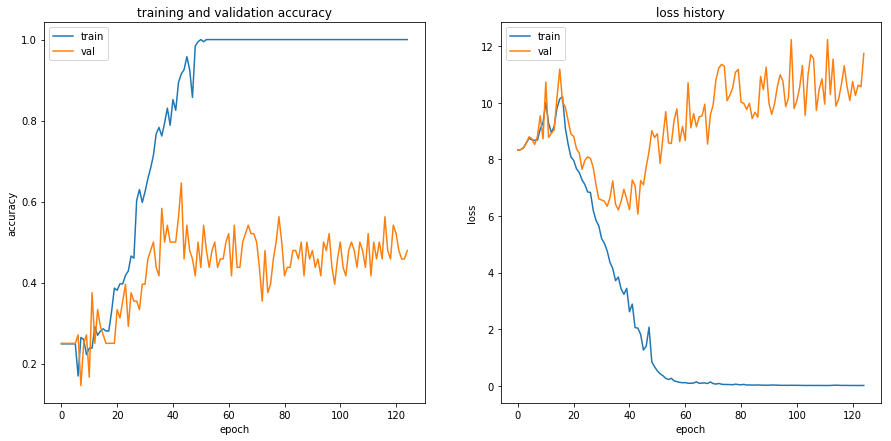

In [128]:
print('Test accuracy is: ',test_acc)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.subplot(1, 2, 2)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [55]:
for i in [100,333]:
    print(i)

100
333


In [58]:
for i,size in enumerate([104,200]):
    print(i)
    print(size)

0
104
1
200


In [50]:
net_1 = Net()
net_2 = Net()
net_3 = Net()
net_4 = Net()
net_5 = Net()
net_6 = Net()
net_7 = Net()
list_net = [net_1, net_2, net_3, net_4, net_5, net_6, net_7]
list_best_net = [Net(), Net(), Net(), Net(), Net(), Net(), Net()]
for n,net in enumerate(list_net):
    #val_acc_history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)
    print('--------------------------------------------------')
    print('Training Net {}'.format(n+1))
    for epoch in range(26):
        for i , data in enumerate(train_loader_1, 0):
            inputs, labels = data
            
            net.train()
            
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i % 2 == 1:
                net.eval()
                val_correct, val_total = 0, 0 
                for val_data in val_loader_1:
                    val_images, val_labels = val_data
                    val_outputs = net(val_images)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
                val_acc = val_correct / val_total
                print('Epoch {} | Iter{} | Loss{:.4f} | val acc {:.4f}'.format(
                    epoch, i , loss, val_acc))
                #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
                #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
                #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
        #val_correct, val_total = 0, 0
        #for val_data in val_loader_1:
        #    val_images, val_labels = val_data
        #    val_outputs = net(val_images)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #if val_acc == max(val_acc_history):
        #    list_best_net[n] = Net()
        #    list_best_net[n].load_state_dict(net.state_dict())
test_correct, test_total = 0, 0
for test_data in test_loader_1:
    test_images, test_labels = test_data
    test_predicted_list = []
    for net in list_net:
    #for net_best in list_best_net:
        test_outputs = net(test_images)
        #test_outputs = net_best(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_predicted_list.append(test_predicted.numpy())
    test_predicted_list = np.array(test_predicted_list)
    test_predicted_result = []
    for vote in range(np.shape(test_predicted_list)[1]):
        test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
    test_predicted = torch.Tensor(test_predicted_result)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)

--------------------------------------------------
Training Net 1
Epoch 0 | Iter1 | Loss1.6369 | val acc 0.3750
Epoch 0 | Iter3 | Loss1.7491 | val acc 0.3750
Epoch 0 | Iter5 | Loss1.8225 | val acc 0.3750
Epoch 0 | Iter7 | Loss1.8248 | val acc 0.3125
Epoch 0 | Iter9 | Loss1.5488 | val acc 0.2917
Epoch 0 | Iter11 | Loss1.5226 | val acc 0.2708
Epoch 0 | Iter13 | Loss1.4853 | val acc 0.3333
Epoch 0 | Iter15 | Loss1.5834 | val acc 0.3542
Epoch 0 | Iter17 | Loss1.4572 | val acc 0.3958
Epoch 1 | Iter1 | Loss1.5596 | val acc 0.3333
Epoch 1 | Iter3 | Loss1.1818 | val acc 0.3125
Epoch 1 | Iter5 | Loss1.4253 | val acc 0.3542
Epoch 1 | Iter7 | Loss1.3930 | val acc 0.3125
Epoch 1 | Iter9 | Loss1.5970 | val acc 0.3333
Epoch 1 | Iter11 | Loss1.2510 | val acc 0.3958
Epoch 1 | Iter13 | Loss1.2624 | val acc 0.3542
Epoch 1 | Iter15 | Loss1.3322 | val acc 0.3750
Epoch 1 | Iter17 | Loss1.4076 | val acc 0.3542
Epoch 2 | Iter1 | Loss1.3967 | val acc 0.1875
Epoch 2 | Iter3 | Loss1.2543 | val acc 0.3125
Epoch 

Epoch 19 | Iter7 | Loss0.3091 | val acc 0.5417
Epoch 19 | Iter9 | Loss0.2635 | val acc 0.5417
Epoch 19 | Iter11 | Loss0.3395 | val acc 0.5208
Epoch 19 | Iter13 | Loss0.3545 | val acc 0.4583
Epoch 19 | Iter15 | Loss0.4491 | val acc 0.5208
Epoch 19 | Iter17 | Loss0.3643 | val acc 0.6250
Epoch 20 | Iter1 | Loss0.3242 | val acc 0.5625
Epoch 20 | Iter3 | Loss0.1405 | val acc 0.5833
Epoch 20 | Iter5 | Loss0.5106 | val acc 0.5833
Epoch 20 | Iter7 | Loss0.2365 | val acc 0.5417
Epoch 20 | Iter9 | Loss0.4577 | val acc 0.5833
Epoch 20 | Iter11 | Loss0.3698 | val acc 0.5000
Epoch 20 | Iter13 | Loss0.4515 | val acc 0.6250
Epoch 20 | Iter15 | Loss0.3155 | val acc 0.6250
Epoch 20 | Iter17 | Loss0.4360 | val acc 0.5833
Epoch 21 | Iter1 | Loss0.2841 | val acc 0.6042
Epoch 21 | Iter3 | Loss0.1654 | val acc 0.5417
Epoch 21 | Iter5 | Loss0.3551 | val acc 0.4375
Epoch 21 | Iter7 | Loss0.3774 | val acc 0.5625
Epoch 21 | Iter9 | Loss0.4002 | val acc 0.5833
Epoch 21 | Iter11 | Loss0.3028 | val acc 0.5417
Epoc

Epoch 12 | Iter13 | Loss0.5614 | val acc 0.6667
Epoch 12 | Iter15 | Loss0.4491 | val acc 0.6667
Epoch 12 | Iter17 | Loss0.4500 | val acc 0.6250
Epoch 13 | Iter1 | Loss0.5091 | val acc 0.6875
Epoch 13 | Iter3 | Loss0.4886 | val acc 0.6458
Epoch 13 | Iter5 | Loss0.3700 | val acc 0.6458
Epoch 13 | Iter7 | Loss0.4390 | val acc 0.6250
Epoch 13 | Iter9 | Loss0.5623 | val acc 0.6667
Epoch 13 | Iter11 | Loss0.4018 | val acc 0.6042
Epoch 13 | Iter13 | Loss0.4504 | val acc 0.6875
Epoch 13 | Iter15 | Loss0.4194 | val acc 0.6250
Epoch 13 | Iter17 | Loss0.3816 | val acc 0.6250
Epoch 14 | Iter1 | Loss0.4634 | val acc 0.6042
Epoch 14 | Iter3 | Loss0.6179 | val acc 0.6667
Epoch 14 | Iter5 | Loss0.3669 | val acc 0.7083
Epoch 14 | Iter7 | Loss0.4292 | val acc 0.6875
Epoch 14 | Iter9 | Loss0.6855 | val acc 0.5625
Epoch 14 | Iter11 | Loss0.4533 | val acc 0.6667
Epoch 14 | Iter13 | Loss0.4271 | val acc 0.6667
Epoch 14 | Iter15 | Loss0.4015 | val acc 0.6042
Epoch 14 | Iter17 | Loss0.4293 | val acc 0.6875
Ep

Epoch 5 | Iter17 | Loss0.9718 | val acc 0.5208
Epoch 6 | Iter1 | Loss0.8852 | val acc 0.5000
Epoch 6 | Iter3 | Loss0.8972 | val acc 0.5625
Epoch 6 | Iter5 | Loss0.7457 | val acc 0.5000
Epoch 6 | Iter7 | Loss0.9776 | val acc 0.6042
Epoch 6 | Iter9 | Loss0.7779 | val acc 0.5625
Epoch 6 | Iter11 | Loss0.7557 | val acc 0.5625
Epoch 6 | Iter13 | Loss0.8284 | val acc 0.6458
Epoch 6 | Iter15 | Loss0.8060 | val acc 0.5625
Epoch 6 | Iter17 | Loss0.7045 | val acc 0.6458
Epoch 7 | Iter1 | Loss0.8630 | val acc 0.5208
Epoch 7 | Iter3 | Loss0.8706 | val acc 0.5625
Epoch 7 | Iter5 | Loss0.7685 | val acc 0.5417
Epoch 7 | Iter7 | Loss0.8901 | val acc 0.6458
Epoch 7 | Iter9 | Loss0.7537 | val acc 0.6250
Epoch 7 | Iter11 | Loss0.7315 | val acc 0.6250
Epoch 7 | Iter13 | Loss0.8293 | val acc 0.5625
Epoch 7 | Iter15 | Loss0.7350 | val acc 0.6250
Epoch 7 | Iter17 | Loss0.8184 | val acc 0.5208
Epoch 8 | Iter1 | Loss0.6730 | val acc 0.6042
Epoch 8 | Iter3 | Loss0.7802 | val acc 0.5833
Epoch 8 | Iter5 | Loss0.6

Epoch 25 | Iter5 | Loss0.2435 | val acc 0.7083
Epoch 25 | Iter7 | Loss0.2404 | val acc 0.6667
Epoch 25 | Iter9 | Loss0.3568 | val acc 0.7083
Epoch 25 | Iter11 | Loss0.3816 | val acc 0.7083
Epoch 25 | Iter13 | Loss0.1300 | val acc 0.7083
Epoch 25 | Iter15 | Loss0.3541 | val acc 0.7083
Epoch 25 | Iter17 | Loss0.2139 | val acc 0.6875
--------------------------------------------------
Training Net 4
Epoch 0 | Iter1 | Loss1.5047 | val acc 0.3750
Epoch 0 | Iter3 | Loss1.4869 | val acc 0.3750
Epoch 0 | Iter5 | Loss1.5971 | val acc 0.4375
Epoch 0 | Iter7 | Loss1.7690 | val acc 0.3750
Epoch 0 | Iter9 | Loss1.5654 | val acc 0.4792
Epoch 0 | Iter11 | Loss1.3856 | val acc 0.4375
Epoch 0 | Iter13 | Loss1.3477 | val acc 0.3542
Epoch 0 | Iter15 | Loss1.5447 | val acc 0.4167
Epoch 0 | Iter17 | Loss1.3452 | val acc 0.3958
Epoch 1 | Iter1 | Loss1.3476 | val acc 0.3958
Epoch 1 | Iter3 | Loss1.2933 | val acc 0.5000
Epoch 1 | Iter5 | Loss1.3011 | val acc 0.4792
Epoch 1 | Iter7 | Loss1.3818 | val acc 0.4583

Epoch 18 | Iter11 | Loss0.2201 | val acc 0.5208
Epoch 18 | Iter13 | Loss0.4066 | val acc 0.5000
Epoch 18 | Iter15 | Loss0.3420 | val acc 0.5417
Epoch 18 | Iter17 | Loss0.3734 | val acc 0.5625
Epoch 19 | Iter1 | Loss0.4022 | val acc 0.6042
Epoch 19 | Iter3 | Loss0.4402 | val acc 0.5833
Epoch 19 | Iter5 | Loss0.3533 | val acc 0.6042
Epoch 19 | Iter7 | Loss0.5149 | val acc 0.5833
Epoch 19 | Iter9 | Loss0.2796 | val acc 0.5208
Epoch 19 | Iter11 | Loss0.2680 | val acc 0.5417
Epoch 19 | Iter13 | Loss0.2818 | val acc 0.5000
Epoch 19 | Iter15 | Loss0.2686 | val acc 0.5208
Epoch 19 | Iter17 | Loss0.3938 | val acc 0.5625
Epoch 20 | Iter1 | Loss0.3304 | val acc 0.5000
Epoch 20 | Iter3 | Loss0.3059 | val acc 0.5417
Epoch 20 | Iter5 | Loss0.2338 | val acc 0.5208
Epoch 20 | Iter7 | Loss0.4147 | val acc 0.5625
Epoch 20 | Iter9 | Loss0.2867 | val acc 0.6042
Epoch 20 | Iter11 | Loss0.2601 | val acc 0.5625
Epoch 20 | Iter13 | Loss0.5061 | val acc 0.6042
Epoch 20 | Iter15 | Loss0.2884 | val acc 0.5833
Ep

Epoch 11 | Iter17 | Loss0.7050 | val acc 0.3750
Epoch 12 | Iter1 | Loss0.5055 | val acc 0.4167
Epoch 12 | Iter3 | Loss0.5461 | val acc 0.4583
Epoch 12 | Iter5 | Loss0.4895 | val acc 0.4167
Epoch 12 | Iter7 | Loss0.6098 | val acc 0.4583
Epoch 12 | Iter9 | Loss0.3814 | val acc 0.3958
Epoch 12 | Iter11 | Loss0.6205 | val acc 0.4583
Epoch 12 | Iter13 | Loss0.6246 | val acc 0.4375
Epoch 12 | Iter15 | Loss0.4480 | val acc 0.4792
Epoch 12 | Iter17 | Loss0.6936 | val acc 0.4792
Epoch 13 | Iter1 | Loss0.6266 | val acc 0.4375
Epoch 13 | Iter3 | Loss0.4834 | val acc 0.4583
Epoch 13 | Iter5 | Loss0.5362 | val acc 0.5000
Epoch 13 | Iter7 | Loss0.7015 | val acc 0.5000
Epoch 13 | Iter9 | Loss0.4645 | val acc 0.4167
Epoch 13 | Iter11 | Loss0.5601 | val acc 0.3750
Epoch 13 | Iter13 | Loss0.4707 | val acc 0.4792
Epoch 13 | Iter15 | Loss0.4133 | val acc 0.4167
Epoch 13 | Iter17 | Loss0.5999 | val acc 0.4792
Epoch 14 | Iter1 | Loss0.4800 | val acc 0.5000
Epoch 14 | Iter3 | Loss0.4589 | val acc 0.5000
Epoc

Epoch 5 | Iter3 | Loss0.8583 | val acc 0.5833
Epoch 5 | Iter5 | Loss0.9842 | val acc 0.5208
Epoch 5 | Iter7 | Loss0.9937 | val acc 0.5208
Epoch 5 | Iter9 | Loss0.9218 | val acc 0.6042
Epoch 5 | Iter11 | Loss0.8256 | val acc 0.6250
Epoch 5 | Iter13 | Loss0.9984 | val acc 0.6042
Epoch 5 | Iter15 | Loss0.8224 | val acc 0.5625
Epoch 5 | Iter17 | Loss1.1018 | val acc 0.5000
Epoch 6 | Iter1 | Loss0.9911 | val acc 0.5625
Epoch 6 | Iter3 | Loss0.8184 | val acc 0.5625
Epoch 6 | Iter5 | Loss0.7684 | val acc 0.5625
Epoch 6 | Iter7 | Loss0.9246 | val acc 0.5417
Epoch 6 | Iter9 | Loss0.7255 | val acc 0.5000
Epoch 6 | Iter11 | Loss0.9119 | val acc 0.4792
Epoch 6 | Iter13 | Loss0.7612 | val acc 0.5833
Epoch 6 | Iter15 | Loss0.8456 | val acc 0.4792
Epoch 6 | Iter17 | Loss0.8911 | val acc 0.6042
Epoch 7 | Iter1 | Loss0.8506 | val acc 0.6250
Epoch 7 | Iter3 | Loss0.7708 | val acc 0.5417
Epoch 7 | Iter5 | Loss0.7328 | val acc 0.5208
Epoch 7 | Iter7 | Loss0.9244 | val acc 0.5417
Epoch 7 | Iter9 | Loss0.82

Epoch 24 | Iter9 | Loss0.1621 | val acc 0.7083
Epoch 24 | Iter11 | Loss0.3006 | val acc 0.6875
Epoch 24 | Iter13 | Loss0.3028 | val acc 0.6458
Epoch 24 | Iter15 | Loss0.3159 | val acc 0.7292
Epoch 24 | Iter17 | Loss0.1906 | val acc 0.7500
Epoch 25 | Iter1 | Loss0.1845 | val acc 0.7083
Epoch 25 | Iter3 | Loss0.4183 | val acc 0.7292
Epoch 25 | Iter5 | Loss0.2355 | val acc 0.6875
Epoch 25 | Iter7 | Loss0.3658 | val acc 0.7083
Epoch 25 | Iter9 | Loss0.2371 | val acc 0.6875
Epoch 25 | Iter11 | Loss0.3319 | val acc 0.7292
Epoch 25 | Iter13 | Loss0.2672 | val acc 0.7500
Epoch 25 | Iter15 | Loss0.2633 | val acc 0.7083
Epoch 25 | Iter17 | Loss0.2651 | val acc 0.7917
--------------------------------------------------
Training Net 7
Epoch 0 | Iter1 | Loss1.5614 | val acc 0.1667
Epoch 0 | Iter3 | Loss1.4592 | val acc 0.1667
Epoch 0 | Iter5 | Loss1.7603 | val acc 0.1667
Epoch 0 | Iter7 | Loss1.5689 | val acc 0.1250
Epoch 0 | Iter9 | Loss1.7458 | val acc 0.0833
Epoch 0 | Iter11 | Loss1.5826 | val ac

Epoch 17 | Iter15 | Loss0.3583 | val acc 0.4583
Epoch 17 | Iter17 | Loss0.3956 | val acc 0.5000
Epoch 18 | Iter1 | Loss0.4121 | val acc 0.5000
Epoch 18 | Iter3 | Loss0.4961 | val acc 0.6250
Epoch 18 | Iter5 | Loss0.4526 | val acc 0.5833
Epoch 18 | Iter7 | Loss0.3878 | val acc 0.6250
Epoch 18 | Iter9 | Loss0.4745 | val acc 0.4792
Epoch 18 | Iter11 | Loss0.3426 | val acc 0.5000
Epoch 18 | Iter13 | Loss0.3883 | val acc 0.6250
Epoch 18 | Iter15 | Loss0.2389 | val acc 0.6250
Epoch 18 | Iter17 | Loss0.3214 | val acc 0.6667
Epoch 19 | Iter1 | Loss0.3280 | val acc 0.3958
Epoch 19 | Iter3 | Loss0.5195 | val acc 0.5000
Epoch 19 | Iter5 | Loss0.4460 | val acc 0.5208
Epoch 19 | Iter7 | Loss0.3542 | val acc 0.6042
Epoch 19 | Iter9 | Loss0.4021 | val acc 0.6042
Epoch 19 | Iter11 | Loss0.4237 | val acc 0.5208
Epoch 19 | Iter13 | Loss0.4658 | val acc 0.4792
Epoch 19 | Iter15 | Loss0.3429 | val acc 0.3958
Epoch 19 | Iter17 | Loss0.4284 | val acc 0.5208
Epoch 20 | Iter1 | Loss0.3950 | val acc 0.5625
Epo